## Tutorial of DeepAdapter
### A self-adaptive and versatile tool for eliminating multiple undesirable variations from transcriptome
In this notebook, you will learn how to re-train DeepAdapter with the example dataset.

## 1. Installation and requirements
### 1.1. Installation
To run locally, please open a terminal window and download the code with:
```sh
$ # create a new conda environment
$ conda create -n DA python=3.9
$ # activate environment
$ conda activate DA
$ # Install dependencies
$ pip install deepadapter==1.0.1
$ # Launch jupyter notebook
$ jupyter notebook
```
### 1.2. Download datasets
Please download the open datasets in [Zenodo](https://zenodo.org/records/10494751).
These datasets are collected from literatures to demonstrate multiple unwanted variations, including:
* batch datasets: LINCS-DToxS ([van Hasselt et al. Nature Communications, 2020](https://www.nature.com/articles/s41467-020-18396-7)) and Quartet project ([Yu, Y. et al. Nature Biotechnology, 2023](https://www.nature.com/articles/s41587-023-01867-9)).
* platform datasets: profiles from microarray ([Iorio, F. et al. Cell, 2016](https://www.cell.com/cell/pdf/S0092-8674(16)30746-2.pdf)) and RNA-seq ([Ghandi, M. et al. Nature, 2019](https://www.nature.com/articles/s41586-019-1186-3)).
* purity datasets: profiles from cancer cell lines ([Ghandi, M. et al. Nature, 2019](https://www.nature.com/articles/s41586-019-1186-3)) and tissues ([Weinstein, J.N. et al. Nature genetics, 2013](https://www.nature.com/articles/ng.2764)).

After downloading, place the datasets in the `data/` directory located in the same hierarchy as this tutorial.
* batch datasets: `data/batch_data/`
* platform datasets: `data/platform_data/`
* purity datasets: `data/purity_data/`
  
**Putting datasets in the right directory is important for loading the example datasets successfully.**

To execute a "cell", please press Shift+Enter

### 1.3. Download pre-trained models
Please download the pre-trained models for fine-tuning. The models are in the this link [click here to download](https://github.com/mjDelta/DeepAdapter/blob/main/models).

After downloading, place the models in the `models/` directory located in the same hierarchy as this tutorial.
* pretrained batch_lincs: `models/batch_LINCS`
* pretrained batch_quartet: `models/batch_Quartet`
* pretrained platform: `models/platform`
* pretrained purity: `models/purity`
* pretrained batch_quartet (using the intersected gene set between LINCS and Quartet dataset): `models/pretrained_LINCS_Quartet`

**Putting models in the right directory is important for loading the pretrained models successfully.**

## 2. Load the datasets and preprocess
### 2.1. load the modules

In [1]:
%load_ext autoreload
%autoreload 2

import os, sys
import pandas as pd
import numpy as np

sys.path.append("deepadapter/")
from deepadapter.utils import finetune_utils as FTUT
from deepadapter.utils import data_utils as DT
from deepadapter.params import dl_finetune_params as DLPARAM


### 2.2. Load the demonstrated datasets
We ultilize Batch-LINCS for demonstration. To load datasets of platform and purity variations, please download them in Zenodo (https://zenodo.org/records/10494751).
  * In the tutorial, we have **data** for gene expression, **batches** for unwanted variations, and **donors** for biological signals.
  * If you want to fine-tune with your own data, please refer to `DeepAdapter-YourOwnData-Finetune.ipynb`.

In [2]:
loadTransData = DT.LoadTransData()
data, batches, wells, donors, infos, test_infos = loadTransData.load_lincs_lds1593()
ids = np.arange(len(data))

Load LINCS LDS 1593, size of (709, 10112)


### 2.3 Load the genes used in pre-trained model
Before fine-tuning, make sure that the loaded genes are the genes used in the pre-trained model. The pre-trained models can be found in the folder of `models`.

In [3]:
load_dir = "models/pretrained_LINCS_Quartet/"
pretrain_genes = pd.read_csv(os.path.join(load_dir, "gene.csv"))["gene"]
try:
	data = data[pretrain_genes]
except Exception as e:
    raise("Inconsistent gene set between this dataset and pretrained dataset")

### 2.3. Preprocess the transcriptomic data
The gene expression profiles are preprocessed by sample normalization, gene ranking, and log normalization. Let $S_i = \sum_l x_{i l}$ denote the sum over all genes. In sample normalization, we divide $S_i$ for every sample and multiply a constant 10000 ([Xiaokang Yu et al. Nature communications, 2023](https://www.nature.com/articles/s41467-023-36635-5)):
$$x_{i l} = \frac{x_{i l}}{S_i} 10^4.$$
Then, we sort genes by their expression levels and perform the log transformation $x_{i l} = \log {(x_{i l} + 1)}$.

In [4]:
prepTransData = DT.PrepTransData()
raw_df = prepTransData.sample_norm(data)
input_arr = prepTransData.sample_log(raw_df)
bat2label, label2bat, unwanted_labels, unwanted_onehot = prepTransData.label2onehot(batches)

## 3. Fine-tune DeepAdapter
### 3.1. Adjust DeepAdapter's parameters
The parameters for DeepAdapter are as follows (**Note: you can revise parameter directly in `net_args`, e.g., `net_args.batch_size = 512`.**):
* **epochs**: the fine-tune epochs of DeepAdapter, default = $5000$
* **ae_epochs**: the warmup epochs of autoencoder in DeepAdapter, default = $400$
* **batch_epochs**: the warmup epochs of discriminator in DeepAdapter, default = $50$
* **batch_size**: the batch size of dataloader, default = $256$
* **hidden_dim**: the hidden units of autoencoder in DeepAdapter, default = $256$
* **z_dim**: the latent units of autoencoder in DeepAdapter, default = $128$
* **drop**: the dropout rate of DeepAdapter, default = $0.3$
* **lr_lower_ae**: the lower learning rate of autoencoder in DeepAdapter, default = $1e-5$
* **lr_upper_ae**: the upper learning rate of autoencoder in DeepAdapter, default = $5e-4$
* **lr_lower_batch**: the lower learning rate of discriminator in DeepAdapter, default = $1e-5$
* **lr_upper_batch**: the upper learning rate of discriminator in DeepAdapter, default = $5e-4$

In [5]:
net_args = DLPARAM.load_dl_params()

### 3.2. Fine-tune DeepAdapter
Given that the fine-tuned dataset encompasses a different number of batch categories (4 batches) compared to the pre-trained dataset (21 batches), we modify the last layer of the discriminatory network to classify 4 batch categories instead of 21. We unfreeze all layers and train the fine-tuned models for 5K epochs. This procedure is repeated 100 times, with performances assessed by an independent testing set of 24 samples.

(12,) (12,)
(12, 8186) (12, 4)
(12, 8186) (12, 4)




C:\Users\mengj\OneDrive - Yale University\omics\DeepAdapter\pypi_packagev2\deepadapter\models\trainer.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_dict 

Params of AE: 4.69913; Params of Discriminator: 0.100868
Load the pretrained AE


  9%|█▎            | 454/5000 [00:10<02:00, 37.68it/s, e=456, tot_ae=0.011, tot_b=1.18, val_ae=3.31]

Update model, loss of 3.9096882343292236
Update model, loss of 3.070319652557373
Update model, loss of 2.919654607772827


  9%|█▏           | 467/5000 [00:11<02:17, 33.04it/s, e=469, tot_ae=0.0108, tot_b=1.19, val_ae=4.34]

Update model, loss of 2.8044910430908203
Update model, loss of 2.586649179458618


 10%|█▎            | 475/5000 [00:11<02:26, 30.83it/s, e=477, tot_ae=0.011, tot_b=1.18, val_ae=3.14]

Update model, loss of 2.520505428314209


 11%|█▍           | 535/5000 [00:13<02:25, 30.58it/s, e=537, tot_ae=0.0101, tot_b=1.18, val_ae=3.61]

Update model, loss of 2.4293265342712402


 12%|█▍          | 607/5000 [00:15<02:20, 31.32it/s, e=610, tot_ae=0.00818, tot_b=1.15, val_ae=3.24]

Update model, loss of 2.329469919204712


 13%|█▌          | 631/5000 [00:16<02:20, 31.11it/s, e=633, tot_ae=0.00891, tot_b=1.19, val_ae=2.88]

Update model, loss of 2.2190444469451904


 14%|█▌          | 675/5000 [00:17<02:18, 31.21it/s, e=674, tot_ae=0.00867, tot_b=1.16, val_ae=3.14]

Update model, loss of 2.072666645050049


 14%|█▋          | 695/5000 [00:18<02:19, 30.92it/s, e=696, tot_ae=0.00778, tot_b=1.18, val_ae=2.64]

Update model, loss of 2.0235049724578857


 15%|█▊          | 735/5000 [00:19<02:17, 31.01it/s, e=737, tot_ae=0.00786, tot_b=1.16, val_ae=3.78]

Update model, loss of 1.9897743463516235


 15%|█▊          | 767/5000 [00:20<02:19, 30.25it/s, e=769, tot_ae=0.00695, tot_b=1.17, val_ae=3.03]

Update model, loss of 1.8904316425323486


 19%|██▏         | 931/5000 [00:25<02:08, 31.67it/s, e=930, tot_ae=0.00495, tot_b=1.22, val_ae=3.16]

Update model, loss of 1.7513813972473145


 19%|██▎         | 943/5000 [00:25<02:08, 31.61it/s, e=942, tot_ae=0.00565, tot_b=1.22, val_ae=2.53]

Update model, loss of 1.7439830303192139


 19%|██▋           | 967/5000 [00:26<02:07, 31.70it/s, e=967, tot_ae=0.0053, tot_b=1.2, val_ae=2.68]

Update model, loss of 1.7124298810958862


 21%|██▎        | 1043/5000 [00:29<02:08, 30.68it/s, e=1043, tot_ae=0.00441, tot_b=1.21, val_ae=3.3]

Update model, loss of 1.6689704656600952


 24%|██▍       | 1191/5000 [00:33<02:00, 31.53it/s, e=1194, tot_ae=0.00303, tot_b=1.22, val_ae=2.99]

Update model, loss of 1.5940734148025513
Update model, loss of 1.5151703357696533


 24%|██▍       | 1202/5000 [00:34<02:06, 30.00it/s, e=1202, tot_ae=0.00255, tot_b=1.22, val_ae=2.63]

Update model, loss of 1.440299391746521


 30%|██▉       | 1482/5000 [00:42<01:48, 32.34it/s, e=1483, tot_ae=0.00101, tot_b=1.18, val_ae=2.42]

Update model, loss of 1.4002065658569336


 30%|███▎       | 1506/5000 [00:43<01:50, 31.56it/s, e=1509, tot_ae=0.00057, tot_b=1.2, val_ae=2.92]

Update model, loss of 1.3383419513702393



C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


trainer:  models/finetune_LINCS_Quartet/record_24\finetune
{0: 0, 1: 1, 2: 2, 3: 3} {0, 2, 3}


C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


{'A': 'A', 'B': 'B', 'E': 'E', 'D': 'D'} {'A', 'B', 'E', 'D'}
(12,) (12,)
(12, 8186) (12, 4)
(12, 8186) (12, 4)




C:\Users\mengj\OneDrive - Yale University\omics\DeepAdapter\pypi_packagev2\deepadapter\models\trainer.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_dict 

Params of AE: 4.69913; Params of Discriminator: 0.100868
Load the pretrained AE


  9%|█▏           | 455/5000 [00:10<01:55, 39.20it/s, e=456, tot_ae=0.0182, tot_b=1.02, val_ae=1.23]

Update model, loss of 1.0550026893615723


  9%|█▎            | 464/5000 [00:11<02:13, 33.97it/s, e=466, tot_ae=0.019, tot_b=1.04, val_ae=1.31]

Update model, loss of 0.8513456583023071


 10%|█▏          | 500/5000 [00:12<02:23, 31.43it/s, e=502, tot_ae=0.0168, tot_b=0.995, val_ae=1.72]

Update model, loss of 0.7290076017379761


 12%|█▍          | 612/5000 [00:15<02:16, 32.15it/s, e=611, tot_ae=0.0195, tot_b=0.993, val_ae=1.46]

Update model, loss of 0.5842697620391846


 15%|█▊          | 764/5000 [00:20<02:08, 32.89it/s, e=764, tot_ae=0.0154, tot_b=0.974, val_ae=1.63]

Update model, loss of 0.5611101984977722


 20%|██▏        | 997/5000 [00:26<02:12, 30.27it/s, e=996, tot_ae=0.0129, tot_b=0.991, val_ae=0.847]

Update model, loss of 0.5226757526397705


 21%|██        | 1057/5000 [00:28<02:02, 32.29it/s, e=1057, tot_ae=0.0149, tot_b=1.13, val_ae=0.936]

Update model, loss of 0.4724975824356079


 22%|██▍        | 1081/5000 [00:29<02:00, 32.59it/s, e=1081, tot_ae=0.0126, tot_b=1.13, val_ae=1.05]

Update model, loss of 0.3965945243835449


 22%|██▍        | 1113/5000 [00:30<01:59, 32.40it/s, e=1115, tot_ae=0.011, tot_b=1.17, val_ae=0.653]

Update model, loss of 0.3256339728832245


 23%|██▎       | 1137/5000 [00:31<02:01, 31.74it/s, e=1136, tot_ae=0.0097, tot_b=1.21, val_ae=0.764]

Update model, loss of 0.20548176765441895


 39%|███▌     | 1970/5000 [00:56<01:35, 31.70it/s, e=1972, tot_ae=0.00433, tot_b=1.07, val_ae=0.811]

Update model, loss of 0.1846722811460495



C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


trainer:  models/finetune_LINCS_Quartet/record_24\finetune
{0: 0, 1: 1, 2: 2, 3: 3} {0, 2, 3}


C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


{'A': 'A', 'B': 'B', 'E': 'E', 'D': 'D'} {'A', 'B', 'E', 'D'}
(12,) (12,)
(12, 8186) (12, 4)
(12, 8186) (12, 4)




C:\Users\mengj\OneDrive - Yale University\omics\DeepAdapter\pypi_packagev2\deepadapter\models\trainer.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_dict 

Params of AE: 4.69913; Params of Discriminator: 0.100868
Load the pretrained AE


  9%|█▏           | 457/5000 [00:10<01:45, 42.88it/s, e=457, tot_ae=0.0131, tot_b=1.15, val_ae=1.95]

Update model, loss of 1.5744248628616333


  9%|█▏           | 462/5000 [00:10<01:58, 38.43it/s, e=464, tot_ae=0.0123, tot_b=1.15, val_ae=1.58]

Update model, loss of 1.565819263458252


 10%|█▎           | 483/5000 [00:11<02:14, 33.53it/s, e=482, tot_ae=0.0109, tot_b=1.13, val_ae=1.73]

Update model, loss of 1.549715280532837


 10%|█▍            | 499/5000 [00:11<02:21, 31.75it/s, e=502, tot_ae=0.012, tot_b=1.13, val_ae=1.65]

Update model, loss of 1.3994709253311157


 18%|██          | 883/5000 [00:23<02:07, 32.35it/s, e=883, tot_ae=0.00932, tot_b=1.18, val_ae=1.48]

Update model, loss of 1.3521100282669067


 19%|██▏         | 931/5000 [00:24<02:09, 31.36it/s, e=933, tot_ae=0.00771, tot_b=1.13, val_ae=1.65]

Update model, loss of 1.3410955667495728


 21%|██▎        | 1068/5000 [00:28<02:00, 32.61it/s, e=1068, tot_ae=0.00717, tot_b=1.12, val_ae=1.7]

Update model, loss of 1.3199745416641235


 23%|██▎       | 1152/5000 [00:31<02:01, 31.70it/s, e=1152, tot_ae=0.00588, tot_b=1.16, val_ae=1.48]

Update model, loss of 1.2899110317230225


 23%|██▎       | 1160/5000 [00:31<02:07, 30.00it/s, e=1162, tot_ae=0.00595, tot_b=1.14, val_ae=1.57]

Update model, loss of 1.2468804121017456


 24%|██▋        | 1199/5000 [00:32<01:58, 32.14it/s, e=1199, tot_ae=0.00487, tot_b=1.18, val_ae=1.5]

Update model, loss of 1.2429839372634888


 25%|██▍       | 1227/5000 [00:33<02:04, 30.22it/s, e=1229, tot_ae=0.00607, tot_b=1.14, val_ae=1.47]

Update model, loss of 1.203739047050476


 26%|██▌       | 1291/5000 [00:35<02:02, 30.26it/s, e=1292, tot_ae=0.00477, tot_b=1.12, val_ae=1.42]

Update model, loss of 1.199984073638916


 27%|██▋       | 1343/5000 [00:37<02:00, 30.39it/s, e=1344, tot_ae=0.00424, tot_b=1.12, val_ae=1.32]

Update model, loss of 1.1929503679275513


 27%|██▉        | 1355/5000 [00:37<01:54, 31.89it/s, e=1355, tot_ae=0.00659, tot_b=1.13, val_ae=1.6]

Update model, loss of 1.1692488193511963


 28%|███        | 1391/5000 [00:38<01:56, 30.94it/s, e=1393, tot_ae=0.0051, tot_b=1.13, val_ae=1.23]

Update model, loss of 1.1476154327392578


 28%|███        | 1407/5000 [00:39<01:56, 30.89it/s, e=1407, tot_ae=0.00499, tot_b=1.1, val_ae=1.29]

Update model, loss of 1.1365257501602173


 31%|███▎       | 1531/5000 [00:42<01:46, 32.48it/s, e=1532, tot_ae=0.00414, tot_b=1.16, val_ae=1.4]

Update model, loss of 1.1233596801757812


 72%|██████▌  | 3623/5000 [01:46<00:41, 32.98it/s, e=3625, tot_ae=-0.00333, tot_b=1.14, val_ae=1.14]

Update model, loss of 1.1064907312393188


 77%|██████▉  | 3849/5000 [01:53<00:37, 30.66it/s, e=3851, tot_ae=-0.00365, tot_b=1.04, val_ae=1.33]

Update model, loss of 1.095020055770874


 77%|██████▉  | 3863/5000 [01:54<00:37, 29.95it/s, e=3862, tot_ae=-0.00421, tot_b=1.07, val_ae=1.59]

Update model, loss of 1.080909013748169


 79%|███████  | 3927/5000 [01:56<00:34, 31.23it/s, e=3929, tot_ae=-0.00363, tot_b=1.05, val_ae=1.35]

Update model, loss of 1.0567013025283813


 81%|███████▎ | 4043/5000 [02:00<00:32, 29.65it/s, e=4042, tot_ae=-0.00468, tot_b=1.06, val_ae=1.34]

Update model, loss of 1.0213701725006104
Update model, loss of 1.0173277854919434


 81%|███████▎ | 4055/5000 [02:00<00:30, 30.94it/s, e=4056, tot_ae=-0.00475, tot_b=1.04, val_ae=1.12]

Update model, loss of 0.9249438047409058


 82%|███████▎ | 4083/5000 [02:01<00:28, 32.02it/s, e=4085, tot_ae=-0.00376, tot_b=1.05, val_ae=1.11]

Update model, loss of 0.8718219995498657


 82%|███████▎ | 4095/5000 [02:01<00:31, 29.12it/s, e=4095, tot_ae=-0.00493, tot_b=1.04, val_ae=1.04]

Update model, loss of 0.8318309783935547


 85%|████████▍ | 4227/5000 [02:05<00:25, 29.94it/s, e=4230, tot_ae=-0.0052, tot_b=1.06, val_ae=1.02]

Update model, loss of 0.830998420715332


 88%|███████▉ | 4386/5000 [02:11<00:21, 28.30it/s, e=4386, tot_ae=-0.0038, tot_b=1.09, val_ae=0.901]

Update model, loss of 0.8277593851089478
Update model, loss of 0.8068366646766663


 88%|███████ | 4396/5000 [02:11<00:23, 25.79it/s, e=4396, tot_ae=-0.00594, tot_b=1.12, val_ae=0.953]

Update model, loss of 0.7820709347724915


 88%|███████▉ | 4414/5000 [02:12<00:20, 28.21it/s, e=4416, tot_ae=-0.0059, tot_b=1.09, val_ae=0.911]

Update model, loss of 0.780237078666687


 91%|████████▏| 4528/5000 [02:16<00:17, 27.05it/s, e=4529, tot_ae=-0.00614, tot_b=1.1, val_ae=0.782]

Update model, loss of 0.7626809477806091


 91%|████████▏| 4555/5000 [02:16<00:15, 29.19it/s, e=4555, tot_ae=-0.00513, tot_b=1.16, val_ae=0.94]

Update model, loss of 0.7003306150436401


 92%|███████▎| 4598/5000 [02:18<00:14, 28.35it/s, e=4599, tot_ae=-0.00614, tot_b=1.07, val_ae=0.895]

Update model, loss of 0.654059886932373


 94%|███████▌| 4698/5000 [02:21<00:11, 25.96it/s, e=4699, tot_ae=-0.00599, tot_b=1.15, val_ae=0.773]

Update model, loss of 0.6407483816146851


 96%|████████▌| 4782/5000 [02:24<00:07, 30.92it/s, e=4781, tot_ae=-0.00626, tot_b=1.1, val_ae=0.897]

Update model, loss of 0.638957679271698


 96%|███████▋| 4802/5000 [02:25<00:06, 29.42it/s, e=4804, tot_ae=-0.00654, tot_b=1.15, val_ae=0.664]

Update model, loss of 0.6349136233329773


 98%|████████▊| 4876/5000 [02:27<00:04, 26.18it/s, e=4879, tot_ae=-0.00694, tot_b=1.1, val_ae=0.573]

Update model, loss of 0.5898126363754272
Update model, loss of 0.5732353925704956


100%|███████▉| 4984/5000 [02:30<00:00, 30.85it/s, e=4983, tot_ae=-0.00679, tot_b=1.06, val_ae=0.822]

Update model, loss of 0.5684831142425537



C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


trainer:  models/finetune_LINCS_Quartet/record_24\finetune
{0: 0, 1: 1, 2: 2, 3: 3} {0, 2, 3}


C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


{'A': 'A', 'B': 'B', 'E': 'E', 'D': 'D'} {'A', 'B', 'E', 'D'}
(12,) (12,)
(12, 8186) (12, 4)
(12, 8186) (12, 4)




C:\Users\mengj\OneDrive - Yale University\omics\DeepAdapter\pypi_packagev2\deepadapter\models\trainer.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_dict 

Params of AE: 4.69913; Params of Discriminator: 0.100868
Load the pretrained AE


  9%|▉          | 453/5000 [00:10<01:46, 42.55it/s, e=456, tot_ae=0.00914, tot_b=1.12, val_ae=0.315]

Update model, loss of 0.2182433158159256
Update model, loss of 0.12149371951818466


 13%|█▎        | 630/5000 [00:16<02:30, 29.04it/s, e=630, tot_ae=0.00602, tot_b=1.12, val_ae=0.0994]

Update model, loss of 0.11680276691913605
Update model, loss of 0.09941411763429642


 13%|█▍         | 670/5000 [00:17<02:19, 31.00it/s, e=672, tot_ae=0.00515, tot_b=1.12, val_ae=0.104]

Update model, loss of 0.07862973213195801


 14%|█▋          | 682/5000 [00:18<02:19, 30.88it/s, e=685, tot_ae=0.00747, tot_b=1.1, val_ae=0.146]

Update model, loss of 0.07809282094240189


 14%|█▋          | 690/5000 [00:18<02:18, 31.14it/s, e=693, tot_ae=0.00637, tot_b=1.1, val_ae=0.255]

Update model, loss of 0.07778175175189972


 15%|█▊          | 762/5000 [00:20<02:08, 32.99it/s, e=762, tot_ae=0.00518, tot_b=1.1, val_ae=0.181]

Update model, loss of 0.07759063690900803


 15%|█▊          | 774/5000 [00:20<02:14, 31.45it/s, e=774, tot_ae=0.00524, tot_b=1.1, val_ae=0.214]

Update model, loss of 0.07679403573274612
Update model, loss of 0.07673007994890213


 16%|█▋         | 782/5000 [00:21<02:22, 29.67it/s, e=783, tot_ae=0.00551, tot_b=1.09, val_ae=0.191]

Update model, loss of 0.07650043070316315
Update model, loss of 0.07642030715942383


 69%|████▊  | 3465/5000 [01:50<01:04, 23.74it/s, e=3465, tot_ae=-0.00173, tot_b=1.07, val_ae=0.0771]

Update model, loss of 0.07639383524656296
Update model, loss of 0.07632720470428467


 70%|████▉  | 3513/5000 [01:52<00:54, 27.29it/s, e=3514, tot_ae=-0.00136, tot_b=1.03, val_ae=0.0779]

Update model, loss of 0.0761626586318016


 74%|█████▏ | 3678/5000 [01:58<00:53, 24.67it/s, e=3679, tot_ae=-0.00131, tot_b=1.01, val_ae=0.0961]

Update model, loss of 0.07605264335870743
Update model, loss of 0.07563958317041397


 76%|██████  | 3808/5000 [02:03<00:47, 25.18it/s, e=3810, tot_ae=-0.00117, tot_b=1.01, val_ae=0.077]

Update model, loss of 0.07557699829339981


 80%|████▊ | 3996/5000 [02:09<00:40, 24.83it/s, e=3996, tot_ae=-0.00137, tot_b=0.992, val_ae=0.0763]

Update model, loss of 0.07549084722995758


 81%|█████▋ | 4067/5000 [02:12<00:37, 25.10it/s, e=4068, tot_ae=-0.00157, tot_b=1.02, val_ae=0.0759]

Update model, loss of 0.07522707432508469
Update model, loss of 0.0752192959189415


 96%|██████▋| 4803/5000 [02:39<00:08, 22.86it/s, e=4803, tot_ae=-0.0026, tot_b=0.968, val_ae=0.0906]

Update model, loss of 0.07518039643764496
Update model, loss of 0.07499586790800095
Update model, loss of 0.07456830888986588



C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


trainer:  models/finetune_LINCS_Quartet/record_24\finetune
{0: 0, 1: 1, 2: 2, 3: 3} {0, 2, 3}


C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


{'A': 'A', 'B': 'B', 'E': 'E', 'D': 'D'} {'A', 'B', 'E', 'D'}
(12,) (12,)
(12, 8186) (12, 4)
(12, 8186) (12, 4)




C:\Users\mengj\OneDrive - Yale University\omics\DeepAdapter\pypi_packagev2\deepadapter\models\trainer.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_dict 

Params of AE: 4.69913; Params of Discriminator: 0.100868
Load the pretrained AE


  9%|█           | 456/5000 [00:10<01:48, 42.01it/s, e=456, tot_ae=0.00616, tot_b=1.25, val_ae=1.57]

Update model, loss of 0.9932751059532166


  9%|█           | 461/5000 [00:11<02:03, 36.82it/s, e=462, tot_ae=0.00599, tot_b=1.25, val_ae=1.29]

Update model, loss of 0.7813699841499329


 10%|█          | 509/5000 [00:12<02:28, 30.18it/s, e=511, tot_ae=0.00597, tot_b=1.26, val_ae=0.926]

Update model, loss of 0.7248420119285583


 11%|█▎          | 569/5000 [00:14<02:33, 28.92it/s, e=568, tot_ae=0.00518, tot_b=1.26, val_ae=1.04]

Update model, loss of 0.6906052231788635
Update model, loss of 0.6896811127662659


 12%|█▍          | 596/5000 [00:15<02:29, 29.42it/s, e=597, tot_ae=0.00499, tot_b=1.24, val_ae=1.12]

Update model, loss of 0.5814706087112427



C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


trainer:  models/finetune_LINCS_Quartet/record_24\finetune
{0: 0, 1: 1, 2: 2, 3: 3} {0, 2, 3}


C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


{'A': 'A', 'B': 'B', 'E': 'E', 'D': 'D'} {'A', 'B', 'E', 'D'}
(12,) (12,)
(12, 8186) (12, 4)
(12, 8186) (12, 4)




C:\Users\mengj\OneDrive - Yale University\omics\DeepAdapter\pypi_packagev2\deepadapter\models\trainer.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_dict 

Params of AE: 4.69913; Params of Discriminator: 0.100868
Load the pretrained AE


  9%|█▏           | 454/5000 [00:10<02:21, 32.06it/s, e=454, tot_ae=0.0222, tot_b=1.05, val_ae=2.33]

Update model, loss of 2.7764570713043213
Update model, loss of 2.2427961826324463
Update model, loss of 1.8460739850997925


  9%|█▎            | 470/5000 [00:11<02:44, 27.57it/s, e=470, tot_ae=0.0216, tot_b=1.03, val_ae=2.2]

Update model, loss of 1.796301245689392


 10%|█▏           | 477/5000 [00:11<02:42, 27.88it/s, e=477, tot_ae=0.0211, tot_b=1.04, val_ae=1.89]

Update model, loss of 1.603859782218933


 12%|█▌           | 609/5000 [00:15<02:31, 28.94it/s, e=611, tot_ae=0.0207, tot_b=1.03, val_ae=1.89]

Update model, loss of 1.547736406326294


 14%|█▊           | 677/5000 [00:18<02:33, 28.24it/s, e=678, tot_ae=0.0198, tot_b=1.03, val_ae=1.91]

Update model, loss of 1.5458016395568848



C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


trainer:  models/finetune_LINCS_Quartet/record_24\finetune
{0: 0, 1: 1, 2: 2, 3: 3} {0, 2, 3}


C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


{'A': 'A', 'B': 'B', 'E': 'E', 'D': 'D'} {'A', 'B', 'E', 'D'}
(12,) (12,)
(12, 8186) (12, 4)
(12, 8186) (12, 4)




C:\Users\mengj\OneDrive - Yale University\omics\DeepAdapter\pypi_packagev2\deepadapter\models\trainer.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_dict 

Params of AE: 4.69913; Params of Discriminator: 0.100868
Load the pretrained AE


  9%|█▏           | 453/5000 [00:10<01:42, 44.48it/s, e=456, tot_ae=0.0243, tot_b=1.11, val_ae=1.59]

Update model, loss of 1.1741232872009277
Update model, loss of 0.9330428838729858


 10%|█▎            | 475/5000 [00:11<02:16, 33.27it/s, e=478, tot_ae=0.0201, tot_b=1.1, val_ae=1.03]

Update model, loss of 0.8214526772499084


 10%|█▎           | 511/5000 [00:12<02:25, 30.91it/s, e=513, tot_ae=0.0226, tot_b=1.07, val_ae=1.27]

Update model, loss of 0.8176856637001038


 10%|█▍            | 519/5000 [00:12<02:29, 30.04it/s, e=520, tot_ae=0.0201, tot_b=1.08, val_ae=1.2]

Update model, loss of 0.7808876037597656


 13%|█▋           | 648/5000 [00:16<02:15, 32.14it/s, e=647, tot_ae=0.0204, tot_b=1.06, val_ae=1.53]

Update model, loss of 0.7512124180793762


 18%|██▌           | 896/5000 [00:23<02:11, 31.20it/s, e=898, tot_ae=0.113, tot_b=1.03, val_ae=1.35]

Update model, loss of 0.6412990093231201


 32%|███▏      | 1620/5000 [00:45<01:45, 31.95it/s, e=1623, tot_ae=0.00629, tot_b=1.19, val_ae=1.36]

Update model, loss of 0.6209527254104614


 51%|█████     | 2540/5000 [01:12<01:17, 31.79it/s, e=2542, tot_ae=0.00122, tot_b=1.14, val_ae=1.06]

Update model, loss of 0.5979841351509094


 54%|█████▎    | 2684/5000 [01:16<01:13, 31.70it/s, e=2684, tot_ae=0.00111, tot_b=1.13, val_ae=1.26]

Update model, loss of 0.5627719163894653


 59%|█████▉    | 2948/5000 [01:24<01:03, 32.29it/s, e=2948, tot_ae=-0.000148, tot_b=1.1, val_ae=1.1]

Update model, loss of 0.5105598568916321


 70%|██████▉   | 3476/5000 [01:40<00:48, 31.28it/s, e=3476, tot_ae=-0.00142, tot_b=1.14, val_ae=1.2]

Update model, loss of 0.504076361656189


 73%|██████▌  | 3652/5000 [01:46<00:45, 29.81it/s, e=3654, tot_ae=-0.00188, tot_b=1.12, val_ae=1.06]

Update model, loss of 0.4136185646057129


 87%|██████▉ | 4363/5000 [02:09<00:22, 27.73it/s, e=4364, tot_ae=-0.00301, tot_b=1.09, val_ae=0.667]

Update model, loss of 0.33105042576789856



C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


trainer:  models/finetune_LINCS_Quartet/record_24\finetune
{0: 0, 1: 1, 2: 2, 3: 3} {0, 2, 3}


C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


{'A': 'A', 'B': 'B', 'E': 'E', 'D': 'D'} {'A', 'B', 'E', 'D'}
(12,) (12,)
(12, 8186) (12, 4)
(12, 8186) (12, 4)




C:\Users\mengj\OneDrive - Yale University\omics\DeepAdapter\pypi_packagev2\deepadapter\models\trainer.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_dict 

Params of AE: 4.69913; Params of Discriminator: 0.100868
Load the pretrained AE


  9%|█▏           | 455/5000 [00:10<02:05, 36.27it/s, e=455, tot_ae=0.0168, tot_b=1.07, val_ae=3.06]

Update model, loss of 2.609297037124634
Update model, loss of 2.383700370788574
Update model, loss of 1.9818320274353027


  9%|█▍             | 463/5000 [00:11<02:21, 32.13it/s, e=463, tot_ae=0.016, tot_b=1.08, val_ae=2.4]

Update model, loss of 1.9327977895736694
Update model, loss of 1.5910245180130005


 16%|██▋             | 821/5000 [00:21<02:11, 31.75it/s, e=824, tot_ae=0.0147, tot_b=1, val_ae=2.99]

Update model, loss of 1.561683177947998


 20%|██▏        | 1001/5000 [00:27<02:08, 31.01it/s, e=1003, tot_ae=0.0134, tot_b=1.01, val_ae=1.64]

Update model, loss of 1.338848352432251


 20%|██        | 1013/5000 [00:27<02:04, 32.06it/s, e=1013, tot_ae=0.0138, tot_b=0.966, val_ae=2.78]

Update model, loss of 1.29538893699646


 21%|██▎        | 1049/5000 [00:28<01:55, 34.12it/s, e=1051, tot_ae=0.0131, tot_b=0.98, val_ae=2.47]

Update model, loss of 1.2706785202026367


 24%|██▍       | 1217/5000 [00:33<01:59, 31.73it/s, e=1216, tot_ae=0.0133, tot_b=0.976, val_ae=2.59]

Update model, loss of 1.206376314163208


 28%|██▊       | 1405/5000 [00:39<01:54, 31.52it/s, e=1404, tot_ae=0.0127, tot_b=0.923, val_ae=2.16]

Update model, loss of 1.0912092924118042


 29%|██▉       | 1461/5000 [00:41<01:52, 31.36it/s, e=1463, tot_ae=0.0121, tot_b=0.903, val_ae=2.42]

Update model, loss of 1.0801029205322266


 32%|███▏      | 1577/5000 [00:44<01:58, 28.85it/s, e=1577, tot_ae=0.0118, tot_b=0.895, val_ae=1.87]

Update model, loss of 1.0606950521469116


 33%|███▎      | 1645/5000 [00:46<02:00, 27.76it/s, e=1645, tot_ae=0.0117, tot_b=0.902, val_ae=1.78]

Update model, loss of 1.047109842300415


 34%|███▎      | 1677/5000 [00:47<01:43, 32.10it/s, e=1677, tot_ae=0.0115, tot_b=0.927, val_ae=1.94]

Update model, loss of 0.884425938129425


 35%|███▊       | 1757/5000 [00:50<01:41, 31.80it/s, e=1758, tot_ae=0.0113, tot_b=0.895, val_ae=1.5]

Update model, loss of 0.7188250422477722



C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


trainer:  models/finetune_LINCS_Quartet/record_24\finetune
{0: 0, 1: 1, 2: 2, 3: 3} {0, 2, 3}


C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


{'A': 'A', 'B': 'B', 'E': 'E', 'D': 'D'} {'A', 'B', 'E', 'D'}
(12,) (12,)
(12, 8186) (12, 4)
(12, 8186) (12, 4)




C:\Users\mengj\OneDrive - Yale University\omics\DeepAdapter\pypi_packagev2\deepadapter\models\trainer.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_dict 

Params of AE: 4.69913; Params of Discriminator: 0.100868
Load the pretrained AE


  9%|█▏           | 458/5000 [00:10<01:51, 40.71it/s, e=457, tot_ae=0.0205, tot_b=1.01, val_ae=1.21]

Update model, loss of 1.1247026920318604


  9%|█▏           | 463/5000 [00:11<02:08, 35.44it/s, e=465, tot_ae=0.0222, tot_b=1.03, val_ae=1.14]

Update model, loss of 0.9960035085678101


 10%|█▏          | 475/5000 [00:11<02:14, 33.53it/s, e=475, tot_ae=0.0218, tot_b=1.02, val_ae=0.965]

Update model, loss of 0.9898262023925781


 10%|█▏           | 479/5000 [00:11<02:24, 31.24it/s, e=481, tot_ae=0.0225, tot_b=1.01, val_ae=1.09]

Update model, loss of 0.9650929570198059


 10%|█▌              | 491/5000 [00:11<02:21, 31.80it/s, e=491, tot_ae=0.0215, tot_b=1, val_ae=1.26]

Update model, loss of 0.9489482641220093


 10%|█▎           | 503/5000 [00:12<02:26, 30.59it/s, e=505, tot_ae=0.0224, tot_b=1.02, val_ae=1.11]

Update model, loss of 0.9305500388145447


 10%|█▎           | 515/5000 [00:12<02:23, 31.31it/s, e=517, tot_ae=0.0224, tot_b=1.03, val_ae=1.25]

Update model, loss of 0.9280077815055847


 11%|█▎          | 543/5000 [00:13<02:12, 33.64it/s, e=543, tot_ae=0.0216, tot_b=0.999, val_ae=1.12]

Update model, loss of 0.9217135906219482


 12%|█▌            | 575/5000 [00:14<02:20, 31.45it/s, e=577, tot_ae=0.0207, tot_b=1.01, val_ae=1.3]

Update model, loss of 0.8798215389251709


 16%|██           | 810/5000 [00:21<02:12, 31.66it/s, e=809, tot_ae=0.018, tot_b=0.962, val_ae=1.13]

Update model, loss of 0.8636704683303833


 26%|███▏        | 1317/5000 [00:37<02:03, 29.76it/s, e=1318, tot_ae=0.013, tot_b=1.07, val_ae=1.19]

Update model, loss of 0.8586056232452393


 28%|██▊       | 1397/5000 [00:39<01:55, 31.29it/s, e=1397, tot_ae=0.0128, tot_b=1.06, val_ae=0.968]

Update model, loss of 0.8477340340614319


 37%|███▋      | 1857/5000 [00:53<01:36, 32.64it/s, e=1858, tot_ae=0.00998, tot_b=1.06, val_ae=1.31]

Update model, loss of 0.8355944752693176


 38%|███▊      | 1916/5000 [00:55<01:48, 28.52it/s, e=1916, tot_ae=0.0112, tot_b=1.07, val_ae=0.908]

Update model, loss of 0.8339813351631165
Update model, loss of 0.8117076754570007


 40%|███▋     | 2019/5000 [00:58<01:50, 26.94it/s, e=2020, tot_ae=0.00926, tot_b=1.05, val_ae=0.937]

Update model, loss of 0.8109649419784546
Update model, loss of 0.7784463167190552


 41%|████      | 2035/5000 [00:59<01:49, 27.05it/s, e=2038, tot_ae=0.00944, tot_b=1.09, val_ae=1.03]

Update model, loss of 0.7676231861114502


 43%|████▎     | 2126/5000 [01:02<01:50, 25.91it/s, e=2127, tot_ae=0.00909, tot_b=1.06, val_ae=1.18]

Update model, loss of 0.7660317420959473


 51%|█████▋     | 2557/5000 [01:16<01:16, 31.75it/s, e=2559, tot_ae=0.0073, tot_b=1.02, val_ae=0.77]

Update model, loss of 0.757503867149353


 53%|█████▎    | 2637/5000 [01:18<01:16, 31.09it/s, e=2638, tot_ae=0.00757, tot_b=1.03, val_ae=1.12]

Update model, loss of 0.7518733143806458


 56%|█████    | 2789/5000 [01:22<01:13, 30.26it/s, e=2788, tot_ae=0.00614, tot_b=1.11, val_ae=0.818]

Update model, loss of 0.7496922016143799
Update model, loss of 0.7206804752349854


 56%|█████    | 2805/5000 [01:23<01:10, 31.34it/s, e=2806, tot_ae=0.00523, tot_b=1.14, val_ae=0.809]

Update model, loss of 0.705571711063385


 74%|██████▋  | 3704/5000 [01:53<00:46, 28.17it/s, e=3706, tot_ae=0.00212, tot_b=1.03, val_ae=0.847]

Update model, loss of 0.7047165036201477


 74%|██████████▍   | 3710/5000 [01:53<00:47, 26.91it/s, e=3712, tot_ae=0.002, tot_b=1, val_ae=0.766]

Update model, loss of 0.6984145641326904
Update model, loss of 0.6779865622520447


 76%|██████  | 3800/5000 [01:56<00:41, 29.08it/s, e=3802, tot_ae=0.00242, tot_b=0.998, val_ae=0.865]

Update model, loss of 0.6760486364364624


 90%|███████▏| 4486/5000 [02:18<00:17, 29.40it/s, e=4487, tot_ae=-0.00026, tot_b=1.11, val_ae=0.805]

Update model, loss of 0.670261800289154


 92%|███████▎| 4578/5000 [02:21<00:14, 29.47it/s, e=4580, tot_ae=-0.00192, tot_b=1.03, val_ae=0.755]

Update model, loss of 0.6622044444084167



C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


trainer:  models/finetune_LINCS_Quartet/record_24\finetune
{0: 0, 1: 1, 2: 2, 3: 3} {0, 2, 3}


C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


{'A': 'A', 'B': 'B', 'E': 'E', 'D': 'D'} {'A', 'B', 'E', 'D'}
(12,) (12,)
(12, 8186) (12, 4)
(12, 8186) (12, 4)




C:\Users\mengj\OneDrive - Yale University\omics\DeepAdapter\pypi_packagev2\deepadapter\models\trainer.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_dict 

Params of AE: 4.69913; Params of Discriminator: 0.100868
Load the pretrained AE


  9%|█▎            | 452/5000 [00:10<01:39, 45.53it/s, e=456, tot_ae=0.0133, tot_b=1.08, val_ae=1.7]

Update model, loss of 1.6534600257873535
Update model, loss of 1.4692754745483398
Update model, loss of 1.3241807222366333


  9%|█▏           | 469/5000 [00:11<02:20, 32.26it/s, e=468, tot_ae=0.0131, tot_b=1.09, val_ae=1.34]

Update model, loss of 1.3221197128295898
Update model, loss of 1.123374581336975


 36%|███▌      | 1793/5000 [00:50<01:42, 31.32it/s, e=1794, tot_ae=0.00492, tot_b=1.17, val_ae=1.49]

Update model, loss of 1.0624403953552246


 36%|███▋      | 1825/5000 [00:51<01:42, 30.92it/s, e=1828, tot_ae=0.00338, tot_b=1.18, val_ae=1.28]

Update model, loss of 0.9789657592773438


 38%|████▏      | 1925/5000 [00:54<01:33, 32.87it/s, e=1926, tot_ae=0.00355, tot_b=1.1, val_ae=1.39]

Update model, loss of 0.9476219415664673


 39%|███▉      | 1941/5000 [00:54<01:33, 32.71it/s, e=1941, tot_ae=0.00321, tot_b=1.12, val_ae=1.52]

Update model, loss of 0.9451474547386169


 42%|████▏     | 2093/5000 [00:59<01:32, 31.37it/s, e=2095, tot_ae=0.00287, tot_b=1.06, val_ae=1.27]

Update model, loss of 0.8888025283813477


 42%|████▋      | 2117/5000 [00:59<01:28, 32.60it/s, e=2116, tot_ae=0.0124, tot_b=1.07, val_ae=1.26]

Update model, loss of 0.8823792934417725


 42%|████▏     | 2121/5000 [01:00<01:34, 30.33it/s, e=2124, tot_ae=0.00199, tot_b=1.11, val_ae=1.01]

Update model, loss of 0.8539049625396729


 44%|█████▏      | 2177/5000 [01:01<01:31, 30.69it/s, e=2177, tot_ae=0.0029, tot_b=1.1, val_ae=1.14]

Update model, loss of 0.8057605028152466


 45%|████▉      | 2269/5000 [01:04<01:21, 33.53it/s, e=2269, tot_ae=0.00174, tot_b=1.1, val_ae=1.11]

Update model, loss of 0.7971876859664917


 46%|████▌     | 2293/5000 [01:05<01:25, 31.62it/s, e=2294, tot_ae=0.0024, tot_b=1.08, val_ae=0.728]

Update model, loss of 0.753567636013031


 46%|████▌     | 2297/5000 [01:05<01:27, 30.91it/s, e=2300, tot_ae=0.00188, tot_b=1.11, val_ae=1.03]

Update model, loss of 0.7278520464897156


 49%|█████▊      | 2445/5000 [01:09<01:19, 32.04it/s, e=2446, tot_ae=0.00179, tot_b=1.1, val_ae=1.3]

Update model, loss of 0.7242467403411865


 52%|████▏   | 2621/5000 [01:14<01:26, 27.42it/s, e=2620, tot_ae=0.000822, tot_b=1.14, val_ae=0.944]

Update model, loss of 0.7051695585250854
Update model, loss of 0.6964044570922852
Update model, loss of 0.681142270565033


 56%|████▍   | 2805/5000 [01:20<01:10, 31.33it/s, e=2808, tot_ae=-0.000112, tot_b=1.15, val_ae=1.03]

Update model, loss of 0.6072973012924194



C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


trainer:  models/finetune_LINCS_Quartet/record_24\finetune
{0: 0, 1: 1, 2: 2, 3: 3} {0, 2, 3}


C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


{'A': 'A', 'B': 'B', 'E': 'E', 'D': 'D'} {'A', 'B', 'E', 'D'}
(12,) (12,)
(12, 8186) (12, 4)
(12, 8186) (12, 4)




C:\Users\mengj\OneDrive - Yale University\omics\DeepAdapter\pypi_packagev2\deepadapter\models\trainer.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_dict 

Params of AE: 4.69913; Params of Discriminator: 0.100868
Load the pretrained AE


  9%|█          | 455/5000 [00:10<01:59, 38.12it/s, e=456, tot_ae=0.00892, tot_b=1.18, val_ae=0.602]

Update model, loss of 1.0995206832885742
Update model, loss of 1.0676321983337402
Update model, loss of 0.7155759334564209


  9%|█          | 460/5000 [00:11<02:08, 35.36it/s, e=463, tot_ae=0.00877, tot_b=1.21, val_ae=0.778]

Update model, loss of 0.6017093658447266


 13%|█▌          | 655/5000 [00:17<02:57, 24.54it/s, e=654, tot_ae=0.00767, tot_b=1.18, val_ae=1.04]

Update model, loss of 0.5646302700042725
Update model, loss of 0.4929661750793457



C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
C:\Users\mengj\OneDrive - Yale University\omics\DeepAdapter\pypi_packagev2\deepadapter\utils\decomposition_utils.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize = (7, 5))


trainer:  models/finetune_LINCS_Quartet/record_24\finetune
{0: 0, 1: 1, 2: 2, 3: 3} {0, 2, 3}


C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


{'A': 'A', 'B': 'B', 'E': 'E', 'D': 'D'} {'A', 'B', 'E', 'D'}
(12,) (12,)
(12, 8186) (12, 4)
(12, 8186) (12, 4)




C:\Users\mengj\OneDrive - Yale University\omics\DeepAdapter\pypi_packagev2\deepadapter\models\trainer.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_dict 

Params of AE: 4.69913; Params of Discriminator: 0.100868
Load the pretrained AE


  9%|█           | 452/5000 [00:10<01:41, 44.84it/s, e=455, tot_ae=0.0103, tot_b=1.11, val_ae=0.557]

Update model, loss of 0.4633857309818268
Update model, loss of 0.26604923605918884


 10%|█▏          | 478/5000 [00:11<02:20, 32.16it/s, e=480, tot_ae=0.0111, tot_b=1.14, val_ae=0.342]

Update model, loss of 0.25413718819618225


 10%|█▎           | 506/5000 [00:12<02:21, 31.72it/s, e=505, tot_ae=0.0107, tot_b=1.1, val_ae=0.351]

Update model, loss of 0.22086331248283386



C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


trainer:  models/finetune_LINCS_Quartet/record_24\finetune
{0: 0, 1: 1, 2: 2, 3: 3} {0, 2, 3}


C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


{'A': 'A', 'B': 'B', 'E': 'E', 'D': 'D'} {'A', 'B', 'E', 'D'}
(12,) (12,)
(12, 8186) (12, 4)
(12, 8186) (12, 4)




C:\Users\mengj\OneDrive - Yale University\omics\DeepAdapter\pypi_packagev2\deepadapter\models\trainer.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_dict 

Params of AE: 4.69913; Params of Discriminator: 0.100868
Load the pretrained AE


  9%|█▏           | 457/5000 [00:11<01:58, 38.50it/s, e=457, tot_ae=0.0119, tot_b=1.08, val_ae=1.16]

Update model, loss of 1.6174856424331665
Update model, loss of 1.3660366535186768


  9%|█▏           | 462/5000 [00:11<02:18, 32.80it/s, e=461, tot_ae=0.0125, tot_b=1.12, val_ae=1.29]

Update model, loss of 1.1564371585845947
Update model, loss of 1.1173202991485596


 10%|█▎           | 502/5000 [00:12<02:23, 31.28it/s, e=505, tot_ae=0.0118, tot_b=1.09, val_ae=1.19]

Update model, loss of 1.089404582977295


 14%|█▊           | 704/5000 [00:18<02:10, 32.87it/s, e=705, tot_ae=0.0105, tot_b=1.07, val_ae=1.57]

Update model, loss of 1.0386831760406494


 29%|██▉       | 1440/5000 [00:40<01:48, 32.88it/s, e=1440, tot_ae=0.00538, tot_b=1.06, val_ae=1.23]

Update model, loss of 1.0243314504623413


 36%|████▎       | 1796/5000 [00:53<02:05, 25.54it/s, e=1796, tot_ae=0.003, tot_b=1.03, val_ae=1.31]

Update model, loss of 0.9757147431373596


 43%|████▎     | 2152/5000 [01:05<01:44, 27.34it/s, e=2154, tot_ae=0.00223, tot_b=0.987, val_ae=1.2]

Update model, loss of 0.909101665019989


 44%|████▍     | 2201/5000 [01:07<01:42, 27.21it/s, e=2201, tot_ae=0.00112, tot_b=1.02, val_ae=1.36]

Update model, loss of 0.8788277506828308


 71%|██████▍  | 3562/5000 [01:58<00:58, 24.77it/s, e=3562, tot_ae=-0.0035, tot_b=0.981, val_ae=1.54]

Update model, loss of 0.831505537033081


 93%|███████▍| 4658/5000 [02:39<00:12, 27.45it/s, e=4659, tot_ae=-0.00691, tot_b=0.948, val_ae=1.36]

Update model, loss of 0.793416440486908



C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


trainer:  models/finetune_LINCS_Quartet/record_24\finetune
{0: 0, 1: 1, 2: 2, 3: 3} {0, 2, 3}


C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


{'A': 'A', 'B': 'B', 'E': 'E', 'D': 'D'} {'A', 'B', 'E', 'D'}
(12,) (12,)
(12, 8186) (12, 4)
(12, 8186) (12, 4)




C:\Users\mengj\OneDrive - Yale University\omics\DeepAdapter\pypi_packagev2\deepadapter\models\trainer.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_dict 

Params of AE: 4.69913; Params of Discriminator: 0.100868
Load the pretrained AE


  9%|█▎            | 453/5000 [00:10<01:54, 39.78it/s, e=455, tot_ae=0.0143, tot_b=1.1, val_ae=1.91]

Update model, loss of 1.89630126953125
Update model, loss of 1.5921564102172852
Update model, loss of 1.4745694398880005


  9%|█▏           | 458/5000 [00:10<02:16, 33.17it/s, e=460, tot_ae=0.0142, tot_b=1.09, val_ae=2.21]

Update model, loss of 1.3710095882415771
Update model, loss of 1.2848174571990967


  9%|█▎            | 466/5000 [00:11<02:35, 29.24it/s, e=468, tot_ae=0.013, tot_b=1.12, val_ae=1.86]

Update model, loss of 1.021604299545288


 10%|█▌             | 506/5000 [00:12<02:33, 29.18it/s, e=506, tot_ae=0.0132, tot_b=1.1, val_ae=1.1]

Update model, loss of 0.9652976393699646
Update model, loss of 0.9502025842666626


 80%|███████▏ | 3996/5000 [02:02<00:34, 29.36it/s, e=3995, tot_ae=-0.00501, tot_b=1.14, val_ae=2.07]

Update model, loss of 0.9330783486366272


 81%|████████  | 4060/5000 [02:04<00:30, 30.37it/s, e=4061, tot_ae=-0.0073, tot_b=1.16, val_ae=1.81]

Update model, loss of 0.8649343252182007


 94%|████████▍| 4712/5000 [02:25<00:09, 29.31it/s, e=4713, tot_ae=-0.00797, tot_b=1.09, val_ae=1.99]

Update model, loss of 0.7943731546401978


 95%|████████▌| 4736/5000 [02:26<00:08, 29.55it/s, e=4737, tot_ae=-0.00824, tot_b=1.14, val_ae=1.99]

Update model, loss of 0.6980141401290894



C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


trainer:  models/finetune_LINCS_Quartet/record_24\finetune
{0: 0, 1: 1, 2: 2, 3: 3} {0, 2, 3}


C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


{'A': 'A', 'B': 'B', 'E': 'E', 'D': 'D'} {'A', 'B', 'E', 'D'}
(12,) (12,)
(12, 8186) (12, 4)
(12, 8186) (12, 4)




C:\Users\mengj\OneDrive - Yale University\omics\DeepAdapter\pypi_packagev2\deepadapter\models\trainer.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_dict 

Params of AE: 4.69913; Params of Discriminator: 0.100868
Load the pretrained AE


  9%|█           | 454/5000 [00:10<02:09, 35.07it/s, e=454, tot_ae=0.0149, tot_b=1.03, val_ae=0.873]

Update model, loss of 0.9273589253425598
Update model, loss of 0.7984889149665833
Update model, loss of 0.7939480543136597


  9%|█▏           | 467/5000 [00:11<02:26, 30.90it/s, e=466, tot_ae=0.0119, tot_b=1.1, val_ae=0.738]

Update model, loss of 0.7268823385238647


 10%|█▏          | 487/5000 [00:11<02:19, 32.26it/s, e=489, tot_ae=0.0118, tot_b=1.09, val_ae=0.713]

Update model, loss of 0.6771453619003296


 10%|█▎          | 523/5000 [00:12<02:15, 33.07it/s, e=524, tot_ae=0.0123, tot_b=1.06, val_ae=0.803]

Update model, loss of 0.657461404800415


 13%|█▌          | 671/5000 [00:17<02:18, 31.20it/s, e=672, tot_ae=0.0117, tot_b=1.04, val_ae=0.685]

Update model, loss of 0.6573325395584106


 16%|█▊         | 803/5000 [00:21<02:13, 31.46it/s, e=805, tot_ae=0.00998, tot_b=1.04, val_ae=0.842]

Update model, loss of 0.6507171988487244


 16%|█▊         | 819/5000 [00:21<02:13, 31.30it/s, e=818, tot_ae=0.00814, tot_b=1.11, val_ae=0.767]

Update model, loss of 0.6464011669158936



C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


trainer:  models/finetune_LINCS_Quartet/record_24\finetune
{0: 0, 1: 1, 2: 2, 3: 3} {0, 2, 3}


C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


{'A': 'A', 'B': 'B', 'E': 'E', 'D': 'D'} {'A', 'B', 'E', 'D'}
(12,) (12,)
(12, 8186) (12, 4)
(12, 8186) (12, 4)




C:\Users\mengj\OneDrive - Yale University\omics\DeepAdapter\pypi_packagev2\deepadapter\models\trainer.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_dict 

Params of AE: 4.69913; Params of Discriminator: 0.100868
Load the pretrained AE


  9%|█▏           | 453/5000 [00:10<01:51, 40.84it/s, e=455, tot_ae=0.0115, tot_b=1.05, val_ae=1.41]

Update model, loss of 1.6181784868240356
Update model, loss of 1.5015711784362793
Update model, loss of 1.407522439956665


  9%|█▏           | 462/5000 [00:10<02:11, 34.45it/s, e=462, tot_ae=0.0119, tot_b=1.06, val_ae=1.59]

Update model, loss of 1.3922163248062134


  9%|█▏           | 470/5000 [00:11<02:16, 33.20it/s, e=470, tot_ae=0.0198, tot_b=1.05, val_ae=1.73]

Update model, loss of 1.3517489433288574


 10%|█▎            | 482/5000 [00:11<02:21, 32.00it/s, e=482, tot_ae=0.0118, tot_b=1.08, val_ae=1.5]

Update model, loss of 1.2228126525878906


 11%|█▍           | 546/5000 [00:13<02:20, 31.76it/s, e=549, tot_ae=0.0113, tot_b=1.02, val_ae=1.41]

Update model, loss of 1.221179723739624


 12%|█▌           | 606/5000 [00:15<02:19, 31.46it/s, e=605, tot_ae=0.0109, tot_b=1.01, val_ae=1.48]

Update model, loss of 1.2088303565979004


 13%|█▋           | 646/5000 [00:16<02:16, 31.83it/s, e=647, tot_ae=0.0117, tot_b=1.05, val_ae=1.33]

Update model, loss of 1.1301602125167847


 13%|█▋           | 658/5000 [00:16<02:13, 32.50it/s, e=657, tot_ae=0.0115, tot_b=1.03, val_ae=1.65]

Update model, loss of 1.1127209663391113


 14%|█▋          | 718/5000 [00:18<02:09, 33.08it/s, e=719, tot_ae=0.00996, tot_b=0.99, val_ae=1.82]

Update model, loss of 1.0510543584823608



C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


trainer:  models/finetune_LINCS_Quartet/record_24\finetune
{0: 0, 1: 1, 2: 2, 3: 3} {0, 2, 3}


C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


{'A': 'A', 'B': 'B', 'E': 'E', 'D': 'D'} {'A', 'B', 'E', 'D'}
(12,) (12,)
(12, 8186) (12, 4)
(12, 8186) (12, 4)




C:\Users\mengj\OneDrive - Yale University\omics\DeepAdapter\pypi_packagev2\deepadapter\models\trainer.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_dict 

Params of AE: 4.69913; Params of Discriminator: 0.100868
Load the pretrained AE


  9%|█▏           | 452/5000 [00:10<01:38, 46.36it/s, e=455, tot_ae=0.0149, tot_b=1.11, val_ae=4.46]

Update model, loss of 4.052554607391357
Update model, loss of 4.007468223571777
Update model, loss of 3.1490209102630615


 10%|█▎           | 493/5000 [00:12<02:20, 32.14it/s, e=496, tot_ae=0.0168, tot_b=1.09, val_ae=3.58]

Update model, loss of 3.1366384029388428


 10%|█▎           | 509/5000 [00:12<02:16, 32.90it/s, e=508, tot_ae=0.0136, tot_b=1.09, val_ae=3.44]

Update model, loss of 2.866297483444214


 13%|█▋           | 673/5000 [00:17<02:13, 32.41it/s, e=673, tot_ae=0.0116, tot_b=1.04, val_ae=3.41]

Update model, loss of 2.634021520614624


 15%|█▉           | 745/5000 [00:19<02:16, 31.09it/s, e=746, tot_ae=0.0136, tot_b=1.06, val_ae=2.72]

Update model, loss of 2.491614818572998


 19%|██▋           | 958/5000 [00:25<01:58, 34.00it/s, e=960, tot_ae=0.0104, tot_b=1.13, val_ae=2.8]

Update model, loss of 2.475386619567871


 20%|██▌          | 990/5000 [00:26<02:10, 30.80it/s, e=991, tot_ae=0.00879, tot_b=1.1, val_ae=2.85]

Update model, loss of 2.4610278606414795
Update model, loss of 2.4069108963012695


 20%|██▏        | 1018/5000 [00:27<02:07, 31.27it/s, e=1020, tot_ae=0.0107, tot_b=1.09, val_ae=3.13]

Update model, loss of 2.368109703063965


 21%|██▎        | 1050/5000 [00:28<02:07, 30.94it/s, e=1049, tot_ae=0.0102, tot_b=1.16, val_ae=3.01]

Update model, loss of 2.3644611835479736


 21%|██▏       | 1070/5000 [00:29<02:20, 28.02it/s, e=1072, tot_ae=0.00719, tot_b=1.11, val_ae=2.65]

Update model, loss of 2.304746150970459
Update model, loss of 2.2950124740600586


 22%|██▏       | 1078/5000 [00:29<02:16, 28.73it/s, e=1080, tot_ae=0.00957, tot_b=1.13, val_ae=3.37]

Update model, loss of 2.0752878189086914


 24%|██▉         | 1222/5000 [00:33<02:00, 31.31it/s, e=1222, tot_ae=0.0078, tot_b=1.13, val_ae=1.9]

Update model, loss of 1.9280349016189575
Update model, loss of 1.9026973247528076



C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


trainer:  models/finetune_LINCS_Quartet/record_24\finetune
{0: 0, 1: 1, 2: 2, 3: 3} {0, 2, 3}


C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


{'A': 'A', 'B': 'B', 'E': 'E', 'D': 'D'} {'A', 'B', 'E', 'D'}
(12,) (12,)
(12, 8186) (12, 4)
(12, 8186) (12, 4)




C:\Users\mengj\OneDrive - Yale University\omics\DeepAdapter\pypi_packagev2\deepadapter\models\trainer.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_dict 

Params of AE: 4.69913; Params of Discriminator: 0.100868
Load the pretrained AE


  9%|█           | 452/5000 [00:11<01:51, 40.96it/s, e=454, tot_ae=0.0118, tot_b=1.05, val_ae=0.968]

Update model, loss of 1.150404930114746
Update model, loss of 1.1163989305496216
Update model, loss of 0.8387078046798706


  9%|█           | 461/5000 [00:11<02:48, 26.99it/s, e=461, tot_ae=0.0116, tot_b=1.04, val_ae=0.863]

Update model, loss of 0.7274875640869141
Update model, loss of 0.6856642961502075


 10%|█▎           | 489/5000 [00:12<02:36, 28.77it/s, e=491, tot_ae=0.0118, tot_b=1.04, val_ae=1.16]

Update model, loss of 0.6571004986763


 12%|█▍          | 577/5000 [00:15<02:26, 30.14it/s, e=578, tot_ae=0.0107, tot_b=1.06, val_ae=0.763]

Update model, loss of 0.5998401045799255


 14%|█▋          | 718/5000 [00:19<02:13, 32.07it/s, e=720, tot_ae=0.0106, tot_b=1.05, val_ae=0.994]

Update model, loss of 0.5366917848587036


 15%|█▉           | 738/5000 [00:20<02:20, 30.38it/s, e=739, tot_ae=0.00969, tot_b=1.03, val_ae=1.1]

Update model, loss of 0.48665735125541687


 24%|██▋        | 1217/5000 [00:35<02:02, 30.95it/s, e=1216, tot_ae=0.0076, tot_b=1.01, val_ae=1.06]

Update model, loss of 0.481039434671402


 25%|██      | 1253/5000 [00:36<01:57, 31.96it/s, e=1252, tot_ae=0.00737, tot_b=0.979, val_ae=0.771]

Update model, loss of 0.40547412633895874


 26%|██▎      | 1285/5000 [00:38<02:10, 28.57it/s, e=1287, tot_ae=0.00786, tot_b=1.02, val_ae=0.733]

Update model, loss of 0.38911256194114685


 27%|██▍      | 1367/5000 [00:40<02:08, 28.33it/s, e=1366, tot_ae=0.00745, tot_b=1.02, val_ae=0.888]

Update model, loss of 0.377869188785553


 30%|███▎       | 1491/5000 [00:44<01:56, 30.24it/s, e=1493, tot_ae=0.03, tot_b=0.997, val_ae=0.721]

Update model, loss of 0.3584807813167572


 43%|███▍    | 2139/5000 [01:04<01:28, 32.16it/s, e=2139, tot_ae=0.00529, tot_b=0.938, val_ae=0.602]

Update model, loss of 0.30789023637771606



C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


trainer:  models/finetune_LINCS_Quartet/record_24\finetune
{0: 0, 1: 1, 2: 2, 3: 3} {0, 2, 3}


C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


{'A': 'A', 'B': 'B', 'E': 'E', 'D': 'D'} {'A', 'B', 'E', 'D'}
(12,) (12,)
(12, 8186) (12, 4)
(12, 8186) (12, 4)




C:\Users\mengj\OneDrive - Yale University\omics\DeepAdapter\pypi_packagev2\deepadapter\models\trainer.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_dict 

Params of AE: 4.69913; Params of Discriminator: 0.100868
Load the pretrained AE


  9%|█▏           | 456/5000 [00:10<01:44, 43.40it/s, e=457, tot_ae=0.0137, tot_b=1.13, val_ae=2.83]

Update model, loss of 2.9672861099243164
Update model, loss of 2.828172445297241


 11%|█▍           | 542/5000 [00:13<02:22, 31.28it/s, e=544, tot_ae=0.0123, tot_b=1.08, val_ae=3.29]

Update model, loss of 2.7456471920013428


 30%|███       | 1503/5000 [00:42<01:45, 33.25it/s, e=1502, tot_ae=0.00295, tot_b=1.15, val_ae=3.18]

Update model, loss of 2.6550776958465576


 32%|███▏      | 1591/5000 [00:44<01:47, 31.59it/s, e=1593, tot_ae=0.00444, tot_b=1.16, val_ae=3.23]

Update model, loss of 2.5137722492218018


 34%|███▍      | 1703/5000 [00:48<01:40, 32.78it/s, e=1705, tot_ae=0.00346, tot_b=1.15, val_ae=3.53]

Update model, loss of 2.4964611530303955


 36%|███▌      | 1811/5000 [00:51<01:41, 31.43it/s, e=1812, tot_ae=0.00388, tot_b=1.18, val_ae=3.61]

Update model, loss of 2.473421573638916


 38%|███▊      | 1895/5000 [00:53<01:36, 32.17it/s, e=1896, tot_ae=0.00305, tot_b=1.11, val_ae=2.81]

Update model, loss of 2.392012357711792


 43%|████▎     | 2151/5000 [01:01<01:25, 33.46it/s, e=2152, tot_ae=0.00115, tot_b=1.14, val_ae=3.28]

Update model, loss of 2.390965461730957


 44%|████▊      | 2183/5000 [01:02<01:28, 31.75it/s, e=2185, tot_ae=0.0018, tot_b=1.13, val_ae=3.11]

Update model, loss of 2.3554458618164062


 44%|████▍     | 2223/5000 [01:03<01:30, 30.82it/s, e=2225, tot_ae=0.00106, tot_b=1.16, val_ae=2.38]

Update model, loss of 2.2862894535064697


 45%|████▉      | 2251/5000 [01:04<01:27, 31.55it/s, e=2252, tot_ae=0.00361, tot_b=1.08, val_ae=2.6]

Update model, loss of 2.200868606567383


 46%|████     | 2279/5000 [01:05<01:22, 32.87it/s, e=2279, tot_ae=0.000532, tot_b=1.14, val_ae=2.51]

Update model, loss of 2.103219747543335


 46%|████▏    | 2303/5000 [01:06<01:22, 32.69it/s, e=2306, tot_ae=0.000151, tot_b=1.19, val_ae=2.15]

Update model, loss of 2.054272174835205


 48%|████▎    | 2407/5000 [01:09<01:23, 31.06it/s, e=2406, tot_ae=-0.000144, tot_b=1.19, val_ae=2.7]

Update model, loss of 1.784512996673584



C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


trainer:  models/finetune_LINCS_Quartet/record_24\finetune
{0: 0, 1: 1, 2: 2, 3: 3} {0, 2, 3}


C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


{'A': 'A', 'B': 'B', 'E': 'E', 'D': 'D'} {'A', 'B', 'E', 'D'}
(12,) (12,)
(12, 8186) (12, 4)
(12, 8186) (12, 4)




C:\Users\mengj\OneDrive - Yale University\omics\DeepAdapter\pypi_packagev2\deepadapter\models\trainer.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_dict 

Params of AE: 4.69913; Params of Discriminator: 0.100868
Load the pretrained AE


  9%|█▎            | 453/5000 [00:10<01:37, 46.45it/s, e=456, tot_ae=0.0103, tot_b=1.1, val_ae=1.18]

Update model, loss of 1.4932111501693726
Update model, loss of 1.159667730331421


  9%|█▎            | 463/5000 [00:10<02:08, 35.30it/s, e=464, tot_ae=0.0101, tot_b=1.1, val_ae=1.14]

Update model, loss of 0.7193014621734619


 10%|█▎           | 510/5000 [00:12<02:48, 26.67it/s, e=512, tot_ae=0.0121, tot_b=1.07, val_ae=1.32]

Update model, loss of 0.5084172487258911


 15%|██▏            | 738/5000 [00:19<02:15, 31.55it/s, e=739, tot_ae=0.00764, tot_b=1.05, val_ae=1]

Update model, loss of 0.48537081480026245


 15%|█▋         | 746/5000 [00:19<02:17, 30.87it/s, e=747, tot_ae=0.00794, tot_b=1.07, val_ae=0.918]

Update model, loss of 0.4469575881958008


 15%|█▋         | 758/5000 [00:19<02:09, 32.85it/s, e=757, tot_ae=0.00772, tot_b=1.03, val_ae=0.784]

Update model, loss of 0.41110625863075256


 17%|██          | 874/5000 [00:23<02:10, 31.69it/s, e=875, tot_ae=0.00612, tot_b=1.06, val_ae=0.83]

Update model, loss of 0.30323755741119385


 23%|██▎       | 1158/5000 [00:31<02:07, 30.14it/s, e=1158, tot_ae=0.00533, tot_b=1.01, val_ae=0.82]

Update model, loss of 0.28703680634498596


 91%|██████▎| 4530/5000 [02:16<00:15, 31.14it/s, e=4532, tot_ae=-0.00196, tot_b=0.959, val_ae=0.542]

Update model, loss of 0.27015629410743713


 91%|██████▍| 4566/5000 [02:17<00:13, 32.27it/s, e=4566, tot_ae=-0.00177, tot_b=0.961, val_ae=0.921]

Update model, loss of 0.1916639506816864


 94%|██████▌| 4686/5000 [02:21<00:09, 31.83it/s, e=4688, tot_ae=-0.00164, tot_b=0.987, val_ae=0.717]

Update model, loss of 0.13742852210998535


 96%|██████▋| 4810/5000 [02:25<00:05, 31.77it/s, e=4810, tot_ae=-0.00226, tot_b=0.982, val_ae=0.295]

Update model, loss of 0.11304609477519989


 97%|██████▊| 4846/5000 [02:26<00:04, 31.08it/s, e=4848, tot_ae=-0.00251, tot_b=0.974, val_ae=0.602]

Update model, loss of 0.09785452485084534


 97%|██████▊| 4858/5000 [02:26<00:04, 30.05it/s, e=4859, tot_ae=-0.00204, tot_b=0.984, val_ae=0.444]

Update model, loss of 0.09346231818199158



C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


trainer:  models/finetune_LINCS_Quartet/record_24\finetune
{0: 0, 1: 1, 2: 2, 3: 3} {0, 2, 3}


C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


{'A': 'A', 'B': 'B', 'E': 'E', 'D': 'D'} {'A', 'B', 'E', 'D'}
(12,) (12,)
(12, 8186) (12, 4)
(12, 8186) (12, 4)




C:\Users\mengj\OneDrive - Yale University\omics\DeepAdapter\pypi_packagev2\deepadapter\models\trainer.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_dict 

Params of AE: 4.69913; Params of Discriminator: 0.100868
Load the pretrained AE


  9%|█           | 454/5000 [00:10<02:51, 26.46it/s, e=455, tot_ae=0.0137, tot_b=1.12, val_ae=0.289]

Update model, loss of 0.4067625105381012
Update model, loss of 0.3914172649383545
Update model, loss of 0.3117257356643677


  9%|█▎            | 459/5000 [00:10<02:54, 26.04it/s, e=461, tot_ae=0.015, tot_b=1.1, val_ae=0.503]

Update model, loss of 0.2892962396144867
Update model, loss of 0.24483564496040344


  9%|█           | 467/5000 [00:11<02:47, 27.08it/s, e=470, tot_ae=0.0139, tot_b=1.09, val_ae=0.345]

Update model, loss of 0.1297338902950287


 10%|█▍            | 519/5000 [00:12<02:15, 33.09it/s, e=519, tot_ae=0.0171, tot_b=1.08, val_ae=0.3]

Update model, loss of 0.12239197641611099


 12%|█▍          | 596/5000 [00:14<02:20, 31.44it/s, e=596, tot_ae=0.0127, tot_b=1.08, val_ae=0.133]

Update model, loss of 0.12094493955373764


 12%|█▌           | 608/5000 [00:15<02:16, 32.22it/s, e=610, tot_ae=0.0159, tot_b=1.08, val_ae=0.72]

Update model, loss of 0.09963424503803253


 15%|█▉           | 748/5000 [00:19<02:12, 32.11it/s, e=750, tot_ae=0.011, tot_b=1.06, val_ae=0.347]

Update model, loss of 0.09683030843734741


 30%|███       | 1514/5000 [00:41<01:48, 32.04it/s, e=1517, tot_ae=0.0052, tot_b=1.09, val_ae=0.585]

Update model, loss of 0.09511496126651764


 32%|███▏      | 1582/5000 [00:43<01:43, 32.93it/s, e=1582, tot_ae=0.0046, tot_b=1.07, val_ae=0.399]

Update model, loss of 0.07683099061250687


 32%|███▍       | 1590/5000 [00:43<01:51, 30.53it/s, e=1589, tot_ae=0.0104, tot_b=1.06, val_ae=0.21]

Update model, loss of 0.07682844996452332


 32%|██▊      | 1594/5000 [00:44<01:55, 29.38it/s, e=1597, tot_ae=0.00573, tot_b=1.04, val_ae=0.204]

Update model, loss of 0.06112620234489441


 32%|██▉      | 1610/5000 [00:44<01:47, 31.52it/s, e=1611, tot_ae=0.00412, tot_b=1.06, val_ae=0.289]

Update model, loss of 0.0571274608373642


 34%|███      | 1714/5000 [00:47<01:42, 32.09it/s, e=1716, tot_ae=0.00283, tot_b=1.04, val_ae=0.119]

Update model, loss of 0.056973863393068314


 37%|███▋      | 1871/5000 [00:52<01:37, 31.94it/s, e=1870, tot_ae=0.00427, tot_b=1.1, val_ae=0.147]

Update model, loss of 0.05690808221697807


 38%|███     | 1911/5000 [00:53<01:35, 32.47it/s, e=1911, tot_ae=0.00138, tot_b=1.05, val_ae=0.0924]

Update model, loss of 0.05642521753907204


 39%|███▍     | 1935/5000 [00:54<01:37, 31.53it/s, e=1934, tot_ae=0.00155, tot_b=1.11, val_ae=0.353]

Update model, loss of 0.05640952289104462



C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


trainer:  models/finetune_LINCS_Quartet/record_24\finetune
{0: 0, 1: 1, 2: 2, 3: 3} {0, 2, 3}


C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


{'A': 'A', 'B': 'B', 'E': 'E', 'D': 'D'} {'A', 'B', 'E', 'D'}
(12,) (12,)
(12, 8186) (12, 4)
(12, 8186) (12, 4)




C:\Users\mengj\OneDrive - Yale University\omics\DeepAdapter\pypi_packagev2\deepadapter\models\trainer.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_dict 

Params of AE: 4.69913; Params of Discriminator: 0.100868
Load the pretrained AE


  9%|█▏           | 454/5000 [00:10<01:36, 46.98it/s, e=457, tot_ae=0.0137, tot_b=1.13, val_ae=2.79]

Update model, loss of 2.4871480464935303


  9%|█▍             | 464/5000 [00:10<02:03, 36.74it/s, e=466, tot_ae=0.015, tot_b=1.1, val_ae=2.73]

Update model, loss of 2.468050003051758
Update model, loss of 2.4301578998565674


 12%|█▌           | 620/5000 [00:15<02:11, 33.27it/s, e=622, tot_ae=0.0132, tot_b=1.11, val_ae=2.64]

Update model, loss of 2.4096872806549072


 14%|█▊           | 692/5000 [00:17<02:18, 31.02it/s, e=691, tot_ae=0.0126, tot_b=1.09, val_ae=2.71]

Update model, loss of 2.402665376663208
Update model, loss of 2.3651280403137207


 14%|█▊           | 700/5000 [00:17<02:19, 30.72it/s, e=702, tot_ae=0.0125, tot_b=1.08, val_ae=2.63]

Update model, loss of 2.347771167755127


 15%|██▏           | 760/5000 [00:19<02:16, 31.00it/s, e=761, tot_ae=0.0115, tot_b=1.06, val_ae=2.5]

Update model, loss of 2.332820177078247


 16%|██           | 792/5000 [00:20<02:13, 31.43it/s, e=794, tot_ae=0.0127, tot_b=1.06, val_ae=2.41]

Update model, loss of 2.2924203872680664


 56%|████▍   | 2808/5000 [01:19<01:11, 30.84it/s, e=2810, tot_ae=-0.000261, tot_b=1.14, val_ae=2.43]

Update model, loss of 2.2810401916503906



C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


trainer:  models/finetune_LINCS_Quartet/record_24\finetune
{0: 0, 1: 1, 2: 2, 3: 3} {0, 2, 3}


C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


{'A': 'A', 'B': 'B', 'E': 'E', 'D': 'D'} {'A', 'B', 'E', 'D'}
(12,) (12,)
(12, 8186) (12, 4)
(12, 8186) (12, 4)




C:\Users\mengj\OneDrive - Yale University\omics\DeepAdapter\pypi_packagev2\deepadapter\models\trainer.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_dict 

Params of AE: 4.69913; Params of Discriminator: 0.100868
Load the pretrained AE


  9%|█▏           | 450/5000 [00:10<01:26, 52.53it/s, e=455, tot_ae=0.0136, tot_b=1.01, val_ae=2.22]

Update model, loss of 2.4986934661865234
Update model, loss of 2.0803513526916504
Update model, loss of 2.0256786346435547


  9%|█▎            | 461/5000 [00:11<02:12, 34.38it/s, e=462, tot_ae=0.015, tot_b=1.03, val_ae=2.42]

Update model, loss of 1.9188004732131958
Update model, loss of 1.6083953380584717


 10%|█▎           | 497/5000 [00:12<02:19, 32.24it/s, e=497, tot_ae=0.0168, tot_b=1.03, val_ae=1.86]

Update model, loss of 1.5427846908569336


 12%|█▌           | 587/5000 [00:15<02:36, 28.19it/s, e=587, tot_ae=0.0144, tot_b=1.01, val_ae=2.06]

Update model, loss of 1.4619183540344238


 15%|█▋          | 728/5000 [00:19<02:12, 32.14it/s, e=728, tot_ae=0.0116, tot_b=0.958, val_ae=2.23]

Update model, loss of 1.4299460649490356



C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


trainer:  models/finetune_LINCS_Quartet/record_24\finetune
{0: 0, 1: 1, 2: 2, 3: 3} {0, 2, 3}


C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


{'A': 'A', 'B': 'B', 'E': 'E', 'D': 'D'} {'A', 'B', 'E', 'D'}
(12,) (12,)
(12, 8186) (12, 4)
(12, 8186) (12, 4)




C:\Users\mengj\OneDrive - Yale University\omics\DeepAdapter\pypi_packagev2\deepadapter\models\trainer.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_dict 

Params of AE: 4.69913; Params of Discriminator: 0.100868
Load the pretrained AE


  9%|█           | 454/5000 [00:10<01:48, 42.07it/s, e=456, tot_ae=0.0161, tot_b=1.08, val_ae=0.467]

Update model, loss of 0.5681992769241333
Update model, loss of 0.4668439030647278


  9%|█           | 463/5000 [00:10<02:19, 32.42it/s, e=463, tot_ae=0.0142, tot_b=1.08, val_ae=0.975]

Update model, loss of 0.381548672914505
Update model, loss of 0.3596753478050232


 10%|█▏          | 487/5000 [00:11<02:27, 30.68it/s, e=487, tot_ae=0.0158, tot_b=1.09, val_ae=0.525]

Update model, loss of 0.3426007330417633


 10%|█▏          | 495/5000 [00:11<02:24, 31.10it/s, e=495, tot_ae=0.0146, tot_b=1.07, val_ae=0.575]

Update model, loss of 0.19623517990112305


 16%|█▉          | 796/5000 [00:21<02:10, 32.18it/s, e=797, tot_ae=0.0142, tot_b=1.04, val_ae=0.683]

Update model, loss of 0.18604043126106262


 32%|██▊      | 1594/5000 [00:44<01:40, 33.77it/s, e=1595, tot_ae=0.00712, tot_b=1.03, val_ae=0.623]

Update model, loss of 0.1835039108991623


 34%|███      | 1718/5000 [00:48<01:51, 29.39it/s, e=1718, tot_ae=0.00545, tot_b=1.01, val_ae=0.887]

Update model, loss of 0.12950505316257477
Update model, loss of 0.127669557929039


 37%|███▎     | 1826/5000 [00:51<01:38, 32.09it/s, e=1827, tot_ae=0.00508, tot_b=1.03, val_ae=0.553]

Update model, loss of 0.12047698348760605


 43%|█████▏      | 2171/5000 [01:02<01:26, 32.87it/s, e=2171, tot_ae=0.00368, tot_b=1, val_ae=0.856]

Update model, loss of 0.11109842360019684


 46%|████▏    | 2319/5000 [01:06<01:23, 32.01it/s, e=2322, tot_ae=0.00486, tot_b=1.02, val_ae=0.493]

Update model, loss of 0.10692201554775238


 50%|███▉    | 2499/5000 [01:11<01:18, 31.85it/s, e=2499, tot_ae=0.00186, tot_b=0.985, val_ae=0.582]

Update model, loss of 0.07556869089603424


 51%|████    | 2535/5000 [01:12<01:16, 32.13it/s, e=2535, tot_ae=0.00141, tot_b=0.995, val_ae=0.578]

Update model, loss of 0.06502987444400787


 73%|█████  | 3635/5000 [01:45<00:44, 30.84it/s, e=3636, tot_ae=-0.00164, tot_b=0.985, val_ae=0.932]

Update model, loss of 0.06491337716579437


 74%|████▍ | 3691/5000 [01:47<00:41, 31.70it/s, e=3693, tot_ae=-0.000581, tot_b=0.968, val_ae=0.905]

Update model, loss of 0.057249657809734344


 74%|█████▏ | 3711/5000 [01:48<00:39, 32.74it/s, e=3713, tot_ae=-0.00136, tot_b=0.977, val_ae=0.639]

Update model, loss of 0.05692429095506668



C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


trainer:  models/finetune_LINCS_Quartet/record_24\finetune
{0: 0, 1: 1, 2: 2, 3: 3} {0, 2, 3}


C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


{'A': 'A', 'B': 'B', 'E': 'E', 'D': 'D'} {'A', 'B', 'E', 'D'}
(12,) (12,)
(12, 8186) (12, 4)
(12, 8186) (12, 4)




C:\Users\mengj\OneDrive - Yale University\omics\DeepAdapter\pypi_packagev2\deepadapter\models\trainer.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_dict 

Params of AE: 4.69913; Params of Discriminator: 0.100868
Load the pretrained AE


  9%|█▏           | 457/5000 [00:11<01:57, 38.69it/s, e=457, tot_ae=0.011, tot_b=1.17, val_ae=0.983]

Update model, loss of 0.7401812672615051


  9%|█▏           | 461/5000 [00:11<02:20, 32.27it/s, e=462, tot_ae=0.267, tot_b=1.18, val_ae=0.679]

Update model, loss of 0.7116096615791321
Update model, loss of 0.6922599673271179
Update model, loss of 0.679064929485321


  9%|█▏           | 469/5000 [00:11<02:32, 29.63it/s, e=470, tot_ae=0.0123, tot_b=1.15, val_ae=0.74]

Update model, loss of 0.6081750988960266


 10%|█          | 485/5000 [00:12<02:20, 32.06it/s, e=484, tot_ae=0.00974, tot_b=1.17, val_ae=0.787]

Update model, loss of 0.5640663504600525


 11%|█▏         | 549/5000 [00:14<02:17, 32.35it/s, e=550, tot_ae=0.00945, tot_b=1.18, val_ae=0.786]

Update model, loss of 0.5492862462997437


 11%|█▎          | 569/5000 [00:14<02:24, 30.56it/s, e=571, tot_ae=0.0101, tot_b=1.16, val_ae=0.662]

Update model, loss of 0.5459182262420654


 13%|█▍         | 635/5000 [00:16<02:30, 29.06it/s, e=636, tot_ae=0.00811, tot_b=1.14, val_ae=0.796]

Update model, loss of 0.5446133613586426


 14%|█▊           | 679/5000 [00:18<02:09, 33.37it/s, e=678, tot_ae=0.0101, tot_b=1.2, val_ae=0.718]

Update model, loss of 0.5409857034683228


 15%|█▋         | 751/5000 [00:20<02:19, 30.40it/s, e=753, tot_ae=0.00788, tot_b=1.18, val_ae=0.818]

Update model, loss of 0.5348352193832397


 23%|██▎       | 1168/5000 [00:33<02:00, 31.83it/s, e=1170, tot_ae=0.00712, tot_b=1.1, val_ae=0.713]

Update model, loss of 0.5323358178138733


 85%|██████▊ | 4227/5000 [02:09<00:25, 30.27it/s, e=4228, tot_ae=-0.00764, tot_b=1.13, val_ae=0.763]

Update model, loss of 0.493588924407959



C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


trainer:  models/finetune_LINCS_Quartet/record_24\finetune
{0: 0, 1: 1, 2: 2, 3: 3} {0, 2, 3}


C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


{'A': 'A', 'B': 'B', 'E': 'E', 'D': 'D'} {'A', 'B', 'E', 'D'}
(12,) (12,)
(12, 8186) (12, 4)
(12, 8186) (12, 4)




C:\Users\mengj\OneDrive - Yale University\omics\DeepAdapter\pypi_packagev2\deepadapter\models\trainer.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_dict 

Params of AE: 4.69913; Params of Discriminator: 0.100868
Load the pretrained AE


  9%|█           | 457/5000 [00:10<01:50, 41.13it/s, e=456, tot_ae=0.0138, tot_b=1.05, val_ae=0.845]

Update model, loss of 0.6782490611076355
Update model, loss of 0.5195904970169067


 12%|█▌           | 595/5000 [00:14<02:17, 31.96it/s, e=596, tot_ae=0.0145, tot_b=1.04, val_ae=1.26]

Update model, loss of 0.4402303397655487


 15%|█▊          | 739/5000 [00:18<02:23, 29.73it/s, e=739, tot_ae=0.0136, tot_b=0.983, val_ae=1.04]

Update model, loss of 0.42413705587387085
Update model, loss of 0.4045340418815613


 15%|██            | 747/5000 [00:19<02:22, 29.90it/s, e=748, tot_ae=0.0122, tot_b=1.01, val_ae=1.2]

Update model, loss of 0.3365601897239685


 16%|█▉          | 819/5000 [00:21<02:07, 32.89it/s, e=818, tot_ae=0.0132, tot_b=0.998, val_ae=1.29]

Update model, loss of 0.3111506998538971


 18%|██▌           | 923/5000 [00:24<02:10, 31.19it/s, e=922, tot_ae=0.0112, tot_b=1.01, val_ae=1.3]

Update model, loss of 0.23590512573719025


 30%|██▋      | 1499/5000 [00:41<01:44, 33.60it/s, e=1498, tot_ae=0.00961, tot_b=1.03, val_ae=0.455]

Update model, loss of 0.207058385014534


 33%|████▎        | 1655/5000 [00:45<01:45, 31.68it/s, e=1656, tot_ae=0.00809, tot_b=1, val_ae=1.18]

Update model, loss of 0.1678253710269928


 38%|███▍     | 1883/5000 [00:52<01:34, 32.90it/s, e=1885, tot_ae=0.00593, tot_b=0.971, val_ae=1.07]

Update model, loss of 0.14733950793743134


 45%|███▌    | 2259/5000 [01:03<01:26, 31.70it/s, e=2260, tot_ae=0.00415, tot_b=0.978, val_ae=0.971]

Update model, loss of 0.14268553256988525


 67%|█████▎  | 3344/5000 [01:36<00:52, 31.52it/s, e=3346, tot_ae=0.000337, tot_b=0.961, val_ae=1.09]

Update model, loss of 0.09306513518095016


 69%|██████▏  | 3468/5000 [01:39<00:49, 30.88it/s, e=3468, tot_ae=4.28e-5, tot_b=1.03, val_ae=0.643]

Update model, loss of 0.06088484823703766



C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


trainer:  models/finetune_LINCS_Quartet/record_24\finetune
{0: 0, 1: 1, 2: 2, 3: 3} {0, 2, 3}


C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


{'A': 'A', 'B': 'B', 'E': 'E', 'D': 'D'} {'A', 'B', 'E', 'D'}
(12,) (12,)
(12, 8186) (12, 4)
(12, 8186) (12, 4)




C:\Users\mengj\OneDrive - Yale University\omics\DeepAdapter\pypi_packagev2\deepadapter\models\trainer.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_dict 

Params of AE: 4.69913; Params of Discriminator: 0.100868
Load the pretrained AE


  9%|█           | 454/5000 [00:10<01:52, 40.48it/s, e=456, tot_ae=0.0237, tot_b=0.995, val_ae=0.53]

Update model, loss of 0.7512987852096558
Update model, loss of 0.5768700838088989
Update model, loss of 0.5300359129905701


  9%|█           | 463/5000 [00:10<02:11, 34.43it/s, e=463, tot_ae=0.024, tot_b=0.999, val_ae=0.405]

Update model, loss of 0.19057489931583405


 10%|█          | 483/5000 [00:11<02:28, 30.43it/s, e=484, tot_ae=0.0235, tot_b=0.991, val_ae=0.428]

Update model, loss of 0.06427127122879028



C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


trainer:  models/finetune_LINCS_Quartet/record_24\finetune
{0: 0, 1: 1, 2: 2, 3: 3} {0, 2, 3}


C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


{'A': 'A', 'B': 'B', 'E': 'E', 'D': 'D'} {'A', 'B', 'E', 'D'}
(12,) (12,)
(12, 8186) (12, 4)
(12, 8186) (12, 4)




C:\Users\mengj\OneDrive - Yale University\omics\DeepAdapter\pypi_packagev2\deepadapter\models\trainer.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_dict 

Params of AE: 4.69913; Params of Discriminator: 0.100868
Load the pretrained AE


  9%|█▏           | 450/5000 [00:10<01:21, 55.74it/s, e=454, tot_ae=0.0136, tot_b=1.23, val_ae=1.57]

Update model, loss of 2.6850404739379883
Update model, loss of 1.770505428314209
Update model, loss of 1.5738409757614136


  9%|█▏           | 461/5000 [00:10<02:08, 35.43it/s, e=464, tot_ae=0.0118, tot_b=1.24, val_ae=2.24]

Update model, loss of 0.964641273021698


 10%|█▎           | 486/5000 [00:11<02:16, 32.95it/s, e=486, tot_ae=0.0113, tot_b=1.17, val_ae=1.23]

Update model, loss of 0.9245598316192627


 10%|█▎           | 502/5000 [00:12<02:25, 31.01it/s, e=504, tot_ae=0.0118, tot_b=1.19, val_ae=1.26]

Update model, loss of 0.8477214574813843


 11%|█▍           | 566/5000 [00:13<02:21, 31.24it/s, e=567, tot_ae=0.0105, tot_b=1.17, val_ae=2.55]

Update model, loss of 0.6129933595657349


 12%|█▋            | 602/5000 [00:14<02:09, 33.97it/s, e=601, tot_ae=0.0109, tot_b=1.23, val_ae=2.2]

Update model, loss of 0.600058913230896


 14%|█▊           | 678/5000 [00:17<02:17, 31.51it/s, e=680, tot_ae=0.00894, tot_b=1.21, val_ae=2.2]

Update model, loss of 0.5719354152679443


 16%|█▉          | 810/5000 [00:21<02:16, 30.76it/s, e=812, tot_ae=0.00666, tot_b=1.21, val_ae=1.15]

Update model, loss of 0.5603654384613037


 17%|█▊         | 846/5000 [00:22<02:06, 32.81it/s, e=846, tot_ae=0.00665, tot_b=1.21, val_ae=0.828]

Update model, loss of 0.5489954948425293


 24%|██▌        | 1182/5000 [00:32<01:58, 32.18it/s, e=1184, tot_ae=0.0038, tot_b=1.23, val_ae=1.89]

Update model, loss of 0.5038135647773743


 25%|██▋        | 1242/5000 [00:34<01:58, 31.78it/s, e=1241, tot_ae=0.00269, tot_b=1.2, val_ae=1.52]

Update model, loss of 0.4877542555332184


 27%|██▋       | 1330/5000 [00:36<01:58, 30.85it/s, e=1333, tot_ae=0.00286, tot_b=1.19, val_ae=0.74]

Update model, loss of 0.46577730774879456


 28%|██▊       | 1418/5000 [00:39<01:51, 32.25it/s, e=1419, tot_ae=0.00139, tot_b=1.25, val_ae=2.36]

Update model, loss of 0.4612158238887787


 34%|███      | 1710/5000 [00:47<01:40, 32.89it/s, e=1711, tot_ae=0.000577, tot_b=1.23, val_ae=0.44]

Update model, loss of 0.44066300988197327
Update model, loss of 0.43957000970840454



C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


trainer:  models/finetune_LINCS_Quartet/record_24\finetune
{0: 0, 1: 1, 2: 2, 3: 3} {0, 2, 3}


C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


{'A': 'A', 'B': 'B', 'E': 'E', 'D': 'D'} {'A', 'B', 'E', 'D'}
(12,) (12,)
(12, 8186) (12, 4)
(12, 8186) (12, 4)




C:\Users\mengj\OneDrive - Yale University\omics\DeepAdapter\pypi_packagev2\deepadapter\models\trainer.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_dict 

Params of AE: 4.69913; Params of Discriminator: 0.100868
Load the pretrained AE


  9%|█▏           | 454/5000 [00:10<01:41, 44.64it/s, e=457, tot_ae=0.0122, tot_b=1.11, val_ae=1.94]

Update model, loss of 1.9172172546386719
Update model, loss of 1.2911666631698608


  9%|█▏           | 464/5000 [00:10<01:58, 38.23it/s, e=465, tot_ae=0.0137, tot_b=1.13, val_ae=2.22]

Update model, loss of 1.2143439054489136


  9%|█▎            | 473/5000 [00:10<02:10, 34.72it/s, e=474, tot_ae=0.013, tot_b=1.14, val_ae=1.75]

Update model, loss of 1.0932729244232178


 10%|█▎            | 481/5000 [00:11<02:15, 33.34it/s, e=483, tot_ae=0.0127, tot_b=1.1, val_ae=1.95]

Update model, loss of 0.9921056628227234


 11%|█▍            | 533/5000 [00:12<02:19, 32.05it/s, e=536, tot_ae=0.0113, tot_b=1.1, val_ae=1.68]

Update model, loss of 0.9773102402687073


 14%|█▋          | 721/5000 [00:18<02:08, 33.43it/s, e=723, tot_ae=0.00961, tot_b=1.14, val_ae=1.79]

Update model, loss of 0.8964555859565735


 16%|█▉          | 825/5000 [00:21<02:06, 32.99it/s, e=827, tot_ae=0.00955, tot_b=1.12, val_ae=2.05]

Update model, loss of 0.627480149269104


 19%|██▎         | 957/5000 [00:24<02:01, 33.28it/s, e=956, tot_ae=0.00668, tot_b=1.06, val_ae=1.69]

Update model, loss of 0.6219562292098999


 25%|██▊        | 1262/5000 [00:33<01:56, 32.20it/s, e=1265, tot_ae=0.00451, tot_b=1.23, val_ae=1.2]

Update model, loss of 0.5232332944869995


 29%|███▏       | 1470/5000 [00:39<01:47, 32.73it/s, e=1471, tot_ae=0.0036, tot_b=1.16, val_ae=1.21]

Update model, loss of 0.5099223852157593


 30%|██▋      | 1506/5000 [00:40<01:49, 31.95it/s, e=1509, tot_ae=0.00193, tot_b=1.22, val_ae=0.983]

Update model, loss of 0.5040493607521057


 37%|███▎     | 1862/5000 [00:51<01:34, 33.07it/s, e=1864, tot_ae=-0.000168, tot_b=1.2, val_ae=1.11]

Update model, loss of 0.4545859098434448


 41%|███▎    | 2038/5000 [00:56<01:35, 31.08it/s, e=2039, tot_ae=-0.000705, tot_b=1.18, val_ae=1.54]

Update model, loss of 0.45438259840011597


 45%|████     | 2262/5000 [01:02<01:23, 32.90it/s, e=2262, tot_ae=-0.00155, tot_b=1.09, val_ae=1.27]

Update model, loss of 0.4481830894947052


 56%|█████    | 2798/5000 [01:18<01:11, 30.99it/s, e=2800, tot_ae=-0.00394, tot_b=1.08, val_ae=1.25]

Update model, loss of 0.36977213621139526


 62%|████▉   | 3110/5000 [01:27<00:57, 33.04it/s, e=3109, tot_ae=-0.00512, tot_b=1.09, val_ae=0.981]

Update model, loss of 0.3624884784221649



C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


trainer:  models/finetune_LINCS_Quartet/record_24\finetune
{0: 0, 1: 1, 2: 2, 3: 3} {0, 2, 3}


C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


{'A': 'A', 'B': 'B', 'E': 'E', 'D': 'D'} {'A', 'B', 'E', 'D'}
(12,) (12,)
(12, 8186) (12, 4)
(12, 8186) (12, 4)




C:\Users\mengj\OneDrive - Yale University\omics\DeepAdapter\pypi_packagev2\deepadapter\models\trainer.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_dict 

Params of AE: 4.69913; Params of Discriminator: 0.100868
Load the pretrained AE


  9%|█▏           | 452/5000 [00:11<01:53, 40.14it/s, e=455, tot_ae=0.0112, tot_b=1.12, val_ae=1.57]

Update model, loss of 1.618162989616394
Update model, loss of 1.0598434209823608
Update model, loss of 0.7455230951309204


 10%|█▏          | 489/5000 [00:12<02:42, 27.80it/s, e=490, tot_ae=0.00962, tot_b=1.11, val_ae=1.24]

Update model, loss of 0.4927472770214081


 13%|█▌          | 645/5000 [00:17<02:23, 30.43it/s, e=644, tot_ae=0.00895, tot_b=1.12, val_ae=1.53]

Update model, loss of 0.4683282971382141


 14%|█▋          | 689/5000 [00:19<02:39, 26.97it/s, e=689, tot_ae=0.00992, tot_b=1.06, val_ae=1.78]

Update model, loss of 0.399278461933136


 14%|█▋          | 711/5000 [00:19<02:34, 27.67it/s, e=713, tot_ae=0.00788, tot_b=1.04, val_ae=1.81]

Update model, loss of 0.3615247905254364


 17%|██          | 843/5000 [00:24<02:33, 27.00it/s, e=843, tot_ae=0.00714, tot_b=1.12, val_ae=1.23]

Update model, loss of 0.30666229128837585


 18%|█▉         | 893/5000 [00:26<02:25, 28.28it/s, e=894, tot_ae=0.00762, tot_b=1.13, val_ae=0.958]

Update model, loss of 0.28782254457473755


 19%|██▍          | 957/5000 [00:28<02:04, 32.45it/s, e=960, tot_ae=0.00611, tot_b=1.2, val_ae=1.35]

Update model, loss of 0.2647494673728943


 27%|██▍      | 1354/5000 [00:40<02:08, 28.28it/s, e=1355, tot_ae=0.00516, tot_b=1.21, val_ae=0.918]

Update model, loss of 0.24950313568115234


 31%|███       | 1542/5000 [00:47<01:56, 29.71it/s, e=1543, tot_ae=0.00514, tot_b=1.14, val_ae=1.04]

Update model, loss of 0.21579450368881226


 33%|███▎      | 1669/5000 [00:51<01:53, 29.43it/s, e=1671, tot_ae=0.00531, tot_b=1.08, val_ae=1.16]

Update model, loss of 0.10359396040439606


 34%|███▍      | 1700/5000 [00:52<01:44, 31.70it/s, e=1703, tot_ae=0.00422, tot_b=1.14, val_ae=1.13]

Update model, loss of 0.08940008282661438


 35%|███▌      | 1771/5000 [00:54<01:54, 28.13it/s, e=1770, tot_ae=0.00551, tot_b=1.14, val_ae=1.21]

Update model, loss of 0.054041218012571335



C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


trainer:  models/finetune_LINCS_Quartet/record_24\finetune
{0: 0, 1: 1, 2: 2, 3: 3} {0, 2, 3}


C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


{'A': 'A', 'B': 'B', 'E': 'E', 'D': 'D'} {'A', 'B', 'E', 'D'}
(12,) (12,)
(12, 8186) (12, 4)
(12, 8186) (12, 4)




C:\Users\mengj\OneDrive - Yale University\omics\DeepAdapter\pypi_packagev2\deepadapter\models\trainer.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_dict 

Params of AE: 4.69913; Params of Discriminator: 0.100868
Load the pretrained AE


  9%|█           | 452/5000 [00:10<01:30, 50.26it/s, e=456, tot_ae=0.0117, tot_b=1.13, val_ae=0.361]

Update model, loss of 0.9202558994293213
Update model, loss of 0.4787832796573639
Update model, loss of 0.3608158826828003


  9%|█▏           | 463/5000 [00:10<02:03, 36.82it/s, e=466, tot_ae=0.0125, tot_b=1.13, val_ae=0.58]

Update model, loss of 0.10900013148784637


 12%|█▍          | 615/5000 [00:14<02:14, 32.61it/s, e=617, tot_ae=0.0123, tot_b=1.08, val_ae=0.435]

Update model, loss of 0.09584997594356537


 13%|█▌          | 643/5000 [00:15<02:14, 32.31it/s, e=645, tot_ae=0.0105, tot_b=1.08, val_ae=0.588]

Update model, loss of 0.05370403081178665



C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


trainer:  models/finetune_LINCS_Quartet/record_24\finetune
{0: 0, 1: 1, 2: 2, 3: 3} {0, 2, 3}


C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


{'A': 'A', 'B': 'B', 'E': 'E', 'D': 'D'} {'A', 'B', 'E', 'D'}
(12,) (12,)
(12, 8186) (12, 4)
(12, 8186) (12, 4)




C:\Users\mengj\OneDrive - Yale University\omics\DeepAdapter\pypi_packagev2\deepadapter\models\trainer.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_dict 

Params of AE: 4.69913; Params of Discriminator: 0.100868
Load the pretrained AE


  9%|█▏           | 452/5000 [00:10<01:42, 44.35it/s, e=456, tot_ae=0.0133, tot_b=1.02, val_ae=1.86]

Update model, loss of 1.835990071296692
Update model, loss of 1.7508364915847778
Update model, loss of 1.692884922027588
Update model, loss of 1.5634201765060425


 10%|█▎           | 481/5000 [00:11<02:17, 32.80it/s, e=480, tot_ae=0.0136, tot_b=1.05, val_ae=1.98]

Update model, loss of 1.4918292760849


 10%|█▎           | 489/5000 [00:11<02:26, 30.77it/s, e=490, tot_ae=0.0121, tot_b=1.04, val_ae=1.83]

Update model, loss of 1.466235876083374


 11%|█▍            | 529/5000 [00:13<02:16, 32.79it/s, e=530, tot_ae=0.013, tot_b=1.04, val_ae=1.85]

Update model, loss of 1.4589366912841797


 12%|█▋           | 625/5000 [00:15<02:16, 31.99it/s, e=627, tot_ae=0.0115, tot_b=1.01, val_ae=1.52]

Update model, loss of 1.3951561450958252


 13%|██              | 653/5000 [00:16<02:09, 33.56it/s, e=654, tot_ae=0.0102, tot_b=1, val_ae=1.74]

Update model, loss of 1.3923722505569458


 14%|██▏             | 681/5000 [00:17<02:20, 30.68it/s, e=682, tot_ae=0.0116, tot_b=1, val_ae=1.76]

Update model, loss of 1.3466516733169556


 14%|█▋          | 693/5000 [00:17<02:21, 30.52it/s, e=692, tot_ae=0.0106, tot_b=0.994, val_ae=1.82]

Update model, loss of 1.3343799114227295


 17%|██▏          | 840/5000 [00:22<02:25, 28.60it/s, e=839, tot_ae=0.0109, tot_b=1.01, val_ae=1.36]

Update model, loss of 1.3194258213043213


 18%|██▏         | 887/5000 [00:23<02:22, 28.96it/s, e=887, tot_ae=0.00916, tot_b=1.01, val_ae=1.66]

Update model, loss of 1.2705790996551514


 19%|██▎         | 946/5000 [00:25<02:21, 28.56it/s, e=948, tot_ae=0.00906, tot_b=1.03, val_ae=1.64]

Update model, loss of 1.226807951927185


 20%|██        | 1008/5000 [00:27<02:24, 27.56it/s, e=1008, tot_ae=0.00884, tot_b=1.01, val_ae=1.63]

Update model, loss of 1.1766510009765625
Update model, loss of 1.0642975568771362


 21%|██▎        | 1067/5000 [00:30<02:18, 28.30it/s, e=1068, tot_ae=0.00704, tot_b=1.09, val_ae=1.4]

Update model, loss of 0.8174737691879272


 23%|██▎       | 1138/5000 [00:32<02:22, 27.17it/s, e=1138, tot_ae=0.00632, tot_b=1.11, val_ae=0.73]

Update model, loss of 0.802768349647522
Update model, loss of 0.8007756471633911
Update model, loss of 0.7304341197013855


 23%|██       | 1147/5000 [00:32<02:34, 24.88it/s, e=1149, tot_ae=0.00701, tot_b=1.13, val_ae=0.834]

Update model, loss of 0.7146873474121094


 24%|██▍       | 1220/5000 [00:35<02:09, 29.23it/s, e=1219, tot_ae=0.00648, tot_b=1.1, val_ae=0.796]

Update model, loss of 0.692115306854248


 26%|██▍      | 1320/5000 [00:38<01:50, 33.22it/s, e=1319, tot_ae=0.00627, tot_b=1.06, val_ae=0.811]

Update model, loss of 0.686162531375885


 32%|███▏      | 1575/5000 [00:46<01:58, 28.84it/s, e=1575, tot_ae=0.0049, tot_b=1.04, val_ae=0.784]

Update model, loss of 0.6005391478538513


 33%|██▉      | 1644/5000 [00:49<01:56, 28.72it/s, e=1643, tot_ae=0.00401, tot_b=1.03, val_ae=0.977]

Update model, loss of 0.5976792573928833



C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


trainer:  models/finetune_LINCS_Quartet/record_24\finetune
{0: 0, 1: 1, 2: 2, 3: 3} {0, 2, 3}


C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


{'A': 'A', 'B': 'B', 'E': 'E', 'D': 'D'} {'A', 'B', 'E', 'D'}
(12,) (12,)
(12, 8186) (12, 4)
(12, 8186) (12, 4)




C:\Users\mengj\OneDrive - Yale University\omics\DeepAdapter\pypi_packagev2\deepadapter\models\trainer.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_dict 

Params of AE: 4.69913; Params of Discriminator: 0.100868
Load the pretrained AE


  9%|█▏           | 454/5000 [00:10<02:00, 37.61it/s, e=455, tot_ae=0.0123, tot_b=1.12, val_ae=1.39]

Update model, loss of 1.547871708869934
Update model, loss of 1.4819992780685425
Update model, loss of 1.3857536315917969


  9%|█▏           | 459/5000 [00:11<02:27, 30.74it/s, e=460, tot_ae=0.0111, tot_b=1.09, val_ae=1.56]

Update model, loss of 1.3389817476272583


 10%|█▎            | 479/5000 [00:11<02:36, 28.95it/s, e=480, tot_ae=0.0121, tot_b=1.1, val_ae=1.87]

Update model, loss of 1.3030797243118286


 11%|█▍           | 546/5000 [00:13<02:24, 30.78it/s, e=546, tot_ae=0.0111, tot_b=1.12, val_ae=1.57]

Update model, loss of 1.2529125213623047


 11%|█▌            | 553/5000 [00:14<02:36, 28.44it/s, e=552, tot_ae=0.013, tot_b=1.11, val_ae=1.97]

Update model, loss of 1.2515878677368164


 12%|█▊             | 605/5000 [00:15<02:12, 33.26it/s, e=604, tot_ae=0.01, tot_b=1.12, val_ae=1.62]

Update model, loss of 1.208927035331726


 17%|██          | 845/5000 [00:22<02:14, 30.83it/s, e=844, tot_ae=0.00815, tot_b=1.05, val_ae=1.39]

Update model, loss of 1.1790488958358765
Update model, loss of 1.1319944858551025


 20%|██        | 1012/5000 [00:28<02:10, 30.53it/s, e=1012, tot_ae=0.00654, tot_b=1.06, val_ae=1.37]

Update model, loss of 1.0850956439971924


 20%|██        | 1020/5000 [00:28<02:11, 30.25it/s, e=1023, tot_ae=0.00843, tot_b=1.08, val_ae=1.91]

Update model, loss of 1.0762131214141846


 21%|██        | 1028/5000 [00:28<02:16, 29.11it/s, e=1030, tot_ae=0.00623, tot_b=1.06, val_ae=1.61]

Update model, loss of 1.0592694282531738


 21%|██▏       | 1064/5000 [00:29<02:09, 30.43it/s, e=1064, tot_ae=0.00768, tot_b=1.06, val_ae=1.74]

Update model, loss of 1.0525147914886475


 22%|██▍        | 1107/5000 [00:31<02:02, 31.67it/s, e=1107, tot_ae=0.00618, tot_b=1.08, val_ae=1.7]

Update model, loss of 1.0401554107666016


 24%|██▎       | 1175/5000 [00:33<01:58, 32.18it/s, e=1174, tot_ae=0.00601, tot_b=1.11, val_ae=1.56]

Update model, loss of 0.9538534879684448


 24%|██▍       | 1219/5000 [00:34<01:58, 31.81it/s, e=1218, tot_ae=0.00525, tot_b=1.06, val_ae=1.34]

Update model, loss of 0.899847686290741


 52%|████▏   | 2615/5000 [01:17<01:19, 29.97it/s, e=2614, tot_ae=-0.000121, tot_b=1.11, val_ae=1.55]

Update model, loss of 0.8483245372772217


 61%|████▊   | 3027/5000 [01:30<01:05, 30.13it/s, e=3030, tot_ae=-0.000144, tot_b=1.07, val_ae=2.13]

Update model, loss of 0.7832527756690979


 61%|█████▍   | 3047/5000 [01:30<01:07, 28.98it/s, e=3048, tot_ae=-0.00133, tot_b=1.11, val_ae=1.68]

Update model, loss of 0.7529517412185669


 63%|█████   | 3151/5000 [01:33<00:56, 32.68it/s, e=3151, tot_ae=-0.00182, tot_b=1.06, val_ae=0.925]

Update model, loss of 0.7215156555175781


 66%|██████▌   | 3275/5000 [01:37<00:55, 30.95it/s, e=3277, tot_ae=-0.00128, tot_b=1.1, val_ae=1.17]

Update model, loss of 0.7181109189987183


 73%|███████▎  | 3651/5000 [01:49<00:44, 30.65it/s, e=3653, tot_ae=0.00147, tot_b=1.07, val_ae=1.37]

Update model, loss of 0.7067832350730896


 74%|██████▋  | 3723/5000 [01:51<00:40, 31.56it/s, e=3723, tot_ae=-0.00188, tot_b=1.07, val_ae=1.48]

Update model, loss of 0.7011327743530273


 79%|███████▏ | 3971/5000 [01:59<00:32, 31.47it/s, e=3974, tot_ae=-0.00268, tot_b=1.04, val_ae=1.72]

Update model, loss of 0.6848325729370117


 81%|███████▎ | 4035/5000 [02:01<00:33, 29.22it/s, e=4036, tot_ae=-0.00357, tot_b=1.04, val_ae=1.41]

Update model, loss of 0.6259449124336243



C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


trainer:  models/finetune_LINCS_Quartet/record_24\finetune
{0: 0, 1: 1, 2: 2, 3: 3} {0, 2, 3}


C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


{'A': 'A', 'B': 'B', 'E': 'E', 'D': 'D'} {'A', 'B', 'E', 'D'}
(12,) (12,)
(12, 8186) (12, 4)
(12, 8186) (12, 4)




C:\Users\mengj\OneDrive - Yale University\omics\DeepAdapter\pypi_packagev2\deepadapter\models\trainer.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_dict 

Params of AE: 4.69913; Params of Discriminator: 0.100868
Load the pretrained AE


  9%|█▏           | 455/5000 [00:11<02:31, 30.01it/s, e=455, tot_ae=0.0205, tot_b=1.03, val_ae=1.73]

Update model, loss of 1.9867756366729736
Update model, loss of 1.8598437309265137
Update model, loss of 1.7505431175231934
Update model, loss of 1.7293179035186768


  9%|█▏           | 459/5000 [00:11<02:53, 26.19it/s, e=460, tot_ae=0.0217, tot_b=1.04, val_ae=1.95]

Update model, loss of 1.6087838411331177
Update model, loss of 1.5031850337982178


 10%|█▏           | 479/5000 [00:11<02:28, 30.51it/s, e=481, tot_ae=0.0199, tot_b=1.03, val_ae=1.58]

Update model, loss of 1.3498256206512451


 12%|█▋            | 619/5000 [00:16<02:14, 32.55it/s, e=620, tot_ae=0.0184, tot_b=1.05, val_ae=1.7]

Update model, loss of 1.3023353815078735


 14%|█▊           | 695/5000 [00:18<02:18, 30.97it/s, e=698, tot_ae=0.017, tot_b=0.996, val_ae=1.62]

Update model, loss of 1.2929267883300781


 14%|██            | 723/5000 [00:19<02:16, 31.31it/s, e=725, tot_ae=0.0165, tot_b=1.1, val_ae=1.71]

Update model, loss of 1.2667479515075684


 21%|██▍         | 1039/5000 [00:28<02:11, 30.11it/s, e=1038, tot_ae=0.0151, tot_b=1.1, val_ae=1.32]

Update model, loss of 1.1955559253692627


 21%|██▌         | 1071/5000 [00:29<02:06, 31.11it/s, e=1070, tot_ae=0.0124, tot_b=1.08, val_ae=1.5]

Update model, loss of 1.0456660985946655


 42%|████▏     | 2084/5000 [01:00<01:35, 30.55it/s, e=2085, tot_ae=0.00313, tot_b=1.15, val_ae=1.56]

Update model, loss of 1.037527322769165



C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


trainer:  models/finetune_LINCS_Quartet/record_24\finetune
{0: 0, 1: 1, 2: 2, 3: 3} {0, 2, 3}


C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


{'A': 'A', 'B': 'B', 'E': 'E', 'D': 'D'} {'A', 'B', 'E', 'D'}
(12,) (12,)
(12, 8186) (12, 4)
(12, 8186) (12, 4)




C:\Users\mengj\OneDrive - Yale University\omics\DeepAdapter\pypi_packagev2\deepadapter\models\trainer.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_dict 

Params of AE: 4.69913; Params of Discriminator: 0.100868
Load the pretrained AE


  9%|█▏           | 456/5000 [00:11<02:09, 35.13it/s, e=455, tot_ae=0.0229, tot_b=1.07, val_ae=3.03]

Update model, loss of 2.9217605590820312
Update model, loss of 2.883256435394287


  9%|█▎            | 460/5000 [00:11<02:19, 32.56it/s, e=462, tot_ae=0.0204, tot_b=1.1, val_ae=2.75]

Update model, loss of 2.667388677597046


 10%|█▏           | 476/5000 [00:12<02:21, 31.99it/s, e=476, tot_ae=0.0239, tot_b=1.11, val_ae=3.08]

Update model, loss of 2.6285898685455322


 12%|█▌           | 588/5000 [00:15<02:15, 32.53it/s, e=591, tot_ae=0.0202, tot_b=1.06, val_ae=3.32]

Update model, loss of 2.618891716003418


 14%|█▊           | 704/5000 [00:19<02:13, 32.30it/s, e=706, tot_ae=0.0191, tot_b=1.06, val_ae=2.94]

Update model, loss of 2.392618417739868


 23%|██▌        | 1144/5000 [00:32<01:56, 33.22it/s, e=1146, tot_ae=0.0174, tot_b=1.05, val_ae=2.44]

Update model, loss of 2.389089345932007


 27%|███▊          | 1360/5000 [00:38<01:53, 32.16it/s, e=1362, tot_ae=0.0141, tot_b=1, val_ae=2.78]

Update model, loss of 2.3573172092437744


 29%|██▊       | 1428/5000 [00:40<01:52, 31.64it/s, e=1428, tot_ae=0.0138, tot_b=0.989, val_ae=2.74]

Update model, loss of 2.3406822681427


 29%|███▏       | 1452/5000 [00:41<01:54, 30.89it/s, e=1454, tot_ae=0.0132, tot_b=1.03, val_ae=2.93]

Update model, loss of 2.269456386566162


 32%|███▌       | 1600/5000 [00:45<01:46, 31.98it/s, e=1602, tot_ae=0.0111, tot_b=1.03, val_ae=2.45]

Update model, loss of 2.148327350616455


 33%|████▎        | 1664/5000 [00:47<01:42, 32.68it/s, e=1664, tot_ae=0.00989, tot_b=1, val_ae=2.58]

Update model, loss of 2.1097280979156494


 34%|███▍      | 1724/5000 [00:49<01:46, 30.66it/s, e=1726, tot_ae=0.00914, tot_b=1.06, val_ae=2.48]

Update model, loss of 2.107668399810791


 35%|███▍      | 1736/5000 [00:49<01:47, 30.33it/s, e=1738, tot_ae=0.00885, tot_b=1.04, val_ae=2.06]

Update model, loss of 1.9856770038604736


 36%|███▌      | 1784/5000 [00:51<01:36, 33.20it/s, e=1783, tot_ae=0.00956, tot_b=1.06, val_ae=2.13]

Update model, loss of 1.9423470497131348


 36%|███▌      | 1804/5000 [00:51<01:37, 32.94it/s, e=1804, tot_ae=0.00894, tot_b=1.06, val_ae=2.19]

Update model, loss of 1.828757882118225


 36%|███▋      | 1820/5000 [00:52<01:40, 31.70it/s, e=1820, tot_ae=0.00823, tot_b=1.06, val_ae=2.09]

Update model, loss of 1.805275797843933


 37%|███▋      | 1848/5000 [00:53<01:37, 32.20it/s, e=1850, tot_ae=0.00881, tot_b=1.01, val_ae=2.03]

Update model, loss of 1.7959251403808594


 37%|████       | 1868/5000 [00:53<01:39, 31.51it/s, e=1870, tot_ae=0.00748, tot_b=1.1, val_ae=2.14]

Update model, loss of 1.7651774883270264


 38%|███▊      | 1884/5000 [00:54<01:41, 30.59it/s, e=1886, tot_ae=0.00796, tot_b=1.09, val_ae=1.98]

Update model, loss of 1.678152322769165


 39%|████▋       | 1952/5000 [00:56<01:33, 32.67it/s, e=1952, tot_ae=0.007, tot_b=1.11, val_ae=1.85]

Update model, loss of 1.5488251447677612


 40%|████      | 2012/5000 [00:58<01:31, 32.65it/s, e=2014, tot_ae=0.00657, tot_b=1.08, val_ae=1.77]

Update model, loss of 1.5376965999603271


 88%|█████████▋ | 4388/5000 [02:09<00:19, 30.95it/s, e=4387, tot_ae=-0.00297, tot_b=1.1, val_ae=1.9]

Update model, loss of 1.4169896841049194



C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


trainer:  models/finetune_LINCS_Quartet/record_24\finetune
{0: 0, 1: 1, 2: 2, 3: 3} {0, 2, 3}


C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


{'A': 'A', 'B': 'B', 'E': 'E', 'D': 'D'} {'A', 'B', 'E', 'D'}
(12,) (12,)
(12, 8186) (12, 4)
(12, 8186) (12, 4)




C:\Users\mengj\OneDrive - Yale University\omics\DeepAdapter\pypi_packagev2\deepadapter\models\trainer.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_dict 

Params of AE: 4.69913; Params of Discriminator: 0.100868
Load the pretrained AE


  9%|█▏           | 456/5000 [00:10<01:58, 38.29it/s, e=456, tot_ae=0.0109, tot_b=1.1, val_ae=0.641]

Update model, loss of 0.22837141156196594
Update model, loss of 0.1978568583726883
Update model, loss of 0.06752917915582657


 10%|█▏          | 478/5000 [00:10<02:16, 33.04it/s, e=479, tot_ae=0.0106, tot_b=1.11, val_ae=0.203]

Update model, loss of 0.0674896165728569


 10%|█▎           | 486/5000 [00:11<02:22, 31.63it/s, e=486, tot_ae=0.0102, tot_b=1.1, val_ae=0.222]

Update model, loss of 0.06734971702098846


 11%|█▏         | 546/5000 [00:12<02:14, 33.18it/s, e=546, tot_ae=0.00968, tot_b=1.15, val_ae=0.578]

Update model, loss of 0.06716596335172653


 11%|█▌            | 554/5000 [00:13<02:15, 32.93it/s, e=554, tot_ae=0.011, tot_b=1.1, val_ae=0.134]

Update model, loss of 0.06709921360015869


 12%|█▍          | 590/5000 [00:14<02:16, 32.20it/s, e=592, tot_ae=0.00997, tot_b=1.1, val_ae=0.638]

Update model, loss of 0.0669616088271141



C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


trainer:  models/finetune_LINCS_Quartet/record_24\finetune
{0: 0, 1: 1, 2: 2, 3: 3} {0, 2, 3}


C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


{'A': 'A', 'B': 'B', 'E': 'E', 'D': 'D'} {'A', 'B', 'E', 'D'}
(12,) (12,)
(12, 8186) (12, 4)
(12, 8186) (12, 4)




C:\Users\mengj\OneDrive - Yale University\omics\DeepAdapter\pypi_packagev2\deepadapter\models\trainer.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_dict 

Params of AE: 4.69913; Params of Discriminator: 0.100868
Load the pretrained AE


  9%|█▎            | 451/5000 [00:11<01:23, 54.21it/s, e=455, tot_ae=0.013, tot_b=1.09, val_ae=1.01]

Update model, loss of 0.7371377944946289
Update model, loss of 0.7183290123939514
Update model, loss of 0.6760833263397217


  9%|█▏           | 462/5000 [00:11<02:09, 35.08it/s, e=463, tot_ae=0.0129, tot_b=1.1, val_ae=0.731]

Update model, loss of 0.4578374922275543


 11%|█▎          | 558/5000 [00:14<02:28, 29.99it/s, e=560, tot_ae=0.0107, tot_b=1.11, val_ae=0.618]

Update model, loss of 0.39223596453666687


 13%|█▌          | 663/5000 [00:18<03:00, 24.03it/s, e=665, tot_ae=0.0102, tot_b=1.09, val_ae=0.638]

Update model, loss of 0.3479076623916626


 16%|█▊         | 811/5000 [00:23<02:15, 30.87it/s, e=810, tot_ae=0.00897, tot_b=1.09, val_ae=0.631]

Update model, loss of 0.18484875559806824


 20%|█▊       | 1023/5000 [00:30<02:22, 27.96it/s, e=1023, tot_ae=0.00747, tot_b=1.15, val_ae=0.549]

Update model, loss of 0.18014656007289886


 22%|█▉       | 1111/5000 [00:33<02:12, 29.41it/s, e=1111, tot_ae=0.00603, tot_b=1.11, val_ae=0.547]

Update model, loss of 0.13347230851650238


 23%|██▌        | 1146/5000 [00:34<02:14, 28.72it/s, e=1148, tot_ae=0.00662, tot_b=1.21, val_ae=0.5]

Update model, loss of 0.13313670456409454
Update model, loss of 0.12728509306907654


 24%|██▏      | 1214/5000 [00:36<02:06, 30.04it/s, e=1217, tot_ae=0.00533, tot_b=1.16, val_ae=0.154]

Update model, loss of 0.11053693294525146


 26%|██▎      | 1289/5000 [00:38<01:59, 31.12it/s, e=1289, tot_ae=0.00345, tot_b=1.16, val_ae=0.447]

Update model, loss of 0.07032550871372223



C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


trainer:  models/finetune_LINCS_Quartet/record_24\finetune
{0: 0, 1: 1, 2: 2, 3: 3} {0, 2, 3}


C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


{'A': 'A', 'B': 'B', 'E': 'E', 'D': 'D'} {'A', 'B', 'E', 'D'}
(12,) (12,)
(12, 8186) (12, 4)
(12, 8186) (12, 4)




C:\Users\mengj\OneDrive - Yale University\omics\DeepAdapter\pypi_packagev2\deepadapter\models\trainer.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_dict 

Params of AE: 4.69913; Params of Discriminator: 0.100868
Load the pretrained AE


  9%|█▏           | 457/5000 [00:10<01:58, 38.47it/s, e=457, tot_ae=0.0204, tot_b=1.01, val_ae=3.81]

Update model, loss of 3.00641131401062
Update model, loss of 2.9653475284576416


 10%|█▏          | 505/5000 [00:12<02:28, 30.34it/s, e=506, tot_ae=0.0196, tot_b=0.977, val_ae=2.87]

Update model, loss of 2.954200506210327
Update model, loss of 2.8652257919311523


 10%|█▏          | 517/5000 [00:12<02:29, 29.90it/s, e=519, tot_ae=0.0194, tot_b=0.968, val_ae=3.34]

Update model, loss of 2.8036646842956543


 12%|█▌           | 597/5000 [00:15<02:11, 33.36it/s, e=598, tot_ae=0.0191, tot_b=0.987, val_ae=3.1]

Update model, loss of 2.6553657054901123


 14%|█▋          | 713/5000 [00:18<02:15, 31.71it/s, e=712, tot_ae=0.0175, tot_b=0.948, val_ae=3.11]

Update model, loss of 2.562939167022705


 15%|█▊          | 741/5000 [00:19<02:30, 28.33it/s, e=742, tot_ae=0.0171, tot_b=0.977, val_ae=3.04]

Update model, loss of 2.523838758468628
Update model, loss of 2.4584426879882812


 16%|█▉          | 789/5000 [00:20<02:11, 32.02it/s, e=789, tot_ae=0.0163, tot_b=0.956, val_ae=2.59]

Update model, loss of 2.357102394104004


 16%|█▉          | 809/5000 [00:21<02:16, 30.81it/s, e=811, tot_ae=0.0175, tot_b=0.979, val_ae=2.12]

Update model, loss of 2.2042317390441895
Update model, loss of 2.1233131885528564


 17%|██          | 837/5000 [00:22<02:12, 31.37it/s, e=840, tot_ae=0.0169, tot_b=0.985, val_ae=2.87]

Update model, loss of 2.0484914779663086


 18%|██▎          | 901/5000 [00:24<02:05, 32.69it/s, e=901, tot_ae=0.0155, tot_b=1.08, val_ae=2.51]

Update model, loss of 2.038262128829956


 18%|██▎          | 909/5000 [00:24<02:11, 31.17it/s, e=911, tot_ae=0.0158, tot_b=1.08, val_ae=2.55]

Update model, loss of 2.0028774738311768


 18%|██▍          | 925/5000 [00:25<02:10, 31.24it/s, e=926, tot_ae=0.0148, tot_b=1.05, val_ae=2.13]

Update model, loss of 1.989959955215454


 19%|██▍          | 933/5000 [00:25<02:16, 29.89it/s, e=935, tot_ae=0.0188, tot_b=1.07, val_ae=2.11]

Update model, loss of 1.9860903024673462
Update model, loss of 1.919651985168457


 19%|██▌          | 973/5000 [00:26<02:11, 30.64it/s, e=973, tot_ae=0.0149, tot_b=1.11, val_ae=1.96]

Update model, loss of 1.8870306015014648
Update model, loss of 1.8766440153121948


 20%|██▌          | 981/5000 [00:26<02:13, 30.04it/s, e=983, tot_ae=0.0141, tot_b=1.11, val_ae=2.18]

Update model, loss of 1.6017529964447021


 68%|██████   | 3385/5000 [01:36<00:52, 30.99it/s, e=3386, tot_ae=0.00472, tot_b=0.973, val_ae=1.97]

Update model, loss of 1.536685824394226


 71%|███████   | 3557/5000 [01:41<00:45, 31.79it/s, e=3557, tot_ae=0.00423, tot_b=0.97, val_ae=2.38]

Update model, loss of 1.5214626789093018


 86%|███████▋ | 4289/5000 [02:03<00:21, 32.38it/s, e=4291, tot_ae=0.00211, tot_b=0.966, val_ae=2.63]

Update model, loss of 1.4927171468734741


 89%|████████▉ | 4461/5000 [02:09<00:17, 30.17it/s, e=4462, tot_ae=0.0018, tot_b=0.988, val_ae=1.92]

Update model, loss of 1.470212459564209


 95%|████████▌| 4769/5000 [02:18<00:07, 29.82it/s, e=4771, tot_ae=0.000695, tot_b=0.99, val_ae=2.31]

Update model, loss of 1.4164762496948242


 96%|███████▋| 4813/5000 [02:19<00:05, 31.31it/s, e=4813, tot_ae=0.000352, tot_b=0.978, val_ae=2.03]

Update model, loss of 1.310924768447876


 98%|███████▊| 4901/5000 [02:22<00:03, 30.63it/s, e=4903, tot_ae=0.000494, tot_b=0.975, val_ae=1.67]

Update model, loss of 1.2850581407546997


 98%|████████▊| 4909/5000 [02:23<00:03, 29.93it/s, e=4911, tot_ae=0.00044, tot_b=0.968, val_ae=1.69]

Update model, loss of 1.2161799669265747



C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


trainer:  models/finetune_LINCS_Quartet/record_24\finetune
{0: 0, 1: 1, 2: 2, 3: 3} {0, 2, 3}


C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


{'A': 'A', 'B': 'B', 'E': 'E', 'D': 'D'} {'A', 'B', 'E', 'D'}
(12,) (12,)
(12, 8186) (12, 4)
(12, 8186) (12, 4)




C:\Users\mengj\OneDrive - Yale University\omics\DeepAdapter\pypi_packagev2\deepadapter\models\trainer.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_dict 

Params of AE: 4.69913; Params of Discriminator: 0.100868
Load the pretrained AE


  9%|█           | 454/5000 [00:10<01:58, 38.51it/s, e=456, tot_ae=0.00478, tot_b=1.2, val_ae=0.213]

Update model, loss of 0.21781809628009796
Update model, loss of 0.16070909798145294


  9%|█          | 467/5000 [00:11<02:10, 34.67it/s, e=469, tot_ae=0.00544, tot_b=1.16, val_ae=0.251]

Update model, loss of 0.08444315940141678


 10%|█▏          | 483/5000 [00:11<02:08, 35.04it/s, e=483, tot_ae=0.00407, tot_b=1.16, val_ae=0.17]

Update model, loss of 0.08413093537092209


 13%|█▍         | 643/5000 [00:16<02:16, 31.80it/s, e=644, tot_ae=0.00381, tot_b=1.2, val_ae=0.0845]

Update model, loss of 0.08403755724430084



C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


trainer:  models/finetune_LINCS_Quartet/record_24\finetune
{0: 0, 1: 1, 2: 2, 3: 3} {0, 2, 3}


C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


{'A': 'A', 'B': 'B', 'E': 'E', 'D': 'D'} {'A', 'B', 'E', 'D'}
(12,) (12,)
(12, 8186) (12, 4)
(12, 8186) (12, 4)




C:\Users\mengj\OneDrive - Yale University\omics\DeepAdapter\pypi_packagev2\deepadapter\models\trainer.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_dict 

Params of AE: 4.69913; Params of Discriminator: 0.100868
Load the pretrained AE


  9%|█           | 455/5000 [00:10<01:49, 41.68it/s, e=456, tot_ae=0.0149, tot_b=1.09, val_ae=0.913]

Update model, loss of 0.6078887581825256
Update model, loss of 0.5901834964752197


  9%|█▏          | 470/5000 [00:11<02:11, 34.40it/s, e=471, tot_ae=0.0147, tot_b=1.11, val_ae=0.511]

Update model, loss of 0.54026198387146
Update model, loss of 0.5114956498146057


 10%|█▏          | 478/5000 [00:11<02:28, 30.52it/s, e=480, tot_ae=0.0152, tot_b=1.04, val_ae=0.828]

Update model, loss of 0.5101842880249023


 13%|█▌          | 634/5000 [00:16<02:16, 31.89it/s, e=636, tot_ae=0.0143, tot_b=1.04, val_ae=0.957]

Update model, loss of 0.39805182814598083


 15%|█▊          | 730/5000 [00:19<02:09, 33.01it/s, e=730, tot_ae=0.0124, tot_b=1.05, val_ae=0.755]

Update model, loss of 0.31338733434677124



C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


trainer:  models/finetune_LINCS_Quartet/record_24\finetune
{0: 0, 1: 1, 2: 2, 3: 3} {0, 2, 3}


C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


{'A': 'A', 'B': 'B', 'E': 'E', 'D': 'D'} {'A', 'B', 'E', 'D'}
(12,) (12,)
(12, 8186) (12, 4)
(12, 8186) (12, 4)




C:\Users\mengj\OneDrive - Yale University\omics\DeepAdapter\pypi_packagev2\deepadapter\models\trainer.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_dict 

Params of AE: 4.69913; Params of Discriminator: 0.100868
Load the pretrained AE


  9%|█           | 454/5000 [00:10<01:56, 39.00it/s, e=455, tot_ae=0.0106, tot_b=1.11, val_ae=0.402]

Update model, loss of 0.7919959425926208
Update model, loss of 0.6862208247184753
Update model, loss of 0.5417501330375671
Update model, loss of 0.4016461968421936


  9%|█           | 463/5000 [00:10<02:16, 33.28it/s, e=464, tot_ae=0.0101, tot_b=1.13, val_ae=0.677]

Update model, loss of 0.3673006296157837


 11%|█▎         | 571/5000 [00:14<02:10, 33.88it/s, e=573, tot_ae=0.00911, tot_b=1.12, val_ae=0.413]

Update model, loss of 0.3664417266845703


 12%|█▍          | 603/5000 [00:15<02:17, 31.97it/s, e=603, tot_ae=0.0104, tot_b=1.07, val_ae=0.435]

Update model, loss of 0.1620379239320755


 15%|█▉           | 755/5000 [00:19<02:09, 32.66it/s, e=757, tot_ae=0.00795, tot_b=1.1, val_ae=0.52]

Update model, loss of 0.13292351365089417


 18%|██▏         | 887/5000 [00:23<02:11, 31.35it/s, e=889, tot_ae=0.00686, tot_b=1.1, val_ae=0.499]

Update model, loss of 0.09384594112634659


 18%|█▉         | 899/5000 [00:23<02:08, 31.80it/s, e=899, tot_ae=0.00705, tot_b=1.08, val_ae=0.343]

Update model, loss of 0.059791162610054016


 23%|██       | 1127/5000 [00:30<01:59, 32.34it/s, e=1127, tot_ae=0.00504, tot_b=1.11, val_ae=0.384]

Update model, loss of 0.05928931012749672


 23%|█▊      | 1135/5000 [00:31<02:04, 31.03it/s, e=1137, tot_ae=0.00432, tot_b=1.15, val_ae=0.0823]

Update model, loss of 0.05920768529176712


 24%|██▍       | 1191/5000 [00:32<02:02, 31.12it/s, e=1192, tot_ae=0.0042, tot_b=1.15, val_ae=0.443]

Update model, loss of 0.05890157073736191


 25%|██▏      | 1239/5000 [00:34<01:59, 31.47it/s, e=1239, tot_ae=0.00295, tot_b=1.19, val_ae=0.182]

Update model, loss of 0.058800920844078064


 25%|██▎      | 1263/5000 [00:34<01:59, 31.27it/s, e=1263, tot_ae=0.00319, tot_b=1.13, val_ae=0.361]

Update model, loss of 0.05867896229028702


 26%|██▌       | 1303/5000 [00:36<01:56, 31.83it/s, e=1303, tot_ae=0.00304, tot_b=1.2, val_ae=0.392]

Update model, loss of 0.05850979685783386


 33%|██▉      | 1663/5000 [00:46<01:42, 32.61it/s, e=1665, tot_ae=0.00154, tot_b=1.13, val_ae=0.547]

Update model, loss of 0.058493465185165405



C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


trainer:  models/finetune_LINCS_Quartet/record_24\finetune
{0: 0, 1: 1, 2: 2, 3: 3} {0, 2, 3}


C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


{'A': 'A', 'B': 'B', 'E': 'E', 'D': 'D'} {'A', 'B', 'E', 'D'}
(12,) (12,)
(12, 8186) (12, 4)
(12, 8186) (12, 4)




C:\Users\mengj\OneDrive - Yale University\omics\DeepAdapter\pypi_packagev2\deepadapter\models\trainer.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_dict 

Params of AE: 4.69913; Params of Discriminator: 0.100868
Load the pretrained AE


  9%|█▏           | 452/5000 [00:10<01:41, 44.68it/s, e=455, tot_ae=0.0135, tot_b=1.08, val_ae=3.48]

Update model, loss of 5.858658313751221
Update model, loss of 5.146608829498291
Update model, loss of 3.871054172515869


  9%|█▏           | 461/5000 [00:10<02:11, 34.61it/s, e=461, tot_ae=0.0144, tot_b=1.07, val_ae=3.67]

Update model, loss of 3.4816412925720215


 10%|█▏           | 477/5000 [00:11<02:22, 31.71it/s, e=478, tot_ae=0.0133, tot_b=1.11, val_ae=4.77]

Update model, loss of 3.32114839553833
Update model, loss of 3.0265300273895264


 14%|█▊           | 678/5000 [00:17<02:24, 29.86it/s, e=677, tot_ae=0.0128, tot_b=1.05, val_ae=5.35]

Update model, loss of 2.777015447616577


 15%|█▉           | 758/5000 [00:20<02:18, 30.73it/s, e=760, tot_ae=0.0112, tot_b=1.06, val_ae=3.82]

Update model, loss of 2.6821229457855225


 16%|██▏           | 782/5000 [00:21<02:17, 30.66it/s, e=784, tot_ae=0.0112, tot_b=1.1, val_ae=3.89]

Update model, loss of 2.620025157928467


 17%|██▎          | 870/5000 [00:23<02:07, 32.37it/s, e=871, tot_ae=0.0103, tot_b=1.05, val_ae=4.46]

Update model, loss of 2.5799238681793213


 18%|██▎          | 906/5000 [00:24<02:10, 31.40it/s, e=906, tot_ae=0.0106, tot_b=1.12, val_ae=4.33]

Update model, loss of 2.190697431564331


 33%|███▎      | 1666/5000 [00:47<01:46, 31.21it/s, e=1668, tot_ae=0.00679, tot_b=1.02, val_ae=3.66]

Update model, loss of 2.160379648208618


 47%|████▋     | 2374/5000 [01:08<01:27, 29.85it/s, e=2377, tot_ae=0.00472, tot_b=0.95, val_ae=3.34]

Update model, loss of 1.9465992450714111



C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


trainer:  models/finetune_LINCS_Quartet/record_24\finetune
{0: 0, 1: 1, 2: 2, 3: 3} {0, 2, 3}


C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


{'A': 'A', 'B': 'B', 'E': 'E', 'D': 'D'} {'A', 'B', 'E', 'D'}
(12,) (12,)
(12, 8186) (12, 4)
(12, 8186) (12, 4)




C:\Users\mengj\OneDrive - Yale University\omics\DeepAdapter\pypi_packagev2\deepadapter\models\trainer.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_dict 

Params of AE: 4.69913; Params of Discriminator: 0.100868
Load the pretrained AE


  9%|█▎            | 453/5000 [00:10<01:34, 48.03it/s, e=457, tot_ae=0.015, tot_b=1.04, val_ae=1.18]

Update model, loss of 1.0817419290542603


  9%|█▎            | 463/5000 [00:10<01:56, 39.03it/s, e=465, tot_ae=0.0144, tot_b=1.04, val_ae=1.2]

Update model, loss of 0.9381621479988098


 10%|█▎            | 476/5000 [00:10<02:13, 33.84it/s, e=475, tot_ae=0.0144, tot_b=1.01, val_ae=1.7]

Update model, loss of 0.9142947793006897


 11%|█▍           | 568/5000 [00:13<02:12, 33.56it/s, e=568, tot_ae=0.0145, tot_b=1.03, val_ae=1.37]

Update model, loss of 0.8863646984100342


 13%|█▋           | 628/5000 [00:15<02:21, 30.93it/s, e=629, tot_ae=0.0141, tot_b=1.01, val_ae=1.11]

Update model, loss of 0.8806425929069519


 15%|█▊          | 740/5000 [00:18<02:27, 28.93it/s, e=741, tot_ae=0.0123, tot_b=0.973, val_ae=1.12]

Update model, loss of 0.8703281283378601
Update model, loss of 0.844011127948761


 15%|██▍             | 764/5000 [00:19<02:15, 31.31it/s, e=764, tot_ae=0.0125, tot_b=1, val_ae=1.12]

Update model, loss of 0.8372833132743835


 21%|██▎        | 1065/5000 [00:28<02:04, 31.72it/s, e=1067, tot_ae=0.0114, tot_b=1.03, val_ae=1.49]

Update model, loss of 0.7784720659255981



C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


trainer:  models/finetune_LINCS_Quartet/record_24\finetune
{0: 0, 1: 1, 2: 2, 3: 3} {0, 2, 3}


C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


{'A': 'A', 'B': 'B', 'E': 'E', 'D': 'D'} {'A', 'B', 'E', 'D'}
(12,) (12,)
(12, 8186) (12, 4)
(12, 8186) (12, 4)




C:\Users\mengj\OneDrive - Yale University\omics\DeepAdapter\pypi_packagev2\deepadapter\models\trainer.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_dict 

Params of AE: 4.69913; Params of Discriminator: 0.100868
Load the pretrained AE


  9%|█           | 455/5000 [00:11<02:23, 31.65it/s, e=455, tot_ae=0.0176, tot_b=1.08, val_ae=0.841]

Update model, loss of 1.086545467376709
Update model, loss of 0.8983984589576721
Update model, loss of 0.7855706810951233


  9%|█▏           | 467/5000 [00:11<02:40, 28.31it/s, e=468, tot_ae=0.0158, tot_b=1.05, val_ae=1.37]

Update model, loss of 0.667991042137146


 10%|█▎            | 485/5000 [00:12<02:41, 28.04it/s, e=484, tot_ae=0.0141, tot_b=1.1, val_ae=1.07]

Update model, loss of 0.5849610567092896


 10%|█▏          | 511/5000 [00:13<02:50, 26.36it/s, e=512, tot_ae=0.0142, tot_b=1.07, val_ae=0.524]

Update model, loss of 0.5542169213294983
Update model, loss of 0.523935079574585


 14%|█▋          | 711/5000 [00:20<02:27, 29.09it/s, e=713, tot_ae=0.0136, tot_b=1.09, val_ae=0.972]

Update model, loss of 0.5065063834190369


 16%|█▊          | 781/5000 [00:22<02:22, 29.53it/s, e=782, tot_ae=0.0147, tot_b=1.04, val_ae=0.839]

Update model, loss of 0.4764494299888611


 19%|██▎         | 972/5000 [00:28<02:09, 31.17it/s, e=973, tot_ae=0.0119, tot_b=1.05, val_ae=0.975]

Update model, loss of 0.4162446856498718


 20%|██▍         | 992/5000 [00:29<02:15, 29.68it/s, e=993, tot_ae=0.0101, tot_b=1.03, val_ae=0.745]

Update model, loss of 0.3615838587284088



C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


trainer:  models/finetune_LINCS_Quartet/record_24\finetune
{0: 0, 1: 1, 2: 2, 3: 3} {0, 2, 3}


C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


{'A': 'A', 'B': 'B', 'E': 'E', 'D': 'D'} {'A', 'B', 'E', 'D'}
(12,) (12,)
(12, 8186) (12, 4)
(12, 8186) (12, 4)




C:\Users\mengj\OneDrive - Yale University\omics\DeepAdapter\pypi_packagev2\deepadapter\models\trainer.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_dict 

Params of AE: 4.69913; Params of Discriminator: 0.100868
Load the pretrained AE


  9%|█▎            | 455/5000 [00:10<01:43, 43.82it/s, e=457, tot_ae=0.0186, tot_b=1.1, val_ae=1.27]

Update model, loss of 1.3412202596664429


  9%|█▏           | 460/5000 [00:10<01:59, 37.87it/s, e=462, tot_ae=0.0196, tot_b=1.11, val_ae=1.98]

Update model, loss of 1.2678327560424805


  9%|█▏           | 469/5000 [00:11<02:07, 35.53it/s, e=470, tot_ae=0.0153, tot_b=1.09, val_ae=1.28]

Update model, loss of 1.002894401550293


 10%|█▎           | 509/5000 [00:12<02:24, 31.14it/s, e=509, tot_ae=0.0176, tot_b=1.11, val_ae=1.63]

Update model, loss of 0.8290162682533264


 14%|█▊           | 701/5000 [00:17<02:14, 32.02it/s, e=703, tot_ae=0.0138, tot_b=1.09, val_ae=2.07]

Update model, loss of 0.7315633893013



C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


trainer:  models/finetune_LINCS_Quartet/record_24\finetune
{0: 0, 1: 1, 2: 2, 3: 3} {0, 2, 3}


C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


{'A': 'A', 'B': 'B', 'E': 'E', 'D': 'D'} {'A', 'B', 'E', 'D'}
(12,) (12,)
(12, 8186) (12, 4)
(12, 8186) (12, 4)




C:\Users\mengj\OneDrive - Yale University\omics\DeepAdapter\pypi_packagev2\deepadapter\models\trainer.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_dict 

Params of AE: 4.69913; Params of Discriminator: 0.100868
Load the pretrained AE


  9%|█▏           | 455/5000 [00:11<02:10, 34.84it/s, e=455, tot_ae=0.0182, tot_b=1.04, val_ae=1.05]

Update model, loss of 1.11049222946167
Update model, loss of 0.9807668328285217
Update model, loss of 0.9454030394554138
Update model, loss of 0.8219735026359558


  9%|█           | 467/5000 [00:11<02:37, 28.74it/s, e=468, tot_ae=0.0177, tot_b=1.04, val_ae=0.927]

Update model, loss of 0.7382475733757019


 10%|█▎           | 492/5000 [00:12<02:20, 32.04it/s, e=494, tot_ae=0.0178, tot_b=1.02, val_ae=1.03]

Update model, loss of 0.7272639870643616


 10%|█▎          | 524/5000 [00:13<02:26, 30.46it/s, e=526, tot_ae=0.0171, tot_b=1.01, val_ae=0.862]

Update model, loss of 0.7147560715675354


 14%|█▍         | 680/5000 [00:17<02:16, 31.57it/s, e=682, tot_ae=0.0173, tot_b=0.999, val_ae=0.956]

Update model, loss of 0.7133278250694275


 14%|█▌         | 704/5000 [00:18<02:15, 31.81it/s, e=706, tot_ae=0.0341, tot_b=0.979, val_ae=0.949]

Update model, loss of 0.6715778112411499


 42%|███▎    | 2107/5000 [01:00<01:27, 33.05it/s, e=2109, tot_ae=0.00817, tot_b=0.892, val_ae=0.909]

Update model, loss of 0.6687343120574951


 45%|███▌    | 2230/5000 [01:04<01:35, 28.93it/s, e=2232, tot_ae=0.00726, tot_b=0.915, val_ae=0.869]

Update model, loss of 0.6460666060447693


 45%|███▌    | 2248/5000 [01:05<01:43, 26.53it/s, e=2249, tot_ae=0.00619, tot_b=0.929, val_ae=0.893]

Update model, loss of 0.6451969742774963


 45%|███▌    | 2258/5000 [01:05<01:38, 27.92it/s, e=2257, tot_ae=0.00681, tot_b=0.885, val_ae=0.998]

Update model, loss of 0.6431857943534851


 49%|████▍    | 2464/5000 [01:12<01:31, 27.72it/s, e=2465, tot_ae=0.00638, tot_b=0.91, val_ae=0.964]

Update model, loss of 0.6428157687187195


 50%|████    | 2517/5000 [01:14<01:25, 29.13it/s, e=2517, tot_ae=0.00556, tot_b=0.874, val_ae=0.787]

Update model, loss of 0.6301956176757812


 52%|████▏   | 2607/5000 [01:17<01:22, 29.10it/s, e=2609, tot_ae=0.00562, tot_b=0.858, val_ae=0.853]

Update model, loss of 0.62794429063797


 52%|████▏   | 2619/5000 [01:17<01:18, 30.41it/s, e=2620, tot_ae=0.00496, tot_b=0.882, val_ae=0.905]

Update model, loss of 0.619821310043335


 53%|████▏   | 2651/5000 [01:18<01:13, 31.98it/s, e=2653, tot_ae=0.00409, tot_b=0.948, val_ae=0.886]

Update model, loss of 0.6188851594924927



C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


trainer:  models/finetune_LINCS_Quartet/record_24\finetune
{0: 0, 1: 1, 2: 2, 3: 3} {0, 2, 3}


C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


{'A': 'A', 'B': 'B', 'E': 'E', 'D': 'D'} {'A', 'B', 'E', 'D'}
(12,) (12,)
(12, 8186) (12, 4)
(12, 8186) (12, 4)




C:\Users\mengj\OneDrive - Yale University\omics\DeepAdapter\pypi_packagev2\deepadapter\models\trainer.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_dict 

Params of AE: 4.69913; Params of Discriminator: 0.100868
Load the pretrained AE


  9%|█▎            | 454/5000 [00:11<02:10, 34.72it/s, e=454, tot_ae=0.013, tot_b=1.06, val_ae=2.81]

Update model, loss of 3.200610876083374
Update model, loss of 3.147512912750244
Update model, loss of 2.9416728019714355
Update model, loss of 2.8149259090423584


 10%|█▍            | 522/5000 [00:13<02:24, 30.96it/s, e=522, tot_ae=0.012, tot_b=1.06, val_ae=3.12]

Update model, loss of 2.758148431777954


 12%|█▌           | 578/5000 [00:15<02:26, 30.26it/s, e=577, tot_ae=0.0106, tot_b=1.04, val_ae=3.11]

Update model, loss of 2.7217068672180176


 12%|█▌           | 590/5000 [00:15<02:25, 30.34it/s, e=593, tot_ae=0.0101, tot_b=1.07, val_ae=2.93]

Update model, loss of 2.6655843257904053


 13%|█▊            | 626/5000 [00:16<02:17, 31.82it/s, e=627, tot_ae=0.0104, tot_b=1.1, val_ae=3.08]

Update model, loss of 2.6247873306274414


 18%|██▏         | 890/5000 [00:24<02:07, 32.22it/s, e=890, tot_ae=0.00581, tot_b=1.11, val_ae=2.84]

Update model, loss of 2.623791456222534


 18%|██▏         | 902/5000 [00:24<02:10, 31.29it/s, e=904, tot_ae=0.00749, tot_b=1.04, val_ae=2.99]

Update model, loss of 2.5810859203338623


 20%|██▏        | 1010/5000 [00:28<02:09, 30.72it/s, e=1012, tot_ae=0.00606, tot_b=1.09, val_ae=2.6]

Update model, loss of 2.5671615600585938


 20%|██▏        | 1022/5000 [00:28<02:10, 30.59it/s, e=1021, tot_ae=0.00563, tot_b=1.1, val_ae=2.61]

Update model, loss of 2.5003721714019775


 21%|██▎        | 1026/5000 [00:28<02:16, 29.22it/s, e=1029, tot_ae=0.0067, tot_b=1.07, val_ae=2.58]

Update model, loss of 2.4626269340515137


 22%|██▏       | 1098/5000 [00:30<02:02, 31.89it/s, e=1100, tot_ae=0.00678, tot_b=1.09, val_ae=2.45]

Update model, loss of 2.415151596069336


 22%|██▍        | 1114/5000 [00:31<02:01, 31.86it/s, e=1114, tot_ae=0.0036, tot_b=1.08, val_ae=2.73]

Update model, loss of 2.396725654602051


 24%|██▎       | 1186/5000 [00:33<02:00, 31.70it/s, e=1188, tot_ae=0.00366, tot_b=1.11, val_ae=2.56]

Update model, loss of 2.376084327697754


 26%|██▌       | 1294/5000 [00:36<01:55, 32.17it/s, e=1296, tot_ae=0.00295, tot_b=1.06, val_ae=2.67]

Update model, loss of 2.3734960556030273


 26%|██▌       | 1302/5000 [00:37<02:04, 29.63it/s, e=1304, tot_ae=0.00337, tot_b=1.06, val_ae=2.34]

Update model, loss of 2.3668715953826904


 26%|██▌       | 1306/5000 [00:37<02:09, 28.55it/s, e=1309, tot_ae=0.00396, tot_b=1.06, val_ae=2.27]

Update model, loss of 2.339308023452759
Update model, loss of 2.268904447555542


 38%|███▍     | 1886/5000 [00:55<01:40, 31.07it/s, e=1888, tot_ae=-0.000254, tot_b=1.1, val_ae=2.24]

Update model, loss of 2.2444348335266113
Update model, loss of 2.2419307231903076


 38%|███▊      | 1894/5000 [00:55<01:45, 29.52it/s, e=1895, tot_ae=0.00109, tot_b=1.04, val_ae=2.52]

Update model, loss of 2.1870596408843994


 38%|███▊      | 1906/5000 [00:55<01:43, 29.99it/s, e=1907, tot_ae=0.00142, tot_b=1.04, val_ae=2.52]

Update model, loss of 2.1635212898254395


 49%|███▉    | 2458/5000 [01:12<01:23, 30.55it/s, e=2457, tot_ae=-0.00105, tot_b=0.999, val_ae=2.16]

Update model, loss of 2.0871636867523193


 53%|████▊    | 2650/5000 [01:18<01:15, 31.31it/s, e=2651, tot_ae=-0.00159, tot_b=1.02, val_ae=2.21]

Update model, loss of 2.0680177211761475


 91%|████████▏| 4562/5000 [02:18<00:14, 30.29it/s, e=4562, tot_ae=-0.00473, tot_b=1.03, val_ae=2.42]

Update model, loss of 2.0483663082122803


 96%|████████▋| 4822/5000 [02:26<00:05, 30.33it/s, e=4823, tot_ae=-0.00462, tot_b=1.04, val_ae=2.17]

Update model, loss of 2.028639316558838


 97%|████████▋| 4838/5000 [02:26<00:05, 29.54it/s, e=4837, tot_ae=-0.00553, tot_b=1.04, val_ae=2.08]

Update model, loss of 1.877638816833496



C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


trainer:  models/finetune_LINCS_Quartet/record_24\finetune
{0: 0, 1: 1, 2: 2, 3: 3} {0, 2, 3}


C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


{'A': 'A', 'B': 'B', 'E': 'E', 'D': 'D'} {'A', 'B', 'E', 'D'}
(12,) (12,)
(12, 8186) (12, 4)
(12, 8186) (12, 4)




C:\Users\mengj\OneDrive - Yale University\omics\DeepAdapter\pypi_packagev2\deepadapter\models\trainer.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_dict 

Params of AE: 4.69913; Params of Discriminator: 0.100868
Load the pretrained AE


  9%|█           | 451/5000 [00:10<01:28, 51.24it/s, e=455, tot_ae=0.0208, tot_b=1.05, val_ae=0.659]

Update model, loss of 1.139316201210022
Update model, loss of 1.0212070941925049
Update model, loss of 0.778473973274231
Update model, loss of 0.6587626934051514


 10%|█▎           | 495/5000 [00:11<02:28, 30.37it/s, e=495, tot_ae=0.0213, tot_b=1.02, val_ae=1.23]

Update model, loss of 0.6011216044425964
Update model, loss of 0.48969921469688416


 12%|█▍           | 575/5000 [00:14<02:13, 33.08it/s, e=577, tot_ae=0.0185, tot_b=1.03, val_ae=1.16]

Update model, loss of 0.26620233058929443



C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


trainer:  models/finetune_LINCS_Quartet/record_24\finetune
{0: 0, 1: 1, 2: 2, 3: 3} {0, 2, 3}


C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


{'A': 'A', 'B': 'B', 'E': 'E', 'D': 'D'} {'A', 'B', 'E', 'D'}
(12,) (12,)
(12, 8186) (12, 4)
(12, 8186) (12, 4)




C:\Users\mengj\OneDrive - Yale University\omics\DeepAdapter\pypi_packagev2\deepadapter\models\trainer.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_dict 

Params of AE: 4.69913; Params of Discriminator: 0.100868
Load the pretrained AE


  9%|█           | 452/5000 [00:11<01:31, 49.73it/s, e=457, tot_ae=0.0125, tot_b=1.14, val_ae=0.598]

Update model, loss of 0.605278491973877


  9%|█           | 458/5000 [00:11<01:52, 40.42it/s, e=462, tot_ae=0.0141, tot_b=1.16, val_ae=0.827]

Update model, loss of 0.5979688763618469
Update model, loss of 0.5639334321022034


 10%|█▏          | 479/5000 [00:12<02:16, 33.06it/s, e=482, tot_ae=0.0131, tot_b=1.12, val_ae=0.752]

Update model, loss of 0.5614277720451355


 10%|█▏          | 491/5000 [00:12<02:18, 32.53it/s, e=492, tot_ae=0.0127, tot_b=1.12, val_ae=0.612]

Update model, loss of 0.5425995588302612


 10%|█▎           | 499/5000 [00:12<02:34, 29.10it/s, e=501, tot_ae=0.0135, tot_b=1.1, val_ae=0.675]

Update model, loss of 0.524053156375885



C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


trainer:  models/finetune_LINCS_Quartet/record_24\finetune
{0: 0, 1: 1, 2: 2, 3: 3} {0, 2, 3}


C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


{'A': 'A', 'B': 'B', 'E': 'E', 'D': 'D'} {'A', 'B', 'E', 'D'}
(12,) (12,)
(12, 8186) (12, 4)
(12, 8186) (12, 4)




C:\Users\mengj\OneDrive - Yale University\omics\DeepAdapter\pypi_packagev2\deepadapter\models\trainer.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_dict 

Params of AE: 4.69913; Params of Discriminator: 0.100868
Load the pretrained AE


  9%|█▏           | 451/5000 [00:10<01:27, 51.83it/s, e=455, tot_ae=0.0146, tot_b=1.05, val_ae=1.23]

Update model, loss of 1.313135027885437
Update model, loss of 1.2431162595748901
Update model, loss of 1.1369329690933228


  9%|█▏           | 457/5000 [00:10<02:08, 35.41it/s, e=460, tot_ae=0.0141, tot_b=1.05, val_ae=1.09]

Update model, loss of 0.9477457404136658
Update model, loss of 0.8711689710617065
Update model, loss of 0.5907399654388428


 10%|█▎           | 482/5000 [00:11<02:29, 30.29it/s, e=484, tot_ae=0.0151, tot_b=1.07, val_ae=1.34]

Update model, loss of 0.5547999143600464
Update model, loss of 0.5257487297058105


 10%|█▎           | 518/5000 [00:12<02:27, 30.30it/s, e=518, tot_ae=0.0164, tot_b=1.07, val_ae=1.31]

Update model, loss of 0.462086945772171


 14%|█▊           | 698/5000 [00:18<02:17, 31.32it/s, e=700, tot_ae=0.0122, tot_b=1.08, val_ae=1.27]

Update model, loss of 0.3957383930683136


 15%|█▉           | 726/5000 [00:18<02:19, 30.61it/s, e=726, tot_ae=0.0116, tot_b=1.08, val_ae=1.14]

Update model, loss of 0.35955914855003357


 15%|█▊          | 771/5000 [00:20<02:02, 34.49it/s, e=771, tot_ae=0.0125, tot_b=1.11, val_ae=0.749]

Update model, loss of 0.3078358769416809


 18%|██▏         | 911/5000 [00:24<02:06, 32.32it/s, e=910, tot_ae=0.00875, tot_b=1.09, val_ae=0.88]

Update model, loss of 0.3006167709827423


 19%|██▎         | 943/5000 [00:25<02:04, 32.70it/s, e=942, tot_ae=0.0101, tot_b=1.11, val_ae=0.636]

Update model, loss of 0.29925039410591125


 19%|██         | 963/5000 [00:25<02:06, 32.00it/s, e=963, tot_ae=0.00928, tot_b=1.12, val_ae=0.827]

Update model, loss of 0.1992940753698349



C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


trainer:  models/finetune_LINCS_Quartet/record_24\finetune
{0: 0, 1: 1, 2: 2, 3: 3} {0, 2, 3}


C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


{'A': 'A', 'B': 'B', 'E': 'E', 'D': 'D'} {'A', 'B', 'E', 'D'}
(12,) (12,)
(12, 8186) (12, 4)
(12, 8186) (12, 4)




C:\Users\mengj\OneDrive - Yale University\omics\DeepAdapter\pypi_packagev2\deepadapter\models\trainer.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_dict 

Params of AE: 4.69913; Params of Discriminator: 0.100868
Load the pretrained AE


  9%|█▏           | 456/5000 [00:11<02:05, 36.22it/s, e=456, tot_ae=0.0114, tot_b=1.12, val_ae=2.14]

Update model, loss of 1.5650265216827393


  9%|█▏           | 460/5000 [00:11<02:26, 31.07it/s, e=461, tot_ae=0.0112, tot_b=1.09, val_ae=1.59]

Update model, loss of 1.5533043146133423


  9%|█▍             | 464/5000 [00:11<02:39, 28.50it/s, e=466, tot_ae=0.011, tot_b=1.1, val_ae=1.79]

Update model, loss of 1.503387689590454


 10%|█▎            | 477/5000 [00:12<02:52, 26.21it/s, e=477, tot_ae=0.0117, tot_b=1.1, val_ae=2.07]

Update model, loss of 1.3533209562301636


 10%|█▍            | 515/5000 [00:13<02:35, 28.84it/s, e=514, tot_ae=0.0108, tot_b=1.13, val_ae=1.7]

Update model, loss of 1.314041018486023


 11%|█▍           | 560/5000 [00:15<02:43, 27.09it/s, e=562, tot_ae=0.0114, tot_b=1.09, val_ae=1.67]

Update model, loss of 1.2717822790145874


 12%|█▍          | 623/5000 [00:17<02:30, 29.06it/s, e=623, tot_ae=0.00919, tot_b=1.09, val_ae=1.96]

Update model, loss of 1.2183048725128174


 15%|█▊          | 736/5000 [00:21<02:33, 27.84it/s, e=735, tot_ae=0.00834, tot_b=1.08, val_ae=1.69]

Update model, loss of 1.2040455341339111


 17%|██          | 839/5000 [00:24<02:23, 29.06it/s, e=838, tot_ae=0.00724, tot_b=1.06, val_ae=1.42]

Update model, loss of 1.1994521617889404


 18%|██▏         | 918/5000 [00:27<02:22, 28.74it/s, e=919, tot_ae=0.00713, tot_b=1.04, val_ae=1.69]

Update model, loss of 1.1981654167175293


 22%|██▏       | 1101/5000 [00:33<02:07, 30.61it/s, e=1102, tot_ae=0.00671, tot_b=1.03, val_ae=1.57]

Update model, loss of 1.189825415611267



C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


trainer:  models/finetune_LINCS_Quartet/record_24\finetune
{0: 0, 1: 1, 2: 2, 3: 3} {0, 2, 3}


C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


{'A': 'A', 'B': 'B', 'E': 'E', 'D': 'D'} {'A', 'B', 'E', 'D'}
(12,) (12,)
(12, 8186) (12, 4)
(12, 8186) (12, 4)




C:\Users\mengj\OneDrive - Yale University\omics\DeepAdapter\pypi_packagev2\deepadapter\models\trainer.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_dict 

Params of AE: 4.69913; Params of Discriminator: 0.100868
Load the pretrained AE


  9%|█           | 451/5000 [00:10<01:27, 52.15it/s, e=456, tot_ae=0.0176, tot_b=1.06, val_ae=0.663]

Update model, loss of 1.2930790185928345
Update model, loss of 0.6514043807983398


  9%|█▏           | 462/5000 [00:11<02:10, 34.74it/s, e=462, tot_ae=0.0179, tot_b=1.05, val_ae=1.22]

Update model, loss of 0.4668688476085663


 10%|█▍             | 490/5000 [00:12<02:21, 31.82it/s, e=491, tot_ae=0.017, tot_b=1.04, val_ae=1.2]

Update model, loss of 0.38420912623405457


 10%|█▎           | 510/5000 [00:12<02:23, 31.36it/s, e=509, tot_ae=0.0151, tot_b=1.04, val_ae=1.14]

Update model, loss of 0.3693073093891144


 12%|█▍          | 578/5000 [00:14<02:20, 31.43it/s, e=579, tot_ae=0.0156, tot_b=1.03, val_ae=0.991]

Update model, loss of 0.3013363480567932


 19%|██▎         | 966/5000 [00:26<02:07, 31.74it/s, e=967, tot_ae=0.013, tot_b=0.965, val_ae=0.998]

Update model, loss of 0.2682036757469177


 24%|██▏      | 1220/5000 [00:34<02:04, 30.31it/s, e=1223, tot_ae=0.0118, tot_b=0.963, val_ae=0.502]

Update model, loss of 0.23728309571743011


 27%|███▍         | 1344/5000 [00:38<01:50, 33.05it/s, e=1344, tot_ae=0.0103, tot_b=1, val_ae=0.531]

Update model, loss of 0.23696380853652954



C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


trainer:  models/finetune_LINCS_Quartet/record_24\finetune
{0: 0, 1: 1, 2: 2, 3: 3} {0, 2, 3}


C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


{'A': 'A', 'B': 'B', 'E': 'E', 'D': 'D'} {'A', 'B', 'E', 'D'}
(12,) (12,)
(12, 8186) (12, 4)
(12, 8186) (12, 4)




C:\Users\mengj\OneDrive - Yale University\omics\DeepAdapter\pypi_packagev2\deepadapter\models\trainer.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_dict 

Params of AE: 4.69913; Params of Discriminator: 0.100868
Load the pretrained AE


  9%|█           | 454/5000 [00:10<01:41, 44.89it/s, e=456, tot_ae=0.00652, tot_b=1.15, val_ae=1.65]

Update model, loss of 1.1419881582260132
Update model, loss of 1.130781888961792


  9%|█           | 464/5000 [00:10<02:07, 35.61it/s, e=465, tot_ae=0.00543, tot_b=1.16, val_ae=1.13]

Update model, loss of 1.0725113153457642


 10%|█▏          | 504/5000 [00:12<02:27, 30.55it/s, e=507, tot_ae=0.00716, tot_b=1.16, val_ae=1.27]

Update model, loss of 1.0722969770431519


 10%|█▏          | 520/5000 [00:12<02:23, 31.13it/s, e=521, tot_ae=0.00638, tot_b=1.15, val_ae=1.71]

Update model, loss of 1.066604495048523


 11%|█▎          | 552/5000 [00:13<02:22, 31.17it/s, e=554, tot_ae=0.00615, tot_b=1.17, val_ae=1.62]

Update model, loss of 1.0482429265975952


 17%|██          | 848/5000 [00:22<02:14, 30.92it/s, e=850, tot_ae=0.00422, tot_b=1.11, val_ae=1.79]

Update model, loss of 1.0340214967727661


 20%|██▉            | 980/5000 [00:26<02:17, 29.20it/s, e=980, tot_ae=0.0032, tot_b=1.1, val_ae=1.7]

Update model, loss of 1.0109469890594482
Update model, loss of 1.007345199584961


 23%|██       | 1153/5000 [00:32<02:05, 30.55it/s, e=1155, tot_ae=0.000774, tot_b=1.12, val_ae=1.47]

Update model, loss of 1.0056936740875244


 24%|██▏      | 1205/5000 [00:34<01:59, 31.82it/s, e=1206, tot_ae=0.000512, tot_b=1.11, val_ae=1.13]

Update model, loss of 0.9994343519210815


 25%|██▏      | 1245/5000 [00:35<02:07, 29.49it/s, e=1246, tot_ae=0.000781, tot_b=1.16, val_ae=1.67]

Update model, loss of 0.98820561170578


 29%|██▋      | 1465/5000 [00:42<01:58, 29.72it/s, e=1465, tot_ae=-0.00148, tot_b=1.16, val_ae=1.41]

Update model, loss of 0.9879097938537598
Update model, loss of 0.9863953590393066


 30%|██▋      | 1521/5000 [00:43<01:52, 31.03it/s, e=1523, tot_ae=-0.00107, tot_b=1.17, val_ae=1.74]

Update model, loss of 0.9787589907646179


 31%|██▍     | 1553/5000 [00:44<01:51, 30.83it/s, e=1553, tot_ae=-0.000432, tot_b=1.15, val_ae=1.05]

Update model, loss of 0.9576411247253418


 32%|███▏      | 1577/5000 [00:45<01:53, 30.06it/s, e=1577, tot_ae=-0.00141, tot_b=1.1, val_ae=1.02]

Update model, loss of 0.9365167617797852


 32%|██▌     | 1625/5000 [00:47<01:47, 31.38it/s, e=1625, tot_ae=-0.000971, tot_b=1.18, val_ae=1.21]

Update model, loss of 0.9243191480636597


 34%|███      | 1676/5000 [00:48<01:55, 28.90it/s, e=1678, tot_ae=-0.00204, tot_b=1.14, val_ae=1.18]

Update model, loss of 0.9136594533920288


 34%|███      | 1692/5000 [00:49<01:53, 29.07it/s, e=1691, tot_ae=-0.00249, tot_b=1.11, val_ae=1.21]

Update model, loss of 0.9070942401885986


 36%|███▉       | 1791/5000 [00:52<01:55, 27.82it/s, e=1792, tot_ae=0.0262, tot_b=1.16, val_ae=0.92]

Update model, loss of 0.9026190638542175



C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


trainer:  models/finetune_LINCS_Quartet/record_24\finetune
{0: 0, 1: 1, 2: 2, 3: 3} {0, 2, 3}


C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


{'A': 'A', 'B': 'B', 'E': 'E', 'D': 'D'} {'A', 'B', 'E', 'D'}
(12,) (12,)
(12, 8186) (12, 4)
(12, 8186) (12, 4)




C:\Users\mengj\OneDrive - Yale University\omics\DeepAdapter\pypi_packagev2\deepadapter\models\trainer.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_dict 

Params of AE: 4.69913; Params of Discriminator: 0.100868
Load the pretrained AE


  9%|█           | 454/5000 [00:10<01:46, 42.53it/s, e=455, tot_ae=0.0117, tot_b=1.16, val_ae=0.253]

Update model, loss of 0.26741689443588257
Update model, loss of 0.2530798614025116


  9%|█           | 467/5000 [00:11<02:15, 33.55it/s, e=466, tot_ae=0.0107, tot_b=1.13, val_ae=0.335]

Update model, loss of 0.15028353035449982


 10%|█▏          | 515/5000 [00:12<02:20, 31.82it/s, e=517, tot_ae=0.0104, tot_b=1.15, val_ae=0.292]

Update model, loss of 0.13884474337100983


 12%|█▍          | 611/5000 [00:15<02:10, 33.74it/s, e=613, tot_ae=0.0107, tot_b=1.14, val_ae=0.258]

Update model, loss of 0.1366634964942932


 13%|█▊            | 643/5000 [00:16<02:15, 32.11it/s, e=645, tot_ae=0.01, tot_b=1.12, val_ae=0.506]

Update model, loss of 0.11958339810371399


 13%|█▋           | 667/5000 [00:17<02:13, 32.36it/s, e=669, tot_ae=0.0105, tot_b=1.12, val_ae=0.16]

Update model, loss of 0.11918947100639343


 16%|█▉          | 791/5000 [00:21<02:20, 29.91it/s, e=793, tot_ae=0.00782, tot_b=1.1, val_ae=0.327]

Update model, loss of 0.11042246967554092


 17%|█▊         | 827/5000 [00:22<02:19, 30.00it/s, e=829, tot_ae=0.00778, tot_b=1.11, val_ae=0.328]

Update model, loss of 0.10494661331176758


 17%|█▊         | 839/5000 [00:22<02:15, 30.61it/s, e=841, tot_ae=0.00781, tot_b=1.11, val_ae=0.165]

Update model, loss of 0.10436812043190002


 18%|██          | 879/5000 [00:23<02:10, 31.50it/s, e=881, tot_ae=0.00709, tot_b=1.1, val_ae=0.188]

Update model, loss of 0.1030299961566925


 19%|██         | 927/5000 [00:25<02:08, 31.71it/s, e=930, tot_ae=0.00716, tot_b=1.12, val_ae=0.363]

Update model, loss of 0.09459162503480911


 19%|██▌          | 963/5000 [00:26<02:15, 29.89it/s, e=964, tot_ae=0.007, tot_b=1.09, val_ae=0.193]

Update model, loss of 0.09408506751060486
Update model, loss of 0.09404969960451126


 20%|██▏        | 979/5000 [00:26<02:08, 31.33it/s, e=979, tot_ae=0.00702, tot_b=1.09, val_ae=0.156]

Update model, loss of 0.07798522710800171


 22%|██▍        | 1099/5000 [00:30<01:57, 33.11it/s, e=1099, tot_ae=0.00554, tot_b=1.1, val_ae=0.41]

Update model, loss of 0.07782556116580963


 22%|█▉       | 1111/5000 [00:30<02:02, 31.80it/s, e=1112, tot_ae=0.00601, tot_b=1.13, val_ae=0.422]

Update model, loss of 0.0777738094329834


 24%|██▋        | 1207/5000 [00:33<02:01, 31.21it/s, e=1209, tot_ae=0.005, tot_b=1.08, val_ae=0.315]

Update model, loss of 0.07765103876590729
Update model, loss of 0.07761029899120331


 38%|███     | 1887/5000 [00:53<01:38, 31.45it/s, e=1887, tot_ae=0.000204, tot_b=1.14, val_ae=0.405]

Update model, loss of 0.07731334865093231



C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


trainer:  models/finetune_LINCS_Quartet/record_24\finetune
{0: 0, 1: 1, 2: 2, 3: 3} {0, 2, 3}


C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


{'A': 'A', 'B': 'B', 'E': 'E', 'D': 'D'} {'A', 'B', 'E', 'D'}
(12,) (12,)
(12, 8186) (12, 4)
(12, 8186) (12, 4)




C:\Users\mengj\OneDrive - Yale University\omics\DeepAdapter\pypi_packagev2\deepadapter\models\trainer.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_dict 

Params of AE: 4.69913; Params of Discriminator: 0.100868
Load the pretrained AE


  9%|█           | 454/5000 [00:10<02:04, 36.47it/s, e=456, tot_ae=0.0108, tot_b=1.11, val_ae=0.736]

Update model, loss of 0.7169899940490723
Update model, loss of 0.6207979917526245


  9%|█           | 466/5000 [00:11<02:23, 31.56it/s, e=466, tot_ae=0.0106, tot_b=1.16, val_ae=0.586]

Update model, loss of 0.48481255769729614
Update model, loss of 0.39854252338409424


 10%|█▏          | 494/5000 [00:11<02:20, 32.12it/s, e=493, tot_ae=0.0101, tot_b=1.15, val_ae=0.534]

Update model, loss of 0.3906019926071167


 10%|█▏          | 506/5000 [00:12<02:24, 31.03it/s, e=505, tot_ae=0.0109, tot_b=1.12, val_ae=0.633]

Update model, loss of 0.3734607994556427


 17%|██          | 837/5000 [00:22<02:11, 31.71it/s, e=839, tot_ae=0.00799, tot_b=1.1, val_ae=0.704]

Update model, loss of 0.3560960590839386


 17%|██          | 869/5000 [00:23<02:16, 30.25it/s, e=869, tot_ae=0.00797, tot_b=1.1, val_ae=0.588]

Update model, loss of 0.31145086884498596


 19%|██▏        | 973/5000 [00:26<02:05, 31.97it/s, e=974, tot_ae=0.00724, tot_b=1.09, val_ae=0.505]

Update model, loss of 0.2869040369987488



C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


trainer:  models/finetune_LINCS_Quartet/record_24\finetune
{0: 0, 1: 1, 2: 2, 3: 3} {0, 2, 3}


C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


{'A': 'A', 'B': 'B', 'E': 'E', 'D': 'D'} {'A', 'B', 'E', 'D'}
(12,) (12,)
(12, 8186) (12, 4)
(12, 8186) (12, 4)




C:\Users\mengj\OneDrive - Yale University\omics\DeepAdapter\pypi_packagev2\deepadapter\models\trainer.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_dict 

Params of AE: 4.69913; Params of Discriminator: 0.100868
Load the pretrained AE


  9%|█           | 453/5000 [00:11<02:01, 37.38it/s, e=456, tot_ae=0.0182, tot_b=1.05, val_ae=0.411]

Update model, loss of 0.6249817609786987
Update model, loss of 0.4114728569984436


 10%|█▎           | 513/5000 [00:13<02:17, 32.74it/s, e=512, tot_ae=0.0155, tot_b=1.08, val_ae=1.27]

Update model, loss of 0.39826467633247375


 11%|█▎          | 533/5000 [00:14<02:15, 33.06it/s, e=533, tot_ae=0.0165, tot_b=1.05, val_ae=0.531]

Update model, loss of 0.3613881468772888


 11%|█▍           | 541/5000 [00:14<02:20, 31.80it/s, e=540, tot_ae=0.017, tot_b=1.05, val_ae=0.724]

Update model, loss of 0.3509807884693146


 11%|█▍           | 553/5000 [00:14<02:20, 31.72it/s, e=553, tot_ae=0.0162, tot_b=1.05, val_ae=1.34]

Update model, loss of 0.3387008011341095


 12%|█▍          | 581/5000 [00:15<02:19, 31.72it/s, e=584, tot_ae=0.0167, tot_b=1.04, val_ae=0.345]

Update model, loss of 0.32412341237068176


 13%|█▋           | 642/5000 [00:17<02:46, 26.18it/s, e=641, tot_ae=0.0145, tot_b=1.02, val_ae=1.27]

Update model, loss of 0.3004078269004822


 13%|█▌          | 658/5000 [00:18<02:41, 26.81it/s, e=660, tot_ae=0.0152, tot_b=1.02, val_ae=0.601]

Update model, loss of 0.2928156852722168


 14%|█▋          | 695/5000 [00:19<02:23, 29.94it/s, e=696, tot_ae=0.0181, tot_b=1.03, val_ae=0.975]

Update model, loss of 0.26394006609916687


 15%|█▊          | 735/5000 [00:20<02:02, 34.76it/s, e=736, tot_ae=0.0149, tot_b=1.02, val_ae=0.683]

Update model, loss of 0.2277686595916748


 19%|██▎         | 955/5000 [00:27<02:07, 31.62it/s, e=958, tot_ae=0.0153, tot_b=1.02, val_ae=0.774]

Update model, loss of 0.22591666877269745


 20%|██▌          | 995/5000 [00:28<02:04, 32.07it/s, e=997, tot_ae=0.0148, tot_b=1.01, val_ae=1.34]

Update model, loss of 0.2116144448518753


 20%|██        | 1019/5000 [00:29<02:01, 32.82it/s, e=1019, tot_ae=0.0163, tot_b=1.02, val_ae=0.233]

Update model, loss of 0.20972241461277008


 21%|██▉           | 1035/5000 [00:29<02:05, 31.68it/s, e=1036, tot_ae=0.0125, tot_b=1, val_ae=0.51]

Update model, loss of 0.2064199149608612


 22%|██▏       | 1099/5000 [00:31<02:02, 31.87it/s, e=1101, tot_ae=0.0134, tot_b=1.01, val_ae=0.522]

Update model, loss of 0.18969780206680298


 28%|███▋         | 1419/5000 [00:40<01:53, 31.47it/s, e=1420, tot_ae=0.0105, tot_b=1, val_ae=0.373]

Update model, loss of 0.18934370577335358


 38%|███▍     | 1887/5000 [00:55<01:38, 31.66it/s, e=1890, tot_ae=0.00623, tot_b=1.02, val_ae=0.491]

Update model, loss of 0.18145360052585602


 40%|███▌     | 2003/5000 [00:58<01:39, 30.07it/s, e=2005, tot_ae=0.00836, tot_b=1.08, val_ae=0.368]

Update model, loss of 0.17912951111793518
Update model, loss of 0.16505441069602966


 41%|███▋     | 2051/5000 [01:00<01:36, 30.46it/s, e=2054, tot_ae=0.00697, tot_b=1.05, val_ae=0.788]

Update model, loss of 0.16023702919483185



C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


trainer:  models/finetune_LINCS_Quartet/record_24\finetune
{0: 0, 1: 1, 2: 2, 3: 3} {0, 2, 3}


C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


{'A': 'A', 'B': 'B', 'E': 'E', 'D': 'D'} {'A', 'B', 'E', 'D'}
(12,) (12,)
(12, 8186) (12, 4)
(12, 8186) (12, 4)




C:\Users\mengj\OneDrive - Yale University\omics\DeepAdapter\pypi_packagev2\deepadapter\models\trainer.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_dict 

Params of AE: 4.69913; Params of Discriminator: 0.100868
Load the pretrained AE


  9%|█           | 455/5000 [00:10<01:46, 42.68it/s, e=456, tot_ae=0.00494, tot_b=1.18, val_ae=0.43]

Update model, loss of 0.5882399082183838
Update model, loss of 0.23514169454574585


 10%|█▏         | 514/5000 [00:12<02:21, 31.78it/s, e=513, tot_ae=0.00499, tot_b=1.16, val_ae=0.612]

Update model, loss of 0.22891643643379211


 12%|█▎         | 582/5000 [00:14<02:34, 28.60it/s, e=584, tot_ae=0.00473, tot_b=1.15, val_ae=0.383]

Update model, loss of 0.22800618410110474


 12%|█▍          | 593/5000 [00:14<02:25, 30.33it/s, e=592, tot_ae=0.0393, tot_b=1.13, val_ae=0.457]

Update model, loss of 0.21148210763931274


 12%|█▍          | 609/5000 [00:14<02:21, 31.13it/s, e=609, tot_ae=0.0111, tot_b=1.13, val_ae=0.164]

Update model, loss of 0.191375270485878
Update model, loss of 0.16417239606380463


 13%|█▍         | 649/5000 [00:16<02:12, 32.89it/s, e=652, tot_ae=0.00541, tot_b=1.16, val_ae=0.404]

Update model, loss of 0.14903616905212402


 17%|██          | 855/5000 [00:23<02:42, 25.47it/s, e=857, tot_ae=0.00314, tot_b=1.11, val_ae=0.42]

Update model, loss of 0.12646976113319397
Update model, loss of 0.11459478735923767


 18%|██▏         | 887/5000 [00:24<02:11, 31.17it/s, e=887, tot_ae=0.0025, tot_b=1.17, val_ae=0.427]

Update model, loss of 0.10487625747919083
Update model, loss of 0.10447543114423752


 18%|██▏         | 911/5000 [00:24<02:04, 32.71it/s, e=910, tot_ae=0.00292, tot_b=1.1, val_ae=0.579]

Update model, loss of 0.10310275852680206


 19%|██▎         | 943/5000 [00:25<02:12, 30.63it/s, e=943, tot_ae=0.00319, tot_b=1.09, val_ae=0.38]

Update model, loss of 0.08398856222629547
Update model, loss of 0.08392657339572906


 20%|██        | 1019/5000 [00:28<02:00, 32.95it/s, e=1020, tot_ae=0.0025, tot_b=1.13, val_ae=0.593]

Update model, loss of 0.08356782048940659


 21%|█▉       | 1071/5000 [00:29<01:57, 33.41it/s, e=1072, tot_ae=0.00278, tot_b=1.15, val_ae=0.546]

Update model, loss of 0.08335188776254654


 24%|█▋     | 1203/5000 [00:33<02:08, 29.44it/s, e=1204, tot_ae=-0.000519, tot_b=1.12, val_ae=0.362]

Update model, loss of 0.08319029957056046
Update model, loss of 0.08312324434518814


 25%|█▉      | 1243/5000 [00:34<01:54, 32.85it/s, e=1243, tot_ae=0.000698, tot_b=1.16, val_ae=0.368]

Update model, loss of 0.08309503644704819


 93%|███████▍| 4652/5000 [02:23<00:22, 15.61it/s, e=4651, tot_ae=-0.00796, tot_b=1.14, val_ae=0.083]

Update model, loss of 0.0830019861459732



C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


trainer:  models/finetune_LINCS_Quartet/record_24\finetune
{0: 0, 1: 1, 2: 2, 3: 3} {0, 2, 3}


C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


{'A': 'A', 'B': 'B', 'E': 'E', 'D': 'D'} {'A', 'B', 'E', 'D'}
(12,) (12,)
(12, 8186) (12, 4)
(12, 8186) (12, 4)




C:\Users\mengj\OneDrive - Yale University\omics\DeepAdapter\pypi_packagev2\deepadapter\models\trainer.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_dict 

Params of AE: 4.69913; Params of Discriminator: 0.100868
Load the pretrained AE


  9%|█▏           | 454/5000 [00:12<02:09, 35.15it/s, e=456, tot_ae=0.0137, tot_b=1.12, val_ae=1.04]

Update model, loss of 0.550868034362793


  9%|█           | 466/5000 [00:12<02:34, 29.26it/s, e=467, tot_ae=0.0136, tot_b=1.14, val_ae=0.669]

Update model, loss of 0.48824018239974976


 10%|█▎           | 498/5000 [00:13<02:41, 27.80it/s, e=499, tot_ae=0.0129, tot_b=1.14, val_ae=1.05]

Update model, loss of 0.419423907995224


 12%|█▌            | 578/5000 [00:16<02:58, 24.74it/s, e=581, tot_ae=0.0124, tot_b=1.08, val_ae=1.1]

Update model, loss of 0.4148218631744385


 12%|█▌           | 592/5000 [00:17<02:48, 26.18it/s, e=593, tot_ae=0.0132, tot_b=1.12, val_ae=1.31]

Update model, loss of 0.34602850675582886


 20%|██▏        | 999/5000 [00:31<02:11, 30.45it/s, e=1000, tot_ae=0.0101, tot_b=1.09, val_ae=0.709]

Update model, loss of 0.3168365955352783


 32%|███▌       | 1603/5000 [00:51<01:54, 29.55it/s, e=1605, tot_ae=0.00597, tot_b=1.1, val_ae=0.41]

Update model, loss of 0.29793989658355713


 35%|███▏     | 1765/5000 [00:57<01:47, 30.12it/s, e=1767, tot_ae=0.00401, tot_b=1.12, val_ae=0.759]

Update model, loss of 0.26008546352386475


 36%|███▏     | 1793/5000 [00:57<01:46, 30.21it/s, e=1792, tot_ae=0.00338, tot_b=1.12, val_ae=0.546]

Update model, loss of 0.21814489364624023


 36%|███▎     | 1825/5000 [00:58<01:52, 28.20it/s, e=1826, tot_ae=0.00316, tot_b=1.17, val_ae=0.392]

Update model, loss of 0.15269027650356293


 39%|███▌     | 1964/5000 [01:03<01:40, 30.15it/s, e=1966, tot_ae=0.00227, tot_b=1.18, val_ae=0.288]

Update model, loss of 0.11961086839437485


 45%|████     | 2261/5000 [01:13<01:31, 29.78it/s, e=2262, tot_ae=0.00208, tot_b=1.11, val_ae=0.547]

Update model, loss of 0.08347757905721664


 54%|████▊    | 2689/5000 [01:26<01:16, 30.08it/s, e=2690, tot_ae=-0.0016, tot_b=1.08, val_ae=0.322]

Update model, loss of 0.0752222090959549


 60%|████▊   | 3001/5000 [01:36<01:07, 29.61it/s, e=3000, tot_ae=-0.00324, tot_b=1.12, val_ae=0.361]

Update model, loss of 0.0726839080452919


 62%|█████   | 3125/5000 [01:40<01:01, 30.42it/s, e=3126, tot_ae=-0.00468, tot_b=1.09, val_ae=0.367]

Update model, loss of 0.07106778770685196


 81%|███████▎ | 4037/5000 [02:09<00:32, 29.40it/s, e=4038, tot_ae=-0.00706, tot_b=1.11, val_ae=0.41]

Update model, loss of 0.06748560816049576


 86%|███████▋ | 4300/5000 [02:17<00:23, 30.15it/s, e=4299, tot_ae=-0.0071, tot_b=1.09, val_ae=0.489]

Update model, loss of 0.06646456569433212



C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


trainer:  models/finetune_LINCS_Quartet/record_24\finetune
{0: 0, 1: 1, 2: 2, 3: 3} {0, 2, 3}


C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


{'A': 'A', 'B': 'B', 'E': 'E', 'D': 'D'} {'A', 'B', 'E', 'D'}
(12,) (12,)
(12, 8186) (12, 4)
(12, 8186) (12, 4)




C:\Users\mengj\OneDrive - Yale University\omics\DeepAdapter\pypi_packagev2\deepadapter\models\trainer.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_dict 

Params of AE: 4.69913; Params of Discriminator: 0.100868
Load the pretrained AE


  9%|█▏           | 457/5000 [00:10<01:56, 38.86it/s, e=456, tot_ae=0.0174, tot_b=1.01, val_ae=3.63]

Update model, loss of 2.7921969890594482
Update model, loss of 2.5007317066192627


  9%|█▏           | 462/5000 [00:10<02:08, 35.36it/s, e=463, tot_ae=0.0184, tot_b=1.03, val_ae=2.19]

Update model, loss of 2.4645156860351562
Update model, loss of 2.1906898021698


 11%|█▍           | 538/5000 [00:13<02:18, 32.21it/s, e=538, tot_ae=0.0181, tot_b=0.99, val_ae=2.54]

Update model, loss of 2.097365617752075


 12%|█▌           | 590/5000 [00:14<02:16, 32.23it/s, e=592, tot_ae=0.0168, tot_b=1.01, val_ae=2.92]

Update model, loss of 2.0119500160217285


 17%|██          | 844/5000 [00:22<02:04, 33.47it/s, e=844, tot_ae=0.0162, tot_b=0.982, val_ae=2.34]

Update model, loss of 1.9677820205688477


 18%|██▏         | 888/5000 [00:23<02:14, 30.51it/s, e=887, tot_ae=0.0149, tot_b=0.974, val_ae=2.54]

Update model, loss of 1.8827983140945435
Update model, loss of 1.8189802169799805


 18%|██▏         | 920/5000 [00:24<02:09, 31.58it/s, e=921, tot_ae=0.0156, tot_b=0.987, val_ae=2.97]

Update model, loss of 1.802319049835205


 28%|██▊       | 1412/5000 [00:39<01:49, 32.66it/s, e=1413, tot_ae=0.0129, tot_b=0.927, val_ae=2.75]

Update model, loss of 1.7562215328216553


 36%|███▋      | 1816/5000 [00:51<01:46, 29.97it/s, e=1818, tot_ae=0.00912, tot_b=0.894, val_ae=3.1]

Update model, loss of 1.7465753555297852


 38%|███▊      | 1904/5000 [00:53<01:38, 31.54it/s, e=1907, tot_ae=0.00909, tot_b=1.02, val_ae=2.38]

Update model, loss of 1.54683256149292


 39%|███▉      | 1952/5000 [00:55<01:45, 28.94it/s, e=1953, tot_ae=0.00763, tot_b=1.07, val_ae=1.77]

Update model, loss of 1.4944261312484741
Update model, loss of 1.4479153156280518


 39%|███▉      | 1968/5000 [00:55<01:37, 31.05it/s, e=1970, tot_ae=0.00748, tot_b=1.05, val_ae=1.66]

Update model, loss of 1.3077948093414307


 41%|████▏     | 2064/5000 [00:58<01:31, 32.13it/s, e=2067, tot_ae=0.00824, tot_b=1.11, val_ae=2.38]

Update model, loss of 1.238571047782898


 47%|█████▏     | 2356/5000 [01:07<01:24, 31.47it/s, e=2358, tot_ae=0.00559, tot_b=1.07, val_ae=1.6]

Update model, loss of 1.1624716520309448


 47%|█████▏     | 2368/5000 [01:07<01:25, 30.72it/s, e=2369, tot_ae=0.00552, tot_b=1.1, val_ae=1.65]

Update model, loss of 1.155910849571228


 48%|████▊     | 2408/5000 [01:09<01:23, 31.12it/s, e=2410, tot_ae=0.00503, tot_b=1.11, val_ae=1.39]

Update model, loss of 1.1528832912445068


 64%|██████▍   | 3196/5000 [01:32<00:59, 30.12it/s, e=3198, tot_ae=0.00229, tot_b=1.05, val_ae=1.51]

Update model, loss of 1.137692928314209


 67%|██████▋   | 3344/5000 [01:37<00:51, 32.26it/s, e=3345, tot_ae=0.00111, tot_b=1.13, val_ae=1.43]

Update model, loss of 1.1127201318740845


 67%|██████▋   | 3364/5000 [01:37<00:52, 31.00it/s, e=3367, tot_ae=0.00163, tot_b=1.08, val_ae=1.25]

Update model, loss of 1.0700829029083252


 69%|██████▉   | 3452/5000 [01:40<00:50, 30.82it/s, e=3454, tot_ae=0.00115, tot_b=1.11, val_ae=1.39]

Update model, loss of 1.066691517829895


 70%|██████▎  | 3488/5000 [01:41<00:49, 30.32it/s, e=3488, tot_ae=0.000725, tot_b=1.11, val_ae=1.25]

Update model, loss of 1.0469990968704224


 70%|██████▎  | 3500/5000 [01:41<00:51, 28.88it/s, e=3502, tot_ae=0.000426, tot_b=1.11, val_ae=1.43]

Update model, loss of 1.0067819356918335


 72%|███████▏  | 3584/5000 [01:44<00:44, 31.72it/s, e=3586, tot_ae=0.00148, tot_b=1.09, val_ae=1.46]

Update model, loss of 0.9978633522987366


 74%|███████▎  | 3680/5000 [01:47<00:41, 31.75it/s, e=3679, tot_ae=0.000509, tot_b=1.1, val_ae=1.72]

Update model, loss of 0.9900346398353577


 74%|████████▉   | 3720/5000 [01:48<00:38, 32.86it/s, e=3719, tot_ae=0.001, tot_b=1.13, val_ae=1.43]

Update model, loss of 0.9809099435806274


 75%|██████▋  | 3728/5000 [01:48<00:42, 29.89it/s, e=3727, tot_ae=0.000584, tot_b=1.06, val_ae=1.52]

Update model, loss of 0.9405007362365723
Update model, loss of 0.9333891272544861


 76%|██████  | 3816/5000 [01:51<00:37, 31.83it/s, e=3817, tot_ae=0.000125, tot_b=1.06, val_ae=0.991]

Update model, loss of 0.9155309796333313


 76%|██████  | 3824/5000 [01:51<00:39, 30.13it/s, e=3825, tot_ae=-0.000738, tot_b=1.16, val_ae=1.14]

Update model, loss of 0.8915159106254578


 78%|██████▏ | 3876/5000 [01:53<00:37, 30.24it/s, e=3878, tot_ae=-0.000848, tot_b=1.12, val_ae=1.33]

Update model, loss of 0.8867114186286926


 78%|███████▊  | 3900/5000 [01:54<00:35, 31.30it/s, e=3901, tot_ae=-0.0018, tot_b=1.11, val_ae=1.24]

Update model, loss of 0.880662739276886


 78%|███████  | 3920/5000 [01:54<00:34, 31.49it/s, e=3919, tot_ae=0.000275, tot_b=1.16, val_ae=1.39]

Update model, loss of 0.8187788128852844



C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


trainer:  models/finetune_LINCS_Quartet/record_24\finetune
{0: 0, 1: 1, 2: 2, 3: 3} {0, 2, 3}


C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


{'A': 'A', 'B': 'B', 'E': 'E', 'D': 'D'} {'A', 'B', 'E', 'D'}
(12,) (12,)
(12, 8186) (12, 4)
(12, 8186) (12, 4)




C:\Users\mengj\OneDrive - Yale University\omics\DeepAdapter\pypi_packagev2\deepadapter\models\trainer.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_dict 

Params of AE: 4.69913; Params of Discriminator: 0.100868
Load the pretrained AE


  9%|█▎            | 453/5000 [00:10<01:54, 39.78it/s, e=454, tot_ae=0.0107, tot_b=1.1, val_ae=1.11]

Update model, loss of 1.2238800525665283
Update model, loss of 1.155494213104248
Update model, loss of 1.1070483922958374


  9%|█           | 462/5000 [00:10<02:25, 31.24it/s, e=463, tot_ae=0.0123, tot_b=1.14, val_ae=0.879]

Update model, loss of 1.0363355875015259
Update model, loss of 1.0329188108444214
Update model, loss of 0.879176139831543


 11%|█▍           | 562/5000 [00:13<02:15, 32.87it/s, e=562, tot_ae=0.0137, tot_b=1.09, val_ae=1.15]

Update model, loss of 0.846869945526123


 12%|█▌           | 617/5000 [00:15<02:36, 28.09it/s, e=619, tot_ae=0.0097, tot_b=1.07, val_ae=1.27]

Update model, loss of 0.838744580745697
Update model, loss of 0.8205925226211548



C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


trainer:  models/finetune_LINCS_Quartet/record_24\finetune
{0: 0, 1: 1, 2: 2, 3: 3} {0, 2, 3}


C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


{'A': 'A', 'B': 'B', 'E': 'E', 'D': 'D'} {'A', 'B', 'E', 'D'}
(12,) (12,)
(12, 8186) (12, 4)
(12, 8186) (12, 4)




C:\Users\mengj\OneDrive - Yale University\omics\DeepAdapter\pypi_packagev2\deepadapter\models\trainer.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_dict 

Params of AE: 4.69913; Params of Discriminator: 0.100868
Load the pretrained AE


  9%|█▏           | 453/5000 [00:11<02:10, 34.81it/s, e=454, tot_ae=0.0112, tot_b=1.15, val_ae=1.13]

Update model, loss of 1.4436111450195312
Update model, loss of 1.4260667562484741
Update model, loss of 1.1537928581237793
Update model, loss of 1.1295057535171509


 10%|█▎           | 481/5000 [00:12<02:30, 30.08it/s, e=480, tot_ae=0.0148, tot_b=1.17, val_ae=1.49]

Update model, loss of 1.082363486289978
Update model, loss of 1.0470598936080933


 10%|█▎           | 511/5000 [00:13<02:25, 30.77it/s, e=514, tot_ae=0.0113, tot_b=1.15, val_ae=1.38]

Update model, loss of 0.9690457582473755


 68%|██████▊   | 3408/5000 [01:45<00:54, 29.14it/s, e=3410, tot_ae=-0.00522, tot_b=1.1, val_ae=1.46]

Update model, loss of 0.8877643942832947


 68%|██████▊   | 3416/5000 [01:45<00:54, 29.06it/s, e=3417, tot_ae=-0.00476, tot_b=1.1, val_ae=1.65]

Update model, loss of 0.8667073249816895



C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


trainer:  models/finetune_LINCS_Quartet/record_24\finetune
{0: 0, 1: 1, 2: 2, 3: 3} {0, 2, 3}


C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


{'A': 'A', 'B': 'B', 'E': 'E', 'D': 'D'} {'A', 'B', 'E', 'D'}
(12,) (12,)
(12, 8186) (12, 4)
(12, 8186) (12, 4)




C:\Users\mengj\OneDrive - Yale University\omics\DeepAdapter\pypi_packagev2\deepadapter\models\trainer.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_dict 

Params of AE: 4.69913; Params of Discriminator: 0.100868
Load the pretrained AE


  9%|█           | 454/5000 [00:11<02:12, 34.35it/s, e=456, tot_ae=0.00924, tot_b=1.12, val_ae=1.11]

Update model, loss of 1.3743950128555298
Update model, loss of 1.1158618927001953


  9%|█           | 462/5000 [00:11<02:26, 31.08it/s, e=461, tot_ae=0.00985, tot_b=1.15, val_ae=1.09]

Update model, loss of 1.1111406087875366
Update model, loss of 1.087343454360962


  9%|█▏           | 466/5000 [00:11<02:30, 30.18it/s, e=468, tot_ae=0.0107, tot_b=1.13, val_ae=1.06]

Update model, loss of 0.8120558857917786


 10%|█          | 510/5000 [00:13<02:39, 28.12it/s, e=513, tot_ae=0.00914, tot_b=1.16, val_ae=0.397]

Update model, loss of 0.6982936263084412
Update model, loss of 0.39656388759613037


 21%|██▏       | 1065/5000 [00:31<02:06, 30.99it/s, e=1066, tot_ae=0.00655, tot_b=1.05, val_ae=1.42]

Update model, loss of 0.3872658908367157


 24%|██▋        | 1200/5000 [00:35<02:13, 28.45it/s, e=1201, tot_ae=0.0025, tot_b=1.02, val_ae=1.22]

Update model, loss of 0.3169192969799042


 35%|███      | 1732/5000 [00:52<01:49, 29.73it/s, e=1733, tot_ae=0.000781, tot_b=1.01, val_ae=1.15]

Update model, loss of 0.09381525963544846



C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


trainer:  models/finetune_LINCS_Quartet/record_24\finetune
{0: 0, 1: 1, 2: 2, 3: 3} {0, 2, 3}


C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


{'A': 'A', 'B': 'B', 'E': 'E', 'D': 'D'} {'A', 'B', 'E', 'D'}
(12,) (12,)
(12, 8186) (12, 4)
(12, 8186) (12, 4)




C:\Users\mengj\OneDrive - Yale University\omics\DeepAdapter\pypi_packagev2\deepadapter\models\trainer.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_dict 

Params of AE: 4.69913; Params of Discriminator: 0.100868
Load the pretrained AE


  9%|█▎            | 455/5000 [00:10<02:01, 37.30it/s, e=455, tot_ae=0.013, tot_b=1.04, val_ae=2.96]

Update model, loss of 2.9344558715820312
Update model, loss of 2.88140869140625
Update model, loss of 2.868800640106201


 10%|█▎            | 476/5000 [00:11<02:23, 31.48it/s, e=479, tot_ae=0.0129, tot_b=1.07, val_ae=3.1]

Update model, loss of 2.8614134788513184


 10%|█▎           | 500/5000 [00:12<02:32, 29.57it/s, e=501, tot_ae=0.0122, tot_b=1.09, val_ae=2.93]

Update model, loss of 2.824263572692871


 11%|█▋              | 540/5000 [00:13<02:28, 30.04it/s, e=541, tot_ae=0.0119, tot_b=1, val_ae=2.96]

Update model, loss of 2.7839252948760986


 12%|█▌           | 601/5000 [00:15<02:36, 28.04it/s, e=600, tot_ae=0.0119, tot_b=1.04, val_ae=2.91]

Update model, loss of 2.7682912349700928


 12%|█▌           | 607/5000 [00:15<02:51, 25.59it/s, e=606, tot_ae=0.0117, tot_b=1.03, val_ae=2.86]

Update model, loss of 2.7556650638580322
Update model, loss of 2.6714115142822266


 13%|█▊            | 650/5000 [00:17<02:29, 29.08it/s, e=650, tot_ae=0.0118, tot_b=1.1, val_ae=2.78]

Update model, loss of 2.648268938064575
Update model, loss of 2.5976722240448


 13%|█▋           | 658/5000 [00:17<02:35, 27.94it/s, e=660, tot_ae=0.0115, tot_b=1.15, val_ae=2.64]

Update model, loss of 2.5646708011627197


 14%|█▉            | 686/5000 [00:18<02:22, 30.29it/s, e=687, tot_ae=0.011, tot_b=1.09, val_ae=2.56]

Update model, loss of 2.559401750564575
Update model, loss of 2.5573573112487793


 14%|█▊           | 704/5000 [00:19<02:26, 29.41it/s, e=704, tot_ae=0.0102, tot_b=1.09, val_ae=2.61]

Update model, loss of 2.4833617210388184


 15%|█▉           | 752/5000 [00:20<02:22, 29.83it/s, e=753, tot_ae=0.00975, tot_b=1.1, val_ae=2.56]

Update model, loss of 2.4363112449645996


 17%|██          | 856/5000 [00:23<02:17, 30.03it/s, e=855, tot_ae=0.00949, tot_b=1.08, val_ae=2.62]

Update model, loss of 2.3991639614105225


 18%|██▏         | 912/5000 [00:25<02:15, 30.16it/s, e=913, tot_ae=0.00876, tot_b=1.05, val_ae=2.49]

Update model, loss of 2.3888041973114014



C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


trainer:  models/finetune_LINCS_Quartet/record_24\finetune
{0: 0, 1: 1, 2: 2, 3: 3} {0, 2, 3}


C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


{'A': 'A', 'B': 'B', 'E': 'E', 'D': 'D'} {'A', 'B', 'E', 'D'}
(12,) (12,)
(12, 8186) (12, 4)
(12, 8186) (12, 4)




C:\Users\mengj\OneDrive - Yale University\omics\DeepAdapter\pypi_packagev2\deepadapter\models\trainer.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_dict 

Params of AE: 4.69913; Params of Discriminator: 0.100868
Load the pretrained AE


  9%|█           | 451/5000 [00:11<01:36, 47.13it/s, e=455, tot_ae=0.0147, tot_b=1.03, val_ae=0.808]

Update model, loss of 0.8180223107337952
Update model, loss of 0.7454570531845093
Update model, loss of 0.731942355632782


  9%|█           | 460/5000 [00:11<02:31, 29.92it/s, e=461, tot_ae=0.0158, tot_b=1.08, val_ae=0.757]

Update model, loss of 0.7119324207305908
Update model, loss of 0.6758682131767273


 10%|█▎           | 496/5000 [00:12<02:31, 29.81it/s, e=499, tot_ae=0.015, tot_b=1.07, val_ae=0.691]

Update model, loss of 0.6703712940216064
Update model, loss of 0.6566348671913147


 11%|█▎          | 548/5000 [00:14<02:34, 28.73it/s, e=549, tot_ae=0.0145, tot_b=1.03, val_ae=0.657]

Update model, loss of 0.6426634788513184


 11%|█▍           | 567/5000 [00:14<02:34, 28.70it/s, e=568, tot_ae=0.014, tot_b=1.06, val_ae=0.759]

Update model, loss of 0.6061446070671082


 12%|█▍          | 615/5000 [00:16<02:21, 30.94it/s, e=616, tot_ae=0.0141, tot_b=1.06, val_ae=0.697]

Update model, loss of 0.5938937664031982
Update model, loss of 0.5833197236061096


 13%|█▌          | 670/5000 [00:18<02:21, 30.62it/s, e=673, tot_ae=0.014, tot_b=0.996, val_ae=0.674]

Update model, loss of 0.5796418786048889


 14%|█▋          | 678/5000 [00:18<02:23, 30.09it/s, e=681, tot_ae=0.0134, tot_b=1.02, val_ae=0.718]

Update model, loss of 0.5648767352104187


 15%|█▋          | 726/5000 [00:19<02:20, 30.42it/s, e=725, tot_ae=0.0229, tot_b=1.03, val_ae=0.634]

Update model, loss of 0.5601499080657959
Update model, loss of 0.523321270942688


 15%|█▊          | 758/5000 [00:20<02:16, 30.98it/s, e=757, tot_ae=0.0123, tot_b=1.04, val_ae=0.614]

Update model, loss of 0.5140449404716492


 15%|█▋         | 766/5000 [00:21<02:17, 30.86it/s, e=766, tot_ae=0.0123, tot_b=0.995, val_ae=0.554]

Update model, loss of 0.5110247135162354


 16%|█▊          | 778/5000 [00:21<02:21, 29.76it/s, e=779, tot_ae=0.0131, tot_b=1.03, val_ae=0.626]

Update model, loss of 0.5047939419746399


 16%|█▊         | 810/5000 [00:22<02:17, 30.53it/s, e=809, tot_ae=0.0131, tot_b=0.984, val_ae=0.617]

Update model, loss of 0.4960325062274933


 16%|██▏          | 818/5000 [00:22<02:19, 30.08it/s, e=818, tot_ae=0.0129, tot_b=1.03, val_ae=0.72]

Update model, loss of 0.48179784417152405


 17%|██          | 834/5000 [00:23<02:19, 29.79it/s, e=837, tot_ae=0.0115, tot_b=1.04, val_ae=0.517]

Update model, loss of 0.4526081681251526


 17%|██          | 862/5000 [00:24<02:19, 29.64it/s, e=861, tot_ae=0.0124, tot_b=1.03, val_ae=0.512]

Update model, loss of 0.4318792223930359


 18%|██▏         | 898/5000 [00:25<02:09, 31.73it/s, e=899, tot_ae=0.0113, tot_b=1.01, val_ae=0.545]

Update model, loss of 0.42757612466812134


 32%|██▉      | 1610/5000 [00:48<01:52, 30.01it/s, e=1612, tot_ae=0.00709, tot_b=1.05, val_ae=0.527]

Update model, loss of 0.4268515408039093


 33%|██▉      | 1638/5000 [00:49<01:55, 29.19it/s, e=1639, tot_ae=0.00648, tot_b=1.06, val_ae=0.467]

Update model, loss of 0.4033879339694977


 34%|███      | 1701/5000 [00:51<01:48, 30.41it/s, e=1702, tot_ae=0.00607, tot_b=1.07, val_ae=0.499]

Update model, loss of 0.3974002003669739


 36%|███▉       | 1805/5000 [00:54<01:49, 29.23it/s, e=1806, tot_ae=0.006, tot_b=1.11, val_ae=0.513]

Update model, loss of 0.395537793636322


 37%|███▎     | 1852/5000 [00:56<01:44, 30.21it/s, e=1853, tot_ae=0.0052, tot_b=0.955, val_ae=0.526]

Update model, loss of 0.3873177468776703


 37%|███▎     | 1871/5000 [00:57<01:46, 29.36it/s, e=1871, tot_ae=0.00584, tot_b=1.02, val_ae=0.582]

Update model, loss of 0.3857022821903229


 38%|███▍     | 1878/5000 [00:57<01:47, 28.96it/s, e=1879, tot_ae=0.00622, tot_b=1.03, val_ae=0.547]

Update model, loss of 0.3828946352005005


 38%|███▍     | 1910/5000 [00:58<01:44, 29.70it/s, e=1911, tot_ae=0.00566, tot_b=1.01, val_ae=0.523]

Update model, loss of 0.3653610348701477


 40%|███▌     | 1988/5000 [01:00<01:45, 28.49it/s, e=1987, tot_ae=0.00439, tot_b=1.05, val_ae=0.533]

Update model, loss of 0.36297905445098877


 40%|███▌     | 1999/5000 [01:01<01:48, 27.69it/s, e=2000, tot_ae=0.0045, tot_b=0.949, val_ae=0.533]

Update model, loss of 0.35919907689094543


 55%|████▉    | 2735/5000 [01:25<01:18, 28.80it/s, e=2737, tot_ae=0.00181, tot_b=1.05, val_ae=0.409]

Update model, loss of 0.342898964881897


 63%|████▍  | 3171/5000 [01:40<01:04, 28.27it/s, e=3172, tot_ae=-0.000365, tot_b=1.09, val_ae=0.792]

Update model, loss of 0.314199835062027



C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


trainer:  models/finetune_LINCS_Quartet/record_24\finetune
{0: 0, 1: 1, 2: 2, 3: 3} {0, 2, 3}


C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


{'A': 'A', 'B': 'B', 'E': 'E', 'D': 'D'} {'A', 'B', 'E', 'D'}
(12,) (12,)
(12, 8186) (12, 4)
(12, 8186) (12, 4)




C:\Users\mengj\OneDrive - Yale University\omics\DeepAdapter\pypi_packagev2\deepadapter\models\trainer.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_dict 

Params of AE: 4.69913; Params of Discriminator: 0.100868
Load the pretrained AE


  9%|█▏           | 454/5000 [00:11<02:04, 36.58it/s, e=455, tot_ae=0.0159, tot_b=1.02, val_ae=2.39]

Update model, loss of 2.1526858806610107


  9%|█▏           | 458/5000 [00:11<02:29, 30.40it/s, e=460, tot_ae=0.0175, tot_b=1.04, val_ae=2.48]

Update model, loss of 2.1010372638702393
Update model, loss of 1.9001721143722534


 10%|█▎           | 502/5000 [00:13<02:36, 28.66it/s, e=504, tot_ae=0.0139, tot_b=1.03, val_ae=2.33]

Update model, loss of 1.8994287252426147


 10%|█▍            | 513/5000 [00:13<02:41, 27.80it/s, e=512, tot_ae=0.016, tot_b=1.06, val_ae=2.37]

Update model, loss of 1.7909867763519287


 11%|█▍           | 565/5000 [00:15<02:37, 28.19it/s, e=567, tot_ae=0.0173, tot_b=1.03, val_ae=1.97]

Update model, loss of 1.76194429397583


 13%|█▋           | 649/5000 [00:17<02:09, 33.57it/s, e=650, tot_ae=0.0136, tot_b=1.01, val_ae=1.86]

Update model, loss of 1.7220501899719238
Update model, loss of 1.6786540746688843


 14%|█▊           | 693/5000 [00:19<02:12, 32.62it/s, e=694, tot_ae=0.013, tot_b=0.976, val_ae=2.05]

Update model, loss of 1.6484001874923706


 15%|█▉           | 765/5000 [00:21<02:14, 31.53it/s, e=766, tot_ae=0.0126, tot_b=0.992, val_ae=1.8]

Update model, loss of 1.6012530326843262


 17%|█▉          | 829/5000 [00:23<02:10, 31.92it/s, e=828, tot_ae=0.0116, tot_b=0.968, val_ae=1.95]

Update model, loss of 1.5496139526367188


 18%|██▍          | 925/5000 [00:26<02:08, 31.63it/s, e=927, tot_ae=0.0123, tot_b=0.978, val_ae=2.5]

Update model, loss of 1.5441683530807495


 20%|██▍         | 997/5000 [00:28<02:10, 30.71it/s, e=998, tot_ae=0.0117, tot_b=0.963, val_ae=2.02]

Update model, loss of 1.4748269319534302


 25%|██▌       | 1256/5000 [00:36<02:04, 30.12it/s, e=1256, tot_ae=0.00873, tot_b=0.926, val_ae=2.2]

Update model, loss of 1.4251295328140259


 26%|██▌       | 1276/5000 [00:37<02:09, 28.66it/s, e=1277, tot_ae=0.00939, tot_b=0.95, val_ae=1.63]

Update model, loss of 1.4015146493911743
Update model, loss of 1.396354079246521


 26%|██▌       | 1288/5000 [00:37<02:09, 28.72it/s, e=1289, tot_ae=0.0105, tot_b=0.933, val_ae=1.88]

Update model, loss of 1.2554110288619995


 27%|██▍      | 1337/5000 [00:39<02:11, 27.92it/s, e=1340, tot_ae=0.00917, tot_b=0.947, val_ae=1.66]

Update model, loss of 1.206692099571228


 29%|██▉       | 1439/5000 [00:42<02:00, 29.63it/s, e=1438, tot_ae=0.0085, tot_b=0.902, val_ae=1.08]

Update model, loss of 1.1647236347198486
Update model, loss of 0.9299386739730835


 29%|██▌      | 1447/5000 [00:43<02:02, 29.05it/s, e=1448, tot_ae=0.00781, tot_b=0.939, val_ae=1.74]

Update model, loss of 0.9197602272033691


 32%|██▊      | 1590/5000 [00:47<02:04, 27.30it/s, e=1592, tot_ae=0.00707, tot_b=0.965, val_ae=1.53]

Update model, loss of 0.9084557294845581


 38%|███▊      | 1909/5000 [00:58<01:58, 26.02it/s, e=1912, tot_ae=0.00641, tot_b=0.921, val_ae=1.1]

Update model, loss of 0.865408718585968


 40%|███▌     | 1976/5000 [01:01<01:59, 25.25it/s, e=1977, tot_ae=0.00607, tot_b=0.954, val_ae=1.12]

Update model, loss of 0.7778255939483643


 41%|███▋     | 2031/5000 [01:03<01:53, 26.16it/s, e=2031, tot_ae=0.00643, tot_b=0.949, val_ae=1.06]

Update model, loss of 0.7285546660423279


 41%|████      | 2056/5000 [01:04<01:52, 26.13it/s, e=2057, tot_ae=0.00567, tot_b=0.93, val_ae=0.92]

Update model, loss of 0.6700667142868042


 42%|███▊     | 2091/5000 [01:05<01:49, 26.52it/s, e=2090, tot_ae=0.00537, tot_b=0.919, val_ae=1.21]

Update model, loss of 0.6555014252662659


 42%|███▎    | 2106/5000 [01:05<01:50, 26.26it/s, e=2105, tot_ae=0.00545, tot_b=0.895, val_ae=0.886]

Update model, loss of 0.642002284526825


 43%|███▍    | 2137/5000 [01:07<01:59, 24.04it/s, e=2137, tot_ae=0.00565, tot_b=0.867, val_ae=0.575]

Update model, loss of 0.6362380385398865
Update model, loss of 0.575161337852478


 43%|███▉     | 2161/5000 [01:08<01:54, 24.83it/s, e=2163, tot_ae=0.0054, tot_b=0.924, val_ae=0.575]

Update model, loss of 0.5600820183753967


 43%|█████▏      | 2168/5000 [01:08<01:48, 26.04it/s, e=2170, tot_ae=0.00499, tot_b=1, val_ae=0.711]

Update model, loss of 0.5384222269058228


 45%|████     | 2261/5000 [01:11<01:51, 24.66it/s, e=2262, tot_ae=0.0044, tot_b=0.968, val_ae=0.754]

Update model, loss of 0.5203354954719543


 46%|████     | 2276/5000 [01:12<01:45, 25.83it/s, e=2277, tot_ae=0.00424, tot_b=0.911, val_ae=0.64]

Update model, loss of 0.46951526403427124


 48%|███▊    | 2393/5000 [01:16<01:43, 25.27it/s, e=2394, tot_ae=0.00427, tot_b=0.967, val_ae=0.645]

Update model, loss of 0.4611632823944092


 48%|███▊    | 2414/5000 [01:17<01:43, 25.09it/s, e=2414, tot_ae=0.00574, tot_b=0.936, val_ae=0.712]

Update model, loss of 0.4422181248664856


 49%|███▉    | 2426/5000 [01:18<01:55, 22.27it/s, e=2426, tot_ae=0.00346, tot_b=0.905, val_ae=0.972]

Update model, loss of 0.4127982556819916
Update model, loss of 0.4014299511909485


 49%|████▍    | 2438/5000 [01:18<01:46, 24.12it/s, e=2439, tot_ae=0.00433, tot_b=0.973, val_ae=0.72]

Update model, loss of 0.3946741819381714


 50%|████▍    | 2499/5000 [01:20<01:39, 25.02it/s, e=2498, tot_ae=0.00346, tot_b=1.04, val_ae=0.421]

Update model, loss of 0.36999472975730896


 54%|████▊    | 2700/5000 [01:28<01:37, 23.62it/s, e=2701, tot_ae=0.00229, tot_b=1.03, val_ae=0.686]

Update model, loss of 0.35592836141586304


 55%|████▉    | 2772/5000 [01:31<01:35, 23.28it/s, e=2773, tot_ae=0.00175, tot_b=1.04, val_ae=0.366]

Update model, loss of 0.34298112988471985


 56%|████▍   | 2796/5000 [01:32<01:40, 21.94it/s, e=2795, tot_ae=0.00251, tot_b=0.937, val_ae=0.327]

Update model, loss of 0.339968204498291
Update model, loss of 0.32717615365982056


 57%|████▌   | 2826/5000 [01:34<01:33, 23.36it/s, e=2827, tot_ae=0.00066, tot_b=0.998, val_ae=0.734]

Update model, loss of 0.3087134063243866


 57%|████▌   | 2859/5000 [01:35<01:27, 24.44it/s, e=2858, tot_ae=0.000609, tot_b=1.11, val_ae=0.735]

Update model, loss of 0.2743278741836548


 59%|█████▎   | 2937/5000 [01:38<01:25, 24.12it/s, e=2938, tot_ae=0.00206, tot_b=1.09, val_ae=0.699]

Update model, loss of 0.24358074367046356


 59%|████▋   | 2964/5000 [01:39<01:25, 23.80it/s, e=2965, tot_ae=0.000752, tot_b=1.03, val_ae=0.578]

Update model, loss of 0.24196797609329224



C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


trainer:  models/finetune_LINCS_Quartet/record_24\finetune
{0: 0, 1: 1, 2: 2, 3: 3} {0, 2, 3}


C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


{'A': 'A', 'B': 'B', 'E': 'E', 'D': 'D'} {'A', 'B', 'E', 'D'}
(12,) (12,)
(12, 8186) (12, 4)
(12, 8186) (12, 4)




C:\Users\mengj\OneDrive - Yale University\omics\DeepAdapter\pypi_packagev2\deepadapter\models\trainer.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_dict 

Params of AE: 4.69913; Params of Discriminator: 0.100868
Load the pretrained AE


  9%|█           | 451/5000 [00:11<01:33, 48.80it/s, e=454, tot_ae=0.0143, tot_b=1.11, val_ae=0.322]

Update model, loss of 0.5901614427566528
Update model, loss of 0.5371198058128357
Update model, loss of 0.45249587297439575
Update model, loss of 0.32171356678009033


  9%|█           | 464/5000 [00:11<02:19, 32.61it/s, e=463, tot_ae=0.0138, tot_b=1.09, val_ae=0.395]

Update model, loss of 0.23440708220005035


 10%|█▎           | 496/5000 [00:12<02:24, 31.12it/s, e=498, tot_ae=0.0135, tot_b=1.13, val_ae=0.44]

Update model, loss of 0.22418351471424103


 10%|█▏          | 508/5000 [00:12<02:24, 30.99it/s, e=508, tot_ae=0.0145, tot_b=1.12, val_ae=0.529]

Update model, loss of 0.19974589347839355


 11%|█▎          | 560/5000 [00:14<02:23, 30.89it/s, e=561, tot_ae=0.0141, tot_b=1.09, val_ae=0.576]

Update model, loss of 0.1227925717830658


 14%|█▋          | 688/5000 [00:18<02:15, 31.79it/s, e=689, tot_ae=0.0119, tot_b=1.08, val_ae=0.604]

Update model, loss of 0.09685246646404266


 50%|████    | 2516/5000 [01:13<01:21, 30.33it/s, e=2515, tot_ae=0.00341, tot_b=0.972, val_ae=0.617]

Update model, loss of 0.09296120703220367


 51%|████    | 2568/5000 [01:15<01:20, 30.08it/s, e=2567, tot_ae=0.00371, tot_b=0.962, val_ae=0.548]

Update model, loss of 0.0704457014799118


 56%|████▍   | 2800/5000 [01:22<01:09, 31.68it/s, e=2800, tot_ae=0.00186, tot_b=0.963, val_ae=0.617]

Update model, loss of 0.07034312933683395



C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


trainer:  models/finetune_LINCS_Quartet/record_24\finetune
{0: 0, 1: 1, 2: 2, 3: 3} {0, 2, 3}


C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


{'A': 'A', 'B': 'B', 'E': 'E', 'D': 'D'} {'A', 'B', 'E', 'D'}
(12,) (12,)
(12, 8186) (12, 4)
(12, 8186) (12, 4)




C:\Users\mengj\OneDrive - Yale University\omics\DeepAdapter\pypi_packagev2\deepadapter\models\trainer.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_dict 

Params of AE: 4.69913; Params of Discriminator: 0.100868
Load the pretrained AE


  9%|▉         | 453/5000 [00:11<02:12, 34.32it/s, e=454, tot_ae=0.00801, tot_b=1.17, val_ae=0.0693]

Update model, loss of 0.15274491906166077
Update model, loss of 0.15228497982025146
Update model, loss of 0.06929920613765717


  9%|█          | 461/5000 [00:12<02:55, 25.85it/s, e=462, tot_ae=0.00817, tot_b=1.14, val_ae=0.162]

Update model, loss of 0.06904184073209763
Update model, loss of 0.06900979578495026


  9%|█          | 473/5000 [00:12<02:48, 26.80it/s, e=474, tot_ae=0.00824, tot_b=1.18, val_ae=0.258]

Update model, loss of 0.06775027513504028


 11%|█▏         | 534/5000 [00:14<02:20, 31.74it/s, e=533, tot_ae=0.00957, tot_b=1.13, val_ae=0.147]

Update model, loss of 0.06744418293237686


 12%|█▎         | 593/5000 [00:16<03:04, 23.88it/s, e=593, tot_ae=0.00767, tot_b=1.12, val_ae=0.327]

Update model, loss of 0.06736813485622406
Update model, loss of 0.06734240055084229


 12%|█▎         | 612/5000 [00:17<02:46, 26.31it/s, e=611, tot_ae=0.00835, tot_b=1.12, val_ae=0.167]

Update model, loss of 0.06730801612138748


 13%|█▍         | 672/5000 [00:19<02:38, 27.30it/s, e=673, tot_ae=0.00789, tot_b=1.13, val_ae=0.322]

Update model, loss of 0.06698033213615417


 21%|█▉       | 1067/5000 [00:32<02:14, 29.19it/s, e=1068, tot_ae=0.00532, tot_b=1.18, val_ae=0.156]

Update model, loss of 0.06689377874135971


 31%|██▊      | 1543/5000 [00:47<01:50, 31.41it/s, e=1542, tot_ae=0.00197, tot_b=1.14, val_ae=0.292]

Update model, loss of 0.0662442296743393



C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


trainer:  models/finetune_LINCS_Quartet/record_24\finetune
{0: 0, 1: 1, 2: 2, 3: 3} {0, 2, 3}


C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


{'A': 'A', 'B': 'B', 'E': 'E', 'D': 'D'} {'A', 'B', 'E', 'D'}
(12,) (12,)
(12, 8186) (12, 4)
(12, 8186) (12, 4)




C:\Users\mengj\OneDrive - Yale University\omics\DeepAdapter\pypi_packagev2\deepadapter\models\trainer.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_dict 

Params of AE: 4.69913; Params of Discriminator: 0.100868
Load the pretrained AE


  9%|█▎            | 454/5000 [00:11<02:12, 34.36it/s, e=455, tot_ae=0.0124, tot_b=1.1, val_ae=1.47]

Update model, loss of 1.7150155305862427
Update model, loss of 1.706009864807129
Update model, loss of 1.57939875125885


  9%|█▎            | 458/5000 [00:11<02:23, 31.72it/s, e=460, tot_ae=0.0101, tot_b=1.08, val_ae=1.7]

Update model, loss of 1.4686980247497559


  9%|█▎            | 470/5000 [00:11<02:21, 32.06it/s, e=470, tot_ae=0.00862, tot_b=1.1, val_ae=1.7]

Update model, loss of 1.4614202976226807


 10%|█▏          | 478/5000 [00:12<02:23, 31.48it/s, e=479, tot_ae=0.00914, tot_b=1.09, val_ae=1.55]

Update model, loss of 1.3296165466308594


 10%|█▏          | 502/5000 [00:12<02:41, 27.86it/s, e=504, tot_ae=0.00807, tot_b=1.08, val_ae=1.72]

Update model, loss of 1.321203351020813
Update model, loss of 1.3175818920135498


 10%|█▏          | 514/5000 [00:13<02:32, 29.45it/s, e=514, tot_ae=0.00881, tot_b=1.06, val_ae=1.84]

Update model, loss of 1.2526586055755615


 12%|█▌           | 578/5000 [00:15<02:28, 29.86it/s, e=580, tot_ae=0.0104, tot_b=1.09, val_ae=1.51]

Update model, loss of 1.1738064289093018


 13%|█▌          | 638/5000 [00:17<02:27, 29.63it/s, e=639, tot_ae=0.00853, tot_b=1.07, val_ae=1.73]

Update model, loss of 1.1721307039260864


 23%|██▎       | 1126/5000 [00:32<02:06, 30.58it/s, e=1128, tot_ae=0.00555, tot_b=1.02, val_ae=1.59]

Update model, loss of 1.1690584421157837


 28%|██▌      | 1402/5000 [00:41<01:57, 30.55it/s, e=1401, tot_ae=0.00337, tot_b=0.947, val_ae=1.54]

Update model, loss of 1.1541155576705933


 28%|██▌      | 1410/5000 [00:41<01:56, 30.72it/s, e=1411, tot_ae=0.00481, tot_b=0.946, val_ae=1.65]

Update model, loss of 1.1525743007659912


 29%|██▉       | 1446/5000 [00:42<01:57, 30.33it/s, e=1446, tot_ae=0.00361, tot_b=1.03, val_ae=1.45]

Update model, loss of 1.1427701711654663


 36%|████▋        | 1794/5000 [00:53<01:49, 29.40it/s, e=1796, tot_ae=0.00227, tot_b=1, val_ae=1.53]

Update model, loss of 1.107836365699768


 48%|████▊     | 2401/5000 [01:12<01:28, 29.36it/s, e=2402, tot_ae=0.00101, tot_b=1.05, val_ae=1.27]

Update model, loss of 1.100726842880249
Update model, loss of 1.058340072631836


 49%|█████▉      | 2464/5000 [01:14<01:25, 29.68it/s, e=2465, tot_ae=-0.00137, tot_b=1, val_ae=1.42]

Update model, loss of 1.056420087814331


 56%|████▍   | 2784/5000 [01:25<01:14, 29.83it/s, e=2786, tot_ae=-0.000408, tot_b=1.01, val_ae=1.34]

Update model, loss of 1.036558747291565


 65%|█████▏  | 3264/5000 [01:40<00:56, 30.63it/s, e=3264, tot_ae=-0.00335, tot_b=0.984, val_ae=1.37]

Update model, loss of 0.9811290502548218



C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


trainer:  models/finetune_LINCS_Quartet/record_24\finetune
{0: 0, 1: 1, 2: 2, 3: 3} {0, 2, 3}


C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


{'A': 'A', 'B': 'B', 'E': 'E', 'D': 'D'} {'A', 'B', 'E', 'D'}
(12,) (12,)
(12, 8186) (12, 4)
(12, 8186) (12, 4)




C:\Users\mengj\OneDrive - Yale University\omics\DeepAdapter\pypi_packagev2\deepadapter\models\trainer.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_dict 

Params of AE: 4.69913; Params of Discriminator: 0.100868
Load the pretrained AE


  9%|█▏           | 455/5000 [00:12<03:53, 19.48it/s, e=454, tot_ae=0.012, tot_b=1.16, val_ae=0.977]

Update model, loss of 0.7362798452377319
Update model, loss of 0.339923232793808


 10%|█▏          | 506/5000 [00:14<02:36, 28.78it/s, e=507, tot_ae=0.0102, tot_b=1.18, val_ae=0.969]

Update model, loss of 0.3043659031391144



C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


trainer:  models/finetune_LINCS_Quartet/record_24\finetune
{0: 0, 1: 1, 2: 2, 3: 3} {0, 2, 3}


C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


{'A': 'A', 'B': 'B', 'E': 'E', 'D': 'D'} {'A', 'B', 'E', 'D'}
(12,) (12,)
(12, 8186) (12, 4)
(12, 8186) (12, 4)




C:\Users\mengj\OneDrive - Yale University\omics\DeepAdapter\pypi_packagev2\deepadapter\models\trainer.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_dict 

Params of AE: 4.69913; Params of Discriminator: 0.100868
Load the pretrained AE


  9%|█▏           | 451/5000 [00:11<01:37, 46.45it/s, e=455, tot_ae=0.0134, tot_b=1.13, val_ae=1.08]

Update model, loss of 1.0508129596710205
Update model, loss of 0.8298949003219604
Update model, loss of 0.6920086741447449


 12%|█▌           | 604/5000 [00:16<02:21, 31.01it/s, e=605, tot_ae=0.0106, tot_b=1.1, val_ae=0.825]

Update model, loss of 0.6871902942657471


 22%|██▍        | 1088/5000 [00:30<02:09, 30.28it/s, e=1087, tot_ae=0.00542, tot_b=1.1, val_ae=1.36]

Update model, loss of 0.656914234161377


 23%|██       | 1160/5000 [00:33<02:09, 29.69it/s, e=1159, tot_ae=0.00703, tot_b=1.09, val_ae=0.922]

Update model, loss of 0.643600344657898



C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


trainer:  models/finetune_LINCS_Quartet/record_24\finetune
{0: 0, 1: 1, 2: 2, 3: 3} {0, 2, 3}


C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


{'A': 'A', 'B': 'B', 'E': 'E', 'D': 'D'} {'A', 'B', 'E', 'D'}
(12,) (12,)
(12, 8186) (12, 4)
(12, 8186) (12, 4)




C:\Users\mengj\OneDrive - Yale University\omics\DeepAdapter\pypi_packagev2\deepadapter\models\trainer.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_dict 

Params of AE: 4.69913; Params of Discriminator: 0.100868
Load the pretrained AE


  9%|█▏           | 457/5000 [00:10<01:50, 41.21it/s, e=457, tot_ae=0.0114, tot_b=1.1, val_ae=0.742]

Update model, loss of 0.39242079854011536


  9%|█           | 467/5000 [00:11<02:17, 32.96it/s, e=467, tot_ae=0.0118, tot_b=1.11, val_ae=0.823]

Update model, loss of 0.06078184023499489
Update model, loss of 0.06076139584183693


 12%|█▍          | 579/5000 [00:14<02:20, 31.37it/s, e=581, tot_ae=0.0111, tot_b=1.09, val_ae=0.476]

Update model, loss of 0.060699306428432465


 13%|█▋           | 639/5000 [00:16<02:30, 28.94it/s, e=642, tot_ae=0.0103, tot_b=1.1, val_ae=0.355]

Update model, loss of 0.06055516004562378


 15%|█▊          | 750/5000 [00:20<02:17, 30.89it/s, e=752, tot_ae=0.0102, tot_b=1.16, val_ae=0.319]

Update model, loss of 0.060501933097839355


 17%|█▊         | 842/5000 [00:23<02:18, 30.04it/s, e=843, tot_ae=0.00818, tot_b=1.15, val_ae=0.162]

Update model, loss of 0.06036403775215149


 17%|█▉         | 857/5000 [00:23<02:28, 27.95it/s, e=856, tot_ae=0.00829, tot_b=1.23, val_ae=0.447]

Update model, loss of 0.06031164526939392
Update model, loss of 0.0601101852953434


 18%|██▏         | 925/5000 [00:25<02:09, 31.51it/s, e=926, tot_ae=0.0075, tot_b=1.22, val_ae=0.173]

Update model, loss of 0.06004301831126213


 19%|██         | 957/5000 [00:26<02:09, 31.18it/s, e=958, tot_ae=0.00714, tot_b=1.19, val_ae=0.278]

Update model, loss of 0.05995368957519531


 19%|██         | 965/5000 [00:27<02:12, 30.55it/s, e=966, tot_ae=0.00745, tot_b=1.21, val_ae=0.224]

Update model, loss of 0.05990474671125412


 20%|█▉        | 985/5000 [00:27<02:20, 28.58it/s, e=984, tot_ae=0.00703, tot_b=1.24, val_ae=0.0597]

Update model, loss of 0.059767838567495346
Update model, loss of 0.05969255790114403


 26%|██▎      | 1296/5000 [00:37<02:01, 30.50it/s, e=1295, tot_ae=0.00589, tot_b=1.17, val_ae=0.318]

Update model, loss of 0.05969226360321045



C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


trainer:  models/finetune_LINCS_Quartet/record_24\finetune
{0: 0, 1: 1, 2: 2, 3: 3} {0, 2, 3}


C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


{'A': 'A', 'B': 'B', 'E': 'E', 'D': 'D'} {'A', 'B', 'E', 'D'}
(12,) (12,)
(12, 8186) (12, 4)
(12, 8186) (12, 4)




C:\Users\mengj\OneDrive - Yale University\omics\DeepAdapter\pypi_packagev2\deepadapter\models\trainer.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_dict 

Params of AE: 4.69913; Params of Discriminator: 0.100868
Load the pretrained AE


  9%|█▏           | 453/5000 [00:11<01:52, 40.53it/s, e=455, tot_ae=0.0139, tot_b=1.09, val_ae=1.75]

Update model, loss of 1.6447659730911255
Update model, loss of 1.5862501859664917
Update model, loss of 1.4497774839401245


  9%|█▎            | 474/5000 [00:11<02:16, 33.17it/s, e=474, tot_ae=0.0122, tot_b=1.06, val_ae=1.6]

Update model, loss of 1.442246675491333


 10%|█▎           | 498/5000 [00:12<02:39, 28.16it/s, e=498, tot_ae=0.0125, tot_b=1.07, val_ae=1.62]

Update model, loss of 1.4301881790161133
Update model, loss of 1.413076400756836


 10%|█▎           | 509/5000 [00:12<02:34, 29.02it/s, e=510, tot_ae=0.0127, tot_b=1.09, val_ae=1.51]

Update model, loss of 1.393520474433899


 12%|█▋            | 605/5000 [00:15<02:24, 30.38it/s, e=607, tot_ae=0.011, tot_b=1.05, val_ae=1.52]

Update model, loss of 1.349165678024292


 12%|█▌           | 621/5000 [00:16<02:22, 30.83it/s, e=624, tot_ae=0.0114, tot_b=1.06, val_ae=1.31]

Update model, loss of 1.2730507850646973


 17%|██▏          | 849/5000 [00:23<02:01, 34.22it/s, e=851, tot_ae=0.0108, tot_b=1.04, val_ae=1.55]

Update model, loss of 1.2309880256652832


 22%|██▏       | 1097/5000 [00:30<01:58, 32.92it/s, e=1099, tot_ae=0.00768, tot_b=1.04, val_ae=1.28]

Update model, loss of 1.2135071754455566


 24%|██▎       | 1177/5000 [00:32<02:07, 29.94it/s, e=1176, tot_ae=0.00666, tot_b=1.09, val_ae=1.31]

Update model, loss of 1.2104026079177856


 25%|██▌       | 1267/5000 [00:35<02:00, 30.97it/s, e=1268, tot_ae=0.00609, tot_b=1.11, val_ae=1.33]

Update model, loss of 1.1811373233795166


 33%|███▎      | 1671/5000 [00:48<01:51, 29.93it/s, e=1672, tot_ae=0.00422, tot_b=1.08, val_ae=1.28]

Update model, loss of 1.1600587368011475



C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


trainer:  models/finetune_LINCS_Quartet/record_24\finetune
{0: 0, 1: 1, 2: 2, 3: 3} {0, 2, 3}


C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


{'A': 'A', 'B': 'B', 'E': 'E', 'D': 'D'} {'A', 'B', 'E', 'D'}
(12,) (12,)
(12, 8186) (12, 4)
(12, 8186) (12, 4)




C:\Users\mengj\OneDrive - Yale University\omics\DeepAdapter\pypi_packagev2\deepadapter\models\trainer.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_dict 

Params of AE: 4.69913; Params of Discriminator: 0.100868
Load the pretrained AE


  9%|█▏           | 455/5000 [00:11<01:54, 39.70it/s, e=457, tot_ae=0.0116, tot_b=1.18, val_ae=1.12]

Update model, loss of 1.1486427783966064


  9%|█▎            | 460/5000 [00:11<02:16, 33.18it/s, e=461, tot_ae=0.0115, tot_b=1.2, val_ae=1.06]

Update model, loss of 1.118491530418396
Update model, loss of 1.1122066974639893
Update model, loss of 1.055141568183899


  9%|█▏           | 468/5000 [00:11<02:32, 29.70it/s, e=467, tot_ae=0.0128, tot_b=1.16, val_ae=1.35]

Update model, loss of 1.0079454183578491


 10%|█▎           | 483/5000 [00:12<02:45, 27.36it/s, e=482, tot_ae=0.0111, tot_b=1.17, val_ae=1.07]

Update model, loss of 0.9038087725639343
Update model, loss of 0.7678833603858948



C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


trainer:  models/finetune_LINCS_Quartet/record_24\finetune
{0: 0, 1: 1, 2: 2, 3: 3} {0, 2, 3}


C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


{'A': 'A', 'B': 'B', 'E': 'E', 'D': 'D'} {'A', 'B', 'E', 'D'}
(12,) (12,)
(12, 8186) (12, 4)
(12, 8186) (12, 4)




C:\Users\mengj\OneDrive - Yale University\omics\DeepAdapter\pypi_packagev2\deepadapter\models\trainer.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_dict 

Params of AE: 4.69913; Params of Discriminator: 0.100868
Load the pretrained AE


  9%|█▏           | 455/5000 [00:11<02:03, 36.85it/s, e=456, tot_ae=0.0212, tot_b=1.01, val_ae=2.39]

Update model, loss of 2.4907147884368896
Update model, loss of 2.391390800476074


  9%|█▏           | 470/5000 [00:12<02:40, 28.17it/s, e=469, tot_ae=0.0222, tot_b=1.05, val_ae=2.17]

Update model, loss of 2.380544662475586
Update model, loss of 2.089085102081299


 12%|█▊              | 575/5000 [00:15<02:32, 29.01it/s, e=577, tot_ae=0.0194, tot_b=1, val_ae=2.61]

Update model, loss of 1.9731560945510864


 15%|█▊          | 739/5000 [00:20<02:12, 32.12it/s, e=740, tot_ae=0.0169, tot_b=0.955, val_ae=2.66]

Update model, loss of 1.9287216663360596


 20%|██▌          | 976/5000 [00:28<02:18, 29.14it/s, e=977, tot_ae=0.0157, tot_b=0.975, val_ae=2.6]

Update model, loss of 1.895293951034546


 21%|██▎        | 1056/5000 [00:31<02:25, 27.11it/s, e=1057, tot_ae=0.0148, tot_b=1.01, val_ae=2.06]

Update model, loss of 1.7776553630828857


 26%|██▌       | 1312/5000 [00:39<02:04, 29.54it/s, e=1314, tot_ae=0.0137, tot_b=0.964, val_ae=2.18]

Update model, loss of 1.7759864330291748


 27%|███▊          | 1360/5000 [00:40<02:08, 28.39it/s, e=1362, tot_ae=0.0122, tot_b=1, val_ae=2.53]

Update model, loss of 1.750411033630371


 28%|███        | 1375/5000 [00:41<02:04, 29.14it/s, e=1376, tot_ae=0.014, tot_b=0.959, val_ae=2.46]

Update model, loss of 1.7377272844314575


 29%|██▉       | 1463/5000 [00:44<02:00, 29.29it/s, e=1464, tot_ae=0.0123, tot_b=0.992, val_ae=2.46]

Update model, loss of 1.6096899509429932


 31%|███       | 1538/5000 [00:46<01:54, 30.17it/s, e=1541, tot_ae=0.00932, tot_b=1.09, val_ae=1.42]

Update model, loss of 1.4970314502716064


 31%|████▎         | 1546/5000 [00:46<01:56, 29.65it/s, e=1548, tot_ae=0.0111, tot_b=1.16, val_ae=2]

Update model, loss of 1.4151105880737305


 33%|███▎      | 1648/5000 [00:50<01:51, 29.94it/s, e=1647, tot_ae=0.00942, tot_b=1.14, val_ae=1.66]

Update model, loss of 1.365818738937378


 35%|███▊       | 1735/5000 [00:53<01:52, 29.03it/s, e=1737, tot_ae=0.0101, tot_b=1.06, val_ae=2.09]

Update model, loss of 1.3556737899780273


 37%|████       | 1874/5000 [00:57<01:48, 28.88it/s, e=1877, tot_ae=0.0101, tot_b=1.05, val_ae=1.73]

Update model, loss of 1.225451946258545



C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


trainer:  models/finetune_LINCS_Quartet/record_24\finetune
{0: 0, 1: 1, 2: 2, 3: 3} {0, 2, 3}


C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


{'A': 'A', 'B': 'B', 'E': 'E', 'D': 'D'} {'A', 'B', 'E', 'D'}
(12,) (12,)
(12, 8186) (12, 4)
(12, 8186) (12, 4)




C:\Users\mengj\OneDrive - Yale University\omics\DeepAdapter\pypi_packagev2\deepadapter\models\trainer.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_dict 

Params of AE: 4.69913; Params of Discriminator: 0.100868
Load the pretrained AE


  9%|█▏           | 455/5000 [00:10<01:43, 43.89it/s, e=456, tot_ae=0.018, tot_b=1.05, val_ae=0.649]

Update model, loss of 0.8752944469451904
Update model, loss of 0.6829246282577515
Update model, loss of 0.6488811373710632


  9%|█▏           | 472/5000 [00:11<02:15, 33.31it/s, e=472, tot_ae=0.0138, tot_b=1.05, val_ae=1.14]

Update model, loss of 0.5623879432678223


 10%|█▏          | 496/5000 [00:12<02:20, 32.17it/s, e=498, tot_ae=0.0132, tot_b=1.03, val_ae=0.827]

Update model, loss of 0.49776965379714966


 17%|██▌            | 856/5000 [00:22<02:07, 32.56it/s, e=857, tot_ae=0.0092, tot_b=1, val_ae=0.732]

Update model, loss of 0.4941626191139221



C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


trainer:  models/finetune_LINCS_Quartet/record_24\finetune
{0: 0, 1: 1, 2: 2, 3: 3} {0, 2, 3}


C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


{'A': 'A', 'B': 'B', 'E': 'E', 'D': 'D'} {'A', 'B', 'E', 'D'}
(12,) (12,)
(12, 8186) (12, 4)
(12, 8186) (12, 4)




C:\Users\mengj\OneDrive - Yale University\omics\DeepAdapter\pypi_packagev2\deepadapter\models\trainer.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_dict 

Params of AE: 4.69913; Params of Discriminator: 0.100868
Load the pretrained AE


  9%|▉          | 454/5000 [00:11<02:18, 32.89it/s, e=454, tot_ae=0.00676, tot_b=1.17, val_ae=0.963]

Update model, loss of 0.8145252466201782
Update model, loss of 0.6844719648361206
Update model, loss of 0.5240117311477661


  9%|█          | 458/5000 [00:11<02:31, 29.91it/s, e=459, tot_ae=0.00605, tot_b=1.17, val_ae=0.285]

Update model, loss of 0.34735554456710815
Update model, loss of 0.28543001413345337


 10%|█          | 483/5000 [00:12<02:46, 27.15it/s, e=482, tot_ae=0.00631, tot_b=1.18, val_ae=0.585]

Update model, loss of 0.2725314497947693


 10%|█          | 511/5000 [00:13<02:42, 27.61it/s, e=513, tot_ae=0.00563, tot_b=1.18, val_ae=0.725]

Update model, loss of 0.22202816605567932


 11%|█▎          | 527/5000 [00:14<02:44, 27.17it/s, e=530, tot_ae=0.00588, tot_b=1.14, val_ae=0.46]

Update model, loss of 0.21014703810214996


 14%|█▌         | 715/5000 [00:20<02:31, 28.31it/s, e=716, tot_ae=0.00517, tot_b=1.12, val_ae=0.987]

Update model, loss of 0.12990443408489227


 17%|█▋        | 867/5000 [00:25<02:35, 26.50it/s, e=867, tot_ae=0.00492, tot_b=1.12, val_ae=0.0923]

Update model, loss of 0.11636848002672195
Update model, loss of 0.09231936931610107


 21%|█▉       | 1058/5000 [00:31<02:18, 28.45it/s, e=1058, tot_ae=0.00407, tot_b=1.09, val_ae=0.872]

Update model, loss of 0.09007235616445541


 27%|██▋       | 1341/5000 [00:41<02:00, 30.38it/s, e=1343, tot_ae=0.00268, tot_b=1.1, val_ae=0.654]

Update model, loss of 0.06920400261878967


 35%|███▏     | 1743/5000 [00:54<01:52, 28.95it/s, e=1744, tot_ae=0.00134, tot_b=1.07, val_ae=0.673]

Update model, loss of 0.06434112787246704


 36%|███▏     | 1805/5000 [00:56<01:49, 29.27it/s, e=1804, tot_ae=0.00177, tot_b=1.04, val_ae=0.348]

Update model, loss of 0.06077233701944351


 39%|███▌     | 1973/5000 [01:02<01:46, 28.51it/s, e=1972, tot_ae=0.00113, tot_b=1.08, val_ae=0.442]

Update model, loss of 0.0557975247502327


 43%|███▍    | 2130/5000 [01:07<01:36, 29.79it/s, e=2130, tot_ae=0.000523, tot_b=1.05, val_ae=0.339]

Update model, loss of 0.0536901019513607


 45%|████     | 2233/5000 [01:10<01:34, 29.29it/s, e=2234, tot_ae=0.00128, tot_b=1.13, val_ae=0.296]

Update model, loss of 0.05357062816619873


 45%|████▉      | 2268/5000 [01:11<01:33, 29.37it/s, e=2269, tot_ae=0.00027, tot_b=1.09, val_ae=0.3]

Update model, loss of 0.053485408425331116



C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


trainer:  models/finetune_LINCS_Quartet/record_24\finetune
{0: 0, 1: 1, 2: 2, 3: 3} {0, 2, 3}


C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


{'A': 'A', 'B': 'B', 'E': 'E', 'D': 'D'} {'A', 'B', 'E', 'D'}
(12,) (12,)
(12, 8186) (12, 4)
(12, 8186) (12, 4)




C:\Users\mengj\OneDrive - Yale University\omics\DeepAdapter\pypi_packagev2\deepadapter\models\trainer.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_dict 

Params of AE: 4.69913; Params of Discriminator: 0.100868
Load the pretrained AE


  9%|█▎            | 452/5000 [00:10<01:48, 41.87it/s, e=455, tot_ae=0.0119, tot_b=1.15, val_ae=3.2]

Update model, loss of 2.971393346786499
Update model, loss of 2.905195951461792
Update model, loss of 2.8427529335021973


  9%|█▎            | 461/5000 [00:11<02:24, 31.33it/s, e=461, tot_ae=0.014, tot_b=1.13, val_ae=2.52]

Update model, loss of 2.7007477283477783
Update model, loss of 2.566565990447998
Update model, loss of 2.5194265842437744


  9%|█▎            | 465/5000 [00:11<02:37, 28.76it/s, e=467, tot_ae=0.012, tot_b=1.12, val_ae=3.01]

Update model, loss of 2.4731593132019043


  9%|█▏           | 473/5000 [00:11<02:36, 28.95it/s, e=475, tot_ae=0.0127, tot_b=1.13, val_ae=2.74]

Update model, loss of 2.180368185043335


 10%|█▍            | 493/5000 [00:12<02:24, 31.19it/s, e=492, tot_ae=0.0124, tot_b=1.14, val_ae=2.9]

Update model, loss of 1.9911233186721802



C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


trainer:  models/finetune_LINCS_Quartet/record_24\finetune
{0: 0, 1: 1, 2: 2, 3: 3} {0, 2, 3}


C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


{'A': 'A', 'B': 'B', 'E': 'E', 'D': 'D'} {'A', 'B', 'E', 'D'}
(12,) (12,)
(12, 8186) (12, 4)
(12, 8186) (12, 4)




C:\Users\mengj\OneDrive - Yale University\omics\DeepAdapter\pypi_packagev2\deepadapter\models\trainer.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_dict 

Params of AE: 4.69913; Params of Discriminator: 0.100868
Load the pretrained AE


  9%|█▎            | 455/5000 [00:11<02:09, 35.20it/s, e=456, tot_ae=0.0198, tot_b=1.03, val_ae=2.2]

Update model, loss of 2.529343843460083
Update model, loss of 2.5242631435394287


  9%|█▏           | 459/5000 [00:11<02:19, 32.54it/s, e=462, tot_ae=0.0184, tot_b=1.05, val_ae=2.78]

Update model, loss of 2.1975903511047363


 10%|█▎           | 499/5000 [00:13<02:51, 26.27it/s, e=500, tot_ae=0.0182, tot_b=1.02, val_ae=2.38]

Update model, loss of 2.1476736068725586
Update model, loss of 2.146267890930176


 14%|█▊           | 719/5000 [00:20<03:14, 21.97it/s, e=718, tot_ae=0.0156, tot_b=1.01, val_ae=2.69]

Update model, loss of 2.0463504791259766


 20%|██▏        | 1015/5000 [00:30<02:17, 29.08it/s, e=1014, tot_ae=0.0146, tot_b=1.01, val_ae=2.44]

Update model, loss of 1.9343324899673462



C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


trainer:  models/finetune_LINCS_Quartet/record_24\finetune
{0: 0, 1: 1, 2: 2, 3: 3} {0, 2, 3}


C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


{'A': 'A', 'B': 'B', 'E': 'E', 'D': 'D'} {'A', 'B', 'E', 'D'}
(12,) (12,)
(12, 8186) (12, 4)
(12, 8186) (12, 4)




C:\Users\mengj\OneDrive - Yale University\omics\DeepAdapter\pypi_packagev2\deepadapter\models\trainer.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_dict 

Params of AE: 4.69913; Params of Discriminator: 0.100868
Load the pretrained AE


  9%|█▏           | 453/5000 [00:11<01:49, 41.35it/s, e=456, tot_ae=0.0112, tot_b=1.17, val_ae=0.42]

Update model, loss of 0.22121144831180573
Update model, loss of 0.16384316980838776


  9%|█           | 466/5000 [00:11<02:14, 33.63it/s, e=466, tot_ae=0.0112, tot_b=1.19, val_ae=0.217]

Update model, loss of 0.09056641906499863


 11%|█▎          | 570/5000 [00:14<02:27, 30.10it/s, e=569, tot_ae=0.0113, tot_b=1.18, val_ae=0.398]

Update model, loss of 0.06133419647812843


 12%|█▍          | 606/5000 [00:16<02:26, 30.09it/s, e=607, tot_ae=0.0112, tot_b=1.13, val_ae=0.184]

Update model, loss of 0.061094410717487335



C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


trainer:  models/finetune_LINCS_Quartet/record_24\finetune
{0: 0, 1: 1, 2: 2, 3: 3} {0, 2, 3}


C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


{'A': 'A', 'B': 'B', 'E': 'E', 'D': 'D'} {'A', 'B', 'E', 'D'}
(12,) (12,)
(12, 8186) (12, 4)
(12, 8186) (12, 4)




C:\Users\mengj\OneDrive - Yale University\omics\DeepAdapter\pypi_packagev2\deepadapter\models\trainer.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_dict 

Params of AE: 4.69913; Params of Discriminator: 0.100868
Load the pretrained AE


  9%|█▏           | 455/5000 [00:10<01:44, 43.53it/s, e=456, tot_ae=0.0174, tot_b=1.09, val_ae=1.51]

Update model, loss of 1.048126220703125


  9%|█▎            | 465/5000 [00:10<02:10, 34.82it/s, e=466, tot_ae=0.0181, tot_b=1.1, val_ae=1.89]

Update model, loss of 1.006719946861267


 12%|█▍          | 584/5000 [00:14<02:27, 30.04it/s, e=585, tot_ae=0.0172, tot_b=1.09, val_ae=0.974]

Update model, loss of 1.005900502204895
Update model, loss of 0.9740870594978333


 13%|█▋           | 644/5000 [00:16<02:20, 31.02it/s, e=646, tot_ae=0.0144, tot_b=1.09, val_ae=1.87]

Update model, loss of 0.9473928809165955


 14%|█▉            | 676/5000 [00:17<02:20, 30.78it/s, e=677, tot_ae=0.0148, tot_b=1.07, val_ae=1.8]

Update model, loss of 0.9193981289863586


 16%|██           | 808/5000 [00:21<02:17, 30.50it/s, e=810, tot_ae=0.0136, tot_b=1.08, val_ae=1.67]

Update model, loss of 0.9000184535980225


 18%|██▌           | 896/5000 [00:24<02:18, 29.69it/s, e=898, tot_ae=0.0123, tot_b=1.15, val_ae=1.4]

Update model, loss of 0.8988972306251526


 27%|██▍      | 1366/5000 [00:39<02:04, 29.20it/s, e=1366, tot_ae=0.00689, tot_b=1.29, val_ae=0.871]

Update model, loss of 0.8611659407615662


 27%|██▋       | 1372/5000 [00:40<02:12, 27.42it/s, e=1372, tot_ae=0.00587, tot_b=1.25, val_ae=1.14]

Update model, loss of 0.8571052551269531


 28%|██▊       | 1384/5000 [00:40<02:05, 28.74it/s, e=1385, tot_ae=0.0057, tot_b=1.26, val_ae=0.789]

Update model, loss of 0.8402204513549805
Update model, loss of 0.7887959480285645


 28%|███        | 1409/5000 [00:41<02:20, 25.57it/s, e=1409, tot_ae=0.0068, tot_b=1.16, val_ae=1.29]

Update model, loss of 0.7413923144340515


 32%|██▊      | 1579/5000 [00:46<01:55, 29.59it/s, e=1582, tot_ae=0.00514, tot_b=1.24, val_ae=0.928]

Update model, loss of 0.7055124044418335


 32%|███▏      | 1608/5000 [00:47<02:13, 25.35it/s, e=1607, tot_ae=0.00464, tot_b=1.25, val_ae=1.07]

Update model, loss of 0.6533018946647644
Update model, loss of 0.6521322727203369


 32%|██▉      | 1617/5000 [00:48<02:20, 24.02it/s, e=1618, tot_ae=0.00419, tot_b=1.29, val_ae=0.804]

Update model, loss of 0.6268654465675354
Update model, loss of 0.5748806595802307


 33%|███▎      | 1651/5000 [00:49<02:09, 25.77it/s, e=1652, tot_ae=0.00485, tot_b=1.29, val_ae=1.34]

Update model, loss of 0.5500930547714233
Update model, loss of 0.5335042476654053


 34%|███▍      | 1700/5000 [00:51<02:12, 24.96it/s, e=1700, tot_ae=0.00446, tot_b=1.23, val_ae=0.89]

Update model, loss of 0.5229990482330322
Update model, loss of 0.5195873379707336
Update model, loss of 0.5192132592201233


 35%|███▏     | 1759/5000 [00:53<02:07, 25.49it/s, e=1759, tot_ae=0.00355, tot_b=1.22, val_ae=0.486]

Update model, loss of 0.5162754058837891
Update model, loss of 0.5093010663986206
Update model, loss of 0.5032885074615479


 35%|███▏     | 1762/5000 [00:53<02:10, 24.88it/s, e=1764, tot_ae=0.00244, tot_b=1.21, val_ae=0.834]

Update model, loss of 0.4864614009857178


 36%|███▎     | 1817/5000 [00:55<01:56, 27.27it/s, e=1818, tot_ae=0.00336, tot_b=1.22, val_ae=0.978]

Update model, loss of 0.4823452830314636
Update model, loss of 0.46660974621772766


 37%|███▎     | 1833/5000 [00:55<01:54, 27.59it/s, e=1834, tot_ae=0.00257, tot_b=1.24, val_ae=0.478]

Update model, loss of 0.46397772431373596


 37%|███▎     | 1874/5000 [00:57<01:50, 28.21it/s, e=1876, tot_ae=0.00188, tot_b=1.18, val_ae=0.464]

Update model, loss of 0.45483359694480896


 38%|███▊      | 1890/5000 [00:57<01:53, 27.48it/s, e=1889, tot_ae=0.0036, tot_b=1.18, val_ae=0.648]

Update model, loss of 0.45193102955818176


 38%|███▍     | 1900/5000 [00:58<01:53, 27.28it/s, e=1902, tot_ae=0.00338, tot_b=1.23, val_ae=0.458]

Update model, loss of 0.4508362412452698


 38%|███▍     | 1916/5000 [00:58<02:06, 24.44it/s, e=1916, tot_ae=0.00244, tot_b=1.18, val_ae=0.728]

Update model, loss of 0.4393925368785858
Update model, loss of 0.4260448217391968


 39%|███▍     | 1934/5000 [00:59<01:49, 27.97it/s, e=1934, tot_ae=0.00308, tot_b=1.22, val_ae=0.649]

Update model, loss of 0.418329656124115


 39%|███▍     | 1943/5000 [00:59<01:50, 27.59it/s, e=1944, tot_ae=0.00258, tot_b=1.21, val_ae=0.432]

Update model, loss of 0.4151986539363861


 39%|███▌     | 1952/5000 [01:00<02:02, 24.98it/s, e=1952, tot_ae=0.00177, tot_b=1.24, val_ae=0.383]

Update model, loss of 0.41224557161331177
Update model, loss of 0.4061662256717682
Update model, loss of 0.3828897774219513


 39%|███▌     | 1970/5000 [01:00<02:05, 24.12it/s, e=1971, tot_ae=0.00228, tot_b=1.19, val_ae=0.387]

Update model, loss of 0.37826478481292725
Update model, loss of 0.3703728914260864


 40%|███▌     | 1991/5000 [01:01<01:52, 26.75it/s, e=1992, tot_ae=0.00154, tot_b=1.21, val_ae=0.393]

Update model, loss of 0.36935320496559143


 41%|███▋     | 2054/5000 [01:03<01:38, 29.90it/s, e=2055, tot_ae=0.00153, tot_b=1.22, val_ae=0.362]

Update model, loss of 0.36487314105033875
Update model, loss of 0.3615216910839081


 41%|███▋     | 2065/5000 [01:04<01:55, 25.43it/s, e=2066, tot_ae=0.00188, tot_b=1.26, val_ae=0.338]

Update model, loss of 0.35230645537376404
Update model, loss of 0.3347814977169037
Update model, loss of 0.32631415128707886


 42%|███▎    | 2076/5000 [01:04<01:41, 28.89it/s, e=2075, tot_ae=0.000539, tot_b=1.21, val_ae=0.353]

Update model, loss of 0.32527437806129456


 42%|███▋     | 2079/5000 [01:04<01:55, 25.21it/s, e=2081, tot_ae=0.00155, tot_b=1.27, val_ae=0.594]

Update model, loss of 0.32207390666007996
Update model, loss of 0.31823885440826416


 42%|████▏     | 2099/5000 [01:05<01:45, 27.37it/s, e=2099, tot_ae=0.00223, tot_b=1.3, val_ae=0.297]

Update model, loss of 0.3152341842651367
Update model, loss of 0.3009569048881531
Update model, loss of 0.2974860966205597


 43%|███▊     | 2137/5000 [01:06<01:46, 26.95it/s, e=2137, tot_ae=0.00303, tot_b=1.26, val_ae=0.532]

Update model, loss of 0.29687294363975525
Update model, loss of 0.29467251896858215


 43%|███▊     | 2143/5000 [01:06<01:48, 26.21it/s, e=2144, tot_ae=0.00146, tot_b=1.27, val_ae=0.292]

Update model, loss of 0.2745743989944458
Update model, loss of 0.26992687582969666


 43%|███▉     | 2173/5000 [01:07<01:43, 27.34it/s, e=2176, tot_ae=0.00073, tot_b=1.26, val_ae=0.314]

Update model, loss of 0.25709831714630127


 44%|███▌    | 2199/5000 [01:08<01:40, 27.75it/s, e=2201, tot_ae=0.000632, tot_b=1.27, val_ae=0.292]

Update model, loss of 0.2536635398864746



C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


trainer:  models/finetune_LINCS_Quartet/record_24\finetune
{0: 0, 1: 1, 2: 2, 3: 3} {0, 2, 3}


C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


{'A': 'A', 'B': 'B', 'E': 'E', 'D': 'D'} {'A', 'B', 'E', 'D'}
(12,) (12,)
(12, 8186) (12, 4)
(12, 8186) (12, 4)




C:\Users\mengj\OneDrive - Yale University\omics\DeepAdapter\pypi_packagev2\deepadapter\models\trainer.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_dict 

Params of AE: 4.69913; Params of Discriminator: 0.100868
Load the pretrained AE


  9%|█▏           | 457/5000 [00:10<02:04, 36.41it/s, e=457, tot_ae=0.015, tot_b=1.04, val_ae=0.862]

Update model, loss of 0.7117317318916321
Update model, loss of 0.7015084028244019


  9%|█▏          | 469/5000 [00:11<02:17, 33.00it/s, e=469, tot_ae=0.0162, tot_b=1.07, val_ae=0.738]

Update model, loss of 0.596150279045105


 10%|█▏          | 509/5000 [00:12<02:19, 32.19it/s, e=510, tot_ae=0.0144, tot_b=1.09, val_ae=0.786]

Update model, loss of 0.5953669548034668


 12%|█▍          | 593/5000 [00:15<02:23, 30.75it/s, e=593, tot_ae=0.0128, tot_b=1.05, val_ae=0.718]

Update model, loss of 0.5931806564331055


 12%|█▌           | 605/5000 [00:15<02:27, 29.81it/s, e=605, tot_ae=0.0117, tot_b=1.05, val_ae=0.82]

Update model, loss of 0.5827242732048035


 13%|█▌          | 657/5000 [00:17<02:17, 31.48it/s, e=658, tot_ae=0.0115, tot_b=1.07, val_ae=0.615]

Update model, loss of 0.5571298003196716


 14%|█▋          | 689/5000 [00:18<02:19, 31.00it/s, e=689, tot_ae=0.0125, tot_b=1.05, val_ae=0.559]

Update model, loss of 0.5529879927635193


 14%|█▋          | 721/5000 [00:19<02:12, 32.17it/s, e=720, tot_ae=0.0112, tot_b=1.07, val_ae=0.714]

Update model, loss of 0.547325074672699


 15%|█▊          | 745/5000 [00:19<02:27, 28.78it/s, e=745, tot_ae=0.0128, tot_b=1.06, val_ae=0.676]

Update model, loss of 0.5403778553009033
Update model, loss of 0.537803053855896


 16%|█▊          | 777/5000 [00:20<02:16, 30.86it/s, e=777, tot_ae=0.0103, tot_b=1.05, val_ae=0.687]

Update model, loss of 0.5338131189346313


 19%|██▏         | 933/5000 [00:25<02:16, 29.85it/s, e=935, tot_ae=0.0101, tot_b=1.03, val_ae=0.699]

Update model, loss of 0.5296055674552917



C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


trainer:  models/finetune_LINCS_Quartet/record_24\finetune
{0: 0, 1: 1, 2: 2, 3: 3} {0, 2, 3}


C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


{'A': 'A', 'B': 'B', 'E': 'E', 'D': 'D'} {'A', 'B', 'E', 'D'}
(12,) (12,)
(12, 8186) (12, 4)
(12, 8186) (12, 4)




C:\Users\mengj\OneDrive - Yale University\omics\DeepAdapter\pypi_packagev2\deepadapter\models\trainer.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_dict 

Params of AE: 4.69913; Params of Discriminator: 0.100868
Load the pretrained AE


  9%|█▎            | 455/5000 [00:11<02:20, 32.44it/s, e=454, tot_ae=0.019, tot_b=1.09, val_ae=1.79]

Update model, loss of 2.1601459980010986
Update model, loss of 1.8656396865844727
Update model, loss of 1.7947317361831665


  9%|█▏           | 459/5000 [00:11<03:02, 24.83it/s, e=458, tot_ae=0.0196, tot_b=1.05, val_ae=2.24]

Update model, loss of 1.7605760097503662
Update model, loss of 1.537545084953308


  9%|█▍             | 463/5000 [00:11<03:24, 22.23it/s, e=464, tot_ae=0.02, tot_b=1.08, val_ae=1.99]

Update model, loss of 1.4948196411132812
Update model, loss of 1.4413858652114868


 10%|█▎           | 481/5000 [00:12<02:44, 27.42it/s, e=482, tot_ae=0.0177, tot_b=1.05, val_ae=2.07]

Update model, loss of 1.4410197734832764


 10%|█▎           | 497/5000 [00:13<02:34, 29.18it/s, e=499, tot_ae=0.0188, tot_b=1.05, val_ae=2.44]

Update model, loss of 1.3778221607208252


 11%|█▍           | 573/5000 [00:15<02:22, 30.96it/s, e=572, tot_ae=0.0169, tot_b=1.04, val_ae=2.07]

Update model, loss of 1.3089637756347656


 12%|█▌           | 605/5000 [00:16<02:24, 30.31it/s, e=605, tot_ae=0.0168, tot_b=1.05, val_ae=1.55]

Update model, loss of 1.2393643856048584


 13%|█▊            | 637/5000 [00:17<02:19, 31.32it/s, e=639, tot_ae=0.017, tot_b=1.02, val_ae=1.79]

Update model, loss of 1.157901406288147


 13%|█▋           | 665/5000 [00:18<02:25, 29.85it/s, e=666, tot_ae=0.0155, tot_b=1.07, val_ae=1.81]

Update model, loss of 1.0755404233932495


 13%|██             | 672/5000 [00:18<02:35, 27.77it/s, e=674, tot_ae=0.018, tot_b=1.1, val_ae=1.49]

Update model, loss of 1.0642651319503784



C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


trainer:  models/finetune_LINCS_Quartet/record_24\finetune
{0: 0, 1: 1, 2: 2, 3: 3} {0, 2, 3}


C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


{'A': 'A', 'B': 'B', 'E': 'E', 'D': 'D'} {'A', 'B', 'E', 'D'}
(12,) (12,)
(12, 8186) (12, 4)
(12, 8186) (12, 4)




C:\Users\mengj\OneDrive - Yale University\omics\DeepAdapter\pypi_packagev2\deepadapter\models\trainer.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_dict 

Params of AE: 4.69913; Params of Discriminator: 0.100868
Load the pretrained AE


  9%|█           | 455/5000 [00:11<01:50, 41.02it/s, e=455, tot_ae=0.0159, tot_b=1.12, val_ae=0.162]

Update model, loss of 0.16672609746456146
Update model, loss of 0.05481212958693504
Update model, loss of 0.05477853864431381


 10%|█▏          | 482/5000 [00:11<02:22, 31.61it/s, e=484, tot_ae=0.015, tot_b=1.13, val_ae=0.0549]

Update model, loss of 0.054635755717754364


 10%|█▎           | 502/5000 [00:12<02:49, 26.57it/s, e=504, tot_ae=0.0148, tot_b=1.07, val_ae=0.24]

Update model, loss of 0.054582592099905014
Update model, loss of 0.05439043790102005


 21%|██        | 1056/5000 [00:29<02:33, 25.64it/s, e=1057, tot_ae=0.00829, tot_b=1.2, val_ae=0.142]

Update model, loss of 0.0542927160859108
Update model, loss of 0.054244305938482285
Update model, loss of 0.054152194410562515


 21%|█▉       | 1062/5000 [00:30<02:36, 25.23it/s, e=1062, tot_ae=0.00859, tot_b=1.18, val_ae=0.141]

Update model, loss of 0.05411909520626068
Update model, loss of 0.053926948457956314



C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


trainer:  models/finetune_LINCS_Quartet/record_24\finetune
{0: 0, 1: 1, 2: 2, 3: 3} {0, 2, 3}


C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


{'A': 'A', 'B': 'B', 'E': 'E', 'D': 'D'} {'A', 'B', 'E', 'D'}
(12,) (12,)
(12, 8186) (12, 4)
(12, 8186) (12, 4)




C:\Users\mengj\OneDrive - Yale University\omics\DeepAdapter\pypi_packagev2\deepadapter\models\trainer.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_dict 

Params of AE: 4.69913; Params of Discriminator: 0.100868
Load the pretrained AE


  9%|█           | 456/5000 [00:10<01:44, 43.61it/s, e=457, tot_ae=0.0129, tot_b=1.12, val_ae=0.641]

Update model, loss of 0.7107182145118713
Update model, loss of 0.6411586403846741


 10%|█▏          | 490/5000 [00:11<02:17, 32.78it/s, e=492, tot_ae=0.0131, tot_b=1.13, val_ae=0.728]

Update model, loss of 0.5990564227104187


 11%|█▍           | 538/5000 [00:13<02:14, 33.25it/s, e=538, tot_ae=0.151, tot_b=1.11, val_ae=0.521]

Update model, loss of 0.5633030533790588
Update model, loss of 0.5205188393592834


 12%|█▌           | 618/5000 [00:15<02:13, 32.71it/s, e=618, tot_ae=0.0104, tot_b=1.1, val_ae=0.808]

Update model, loss of 0.5171055793762207


 15%|█▊          | 770/5000 [00:20<02:15, 31.33it/s, e=771, tot_ae=0.0102, tot_b=1.13, val_ae=0.594]

Update model, loss of 0.48163294792175293


 18%|█▉         | 898/5000 [00:24<02:08, 31.98it/s, e=900, tot_ae=0.00839, tot_b=1.13, val_ae=0.659]

Update model, loss of 0.4719299077987671



C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


trainer:  models/finetune_LINCS_Quartet/record_24\finetune
{0: 0, 1: 1, 2: 2, 3: 3} {0, 2, 3}


C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


{'A': 'A', 'B': 'B', 'E': 'E', 'D': 'D'} {'A', 'B', 'E', 'D'}
(12,) (12,)
(12, 8186) (12, 4)
(12, 8186) (12, 4)




C:\Users\mengj\OneDrive - Yale University\omics\DeepAdapter\pypi_packagev2\deepadapter\models\trainer.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_dict 

Params of AE: 4.69913; Params of Discriminator: 0.100868
Load the pretrained AE


  9%|█▎            | 456/5000 [00:11<02:16, 33.29it/s, e=455, tot_ae=0.012, tot_b=1.08, val_ae=1.61]

Update model, loss of 1.6951000690460205
Update model, loss of 1.1432493925094604


 10%|█▏           | 476/5000 [00:12<02:21, 31.91it/s, e=477, tot_ae=0.0111, tot_b=1.08, val_ae=1.15]

Update model, loss of 0.9742308259010315


 13%|█▋           | 636/5000 [00:17<02:30, 28.91it/s, e=638, tot_ae=0.0101, tot_b=1.04, val_ae=1.19]

Update model, loss of 0.9486822485923767


 14%|█▌         | 716/5000 [00:20<02:25, 29.36it/s, e=716, tot_ae=0.00978, tot_b=0.995, val_ae=1.23]

Update model, loss of 0.7938035726547241


 37%|███▎     | 1844/5000 [00:56<01:38, 32.15it/s, e=1846, tot_ae=0.00425, tot_b=0.928, val_ae=1.32]

Update model, loss of 0.779076874256134


 42%|███▊     | 2096/5000 [01:04<01:31, 31.74it/s, e=2098, tot_ae=0.00282, tot_b=0.963, val_ae=1.23]

Update model, loss of 0.7568621039390564


 44%|████▍     | 2225/5000 [01:07<01:25, 32.28it/s, e=2228, tot_ae=0.00246, tot_b=0.939, val_ae=1.4]

Update model, loss of 0.6909827589988708


 67%|████▋  | 3369/5000 [01:41<00:54, 30.19it/s, e=3370, tot_ae=-0.000411, tot_b=0.926, val_ae=1.21]

Update model, loss of 0.6902287006378174


 81%|████████▏ | 4065/5000 [02:03<00:30, 31.07it/s, e=4064, tot_ae=-0.0028, tot_b=1.02, val_ae=1.05]

Update model, loss of 0.6451252698898315


 82%|███████▎ | 4097/5000 [02:04<00:29, 30.84it/s, e=4098, tot_ae=-0.00256, tot_b=0.99, val_ae=1.43]

Update model, loss of 0.6447723507881165



C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


trainer:  models/finetune_LINCS_Quartet/record_24\finetune
{0: 0, 1: 1, 2: 2, 3: 3} {0, 2, 3}


C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


{'A': 'A', 'B': 'B', 'E': 'E', 'D': 'D'} {'A', 'B', 'E', 'D'}
(12,) (12,)
(12, 8186) (12, 4)
(12, 8186) (12, 4)




C:\Users\mengj\OneDrive - Yale University\omics\DeepAdapter\pypi_packagev2\deepadapter\models\trainer.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_dict 

Params of AE: 4.69913; Params of Discriminator: 0.100868
Load the pretrained AE


  9%|█           | 456/5000 [00:11<02:08, 35.45it/s, e=456, tot_ae=0.0213, tot_b=1.09, val_ae=0.724]

Update model, loss of 0.5455349683761597
Update model, loss of 0.31761595606803894


 14%|█▋          | 713/5000 [00:18<02:17, 31.07it/s, e=713, tot_ae=0.0141, tot_b=1.04, val_ae=0.558]

Update model, loss of 0.2817302942276001


 14%|█▋          | 725/5000 [00:19<02:11, 32.61it/s, e=725, tot_ae=0.0169, tot_b=1.09, val_ae=0.566]

Update model, loss of 0.2684869170188904


 17%|██          | 869/5000 [00:23<02:05, 33.01it/s, e=868, tot_ae=0.0159, tot_b=1.01, val_ae=0.315]

Update model, loss of 0.26473185420036316


 21%|██        | 1033/5000 [00:28<02:15, 29.26it/s, e=1035, tot_ae=0.0127, tot_b=1.03, val_ae=0.415]

Update model, loss of 0.2374543398618698


 23%|██▉          | 1149/5000 [00:32<02:12, 29.00it/s, e=1151, tot_ae=0.0136, tot_b=1, val_ae=0.382]

Update model, loss of 0.23410746455192566
Update model, loss of 0.21216438710689545


 26%|██▌       | 1305/5000 [00:37<02:01, 30.39it/s, e=1306, tot_ae=0.0103, tot_b=1.08, val_ae=0.279]

Update model, loss of 0.1783922016620636


 27%|██▋       | 1353/5000 [00:38<01:52, 32.48it/s, e=1352, tot_ae=0.0114, tot_b=1.07, val_ae=0.259]

Update model, loss of 0.1770637482404709


 27%|██▋       | 1361/5000 [00:38<01:56, 31.29it/s, e=1361, tot_ae=0.0106, tot_b=1.08, val_ae=0.333]

Update model, loss of 0.1720636934041977


 29%|██▌      | 1433/5000 [00:41<01:55, 30.82it/s, e=1436, tot_ae=0.00904, tot_b=1.11, val_ae=0.269]

Update model, loss of 0.17176330089569092


 29%|██▌      | 1445/5000 [00:41<01:53, 31.19it/s, e=1445, tot_ae=0.00921, tot_b=1.14, val_ae=0.288]

Update model, loss of 0.15359769761562347


 30%|███       | 1501/5000 [00:43<01:49, 32.02it/s, e=1501, tot_ae=0.0102, tot_b=1.14, val_ae=0.208]

Update model, loss of 0.11952438950538635


 30%|██▋      | 1517/5000 [00:43<01:50, 31.45it/s, e=1516, tot_ae=0.00876, tot_b=1.11, val_ae=0.193]

Update model, loss of 0.11727135628461838


 32%|██▊      | 1577/5000 [00:45<01:52, 30.55it/s, e=1579, tot_ae=0.00672, tot_b=1.19, val_ae=0.171]

Update model, loss of 0.10557271540164948


 32%|███▏      | 1617/5000 [00:46<01:48, 31.28it/s, e=1618, tot_ae=0.0071, tot_b=1.19, val_ae=0.294]

Update model, loss of 0.09956622868776321


 34%|███▍      | 1705/5000 [00:49<01:46, 31.07it/s, e=1707, tot_ae=0.00623, tot_b=1.15, val_ae=0.12]

Update model, loss of 0.09000060707330704


 34%|███      | 1717/5000 [00:49<01:39, 32.90it/s, e=1718, tot_ae=0.00606, tot_b=1.19, val_ae=0.165]

Update model, loss of 0.07912906259298325


 35%|███      | 1733/5000 [00:50<01:48, 29.99it/s, e=1735, tot_ae=0.00878, tot_b=1.2, val_ae=0.0769]

Update model, loss of 0.07725562900304794
Update model, loss of 0.07687980681657791



C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


trainer:  models/finetune_LINCS_Quartet/record_24\finetune
{0: 0, 1: 1, 2: 2, 3: 3} {0, 2, 3}


C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


{'A': 'A', 'B': 'B', 'E': 'E', 'D': 'D'} {'A', 'B', 'E', 'D'}
(12,) (12,)
(12, 8186) (12, 4)
(12, 8186) (12, 4)




C:\Users\mengj\OneDrive - Yale University\omics\DeepAdapter\pypi_packagev2\deepadapter\models\trainer.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_dict 

Params of AE: 4.69913; Params of Discriminator: 0.100868
Load the pretrained AE


  9%|█           | 455/5000 [00:10<02:01, 37.37it/s, e=454, tot_ae=0.0129, tot_b=1.17, val_ae=0.935]

Update model, loss of 0.7265601754188538
Update model, loss of 0.7001267075538635


  9%|█           | 460/5000 [00:11<02:13, 34.03it/s, e=461, tot_ae=0.0141, tot_b=1.19, val_ae=0.883]

Update model, loss of 0.6659446358680725


 10%|█▏          | 488/5000 [00:11<02:22, 31.64it/s, e=487, tot_ae=0.0135, tot_b=1.15, val_ae=0.884]

Update model, loss of 0.5664721131324768


 10%|█▋              | 512/5000 [00:12<02:25, 30.84it/s, e=513, tot_ae=0.0125, tot_b=1.16, val_ae=1]

Update model, loss of 0.49196434020996094


 12%|█▍          | 600/5000 [00:15<02:16, 32.12it/s, e=599, tot_ae=0.0126, tot_b=1.12, val_ae=0.568]

Update model, loss of 0.4297822117805481


 22%|██       | 1114/5000 [00:31<02:11, 29.61it/s, e=1116, tot_ae=0.00843, tot_b=1.11, val_ae=0.657]

Update model, loss of 0.37705883383750916


 28%|██▌      | 1415/5000 [00:41<02:07, 28.05it/s, e=1414, tot_ae=0.00513, tot_b=1.11, val_ae=0.982]

Update model, loss of 0.3704332411289215



C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


trainer:  models/finetune_LINCS_Quartet/record_24\finetune
{0: 0, 1: 1, 2: 2, 3: 3} {0, 2, 3}


C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


{'A': 'A', 'B': 'B', 'E': 'E', 'D': 'D'} {'A', 'B', 'E', 'D'}
(12,) (12,)
(12, 8186) (12, 4)
(12, 8186) (12, 4)




C:\Users\mengj\OneDrive - Yale University\omics\DeepAdapter\pypi_packagev2\deepadapter\models\trainer.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_dict 

Params of AE: 4.69913; Params of Discriminator: 0.100868
Load the pretrained AE


  9%|█▏           | 457/5000 [00:11<01:50, 41.16it/s, e=457, tot_ae=0.0131, tot_b=1.03, val_ae=1.39]

Update model, loss of 1.4611636400222778


  9%|█▎            | 462/5000 [00:11<02:04, 36.53it/s, e=463, tot_ae=0.0137, tot_b=1.04, val_ae=1.4]

Update model, loss of 1.3869448900222778


 10%|█▏           | 478/5000 [00:11<02:16, 33.03it/s, e=480, tot_ae=0.0127, tot_b=1.04, val_ae=1.21]

Update model, loss of 1.2803515195846558


 10%|█▎           | 486/5000 [00:12<02:17, 32.74it/s, e=486, tot_ae=0.0149, tot_b=1.04, val_ae=1.67]

Update model, loss of 1.211053490638733


 12%|█▋            | 590/5000 [00:15<02:24, 30.45it/s, e=592, tot_ae=0.0136, tot_b=1.01, val_ae=1.3]

Update model, loss of 1.183518886566162


 12%|█▌           | 602/5000 [00:15<02:23, 30.66it/s, e=601, tot_ae=0.0121, tot_b=0.99, val_ae=1.61]

Update model, loss of 1.1032661199569702


 13%|█▋           | 650/5000 [00:17<02:26, 29.61it/s, e=652, tot_ae=0.0121, tot_b=1.04, val_ae=1.55]

Update model, loss of 1.0974411964416504


 14%|█▊           | 718/5000 [00:19<02:10, 32.76it/s, e=718, tot_ae=0.0119, tot_b=0.99, val_ae=1.29]

Update model, loss of 1.0616575479507446


 15%|█▊          | 742/5000 [00:20<02:30, 28.38it/s, e=744, tot_ae=0.0148, tot_b=0.987, val_ae=1.37]

Update model, loss of 1.0536826848983765
Update model, loss of 0.9926203489303589


 15%|█▊          | 754/5000 [00:20<02:31, 27.94it/s, e=755, tot_ae=0.0124, tot_b=0.971, val_ae=1.35]

Update model, loss of 0.9792062044143677
Update model, loss of 0.9263721108436584


 15%|█▋         | 774/5000 [00:21<02:19, 30.39it/s, e=775, tot_ae=0.0112, tot_b=0.995, val_ae=0.981]

Update model, loss of 0.9227560758590698


 16%|█▋         | 790/5000 [00:21<02:11, 32.03it/s, e=790, tot_ae=0.0101, tot_b=0.994, val_ae=0.798]

Update model, loss of 0.8626505732536316
Update model, loss of 0.7984871864318848


 16%|██▎           | 810/5000 [00:22<02:09, 32.23it/s, e=810, tot_ae=0.01, tot_b=0.973, val_ae=1.06]

Update model, loss of 0.7918005585670471


 17%|█▊         | 838/5000 [00:23<02:13, 31.21it/s, e=839, tot_ae=0.00985, tot_b=1.07, val_ae=0.891]

Update model, loss of 0.7548306584358215
Update model, loss of 0.7446449995040894


 17%|██▋             | 849/5000 [00:23<02:19, 29.86it/s, e=851, tot_ae=0.0116, tot_b=1.06, val_ae=1]

Update model, loss of 0.7394995093345642


 17%|██          | 864/5000 [00:24<02:27, 28.09it/s, e=866, tot_ae=0.00941, tot_b=1.01, val_ae=1.07]

Update model, loss of 0.7245264649391174
Update model, loss of 0.7183403968811035


 18%|█▉         | 876/5000 [00:24<02:20, 29.30it/s, e=878, tot_ae=0.00921, tot_b=1.05, val_ae=0.754]

Update model, loss of 0.6780359745025635
Update model, loss of 0.6302673816680908


 19%|██▍          | 951/5000 [00:26<02:15, 29.95it/s, e=950, tot_ae=0.00943, tot_b=1.1, val_ae=1.03]

Update model, loss of 0.6066972613334656


 20%|██▎         | 982/5000 [00:27<02:08, 31.27it/s, e=984, tot_ae=0.00893, tot_b=1.01, val_ae=0.68]

Update model, loss of 0.592063844203949


 20%|██▏        | 994/5000 [00:28<02:13, 30.11it/s, e=997, tot_ae=0.00869, tot_b=1.01, val_ae=0.781]

Update model, loss of 0.5824084281921387


 20%|██        | 1006/5000 [00:28<02:14, 29.61it/s, e=1008, tot_ae=0.00734, tot_b=1.01, val_ae=0.68]

Update model, loss of 0.5018110871315002


 28%|██▊       | 1385/5000 [00:41<02:04, 29.13it/s, e=1387, tot_ae=0.0055, tot_b=1.07, val_ae=0.758]

Update model, loss of 0.43369540572166443


 64%|███▊  | 3219/5000 [01:40<00:57, 30.92it/s, e=3221, tot_ae=-0.000885, tot_b=0.954, val_ae=0.955]

Update model, loss of 0.4280812442302704


 67%|████  | 3358/5000 [01:44<00:55, 29.61it/s, e=3358, tot_ae=-0.000897, tot_b=0.971, val_ae=0.666]

Update model, loss of 0.40499669313430786


 68%|█████▍  | 3408/5000 [01:46<00:56, 28.39it/s, e=3410, tot_ae=-8.9e-5, tot_b=0.999, val_ae=0.558]

Update model, loss of 0.3902314305305481


 72%|███████▉   | 3599/5000 [01:52<00:48, 29.06it/s, e=3599, tot_ae=-0.00132, tot_b=1, val_ae=0.917]

Update model, loss of 0.3337245583534241



C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


trainer:  models/finetune_LINCS_Quartet/record_24\finetune
{0: 0, 1: 1, 2: 2, 3: 3} {0, 2, 3}


C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


{'A': 'A', 'B': 'B', 'E': 'E', 'D': 'D'} {'A', 'B', 'E', 'D'}
(12,) (12,)
(12, 8186) (12, 4)
(12, 8186) (12, 4)




C:\Users\mengj\OneDrive - Yale University\omics\DeepAdapter\pypi_packagev2\deepadapter\models\trainer.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_dict 

Params of AE: 4.69913; Params of Discriminator: 0.100868
Load the pretrained AE


  9%|█▎            | 452/5000 [00:11<01:43, 44.12it/s, e=455, tot_ae=0.00872, tot_b=1.2, val_ae=1.4]

Update model, loss of 1.5020592212677002
Update model, loss of 1.4796360731124878
Update model, loss of 1.305324673652649


  9%|█▏           | 461/5000 [00:11<02:33, 29.53it/s, e=461, tot_ae=0.00856, tot_b=1.2, val_ae=1.29]

Update model, loss of 1.2593438625335693
Update model, loss of 1.253408432006836
Update model, loss of 1.2420203685760498


 10%|█▏           | 477/5000 [00:12<02:47, 26.99it/s, e=478, tot_ae=0.00792, tot_b=1.2, val_ae=1.53]

Update model, loss of 1.2156866788864136
Update model, loss of 1.184972882270813


 10%|█▏          | 483/5000 [00:12<02:54, 25.85it/s, e=484, tot_ae=0.00823, tot_b=1.22, val_ae=1.28]

Update model, loss of 1.139712929725647


 10%|█▏          | 504/5000 [00:13<02:40, 27.93it/s, e=507, tot_ae=0.00763, tot_b=1.21, val_ae=1.32]

Update model, loss of 1.0903183221817017



C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


trainer:  models/finetune_LINCS_Quartet/record_24\finetune
{0: 0, 1: 1, 2: 2, 3: 3} {0, 2, 3}


C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


{'A': 'A', 'B': 'B', 'E': 'E', 'D': 'D'} {'A', 'B', 'E', 'D'}
(12,) (12,)
(12, 8186) (12, 4)
(12, 8186) (12, 4)




C:\Users\mengj\OneDrive - Yale University\omics\DeepAdapter\pypi_packagev2\deepadapter\models\trainer.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_dict 

Params of AE: 4.69913; Params of Discriminator: 0.100868
Load the pretrained AE


  9%|▉          | 454/5000 [00:10<01:49, 41.47it/s, e=456, tot_ae=0.0153, tot_b=0.993, val_ae=0.469]

Update model, loss of 0.5326358079910278
Update model, loss of 0.4692406952381134


  9%|█          | 463/5000 [00:10<02:20, 32.29it/s, e=462, tot_ae=0.0155, tot_b=0.986, val_ae=0.687]

Update model, loss of 0.46603214740753174
Update model, loss of 0.20923401415348053


  9%|█          | 467/5000 [00:11<02:27, 30.73it/s, e=468, tot_ae=0.0486, tot_b=0.978, val_ae=0.604]

Update model, loss of 0.20876216888427734


 10%|█          | 483/5000 [00:11<02:22, 31.69it/s, e=485, tot_ae=0.0151, tot_b=0.968, val_ae=0.584]

Update model, loss of 0.2037714123725891


 10%|█          | 495/5000 [00:12<02:30, 29.91it/s, e=497, tot_ae=0.0147, tot_b=0.986, val_ae=0.905]

Update model, loss of 0.1428733915090561


 19%|██         | 931/5000 [00:25<02:12, 30.68it/s, e=933, tot_ae=0.0143, tot_b=0.948, val_ae=0.311]

Update model, loss of 0.12322717159986496


 27%|██▉        | 1339/5000 [00:37<01:53, 32.31it/s, e=1341, tot_ae=0.013, tot_b=0.95, val_ae=0.861]

Update model, loss of 0.11783510446548462


 28%|██▎     | 1407/5000 [00:39<01:55, 31.17it/s, e=1409, tot_ae=0.00955, tot_b=0.886, val_ae=0.533]

Update model, loss of 0.09966497123241425


 29%|██▎     | 1455/5000 [00:41<01:49, 32.35it/s, e=1457, tot_ae=0.00984, tot_b=0.944, val_ae=0.756]

Update model, loss of 0.0946708470582962


 30%|██▎     | 1483/5000 [00:41<01:47, 32.85it/s, e=1483, tot_ae=0.00963, tot_b=0.911, val_ae=0.225]

Update model, loss of 0.07220885902643204


 31%|██▍     | 1535/5000 [00:43<01:52, 30.69it/s, e=1537, tot_ae=0.00902, tot_b=0.935, val_ae=0.896]

Update model, loss of 0.058500513434410095


 33%|██▋     | 1663/5000 [00:47<01:42, 32.53it/s, e=1663, tot_ae=0.00837, tot_b=0.973, val_ae=0.745]

Update model, loss of 0.05836373195052147


 40%|███▏    | 1991/5000 [00:57<01:33, 32.04it/s, e=1993, tot_ae=0.00339, tot_b=0.974, val_ae=0.376]

Update model, loss of 0.058251235634088516



C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


trainer:  models/finetune_LINCS_Quartet/record_24\finetune
{0: 0, 1: 1, 2: 2, 3: 3} {0, 2, 3}


C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


{'A': 'A', 'B': 'B', 'E': 'E', 'D': 'D'} {'A', 'B', 'E', 'D'}
(12,) (12,)
(12, 8186) (12, 4)
(12, 8186) (12, 4)




C:\Users\mengj\OneDrive - Yale University\omics\DeepAdapter\pypi_packagev2\deepadapter\models\trainer.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_dict 

Params of AE: 4.69913; Params of Discriminator: 0.100868
Load the pretrained AE


  9%|█▏           | 451/5000 [00:11<01:41, 44.74it/s, e=454, tot_ae=0.0332, tot_b=1.06, val_ae=1.78]

Update model, loss of 1.7453984022140503
Update model, loss of 1.5504112243652344
Update model, loss of 1.4470288753509521


  9%|█▎            | 464/5000 [00:11<02:26, 31.03it/s, e=466, tot_ae=0.0338, tot_b=1.05, val_ae=1.2]

Update model, loss of 1.3110661506652832
Update model, loss of 1.2005795240402222


 12%|█▌           | 604/5000 [00:16<02:27, 29.88it/s, e=606, tot_ae=0.0296, tot_b=0.99, val_ae=1.38]

Update model, loss of 1.1993571519851685



C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


trainer:  models/finetune_LINCS_Quartet/record_24\finetune
{0: 0, 1: 1, 2: 2, 3: 3} {0, 2, 3}


C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


{'A': 'A', 'B': 'B', 'E': 'E', 'D': 'D'} {'A', 'B', 'E', 'D'}
(12,) (12,)
(12, 8186) (12, 4)
(12, 8186) (12, 4)




C:\Users\mengj\OneDrive - Yale University\omics\DeepAdapter\pypi_packagev2\deepadapter\models\trainer.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_dict 

Params of AE: 4.69913; Params of Discriminator: 0.100868
Load the pretrained AE


  9%|█▏           | 455/5000 [00:11<02:06, 35.88it/s, e=455, tot_ae=0.0174, tot_b=1.05, val_ae=1.11]

Update model, loss of 1.1265006065368652
Update model, loss of 1.077937126159668


  9%|█▏           | 463/5000 [00:11<02:21, 32.12it/s, e=465, tot_ae=0.0131, tot_b=1.06, val_ae=1.12]

Update model, loss of 1.0520579814910889


 10%|█▎           | 482/5000 [00:12<02:36, 28.83it/s, e=482, tot_ae=0.0181, tot_b=1.07, val_ae=1.44]

Update model, loss of 0.9574481248855591


 10%|█▎           | 506/5000 [00:13<02:31, 29.68it/s, e=505, tot_ae=0.0122, tot_b=1.05, val_ae=1.79]

Update model, loss of 0.9535441398620605


 15%|██            | 748/5000 [00:21<02:17, 30.83it/s, e=747, tot_ae=0.011, tot_b=0.984, val_ae=1.3]

Update model, loss of 0.9285191297531128


 18%|███▏             | 920/5000 [00:27<02:19, 29.21it/s, e=921, tot_ae=0.014, tot_b=1, val_ae=1.07]

Update model, loss of 0.9178406596183777


 21%|██▎        | 1071/5000 [00:32<02:48, 23.31it/s, e=1072, tot_ae=0.009, tot_b=0.978, val_ae=1.27]

Update model, loss of 0.9021334052085876



C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


trainer:  models/finetune_LINCS_Quartet/record_24\finetune
{0: 0, 1: 1, 2: 2, 3: 3} {0, 2, 3}


C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


{'A': 'A', 'B': 'B', 'E': 'E', 'D': 'D'} {'A', 'B', 'E', 'D'}
(12,) (12,)
(12, 8186) (12, 4)
(12, 8186) (12, 4)




C:\Users\mengj\OneDrive - Yale University\omics\DeepAdapter\pypi_packagev2\deepadapter\models\trainer.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_dict 

Params of AE: 4.69913; Params of Discriminator: 0.100868
Load the pretrained AE


  9%|█▏           | 451/5000 [00:11<01:39, 45.76it/s, e=454, tot_ae=0.0133, tot_b=1.1, val_ae=0.884]

Update model, loss of 1.180033564567566
Update model, loss of 0.9905385375022888
Update model, loss of 0.8842402696609497


  9%|█▏           | 464/5000 [00:11<02:25, 31.16it/s, e=465, tot_ae=0.0144, tot_b=1.07, val_ae=1.01]

Update model, loss of 0.8768436908721924


 10%|█▏          | 484/5000 [00:12<02:39, 28.38it/s, e=486, tot_ae=0.0146, tot_b=1.08, val_ae=0.947]

Update model, loss of 0.8513340950012207
Update model, loss of 0.8429751992225647


 10%|█▏          | 512/5000 [00:13<02:31, 29.56it/s, e=514, tot_ae=0.0155, tot_b=1.03, val_ae=0.899]

Update model, loss of 0.8426154851913452


 11%|█▎           | 528/5000 [00:13<02:21, 31.68it/s, e=527, tot_ae=0.0168, tot_b=1.1, val_ae=0.807]

Update model, loss of 0.7644457817077637


 11%|█▎          | 571/5000 [00:15<02:50, 25.98it/s, e=572, tot_ae=0.0141, tot_b=1.04, val_ae=0.975]

Update model, loss of 0.7190965414047241


 13%|█▌          | 673/5000 [00:18<02:22, 30.45it/s, e=674, tot_ae=0.0131, tot_b=1.14, val_ae=0.836]

Update model, loss of 0.7074334025382996


 14%|█▋          | 681/5000 [00:18<02:29, 28.97it/s, e=682, tot_ae=0.0132, tot_b=1.11, val_ae=0.863]

Update model, loss of 0.6881309747695923


 14%|█▋          | 701/5000 [00:19<02:32, 28.17it/s, e=704, tot_ae=0.0103, tot_b=1.11, val_ae=0.728]

Update model, loss of 0.6704485416412354
Update model, loss of 0.6186289191246033


 15%|█▉           | 748/5000 [00:20<02:25, 29.19it/s, e=750, tot_ae=0.0115, tot_b=1.1, val_ae=0.706]

Update model, loss of 0.5918331742286682


 17%|█▊         | 826/5000 [00:23<02:29, 27.96it/s, e=827, tot_ae=0.00885, tot_b=1.15, val_ae=0.522]

Update model, loss of 0.5769537091255188
Update model, loss of 0.5162450075149536


 17%|██          | 850/5000 [00:24<02:23, 28.93it/s, e=852, tot_ae=0.0117, tot_b=1.07, val_ae=0.738]

Update model, loss of 0.5090527534484863


 17%|█▉         | 874/5000 [00:25<02:22, 28.95it/s, e=873, tot_ae=0.00902, tot_b=1.15, val_ae=0.589]

Update model, loss of 0.4913880228996277


 21%|█▊       | 1040/5000 [00:30<02:22, 27.71it/s, e=1040, tot_ae=0.00896, tot_b=1.12, val_ae=0.619]

Update model, loss of 0.4887174665927887


 21%|█▉       | 1046/5000 [00:30<02:26, 26.94it/s, e=1048, tot_ae=0.00648, tot_b=1.14, val_ae=0.629]

Update model, loss of 0.4509942829608917


 30%|██▋      | 1478/5000 [00:44<01:55, 30.37it/s, e=1479, tot_ae=0.00335, tot_b=1.13, val_ae=0.576]

Update model, loss of 0.4429740309715271


 33%|███▎      | 1666/5000 [00:50<01:45, 31.70it/s, e=1668, tot_ae=0.00736, tot_b=1.14, val_ae=0.77]

Update model, loss of 0.44255530834198


 35%|███      | 1726/5000 [00:52<01:51, 29.24it/s, e=1727, tot_ae=0.00167, tot_b=1.14, val_ae=0.716]

Update model, loss of 0.4254933297634125


 39%|███▌     | 1949/5000 [01:00<01:44, 29.14it/s, e=1950, tot_ae=0.00165, tot_b=1.07, val_ae=0.599]

Update model, loss of 0.4064388871192932



C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


trainer:  models/finetune_LINCS_Quartet/record_24\finetune
{0: 0, 1: 1, 2: 2, 3: 3} {0, 2, 3}


C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


{'A': 'A', 'B': 'B', 'E': 'E', 'D': 'D'} {'A', 'B', 'E', 'D'}
(12,) (12,)
(12, 8186) (12, 4)
(12, 8186) (12, 4)




C:\Users\mengj\OneDrive - Yale University\omics\DeepAdapter\pypi_packagev2\deepadapter\models\trainer.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_dict 

Params of AE: 4.69913; Params of Discriminator: 0.100868
Load the pretrained AE


  9%|█▏           | 454/5000 [00:11<01:55, 39.28it/s, e=456, tot_ae=0.0171, tot_b=1.12, val_ae=1.55]

Update model, loss of 1.5444506406784058
Update model, loss of 1.3797510862350464


  9%|█▏           | 463/5000 [00:11<02:08, 35.20it/s, e=464, tot_ae=0.0144, tot_b=1.12, val_ae=1.32]

Update model, loss of 1.046936273574829


 12%|█▍           | 575/5000 [00:14<02:23, 30.88it/s, e=576, tot_ae=0.0129, tot_b=1.11, val_ae=1.62]

Update model, loss of 0.9610173106193542


 70%|██████▎  | 3507/5000 [01:46<00:51, 29.04it/s, e=3509, tot_ae=-0.00343, tot_b=1.09, val_ae=1.94]

Update model, loss of 0.9608759880065918


 83%|████████▎ | 4130/5000 [02:06<00:29, 29.14it/s, e=4131, tot_ae=-0.00457, tot_b=1.08, val_ae=1.2]

Update model, loss of 0.9556453824043274


 85%|████████▌ | 4253/5000 [02:10<00:26, 28.46it/s, e=4254, tot_ae=-0.0038, tot_b=1.06, val_ae=1.52]

Update model, loss of 0.8659262657165527



C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


trainer:  models/finetune_LINCS_Quartet/record_24\finetune
{0: 0, 1: 1, 2: 2, 3: 3} {0, 2, 3}


C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


{'A': 'A', 'B': 'B', 'E': 'E', 'D': 'D'} {'A', 'B', 'E', 'D'}
(12,) (12,)
(12, 8186) (12, 4)
(12, 8186) (12, 4)




C:\Users\mengj\OneDrive - Yale University\omics\DeepAdapter\pypi_packagev2\deepadapter\models\trainer.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_dict 

Params of AE: 4.69913; Params of Discriminator: 0.100868
Load the pretrained AE


  9%|█▎            | 454/5000 [00:11<02:01, 37.55it/s, e=455, tot_ae=0.0138, tot_b=1.08, val_ae=1.7]

Update model, loss of 1.6142771244049072
Update model, loss of 1.430005669593811


  9%|█▏           | 463/5000 [00:11<02:32, 29.83it/s, e=464, tot_ae=0.0136, tot_b=1.09, val_ae=1.44]

Update model, loss of 1.3782787322998047
Update model, loss of 1.3485585451126099


 10%|█▎            | 475/5000 [00:11<02:33, 29.44it/s, e=477, tot_ae=0.0136, tot_b=1.07, val_ae=1.5]

Update model, loss of 1.1535965204238892


 10%|█▎           | 482/5000 [00:12<02:38, 28.45it/s, e=484, tot_ae=0.0138, tot_b=1.07, val_ae=1.53]

Update model, loss of 1.1060519218444824


 10%|█▍            | 505/5000 [00:12<02:34, 29.19it/s, e=506, tot_ae=0.013, tot_b=1.07, val_ae=1.69]

Update model, loss of 1.0034531354904175


 19%|██▍          | 945/5000 [00:26<02:28, 27.36it/s, e=946, tot_ae=0.0107, tot_b=1.03, val_ae=1.48]

Update model, loss of 0.8866827487945557


 20%|██▎         | 983/5000 [00:28<02:15, 29.76it/s, e=985, tot_ae=0.0107, tot_b=0.997, val_ae=1.47]

Update model, loss of 0.8746310472488403


 25%|██▍       | 1235/5000 [00:35<02:03, 30.58it/s, e=1237, tot_ae=0.00764, tot_b=1.08, val_ae=1.12]

Update model, loss of 0.7168421745300293



C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


trainer:  models/finetune_LINCS_Quartet/record_24\finetune
{0: 0, 1: 1, 2: 2, 3: 3} {0, 2, 3}


C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


{'A': 'A', 'B': 'B', 'E': 'E', 'D': 'D'} {'A', 'B', 'E', 'D'}
(12,) (12,)
(12, 8186) (12, 4)
(12, 8186) (12, 4)




C:\Users\mengj\OneDrive - Yale University\omics\DeepAdapter\pypi_packagev2\deepadapter\models\trainer.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_dict 

Params of AE: 4.69913; Params of Discriminator: 0.100868
Load the pretrained AE


  9%|█▎            | 456/5000 [00:11<02:06, 36.01it/s, e=456, tot_ae=0.0128, tot_b=1.2, val_ae=2.35]

Update model, loss of 1.9729969501495361


 10%|█▏          | 496/5000 [00:12<02:25, 30.94it/s, e=498, tot_ae=0.00939, tot_b=1.18, val_ae=2.19]

Update model, loss of 1.9356472492218018


 11%|█▎           | 528/5000 [00:13<02:26, 30.48it/s, e=531, tot_ae=0.0082, tot_b=1.18, val_ae=2.12]

Update model, loss of 1.880205512046814


 13%|█▌          | 668/5000 [00:17<02:19, 31.14it/s, e=669, tot_ae=0.00681, tot_b=1.17, val_ae=2.31]

Update model, loss of 1.8527859449386597


 19%|██▍          | 936/5000 [00:25<02:16, 29.74it/s, e=936, tot_ae=0.00401, tot_b=1.17, val_ae=2.2]

Update model, loss of 1.8127721548080444


 19%|██▎         | 960/5000 [00:26<02:06, 31.98it/s, e=961, tot_ae=0.00365, tot_b=1.15, val_ae=2.12]

Update model, loss of 1.7454559803009033


 20%|██▏        | 1000/5000 [00:28<02:08, 31.15it/s, e=1003, tot_ae=0.0039, tot_b=1.14, val_ae=2.15]

Update model, loss of 1.7400233745574951


 21%|██        | 1040/5000 [00:29<02:14, 29.38it/s, e=1042, tot_ae=0.00332, tot_b=1.11, val_ae=1.98]

Update model, loss of 1.6786683797836304


 90%|████████ | 4482/5000 [02:18<00:16, 30.56it/s, e=4481, tot_ae=-0.00504, tot_b=1.12, val_ae=2.62]

Update model, loss of 1.6428320407867432



C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


trainer:  models/finetune_LINCS_Quartet/record_24\finetune
{0: 0, 1: 1, 2: 2, 3: 3} {0, 2, 3}


C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


{'A': 'A', 'B': 'B', 'E': 'E', 'D': 'D'} {'A', 'B', 'E', 'D'}
(12,) (12,)
(12, 8186) (12, 4)
(12, 8186) (12, 4)




C:\Users\mengj\OneDrive - Yale University\omics\DeepAdapter\pypi_packagev2\deepadapter\models\trainer.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_dict 

Params of AE: 4.69913; Params of Discriminator: 0.100868
Load the pretrained AE


  9%|█▏           | 455/5000 [00:11<02:10, 34.90it/s, e=455, tot_ae=0.0178, tot_b=1.01, val_ae=2.91]

Update model, loss of 3.5825700759887695
Update model, loss of 2.824892282485962
Update model, loss of 2.361220121383667


  9%|█▍              | 463/5000 [00:11<02:19, 32.43it/s, e=464, tot_ae=0.0185, tot_b=1, val_ae=2.94]

Update model, loss of 2.313105344772339


 10%|█▌              | 475/5000 [00:11<02:21, 32.00it/s, e=476, tot_ae=0.0213, tot_b=1, val_ae=2.91]

Update model, loss of 1.4230570793151855


 12%|█▋            | 623/5000 [00:16<02:21, 30.98it/s, e=622, tot_ae=0.018, tot_b=1.04, val_ae=2.84]

Update model, loss of 1.2183914184570312


 16%|█▊          | 779/5000 [00:21<02:12, 31.86it/s, e=781, tot_ae=0.0148, tot_b=0.995, val_ae=1.45]

Update model, loss of 0.9247492551803589


 17%|██▏          | 839/5000 [00:22<02:16, 30.54it/s, e=841, tot_ae=0.0143, tot_b=1.03, val_ae=1.05]

Update model, loss of 0.8965783715248108


 18%|██▎          | 903/5000 [00:24<02:24, 28.41it/s, e=903, tot_ae=0.0138, tot_b=1.03, val_ae=1.06]

Update model, loss of 0.7910964488983154


 18%|██▌           | 915/5000 [00:25<02:20, 28.98it/s, e=917, tot_ae=0.015, tot_b=1.05, val_ae=1.33]

Update model, loss of 0.23131902515888214


 19%|██▌          | 967/5000 [00:27<02:10, 30.98it/s, e=969, tot_ae=0.0131, tot_b=1.07, val_ae=1.61]

Update model, loss of 0.19555388391017914


 20%|██▌          | 979/5000 [00:27<02:09, 31.15it/s, e=978, tot_ae=0.0132, tot_b=1.05, val_ae=0.78]

Update model, loss of 0.16133947670459747


 30%|██▉       | 1496/5000 [00:47<02:44, 21.30it/s, e=1497, tot_ae=0.0089, tot_b=1.11, val_ae=0.696]

Update model, loss of 0.1320830136537552


 31%|███▏      | 1568/5000 [00:50<02:28, 23.08it/s, e=1568, tot_ae=0.00863, tot_b=1.13, val_ae=1.07]

Update model, loss of 0.058619868010282516



C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


trainer:  models/finetune_LINCS_Quartet/record_24\finetune
{0: 0, 1: 1, 2: 2, 3: 3} {0, 2, 3}


C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


{'A': 'A', 'B': 'B', 'E': 'E', 'D': 'D'} {'A', 'B', 'E', 'D'}
(12,) (12,)
(12, 8186) (12, 4)
(12, 8186) (12, 4)




C:\Users\mengj\OneDrive - Yale University\omics\DeepAdapter\pypi_packagev2\deepadapter\models\trainer.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_dict 

Params of AE: 4.69913; Params of Discriminator: 0.100868
Load the pretrained AE


  9%|█▏           | 453/5000 [00:10<01:39, 45.73it/s, e=456, tot_ae=0.00885, tot_b=1.1, val_ae=1.67]

Update model, loss of 1.411518931388855
Update model, loss of 1.3781981468200684


  9%|█▎            | 463/5000 [00:11<02:10, 34.75it/s, e=463, tot_ae=0.0104, tot_b=1.1, val_ae=1.63]

Update model, loss of 1.3019710779190063


  9%|█           | 467/5000 [00:11<02:28, 30.59it/s, e=469, tot_ae=0.00967, tot_b=1.07, val_ae=1.36]

Update model, loss of 1.2900527715682983
Update model, loss of 1.2196532487869263


 10%|█▎           | 511/5000 [00:12<02:39, 28.21it/s, e=513, tot_ae=0.0144, tot_b=1.07, val_ae=1.36]

Update model, loss of 1.2060339450836182
Update model, loss of 1.1420557498931885


 12%|█▎         | 586/5000 [00:15<02:32, 28.95it/s, e=586, tot_ae=0.00967, tot_b=1.08, val_ae=0.987]

Update model, loss of 1.0263700485229492
Update model, loss of 0.9865109324455261


 20%|██▏        | 1005/5000 [00:29<03:23, 19.60it/s, e=1005, tot_ae=0.0155, tot_b=1.02, val_ae=1.18]

Update model, loss of 0.8727220296859741


 24%|██▏      | 1183/5000 [00:34<02:08, 29.60it/s, e=1184, tot_ae=0.00312, tot_b=1.04, val_ae=0.869]

Update model, loss of 0.8714904189109802


 24%|██▍       | 1189/5000 [00:35<02:15, 28.16it/s, e=1189, tot_ae=0.00651, tot_b=1.04, val_ae=1.27]

Update model, loss of 0.869231104850769


 24%|██▋        | 1201/5000 [00:35<02:14, 28.28it/s, e=1201, tot_ae=0.00466, tot_b=1.02, val_ae=1.1]

Update model, loss of 0.8529837131500244


 33%|██▉      | 1639/5000 [00:50<02:03, 27.28it/s, e=1641, tot_ae=0.00111, tot_b=0.967, val_ae=1.02]

Update model, loss of 0.8464272618293762


 37%|███▎     | 1843/5000 [00:57<01:55, 27.37it/s, e=1842, tot_ae=0.00147, tot_b=0.997, val_ae=1.29]

Update model, loss of 0.8446298837661743


 38%|███▊      | 1890/5000 [00:58<01:55, 26.83it/s, e=1891, tot_ae=0.00102, tot_b=1.02, val_ae=1.19]

Update model, loss of 0.839732825756073


 38%|██▋    | 1896/5000 [00:59<01:57, 26.50it/s, e=1897, tot_ae=-0.000169, tot_b=0.988, val_ae=1.19]

Update model, loss of 0.7531433701515198


 39%|███▌     | 1946/5000 [01:00<01:57, 26.05it/s, e=1946, tot_ae=0.00114, tot_b=0.958, val_ae=1.02]

Update model, loss of 0.7078388333320618


 53%|█████▎    | 2653/5000 [01:28<01:36, 24.44it/s, e=2654, tot_ae=-0.00269, tot_b=1.04, val_ae=1.1]

Update model, loss of 0.7031033635139465



C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


trainer:  models/finetune_LINCS_Quartet/record_24\finetune
{0: 0, 1: 1, 2: 2, 3: 3} {0, 2, 3}


C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


{'A': 'A', 'B': 'B', 'E': 'E', 'D': 'D'} {'A', 'B', 'E', 'D'}
(12,) (12,)
(12, 8186) (12, 4)
(12, 8186) (12, 4)




C:\Users\mengj\OneDrive - Yale University\omics\DeepAdapter\pypi_packagev2\deepadapter\models\trainer.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_dict 

Params of AE: 4.69913; Params of Discriminator: 0.100868
Load the pretrained AE


  9%|▉         | 454/5000 [00:10<01:57, 38.62it/s, e=454, tot_ae=0.0156, tot_b=0.956, val_ae=0.0686]

Update model, loss of 0.06918884813785553
Update model, loss of 0.06870853900909424
Update model, loss of 0.06863344460725784


  9%|█           | 463/5000 [00:11<02:16, 33.19it/s, e=462, tot_ae=0.0156, tot_b=0.969, val_ae=1.13]

Update model, loss of 0.06786563992500305


 10%|█          | 479/5000 [00:11<02:22, 31.77it/s, e=478, tot_ae=0.0176, tot_b=0.977, val_ae=0.699]

Update model, loss of 0.06779035925865173


 10%|█▏          | 487/5000 [00:11<02:27, 30.63it/s, e=490, tot_ae=0.015, tot_b=0.969, val_ae=0.857]

Update model, loss of 0.06745746731758118


 13%|█▍         | 643/5000 [00:16<02:15, 32.14it/s, e=642, tot_ae=0.0153, tot_b=0.977, val_ae=0.535]

Update model, loss of 0.0673944354057312


 16%|█▊         | 802/5000 [00:21<02:20, 29.83it/s, e=803, tot_ae=0.0157, tot_b=0.944, val_ae=0.729]

Update model, loss of 0.06627663224935532



C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


trainer:  models/finetune_LINCS_Quartet/record_24\finetune
{0: 0, 1: 1, 2: 2, 3: 3} {0, 2, 3}


C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


{'A': 'A', 'B': 'B', 'E': 'E', 'D': 'D'} {'A', 'B', 'E', 'D'}
(12,) (12,)
(12, 8186) (12, 4)
(12, 8186) (12, 4)




C:\Users\mengj\OneDrive - Yale University\omics\DeepAdapter\pypi_packagev2\deepadapter\models\trainer.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_dict 

Params of AE: 4.69913; Params of Discriminator: 0.100868
Load the pretrained AE


  9%|█           | 452/5000 [00:11<01:48, 41.95it/s, e=456, tot_ae=0.00784, tot_b=1.14, val_ae=1.47]

Update model, loss of 0.9113959074020386
Update model, loss of 0.7757484912872314


  9%|█▏          | 469/5000 [00:11<02:23, 31.54it/s, e=471, tot_ae=0.00839, tot_b=1.14, val_ae=1.44]

Update model, loss of 0.4511486887931824


 14%|█▌         | 700/5000 [00:19<02:29, 28.67it/s, e=702, tot_ae=0.00558, tot_b=1.12, val_ae=0.489]

Update model, loss of 0.39637959003448486


 17%|██▏          | 851/5000 [00:24<02:25, 28.53it/s, e=853, tot_ae=0.00305, tot_b=1.1, val_ae=1.04]

Update model, loss of 0.35816487669944763


 24%|██▍       | 1191/5000 [00:35<02:02, 31.09it/s, e=1191, tot_ae=0.00461, tot_b=1.15, val_ae=1.08]

Update model, loss of 0.3190160393714905


 25%|██▌       | 1255/5000 [00:37<02:00, 31.00it/s, e=1257, tot_ae=0.00184, tot_b=1.08, val_ae=1.58]

Update model, loss of 0.31647583842277527


 35%|██▊     | 1771/5000 [00:53<01:40, 32.28it/s, e=1770, tot_ae=-0.00153, tot_b=1.14, val_ae=0.842]

Update model, loss of 0.2722626030445099


 40%|███▌     | 2011/5000 [01:00<01:40, 29.79it/s, e=2012, tot_ae=-7.04e-5, tot_b=1.11, val_ae=1.23]

Update model, loss of 0.26493650674819946


 45%|████     | 2231/5000 [01:07<01:28, 31.13it/s, e=2232, tot_ae=-0.00178, tot_b=1.17, val_ae=1.61]

Update model, loss of 0.24077759683132172


 47%|███▊    | 2355/5000 [01:11<01:23, 31.74it/s, e=2354, tot_ae=-0.00275, tot_b=1.21, val_ae=0.874]

Update model, loss of 0.22378993034362793



C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


trainer:  models/finetune_LINCS_Quartet/record_24\finetune
{0: 0, 1: 1, 2: 2, 3: 3} {0, 2, 3}


C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


{'A': 'A', 'B': 'B', 'E': 'E', 'D': 'D'} {'A', 'B', 'E', 'D'}


C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


{0: 0, 1: 1, 2: 2, 3: 3} {0, 2, 3}


C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mengj\anaconda3\envs\torch\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


{'A': 'A', 'B': 'B', 'E': 'E', 'D': 'D'} {'A', 'B', 'E', 'D'}
0.6231684981684982 0.5206810534000397 0.5238609173479449 0.3625866050808314


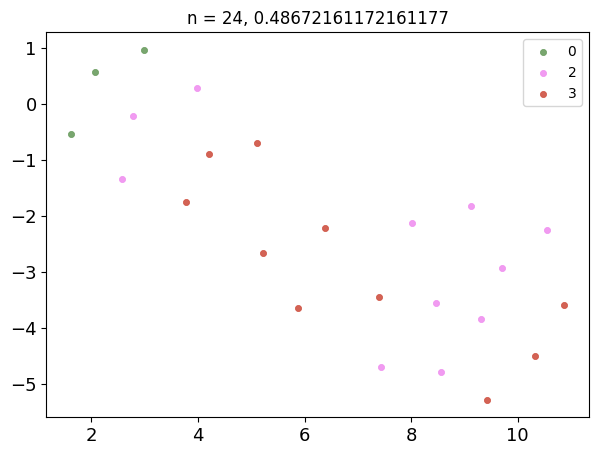

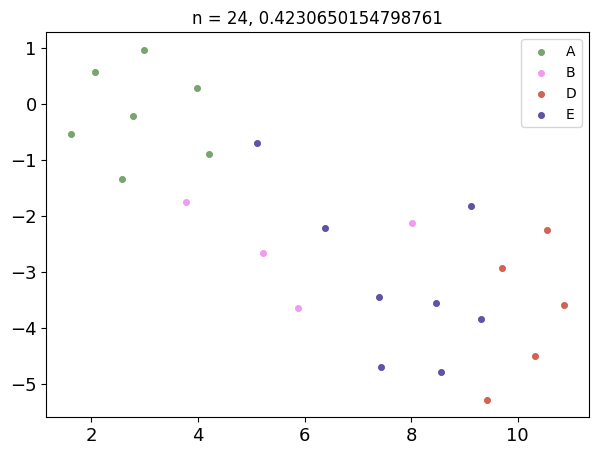

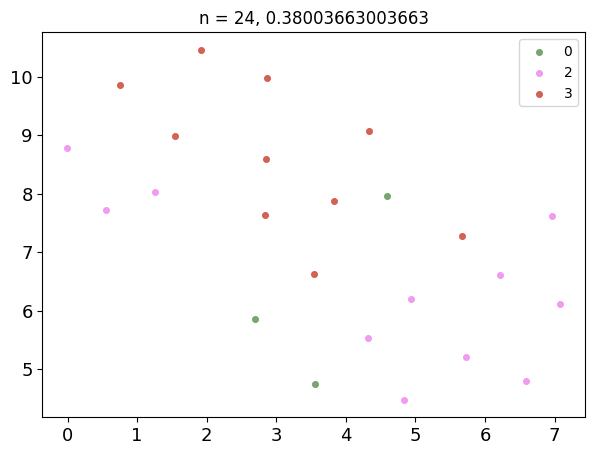

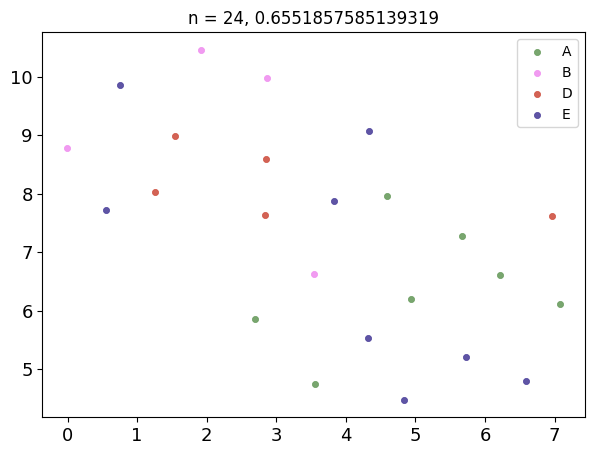

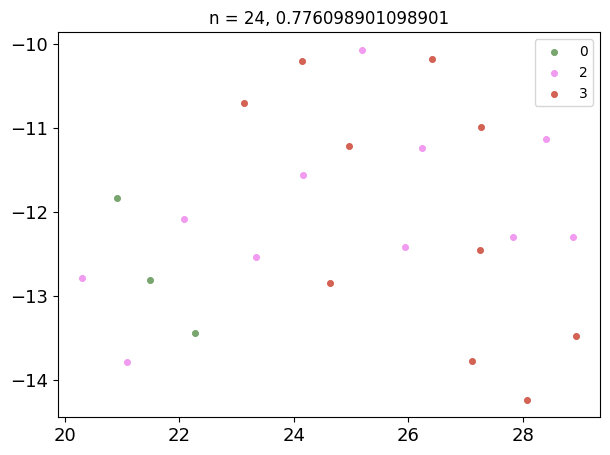

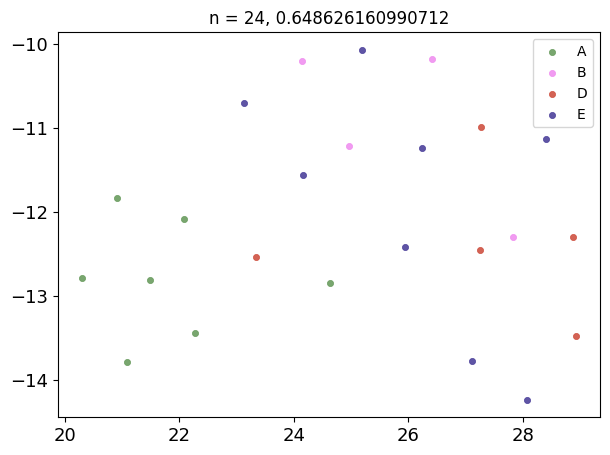

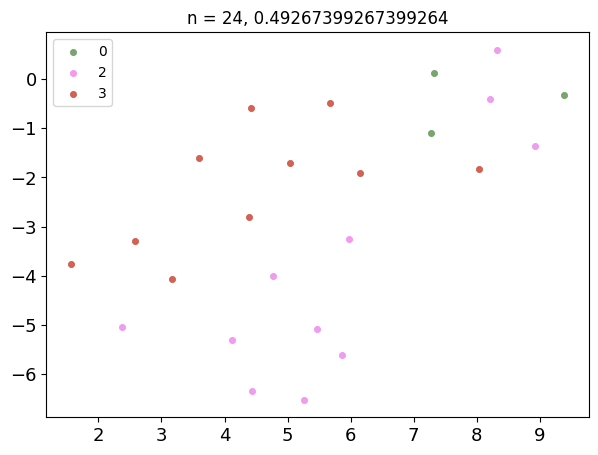

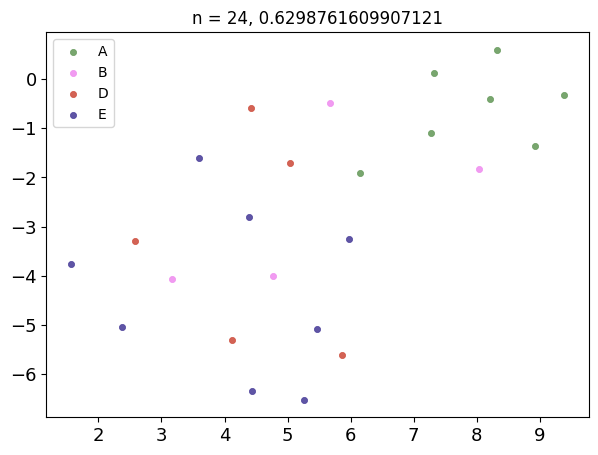

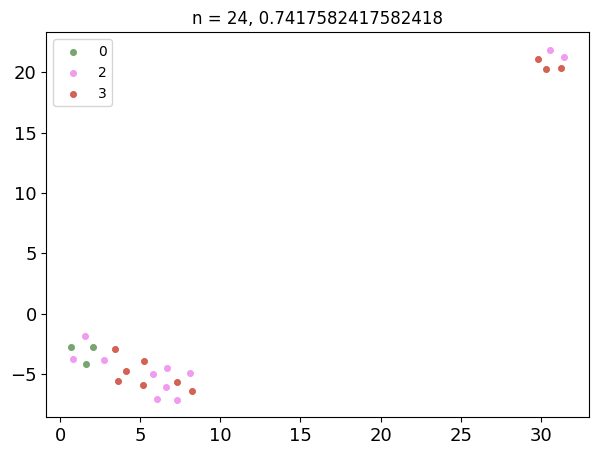

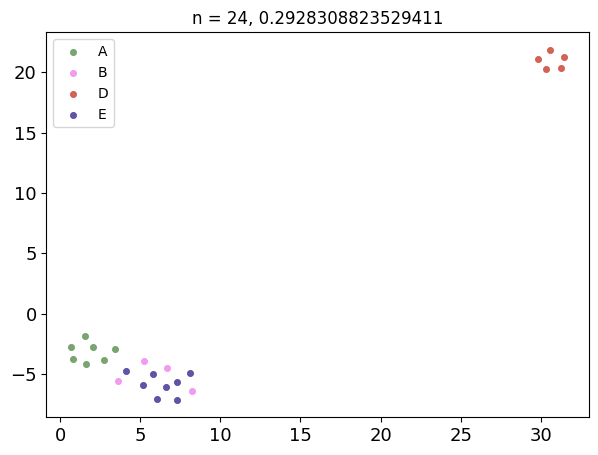

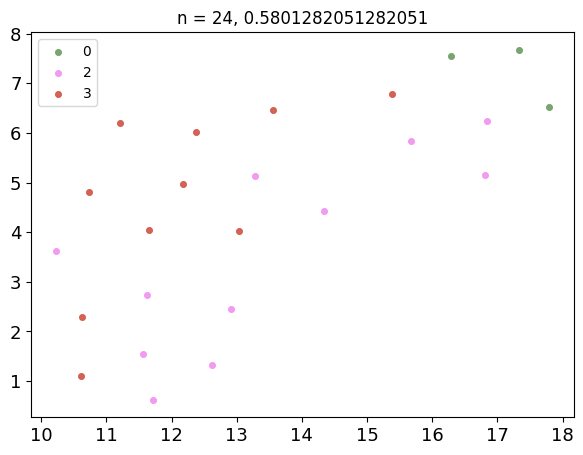

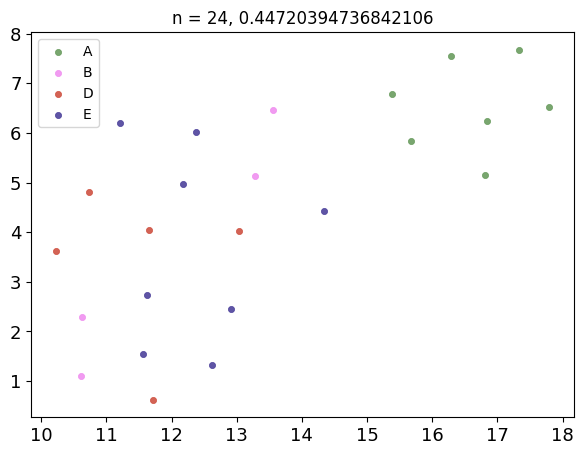

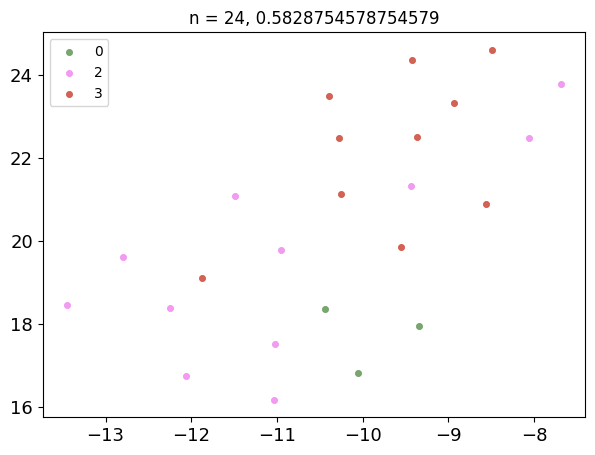

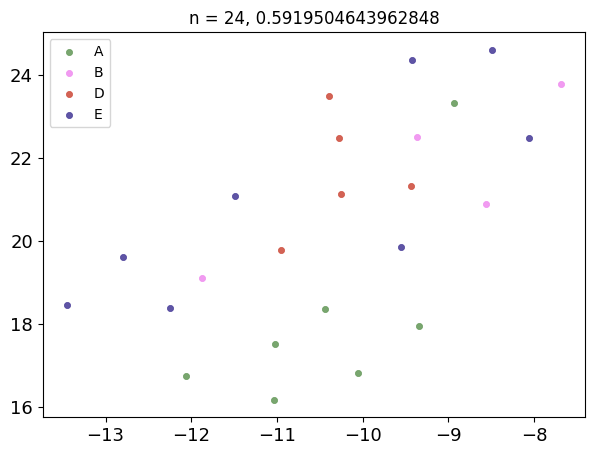

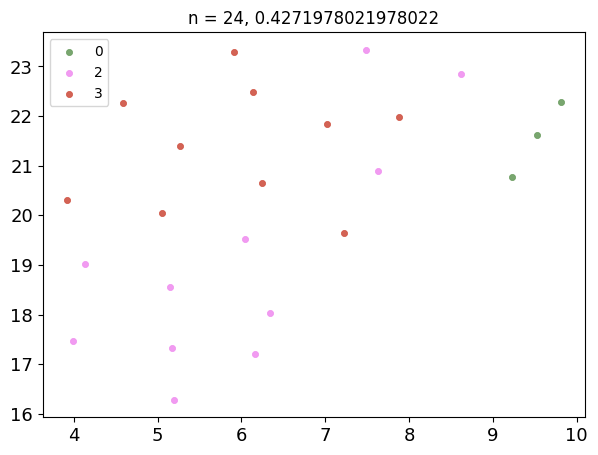

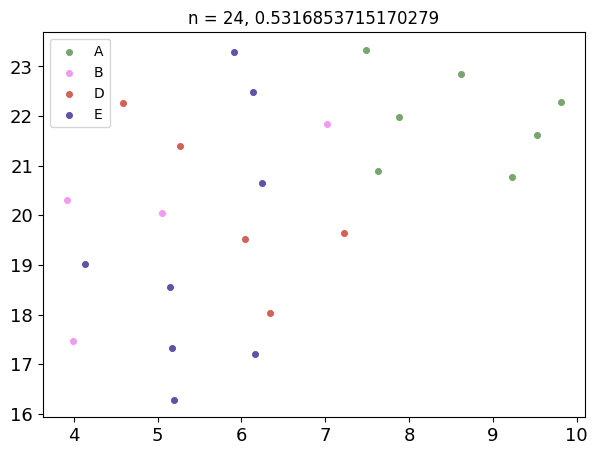

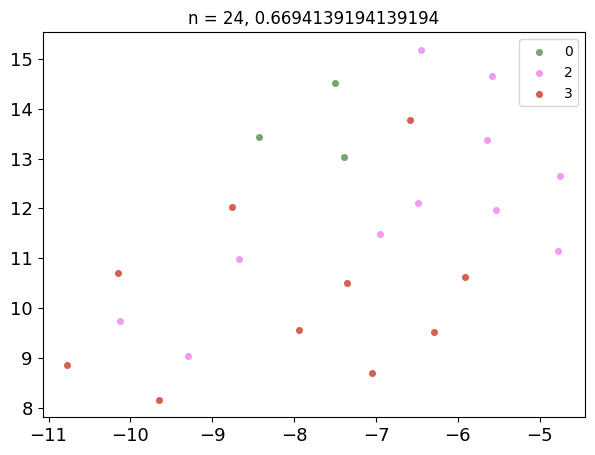

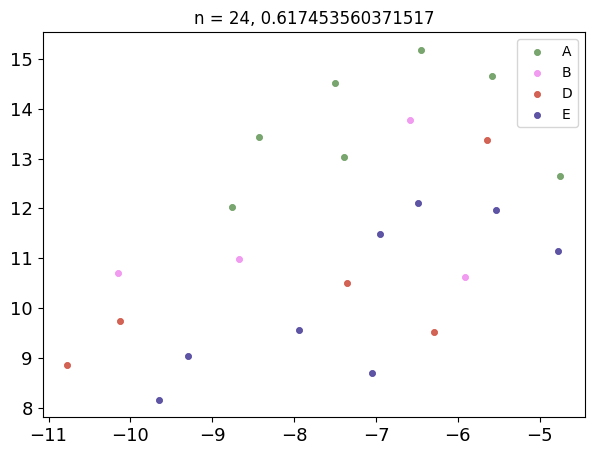

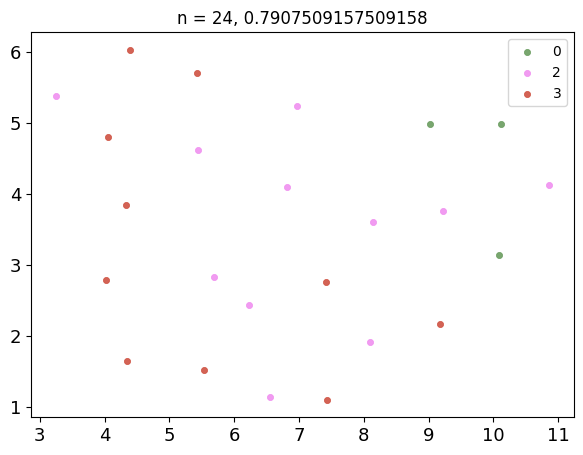

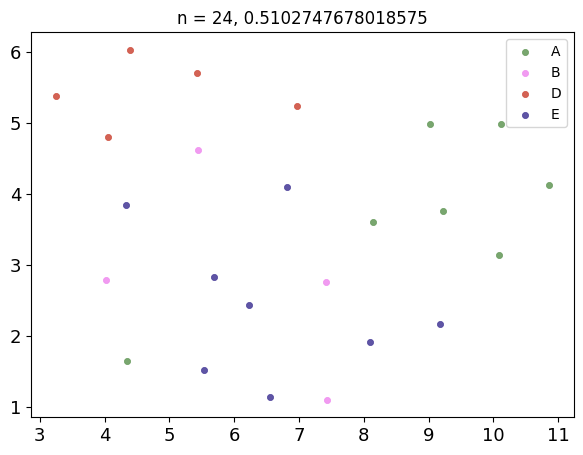

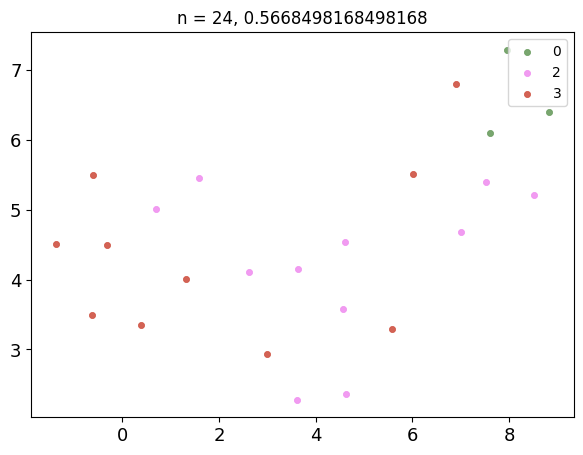

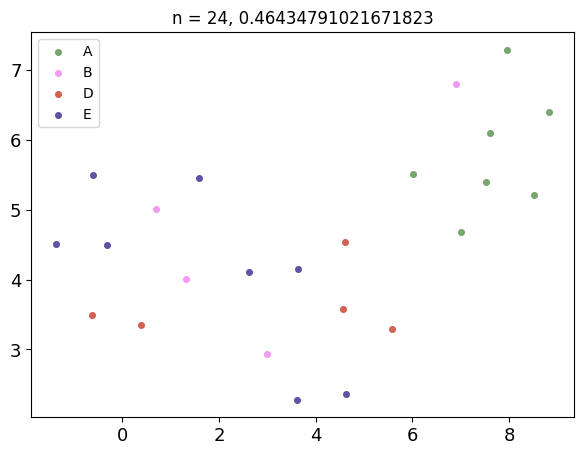

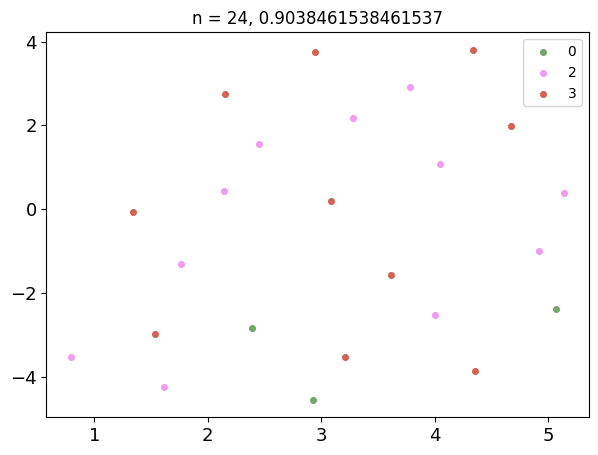

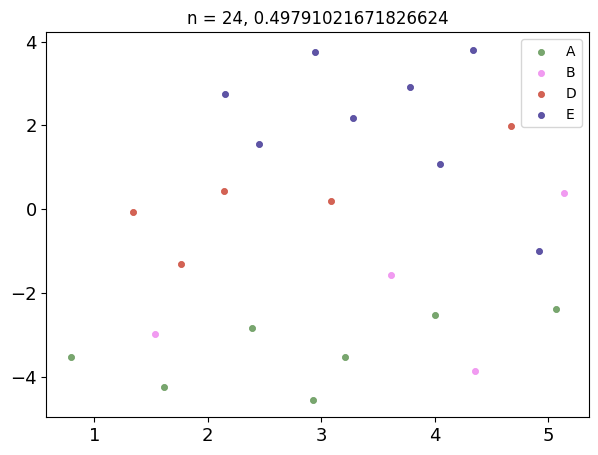

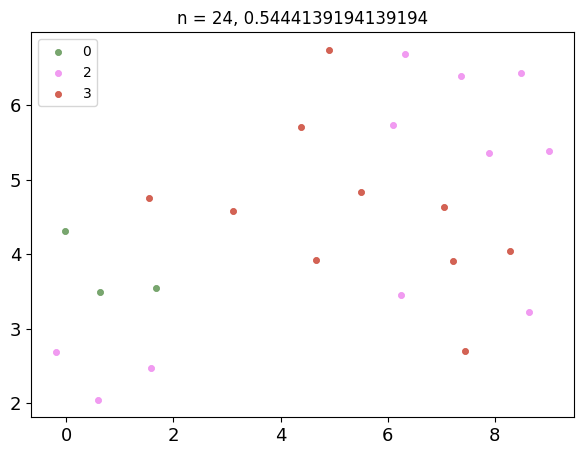

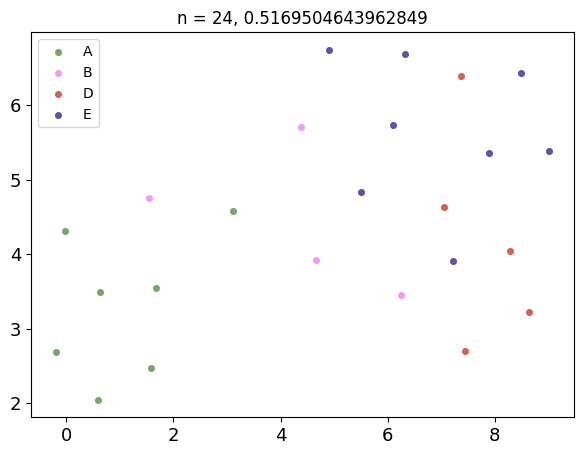

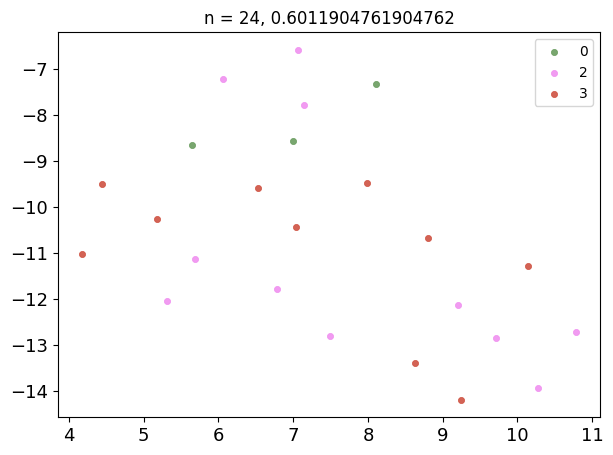

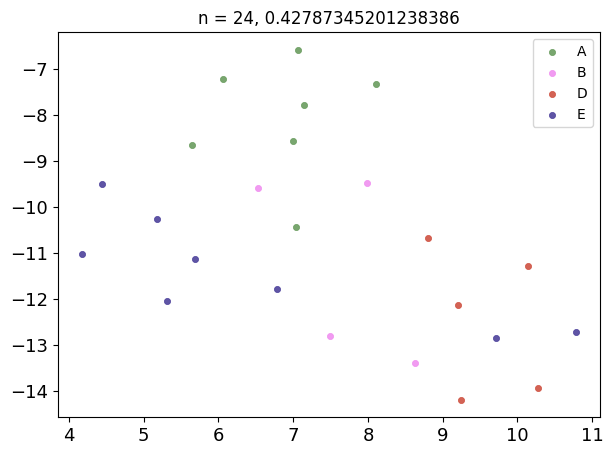

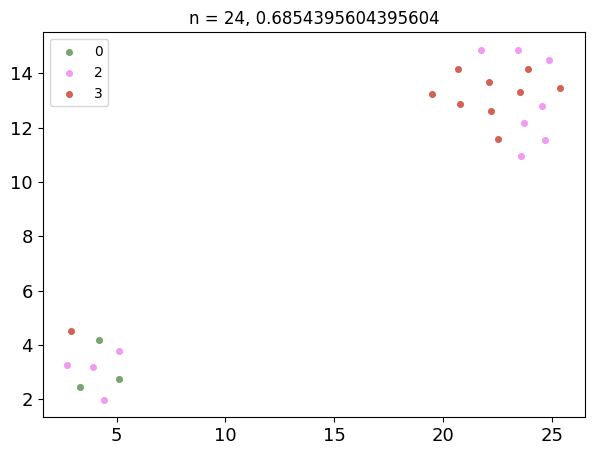

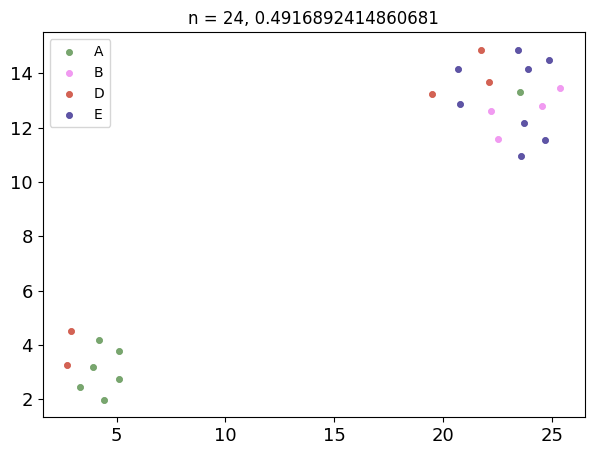

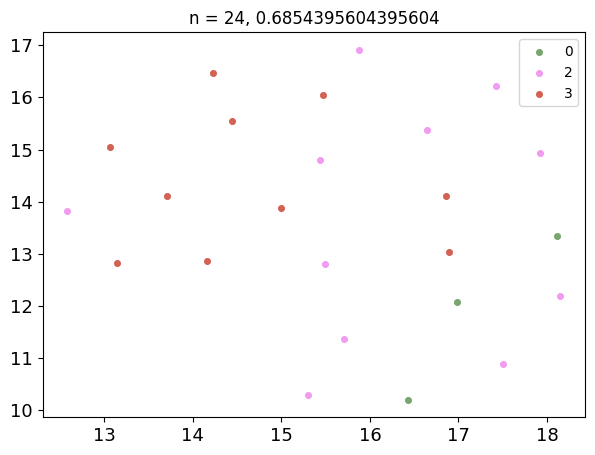

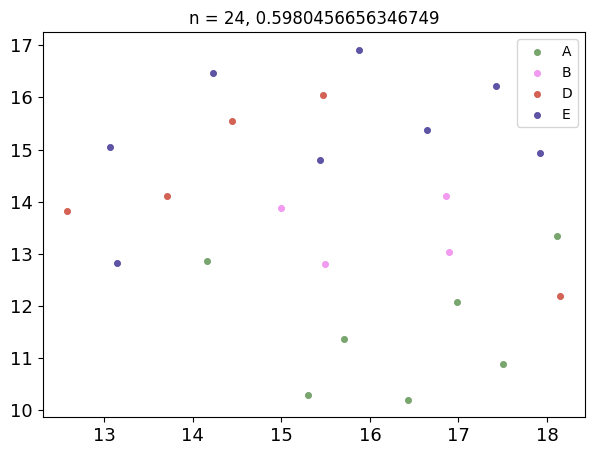

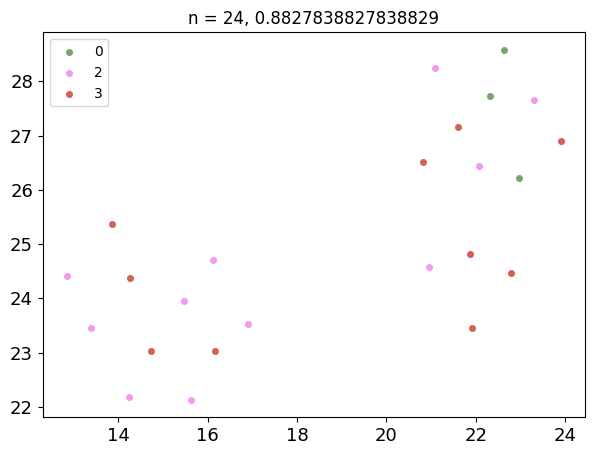

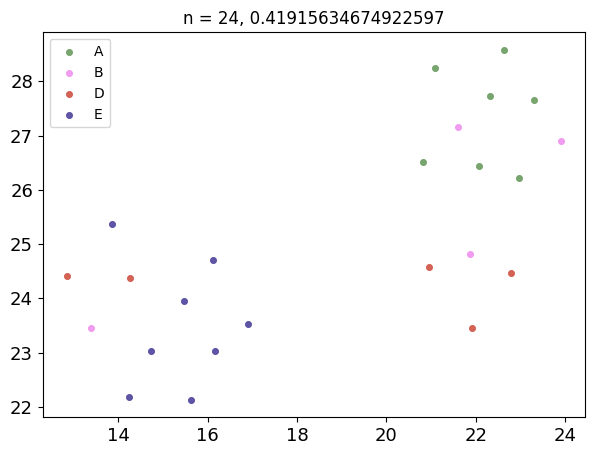

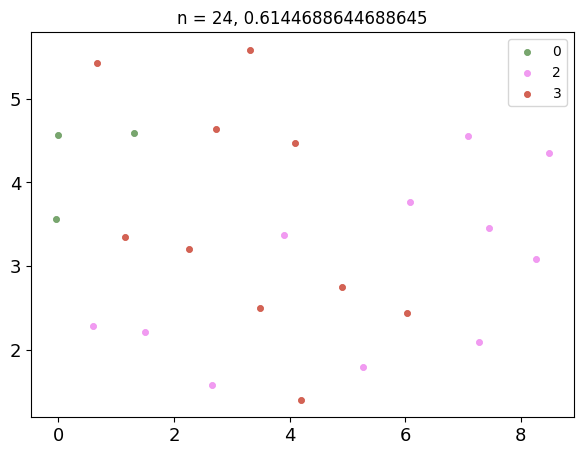

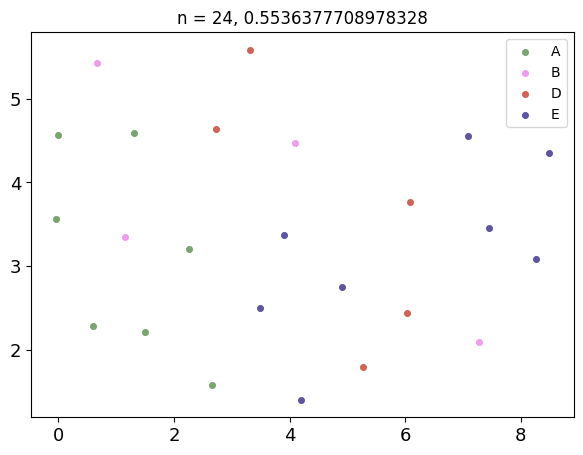

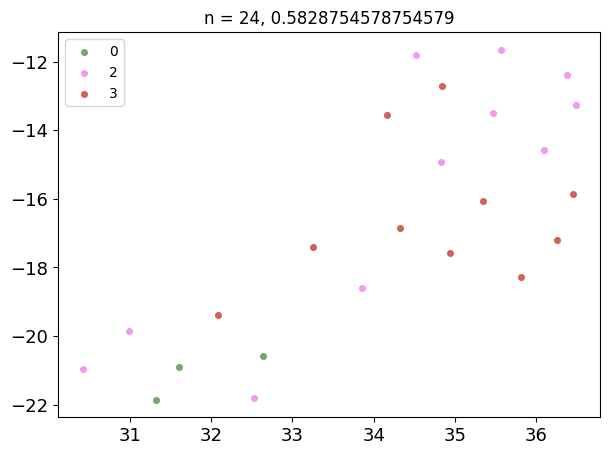

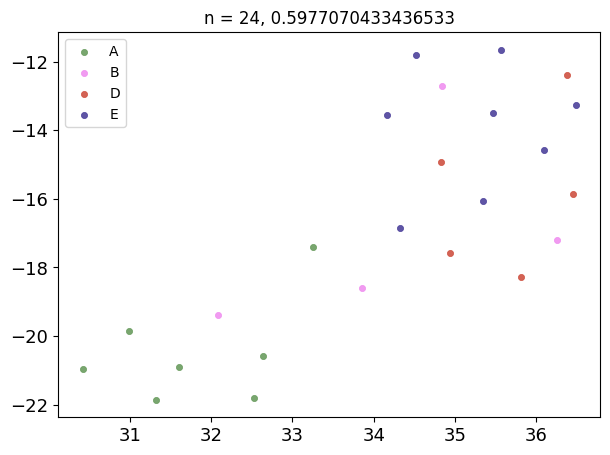

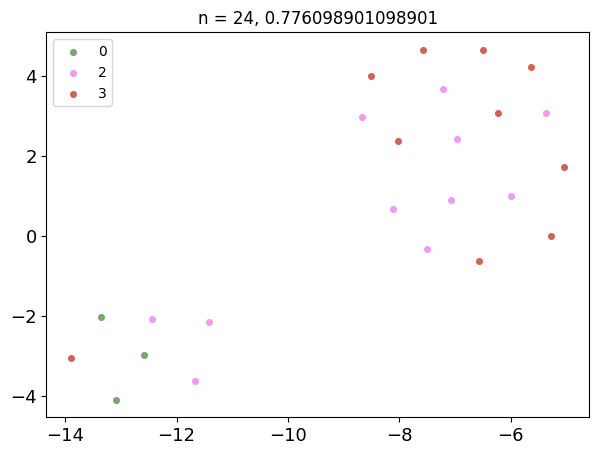

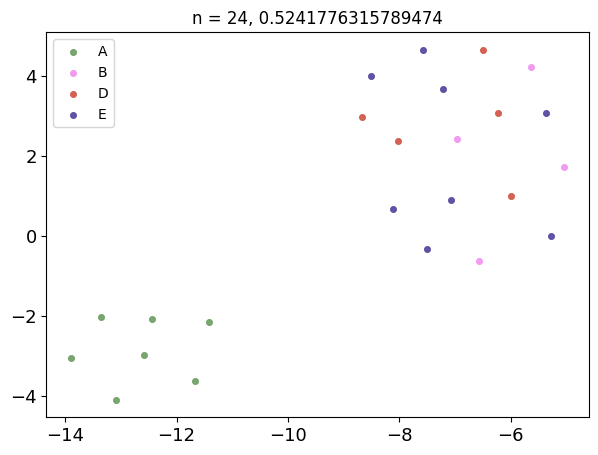

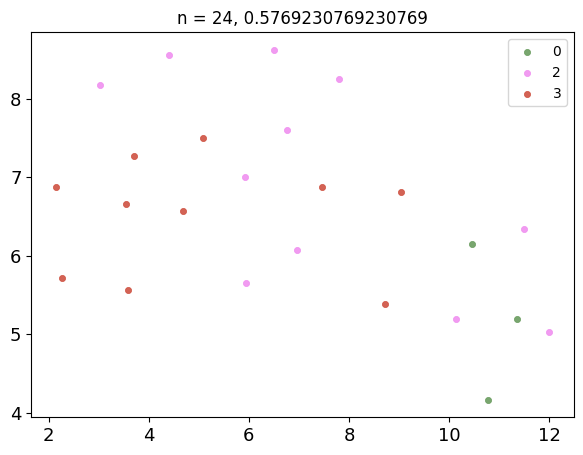

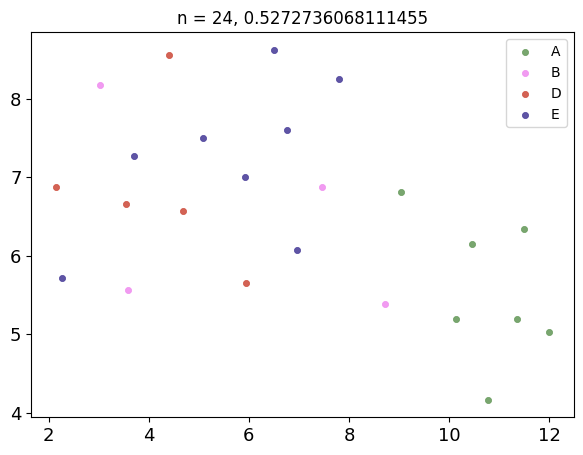

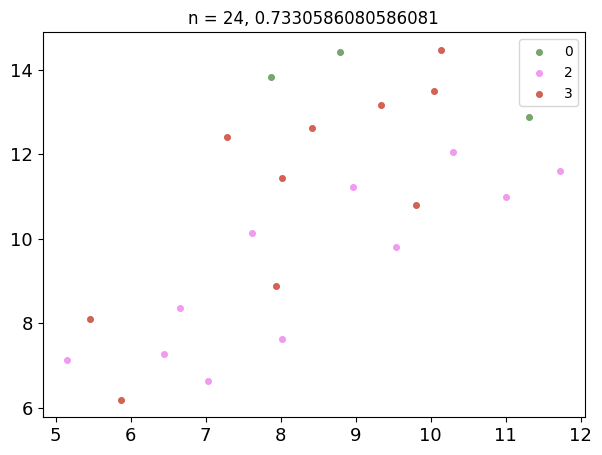

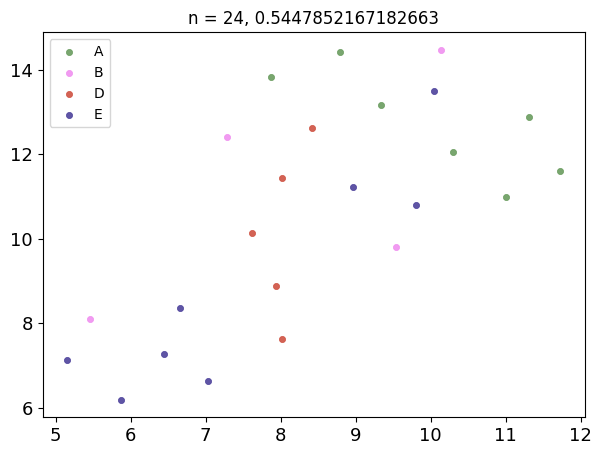

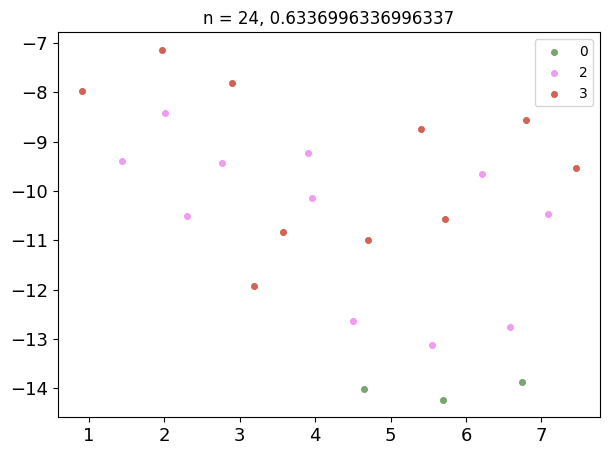

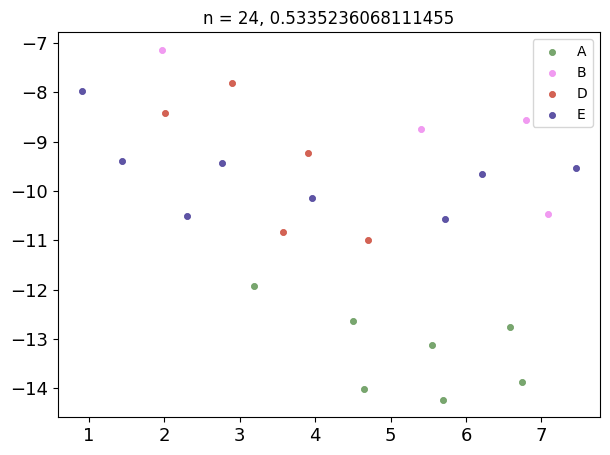

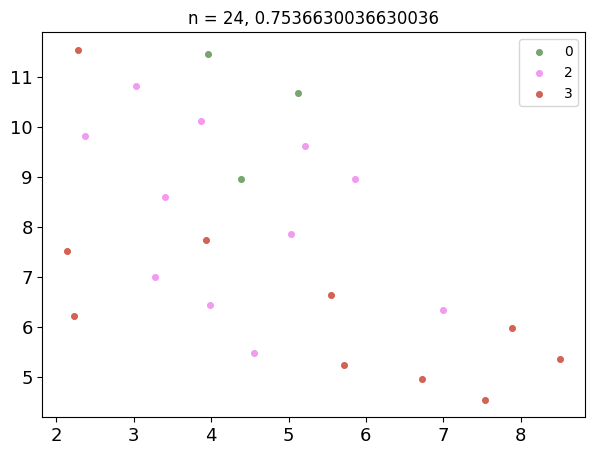

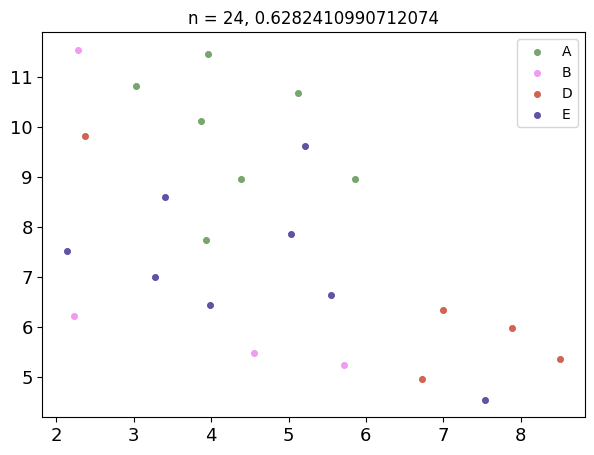

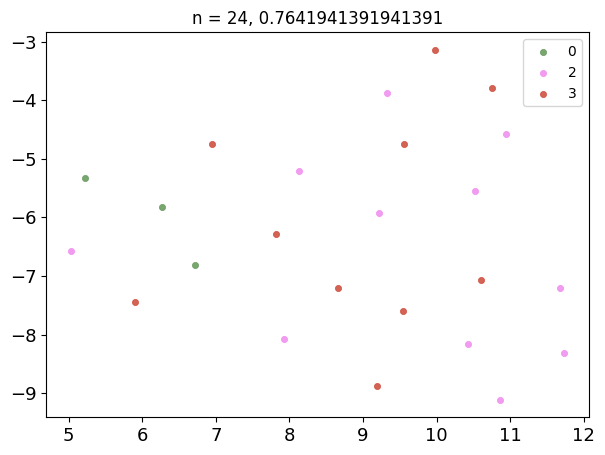

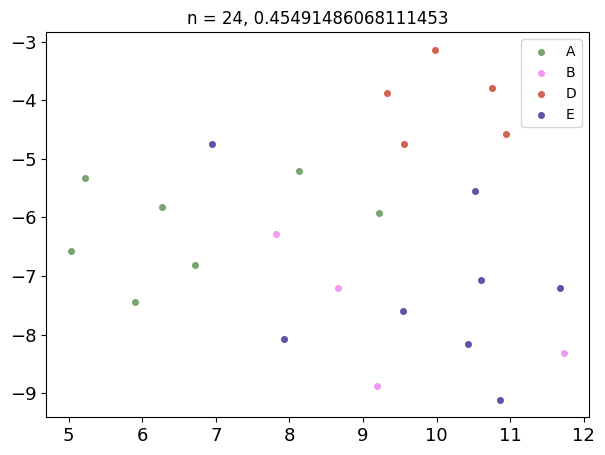

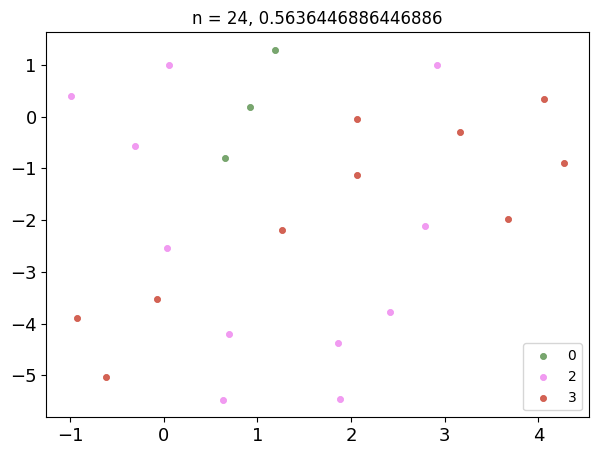

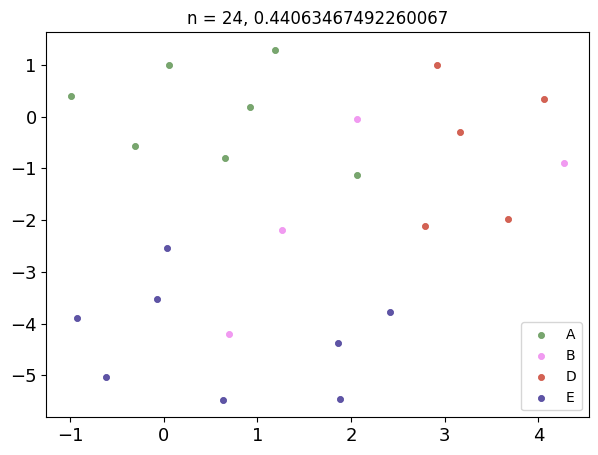

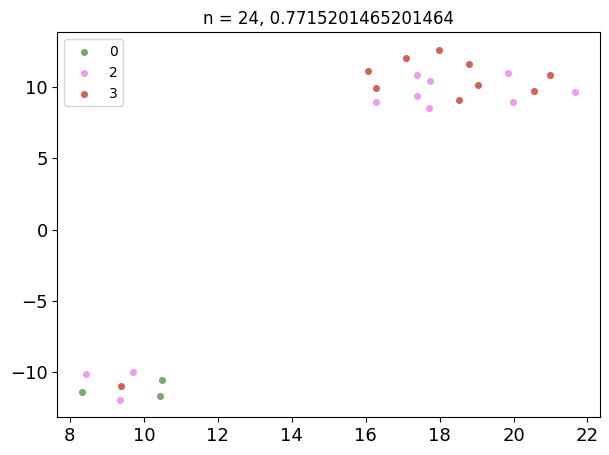

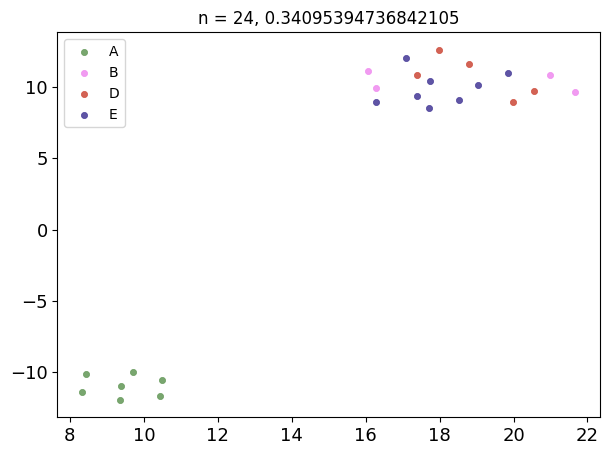

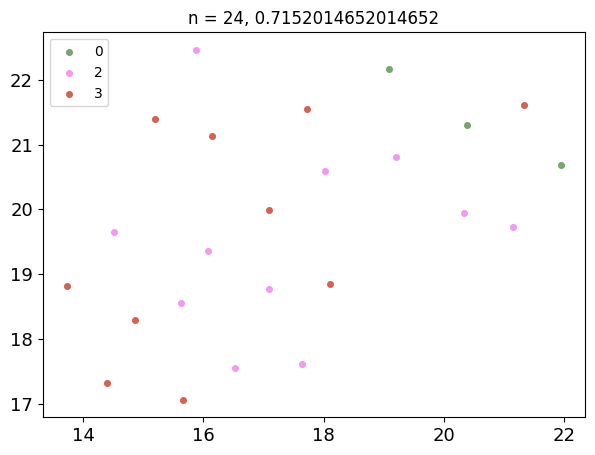

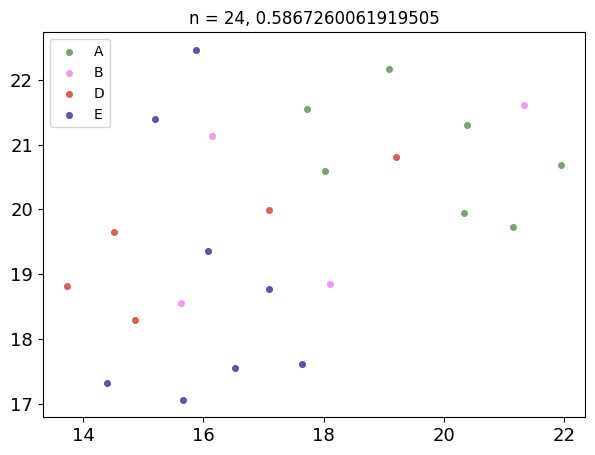

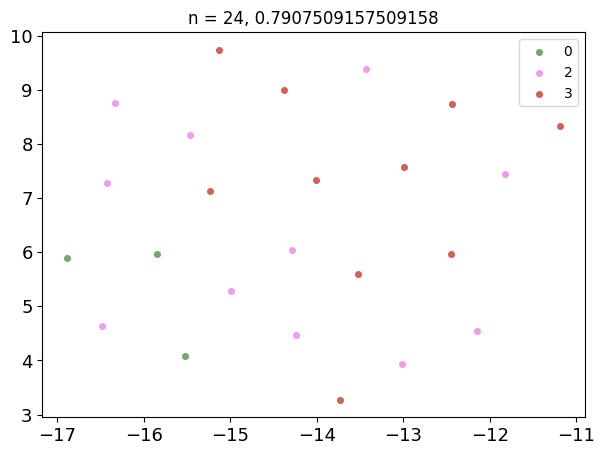

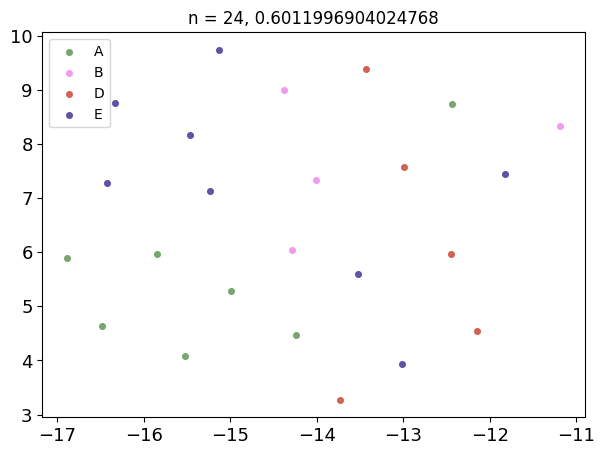

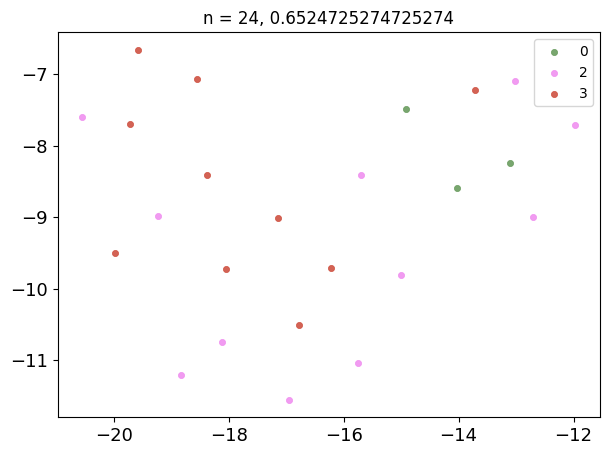

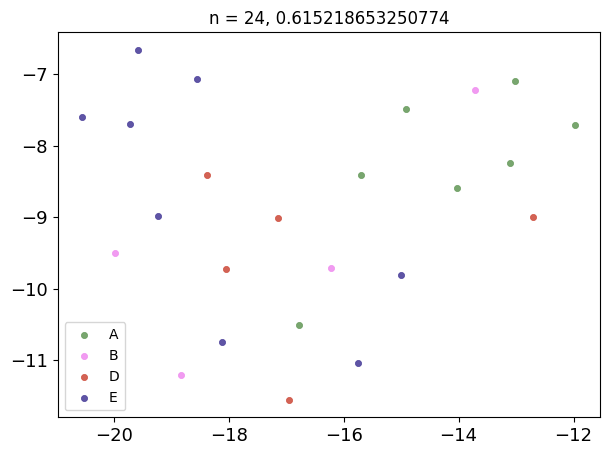

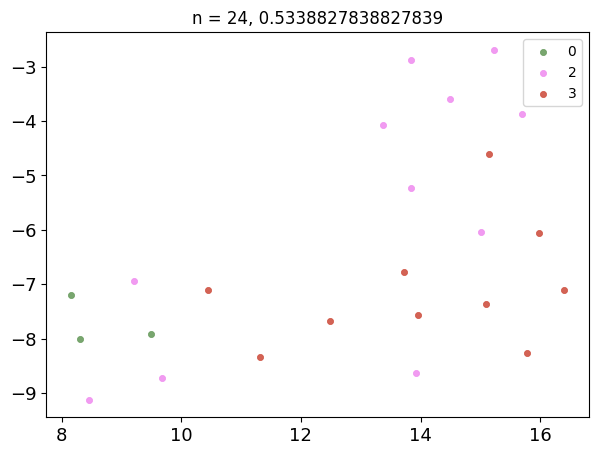

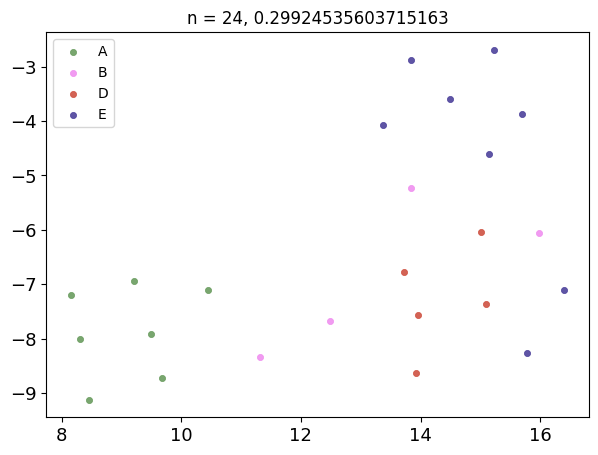

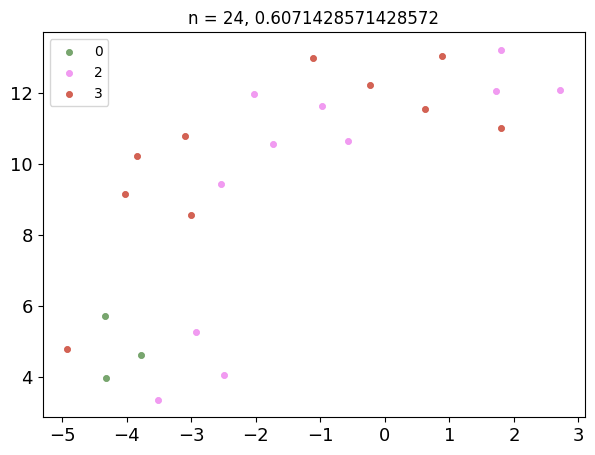

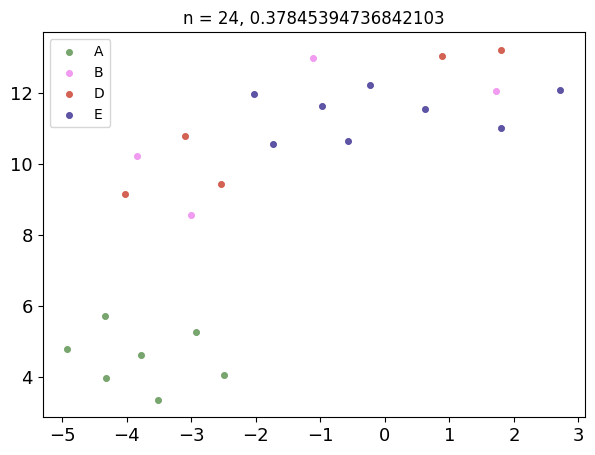

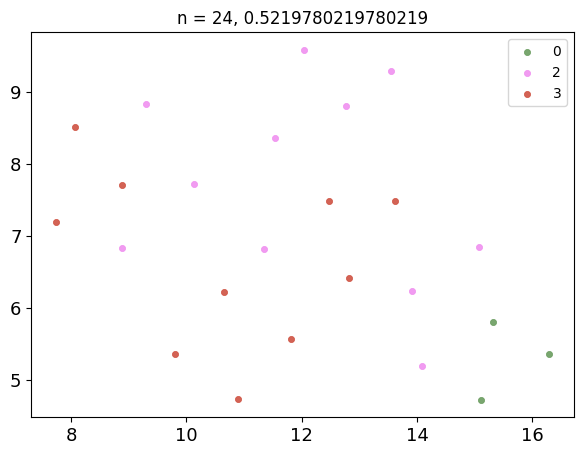

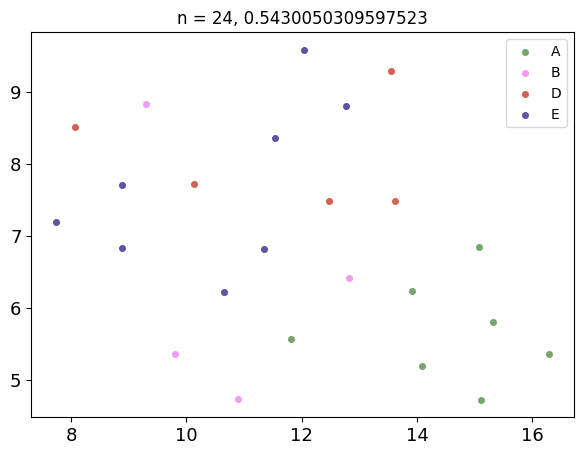

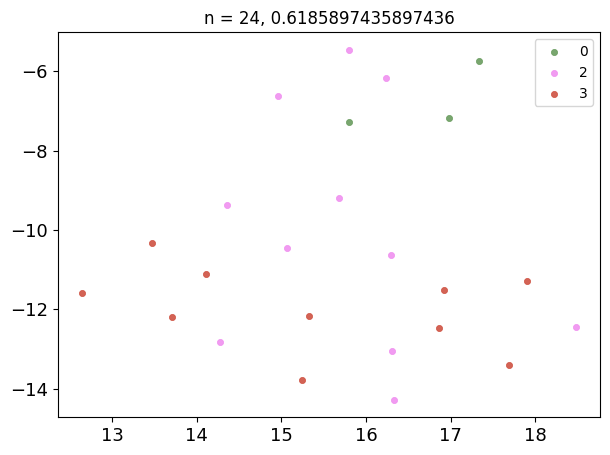

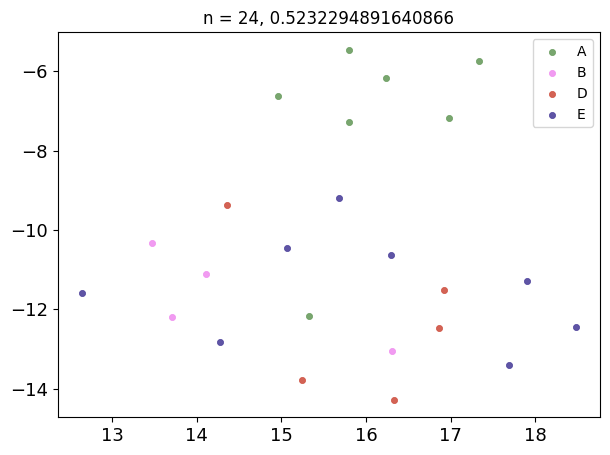

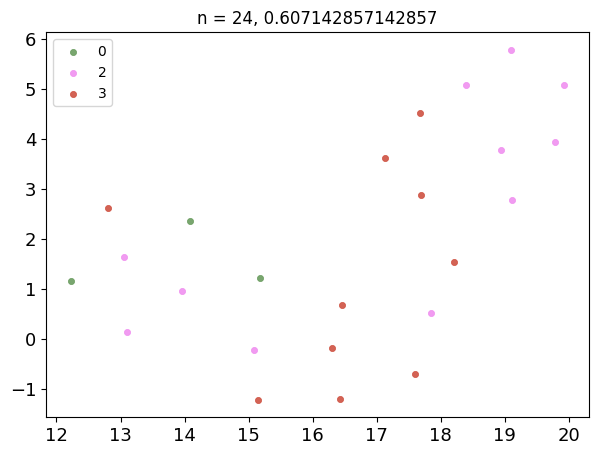

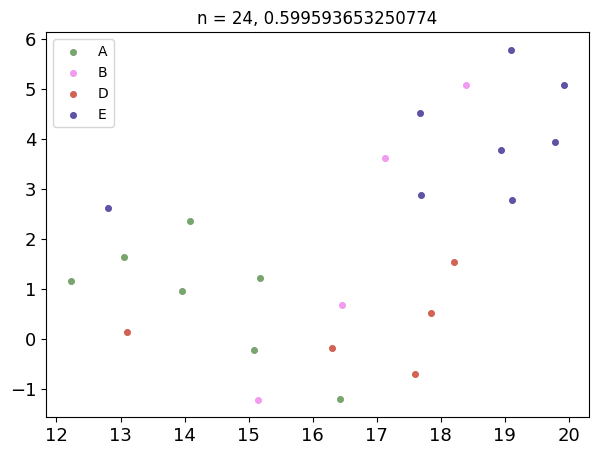

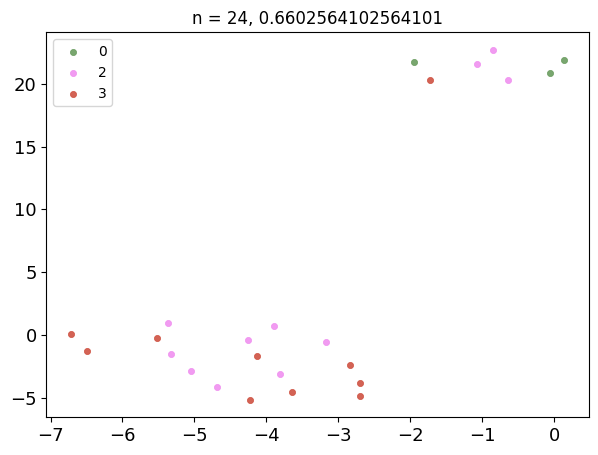

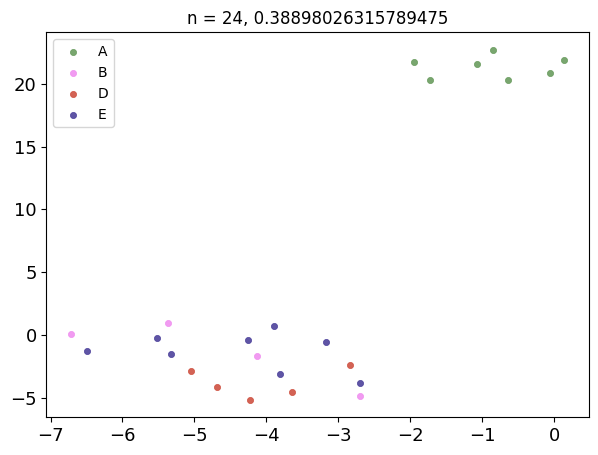

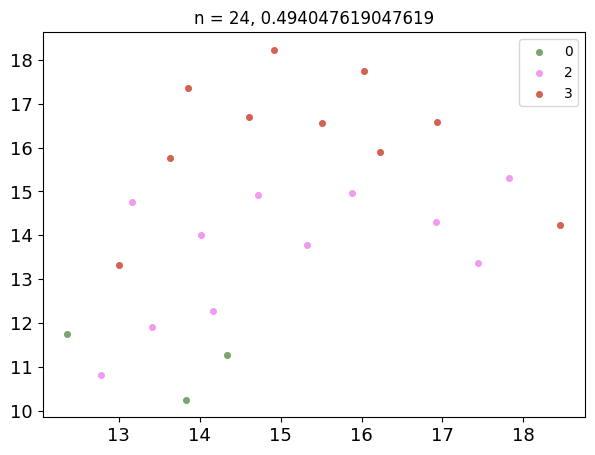

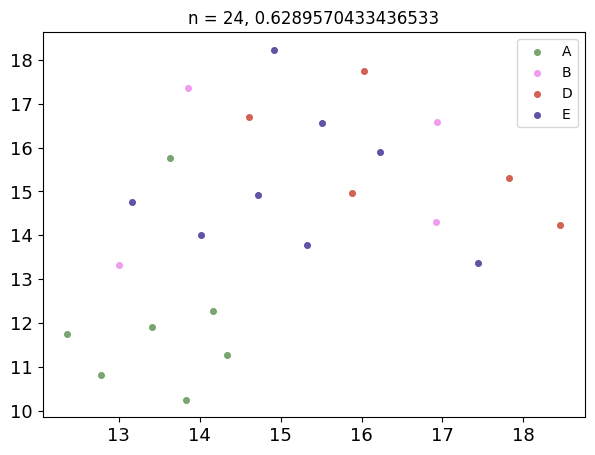

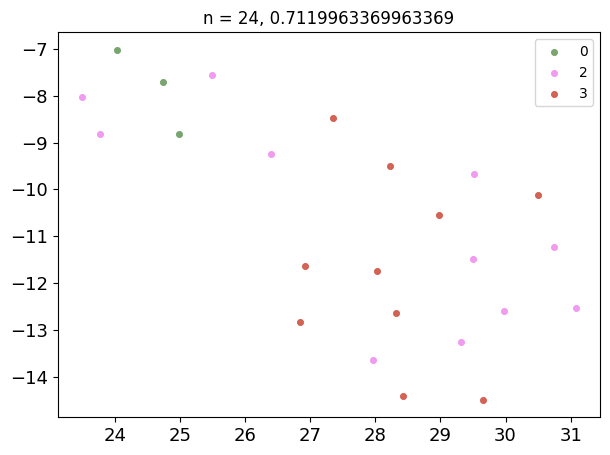

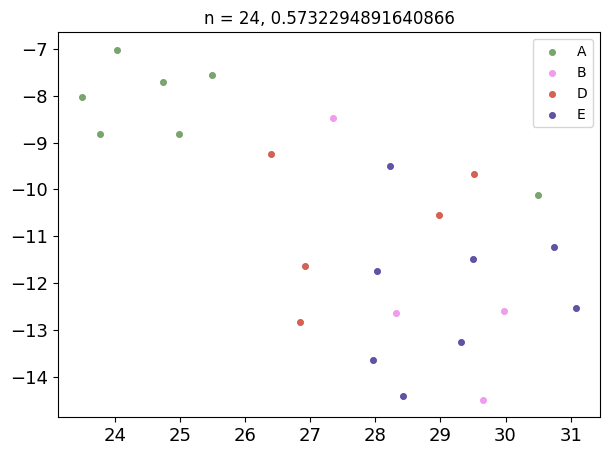

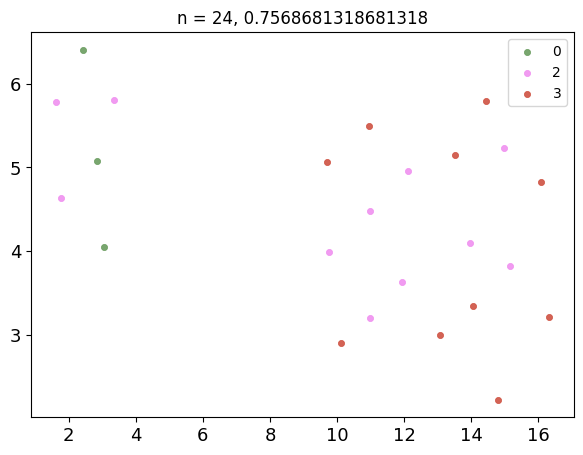

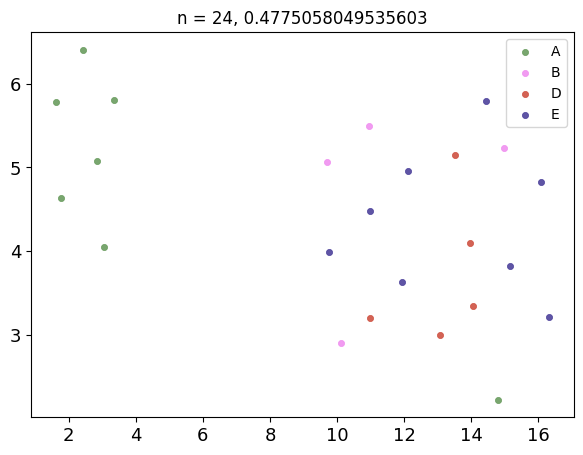

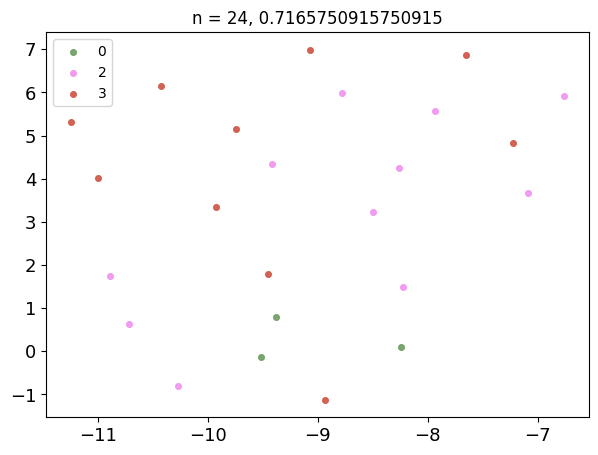

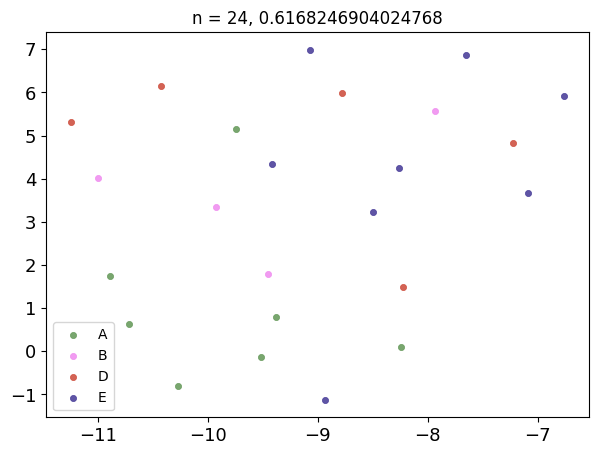

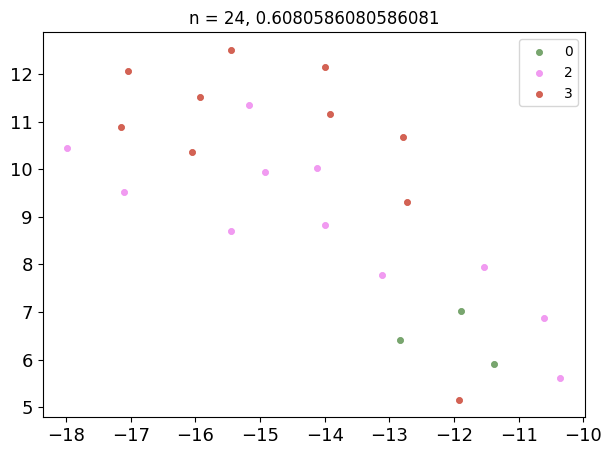

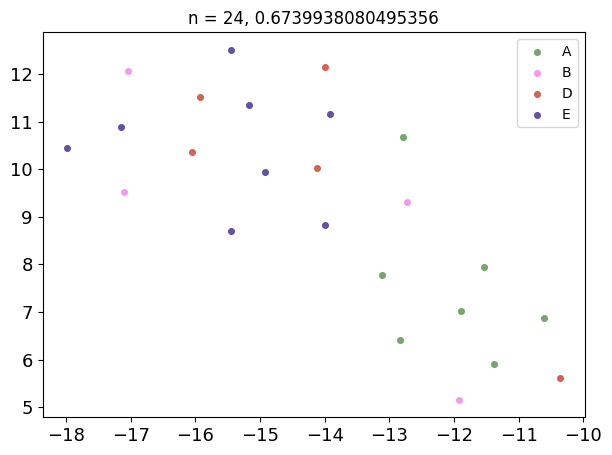

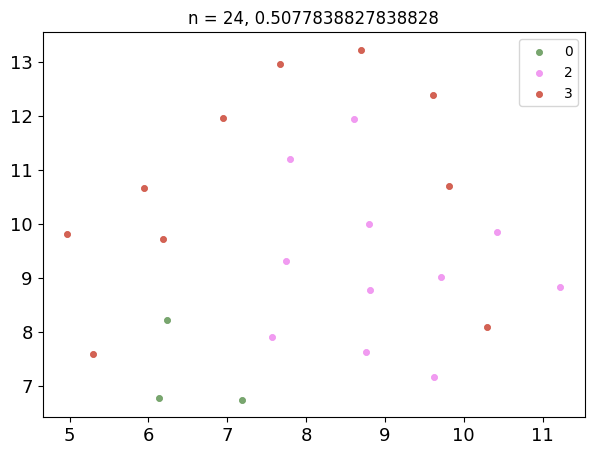

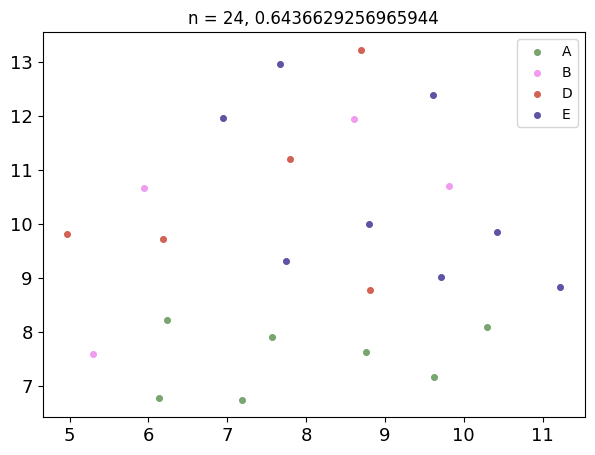

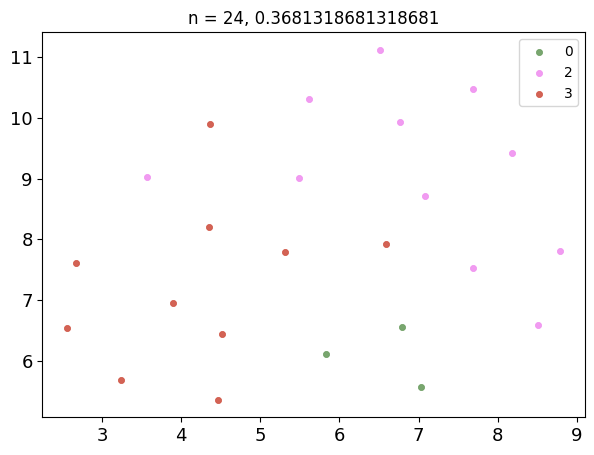

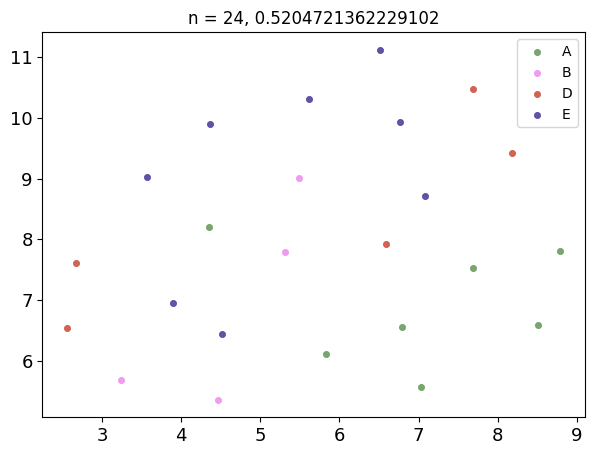

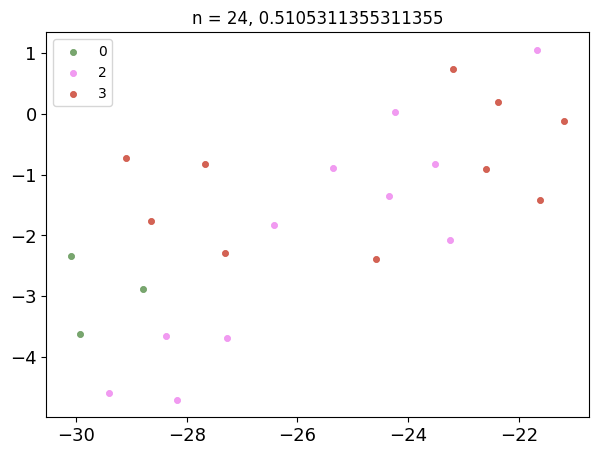

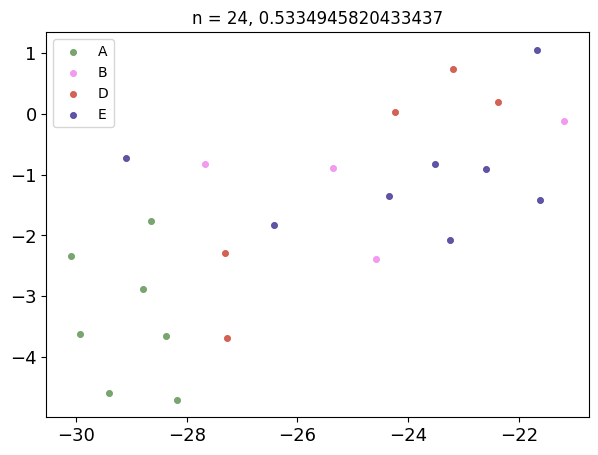

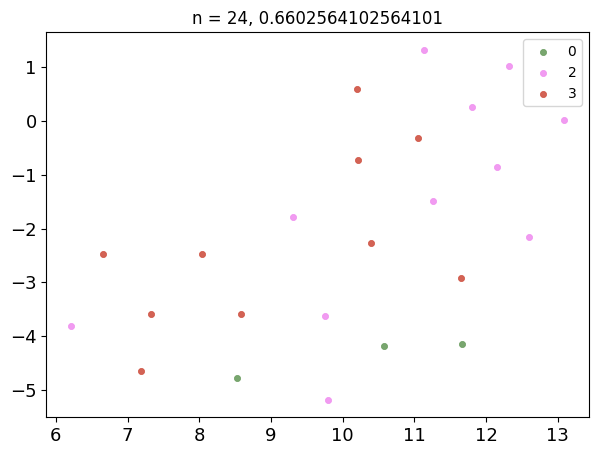

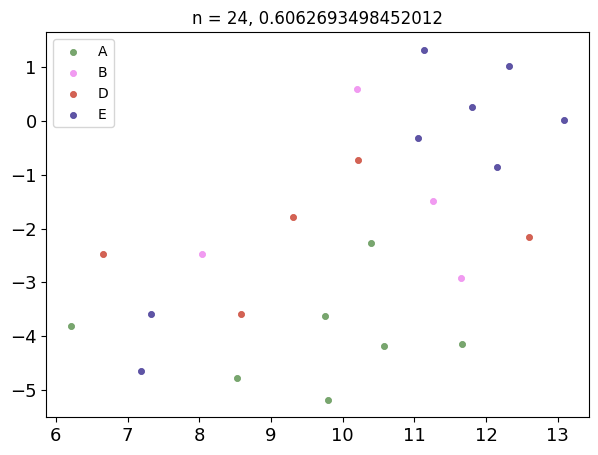

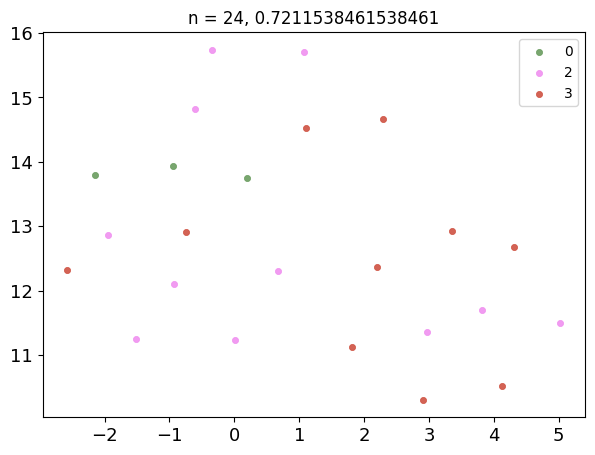

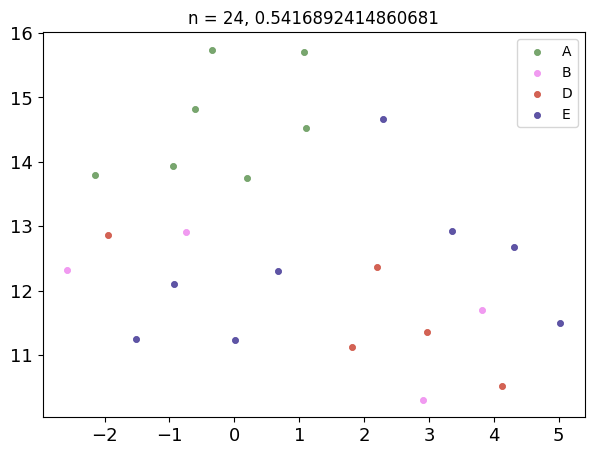

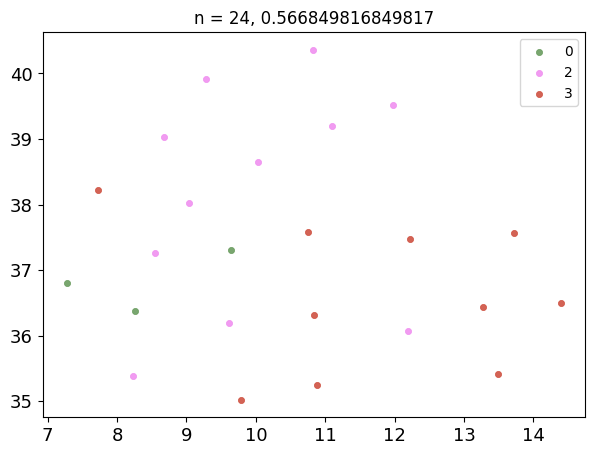

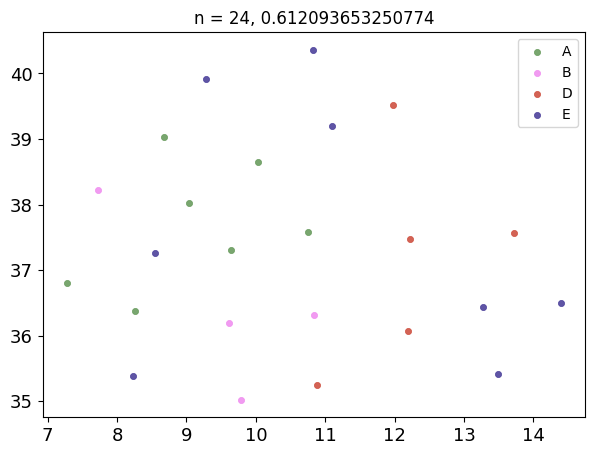

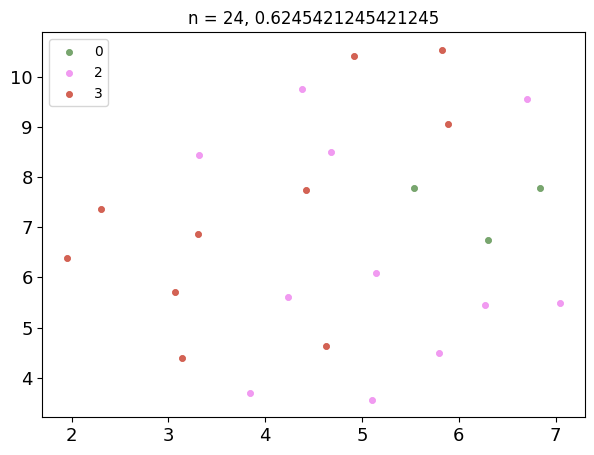

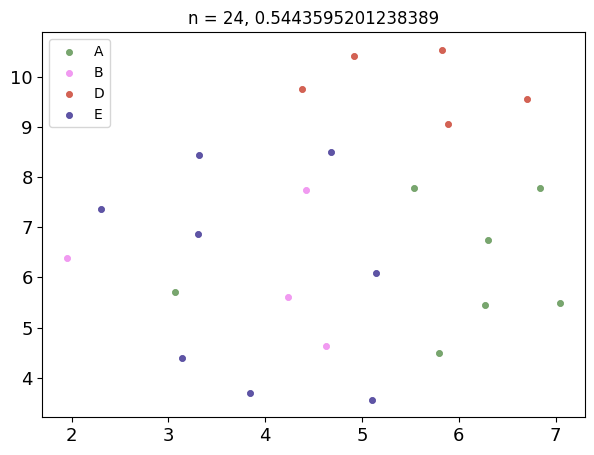

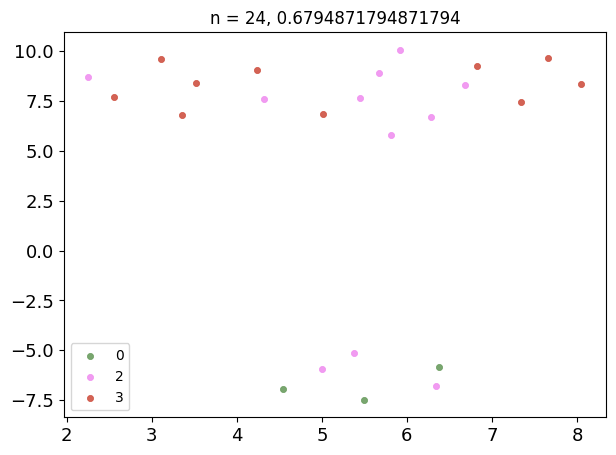

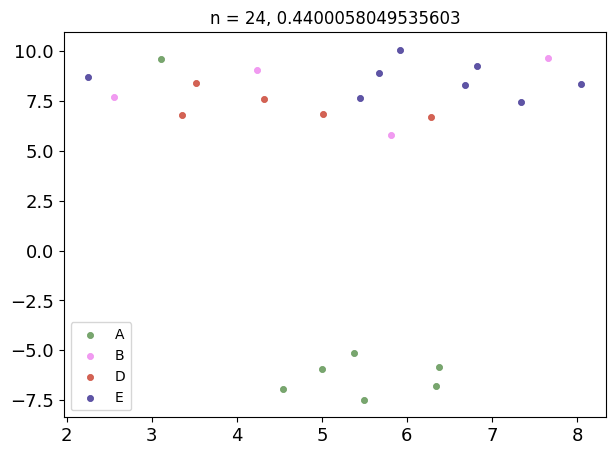

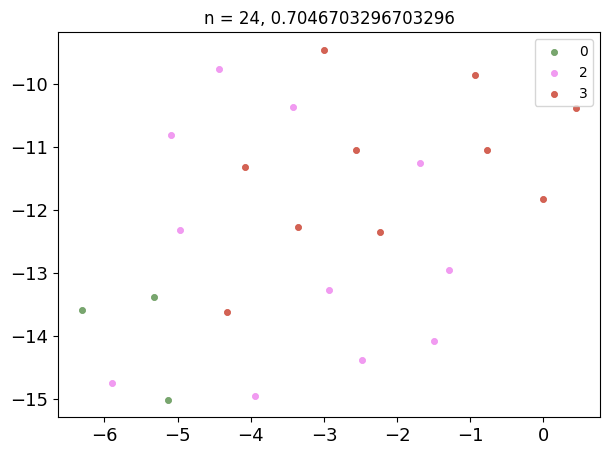

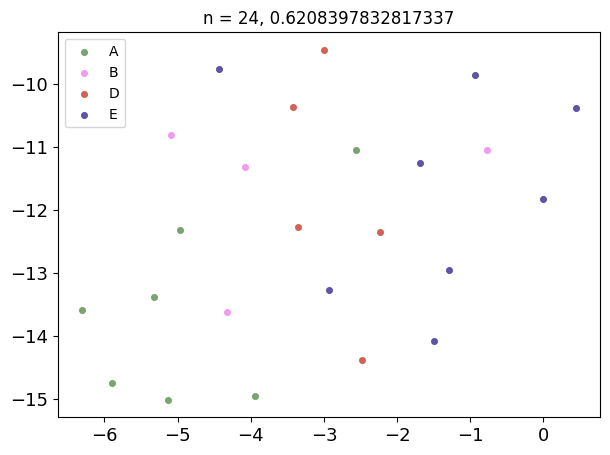

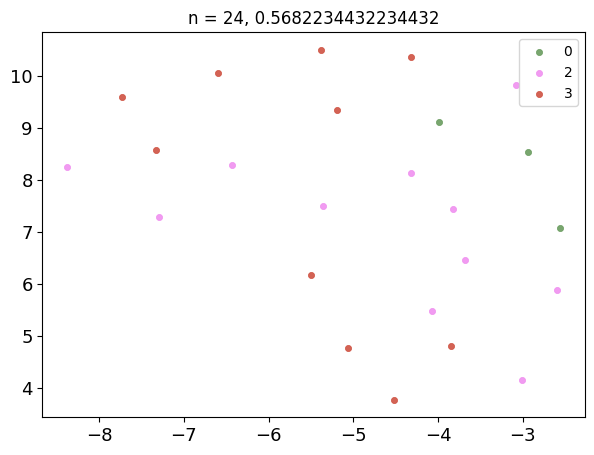

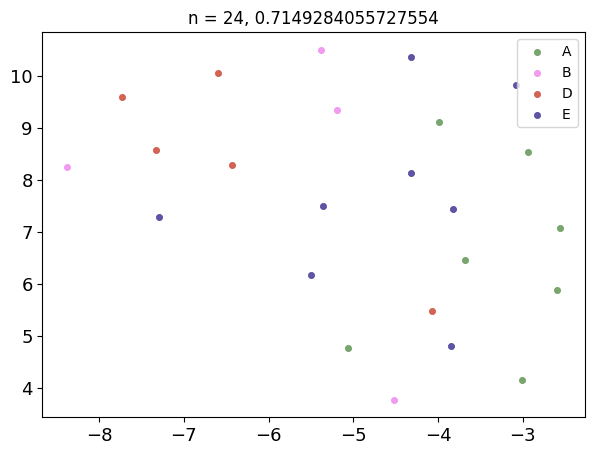

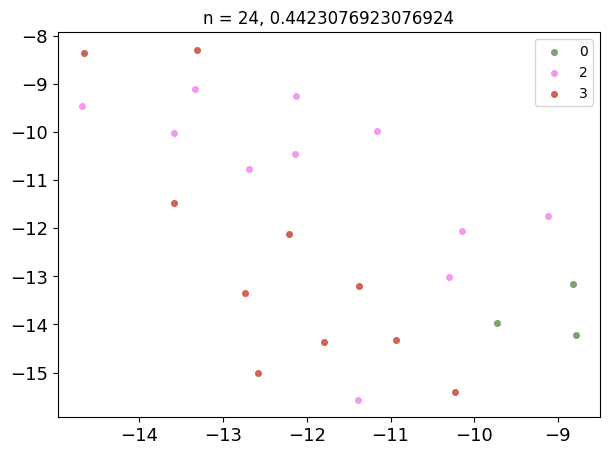

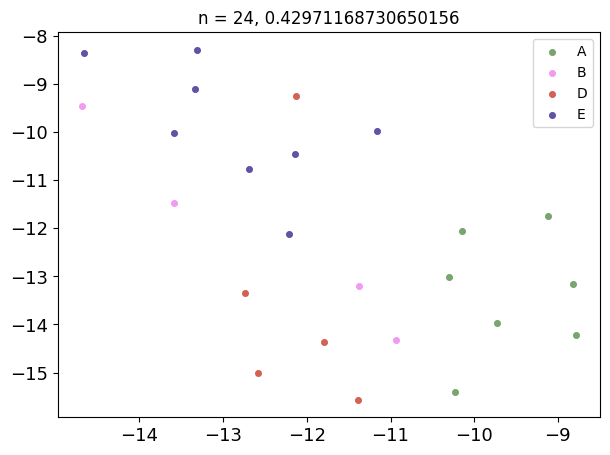

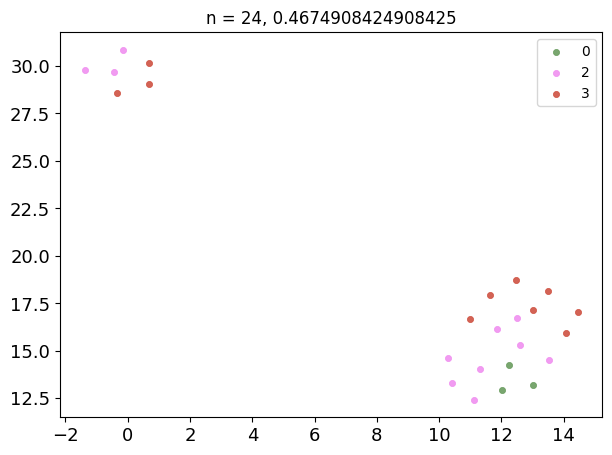

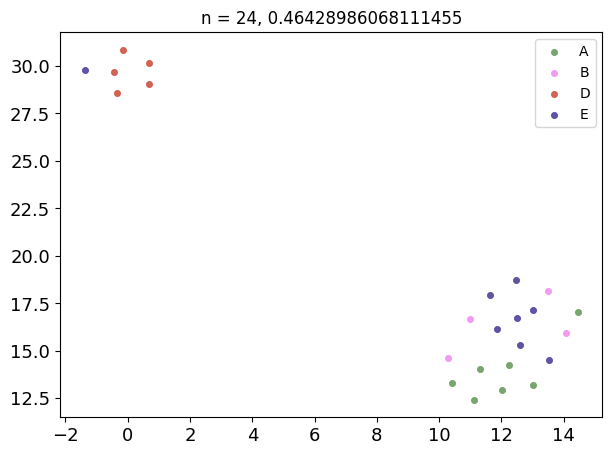

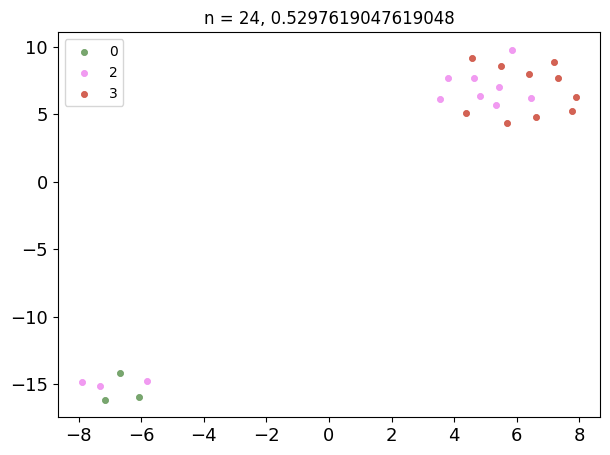

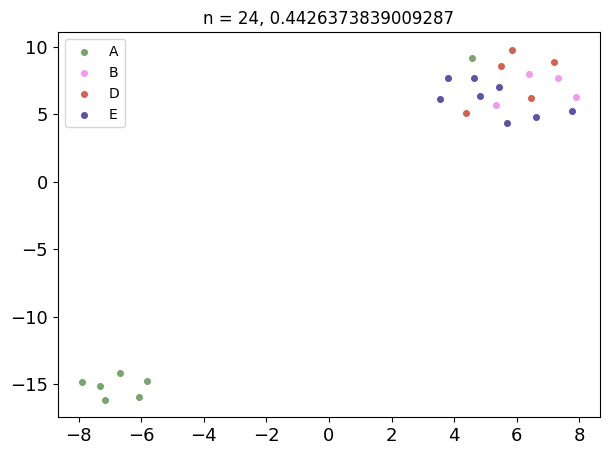

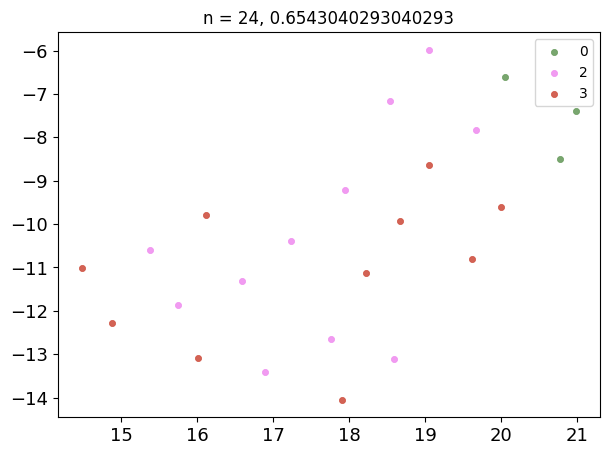

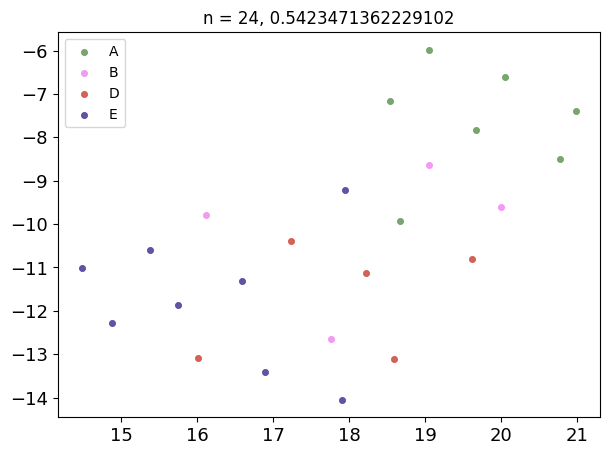

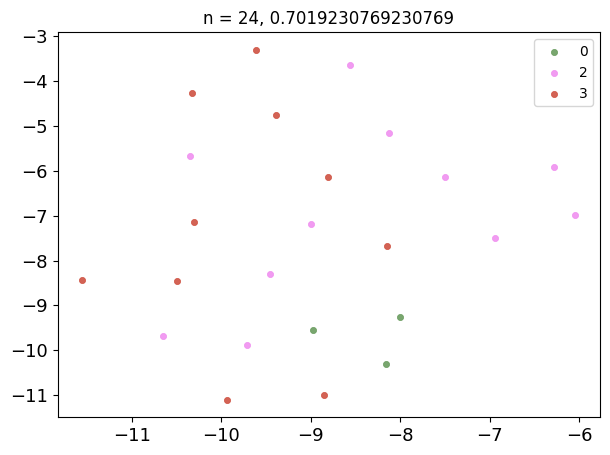

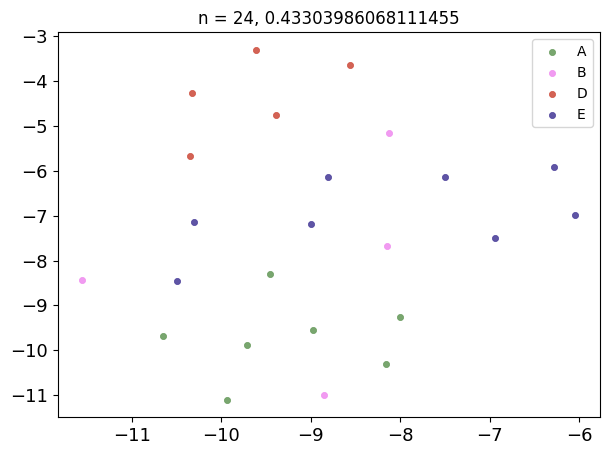

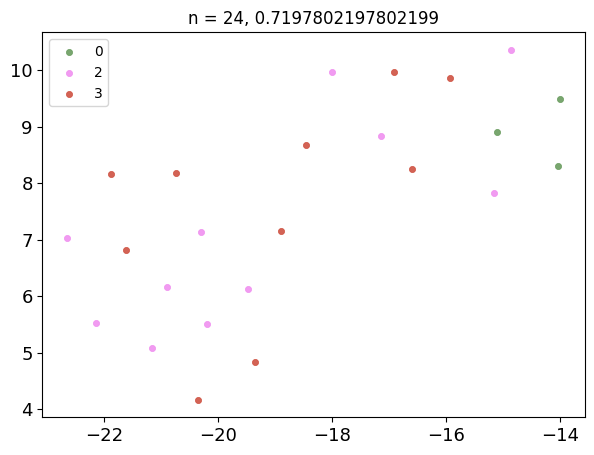

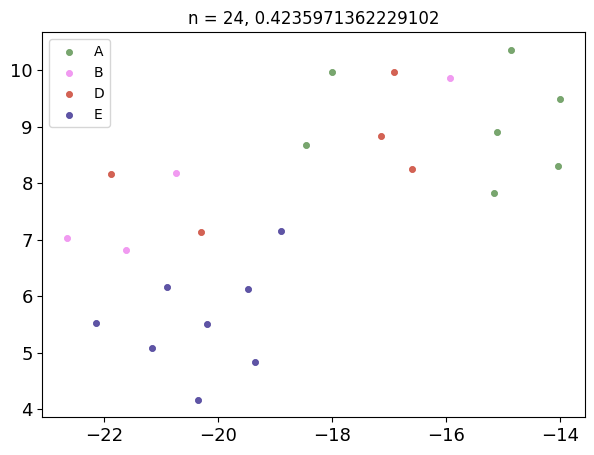

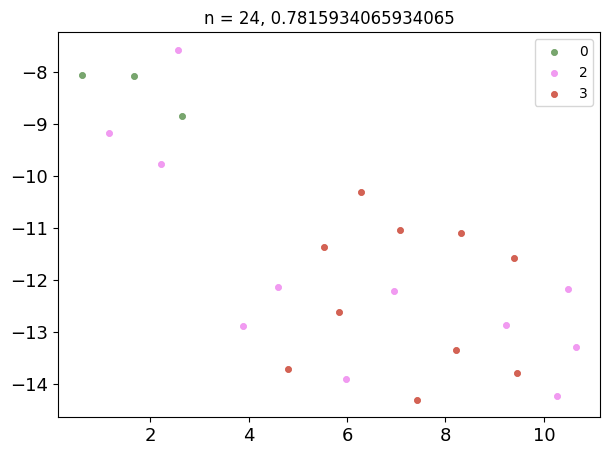

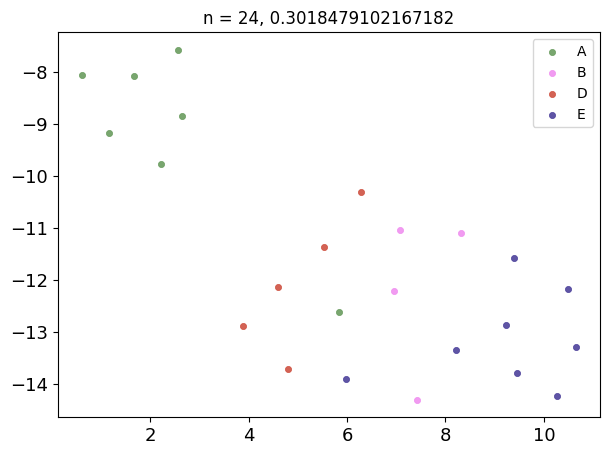

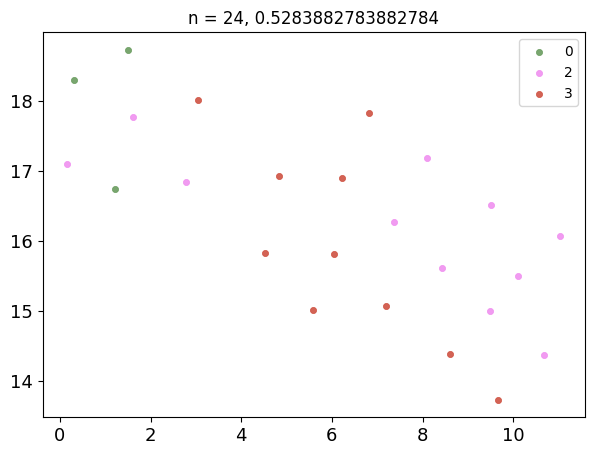

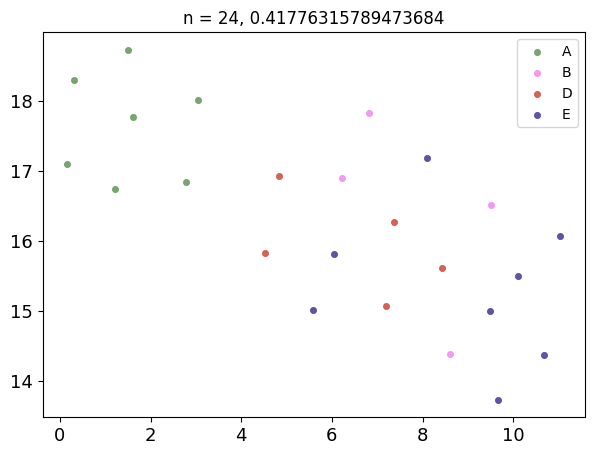

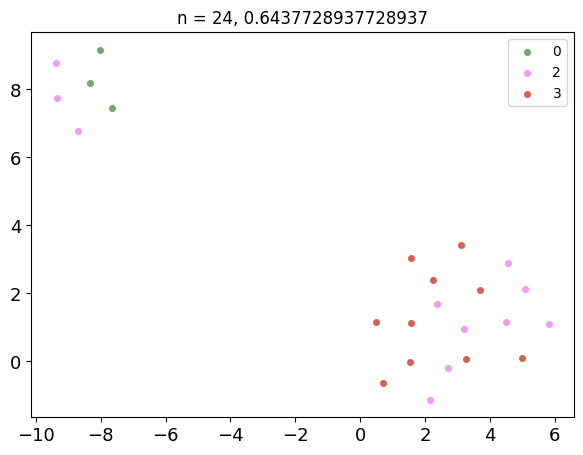

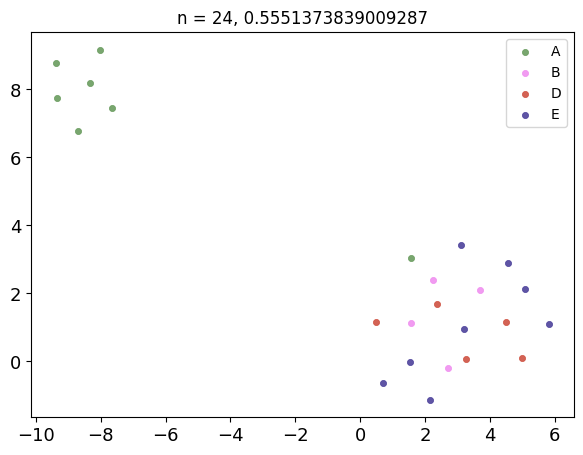

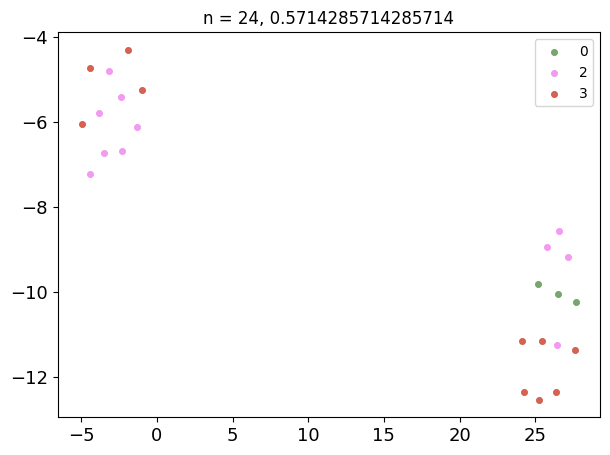

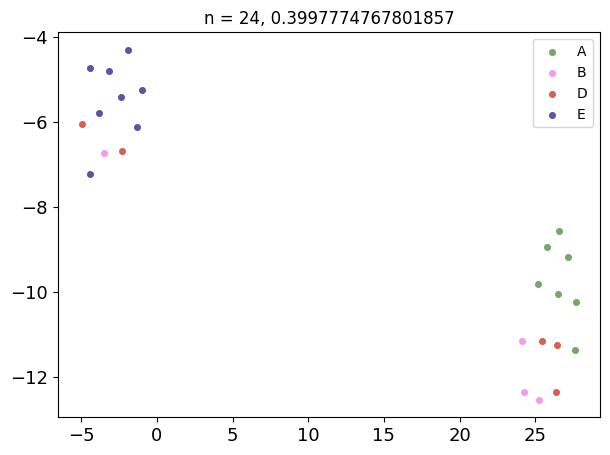

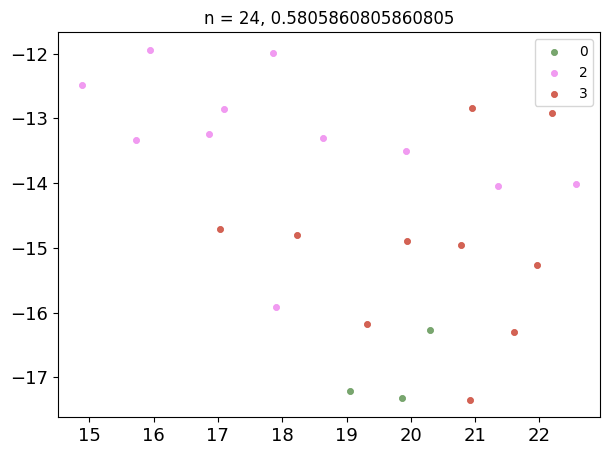

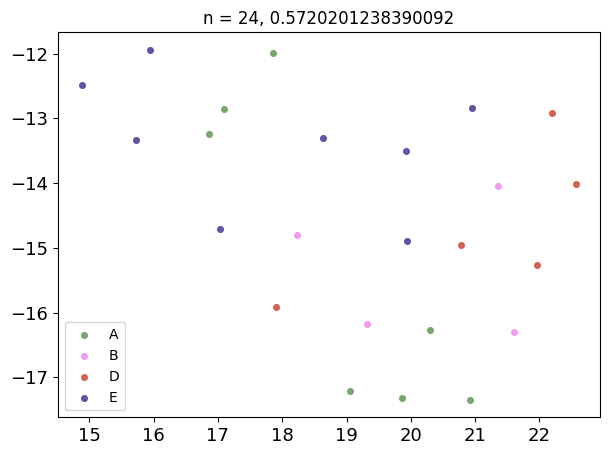

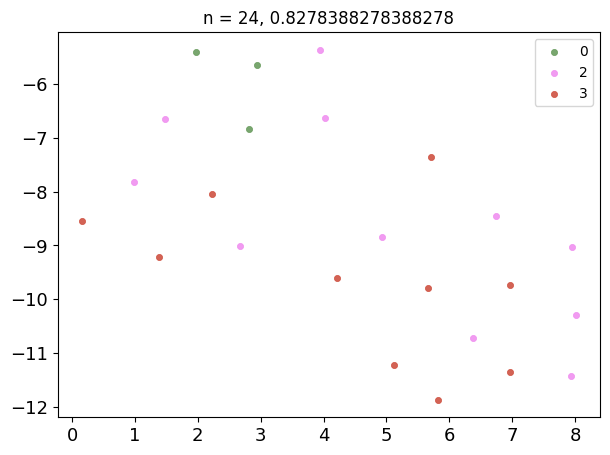

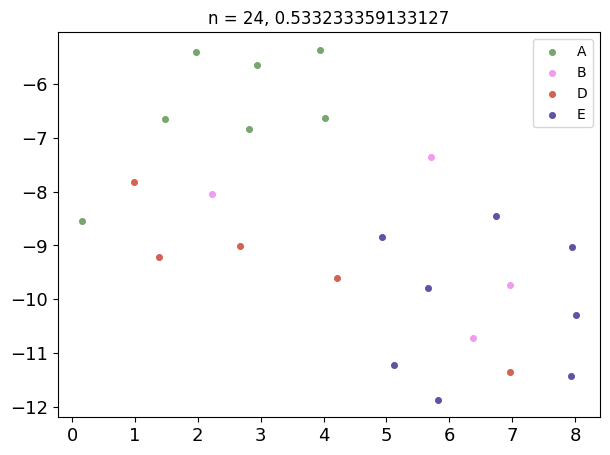

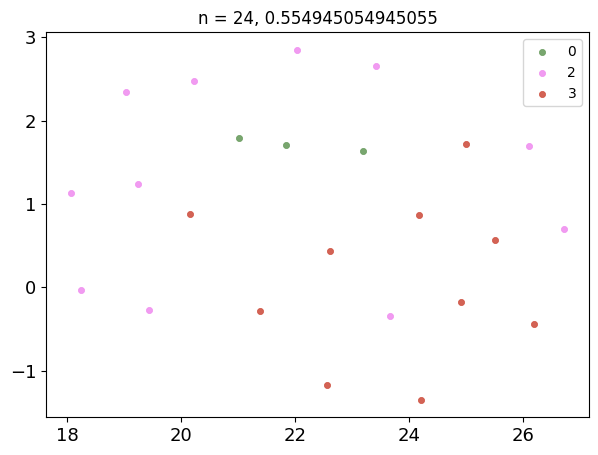

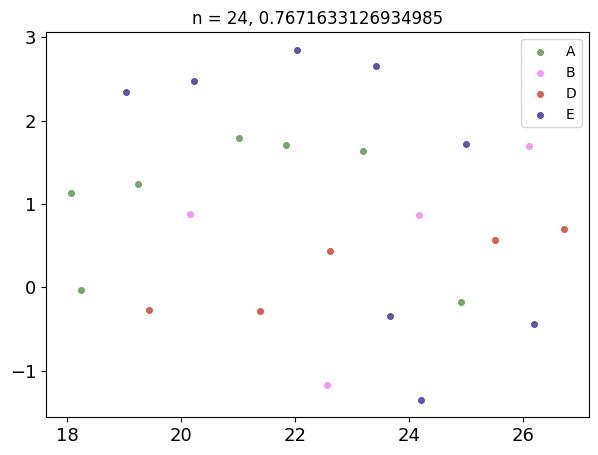

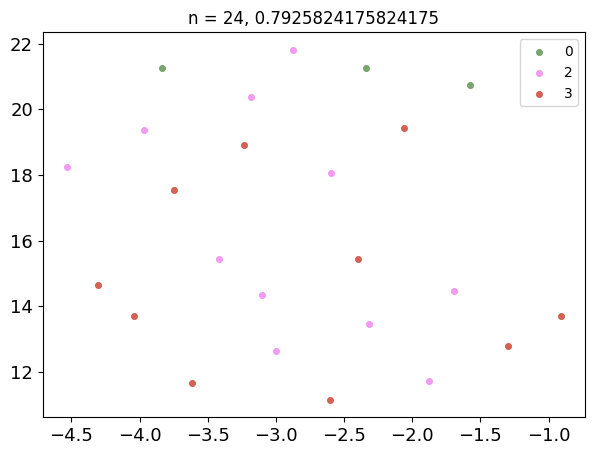

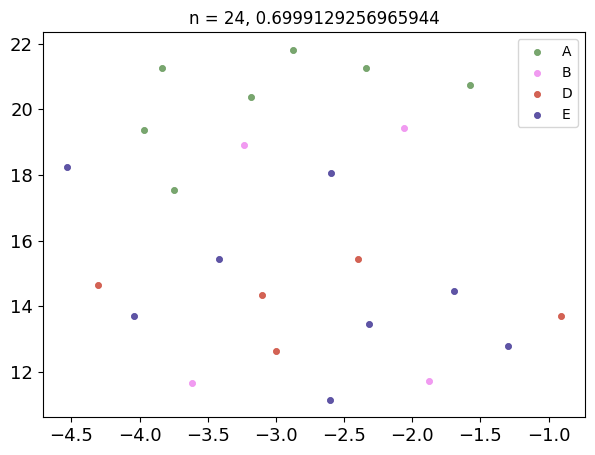

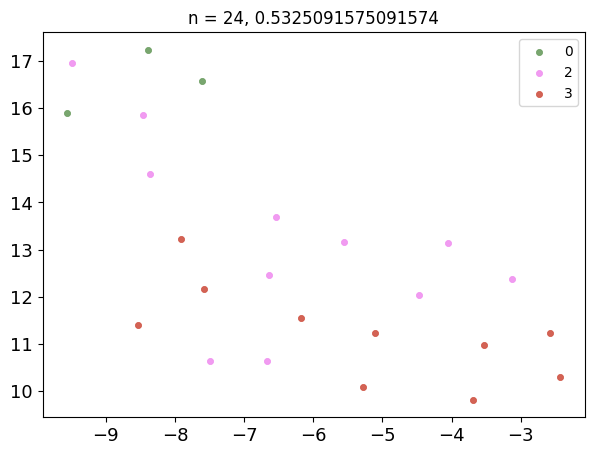

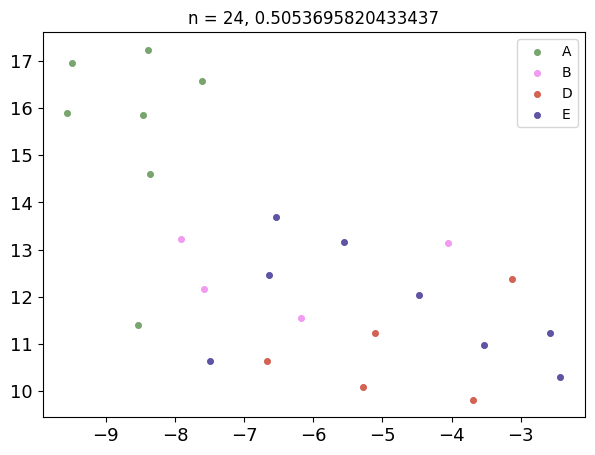

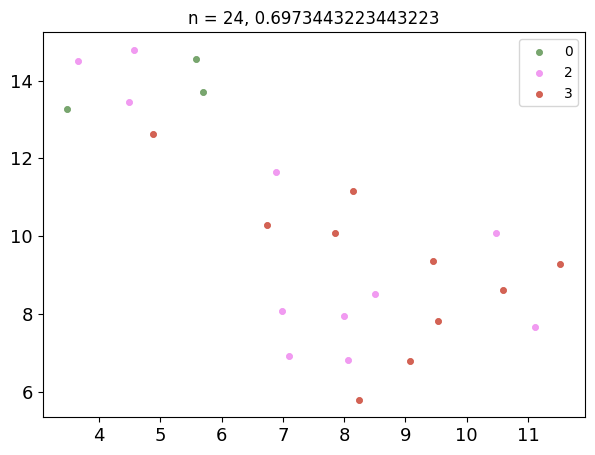

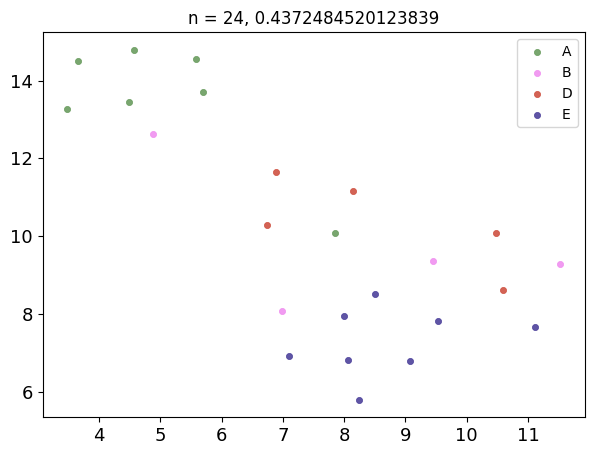

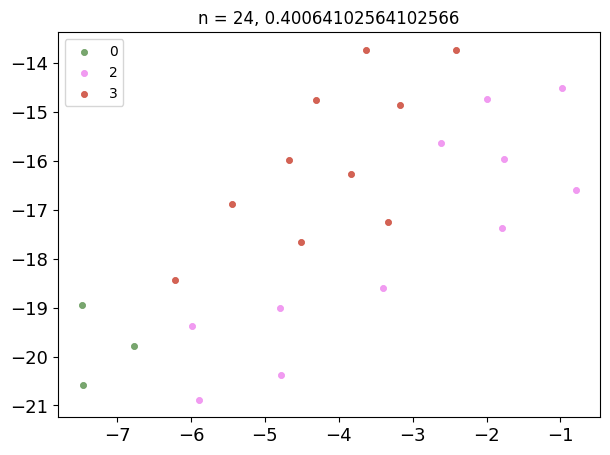

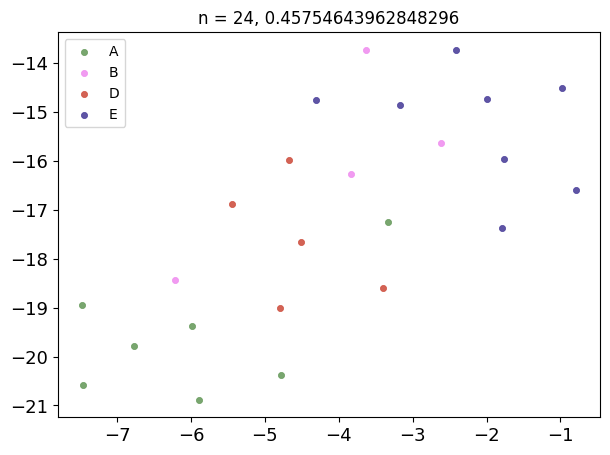

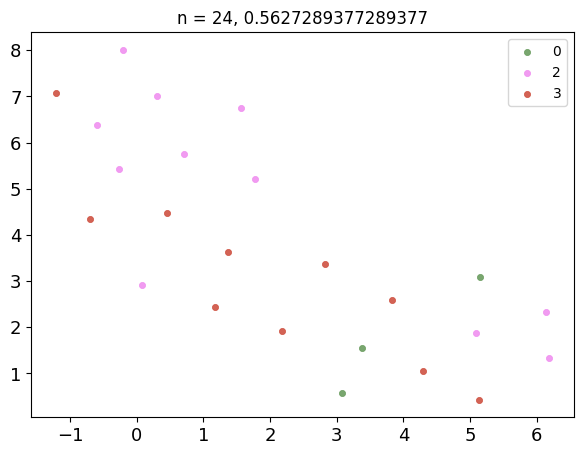

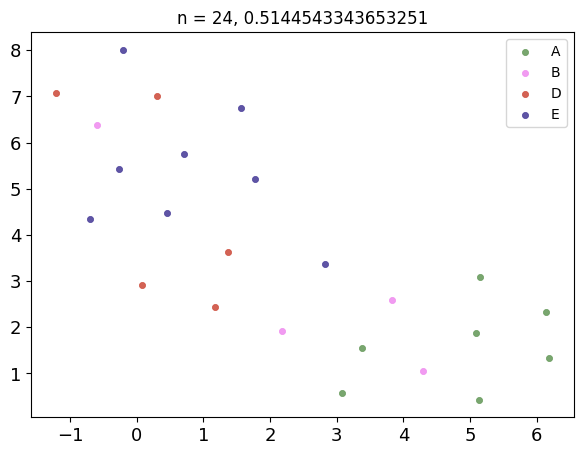

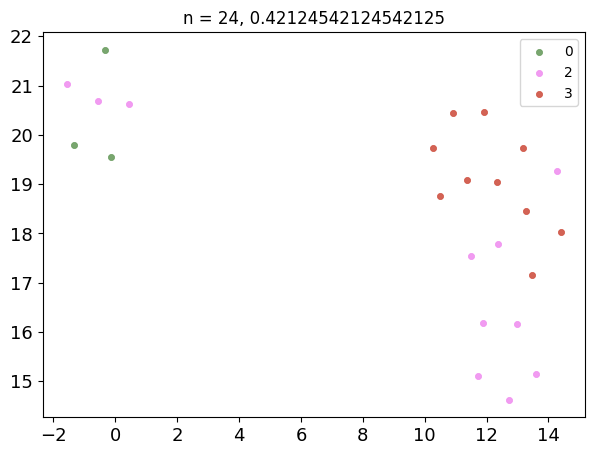

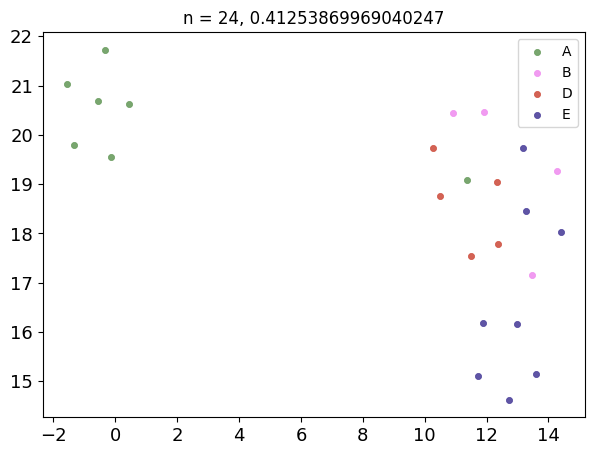

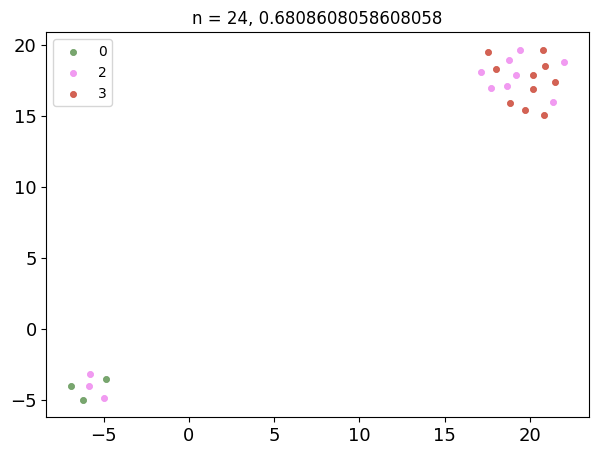

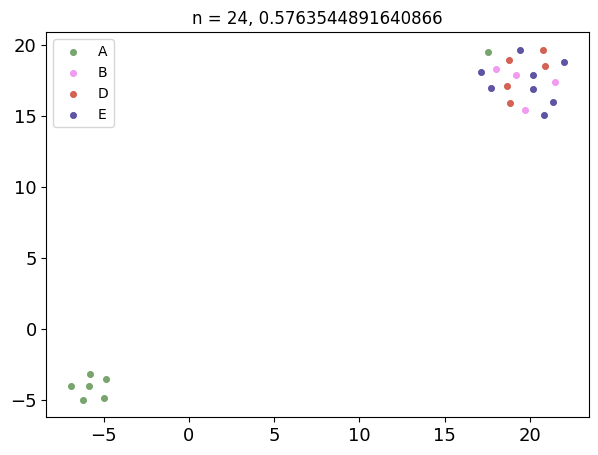

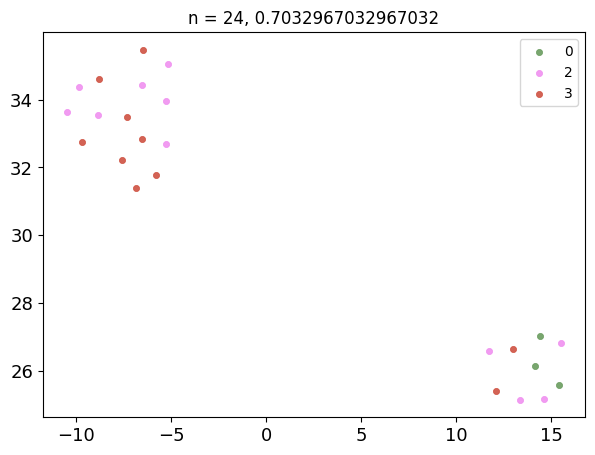

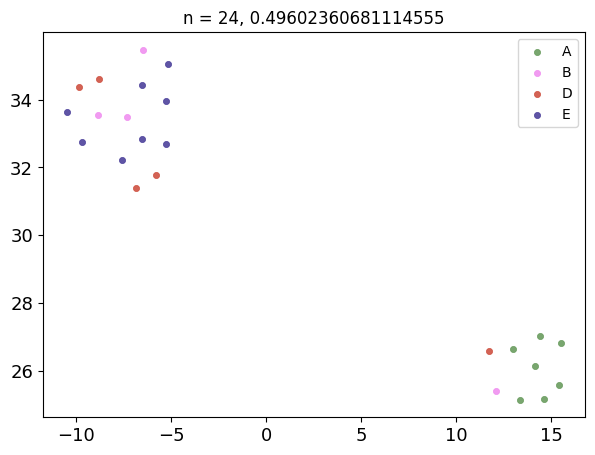

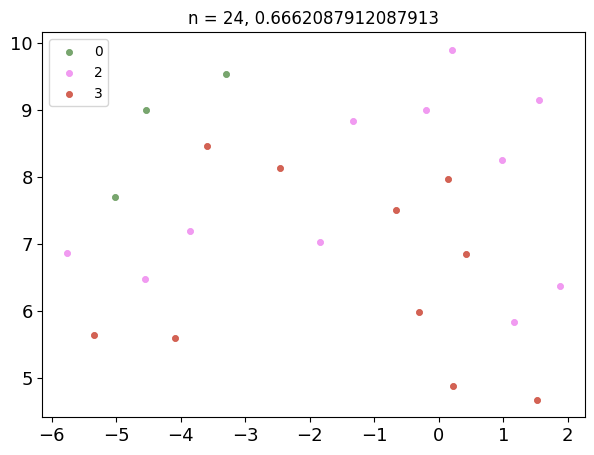

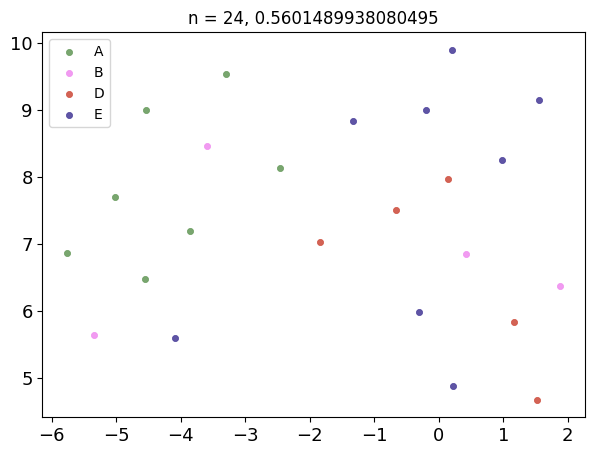

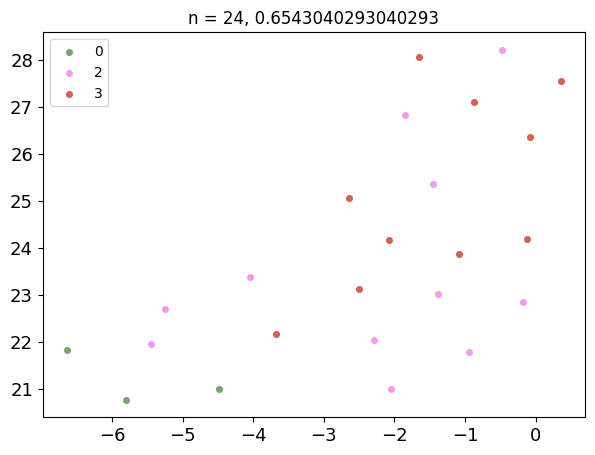

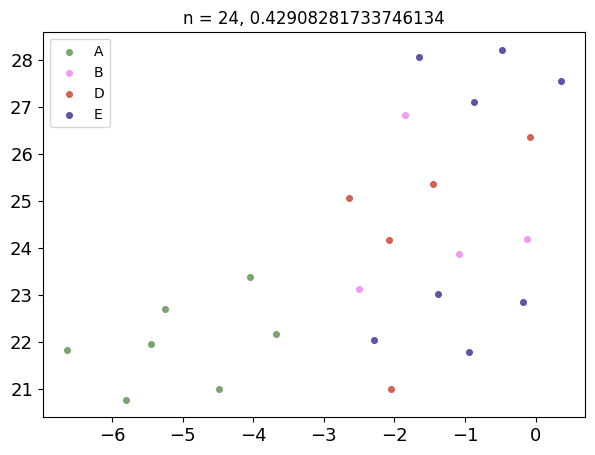

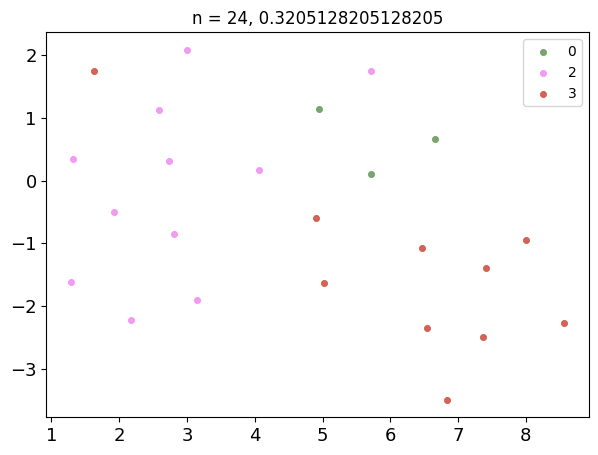

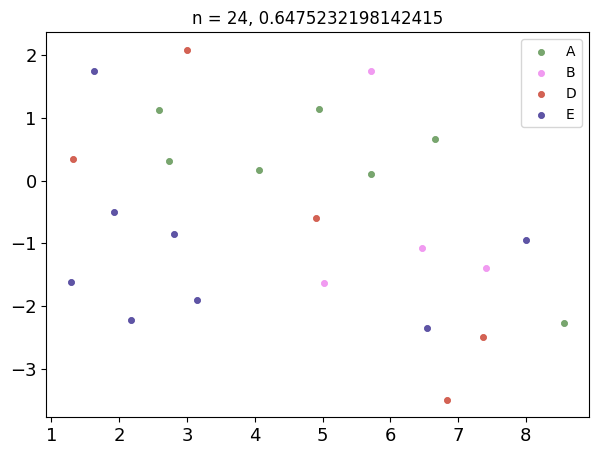

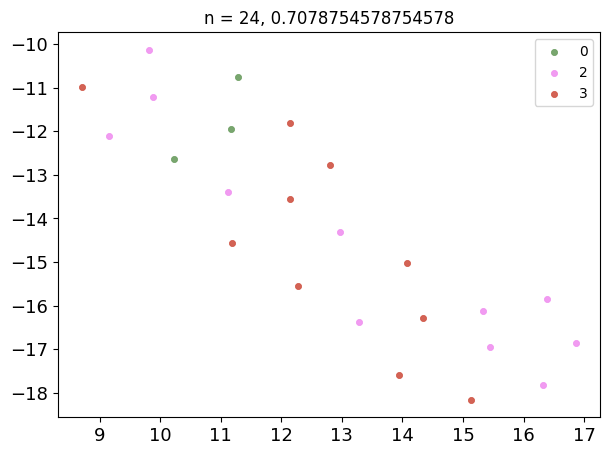

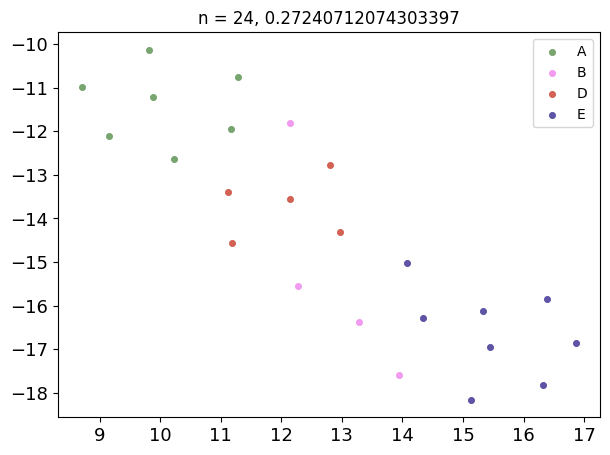

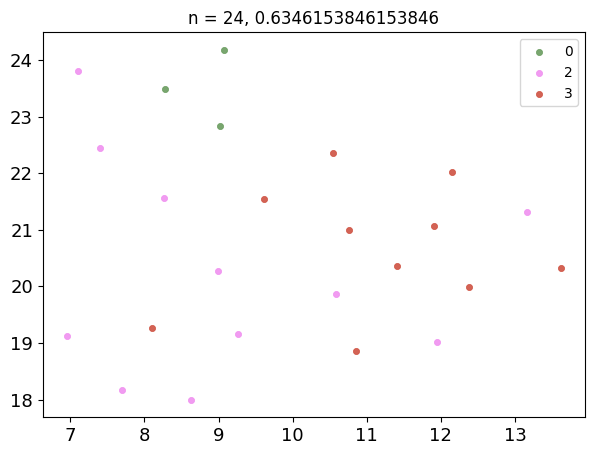

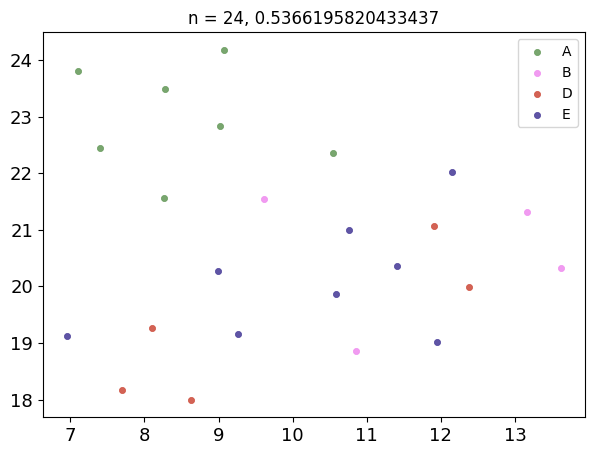

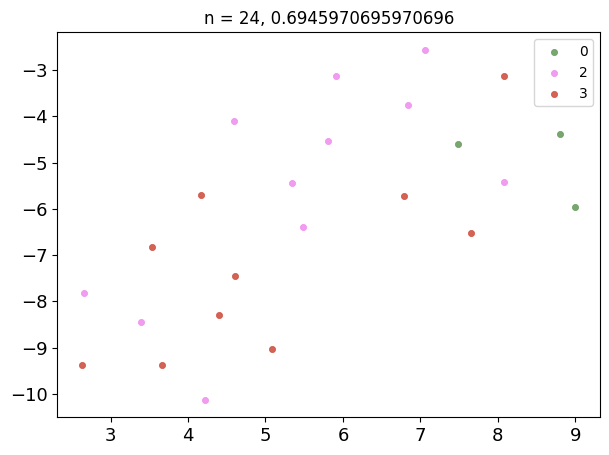

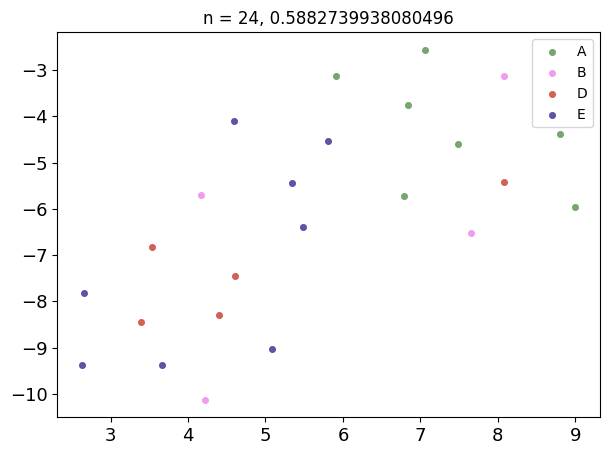

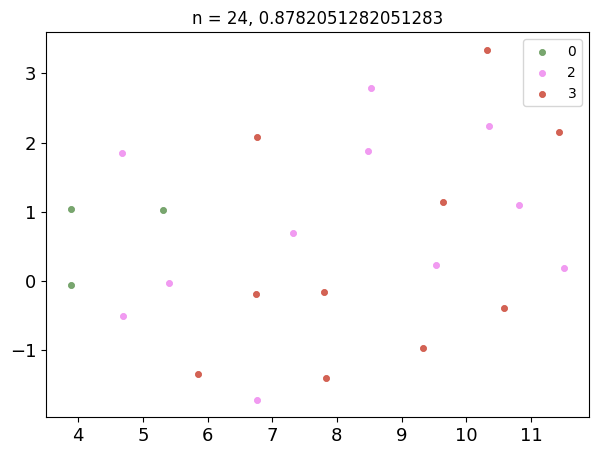

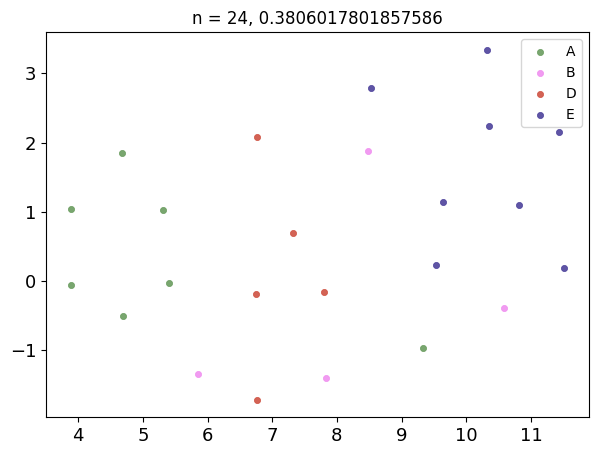

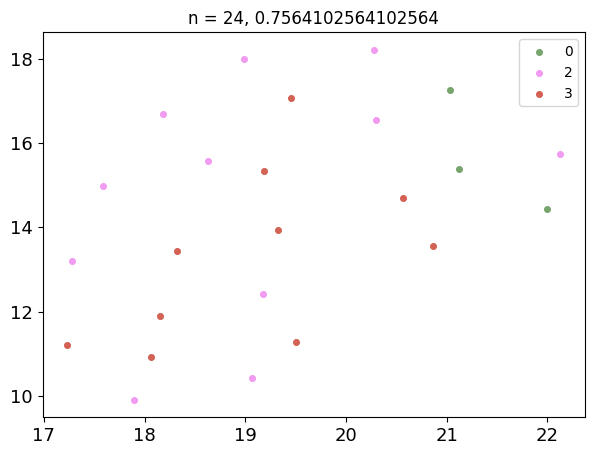

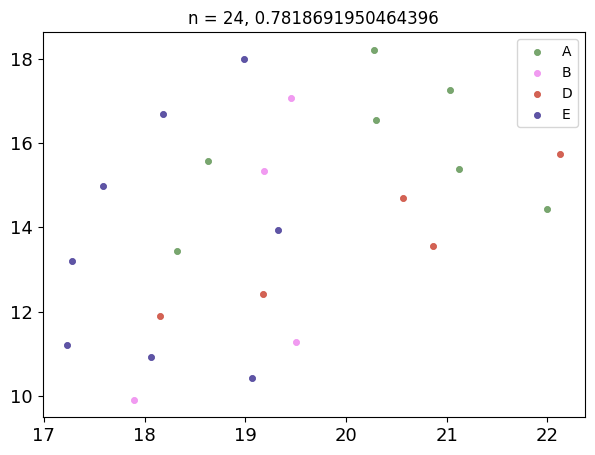

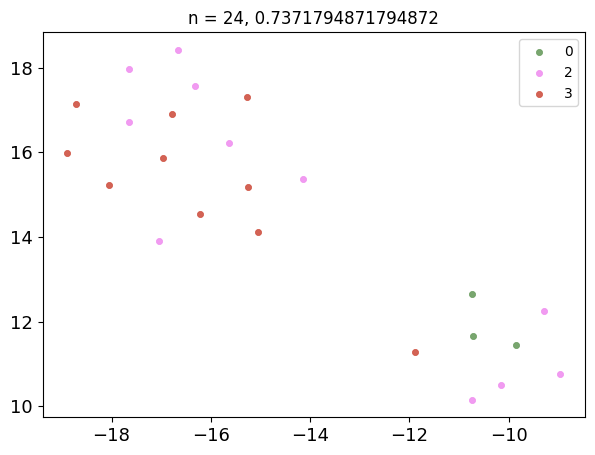

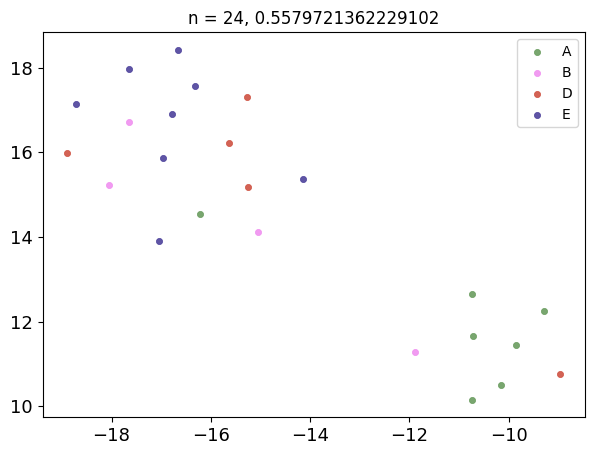

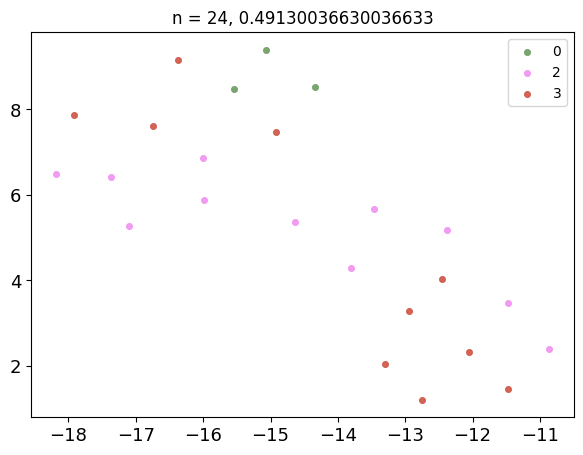

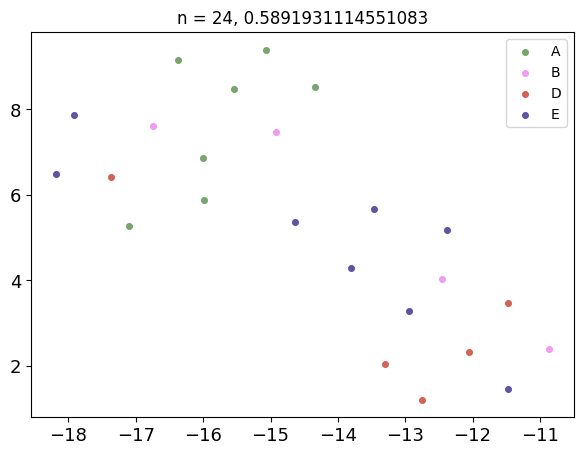

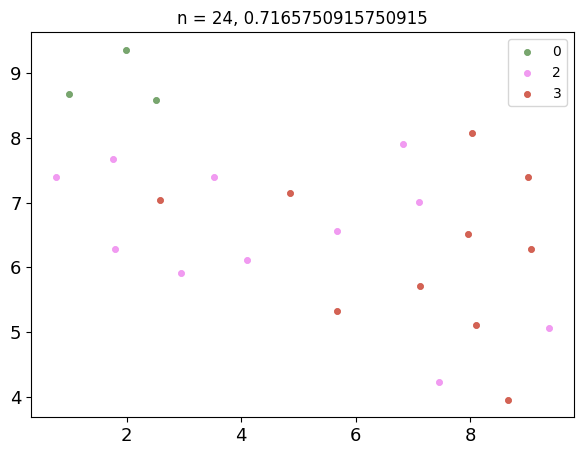

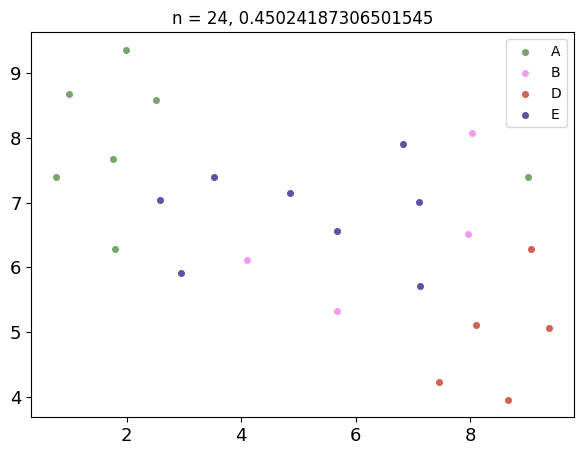

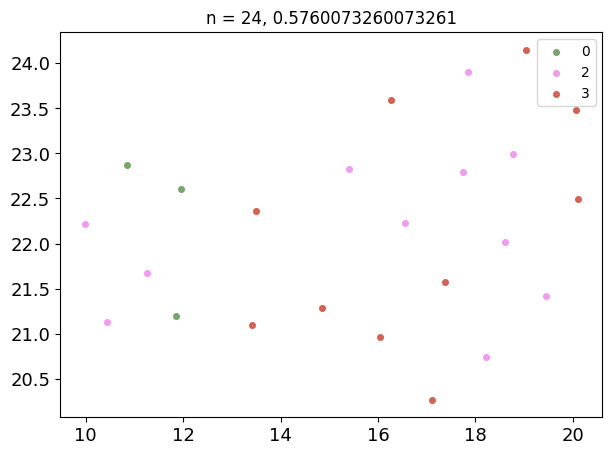

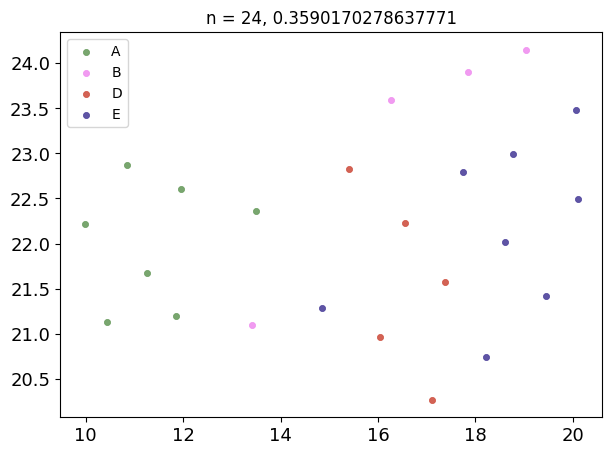

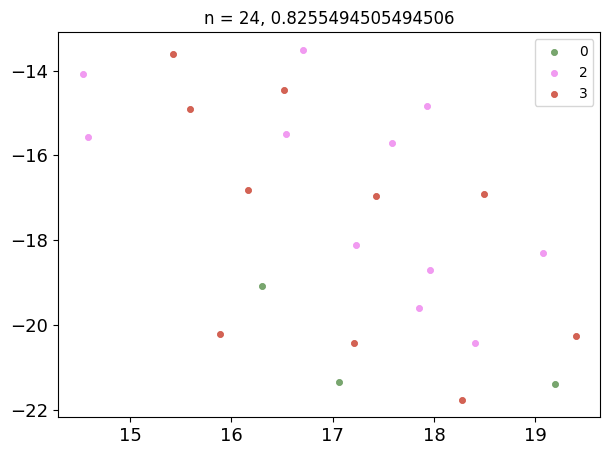

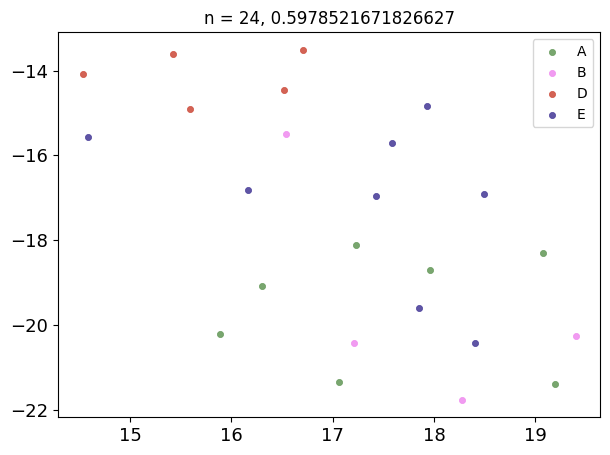

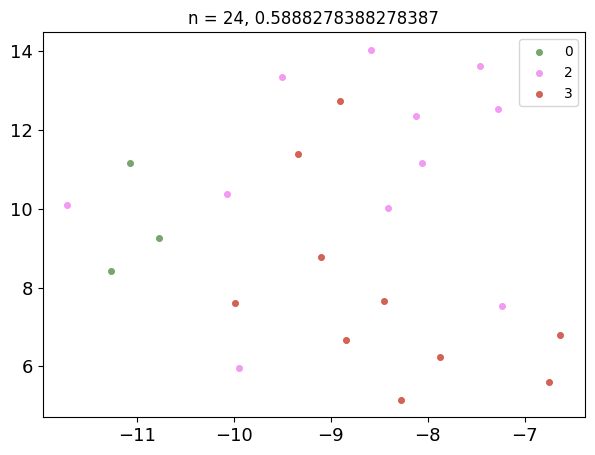

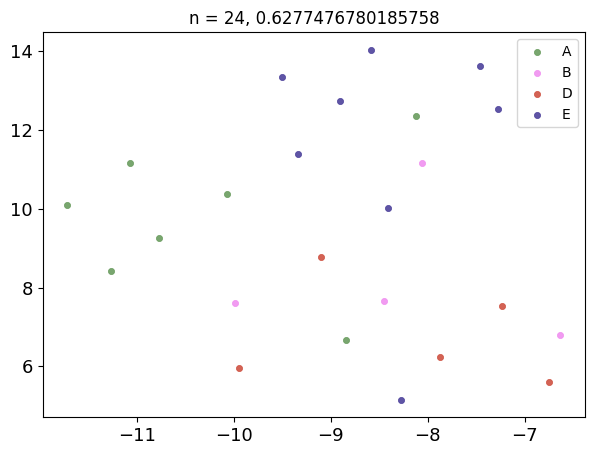

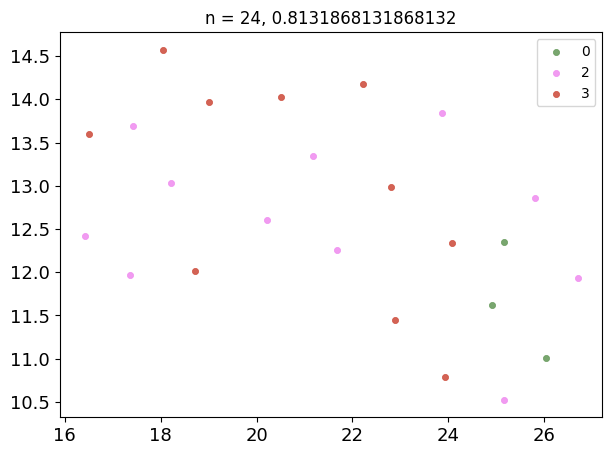

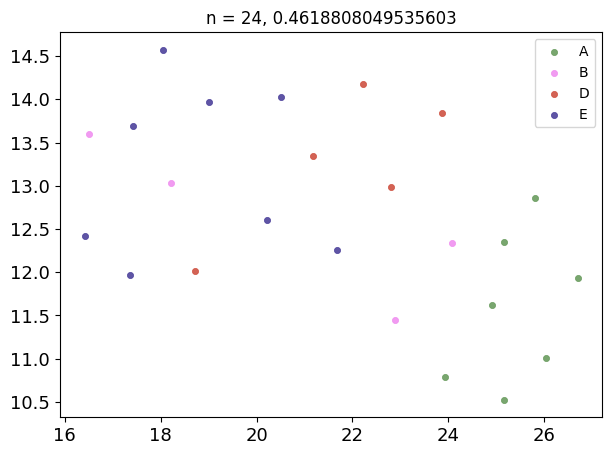

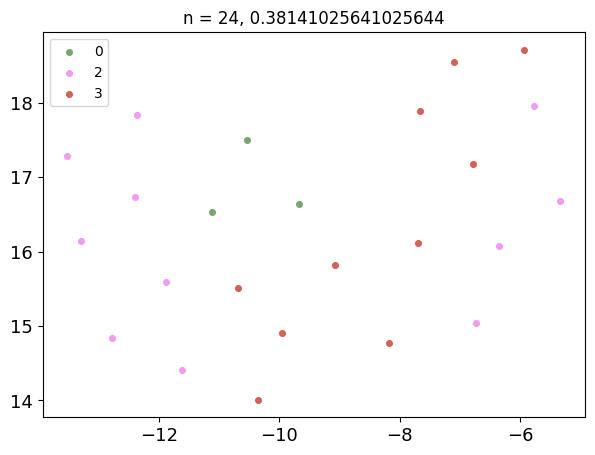

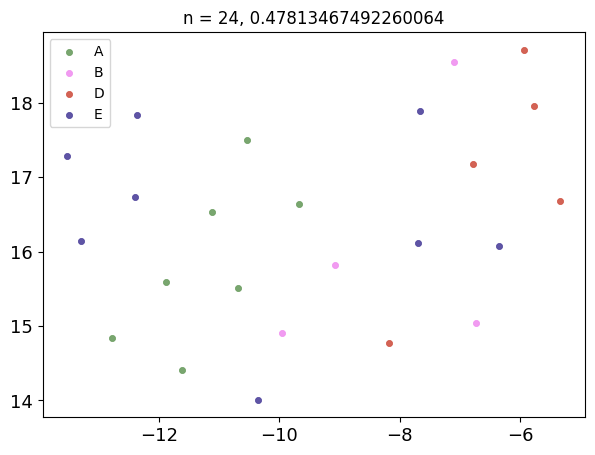

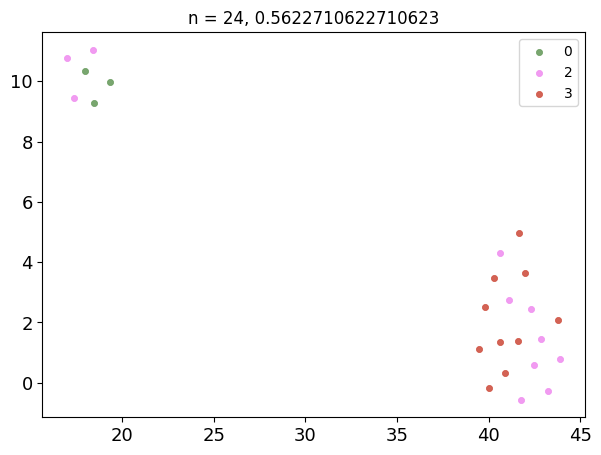

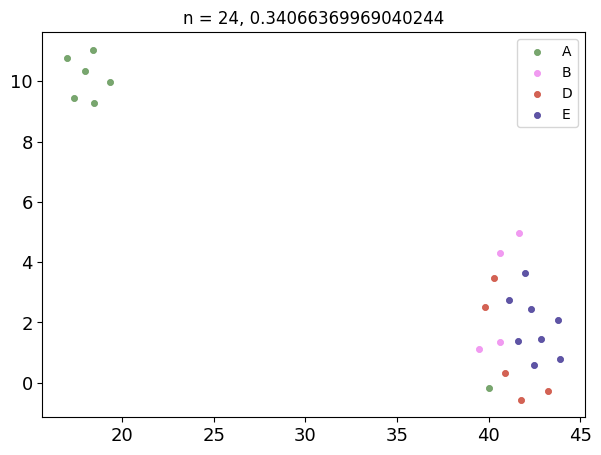

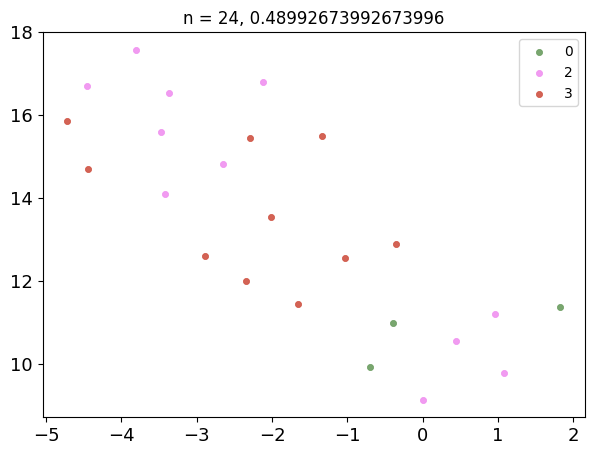

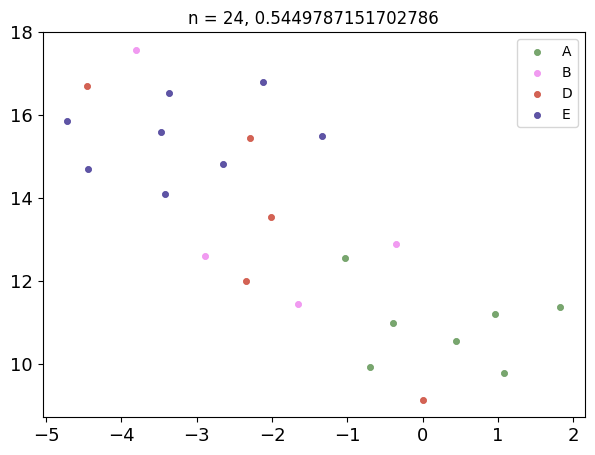

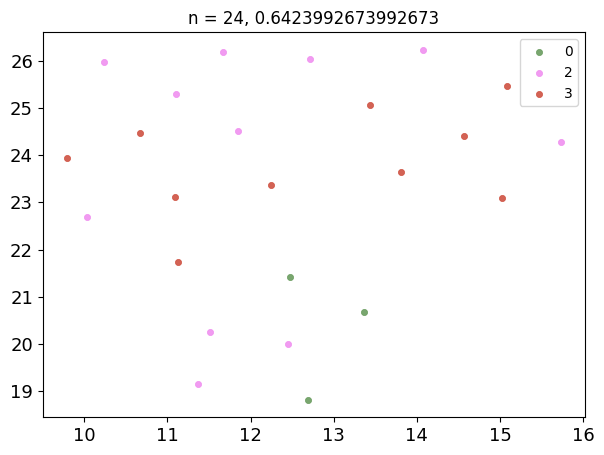

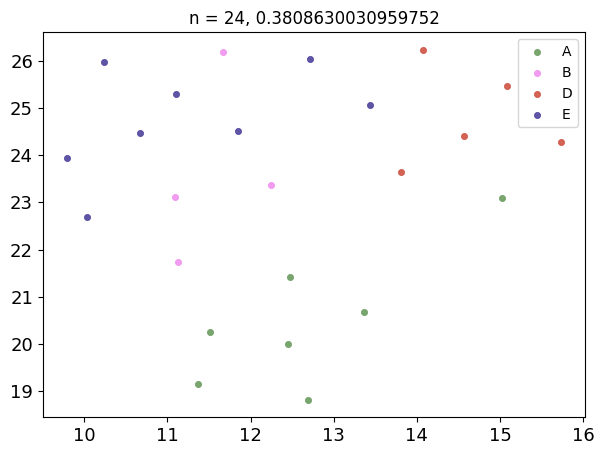

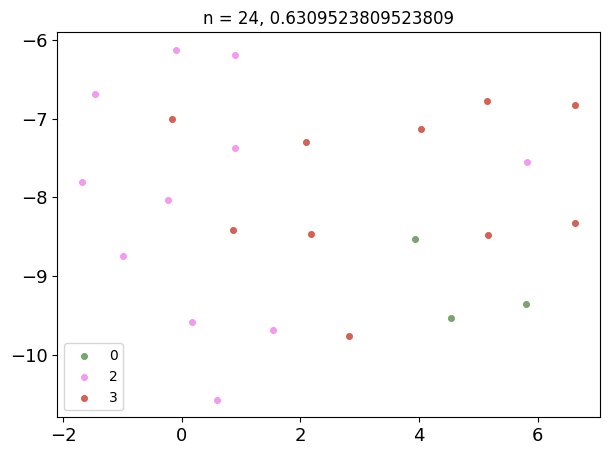

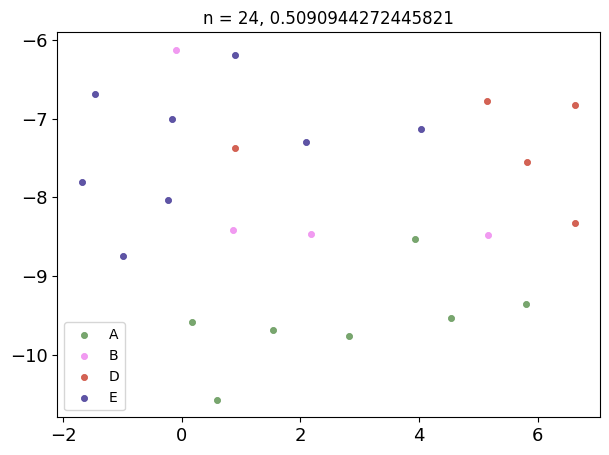

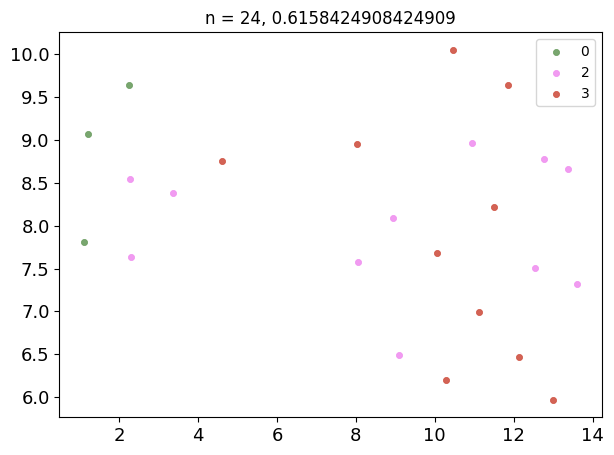

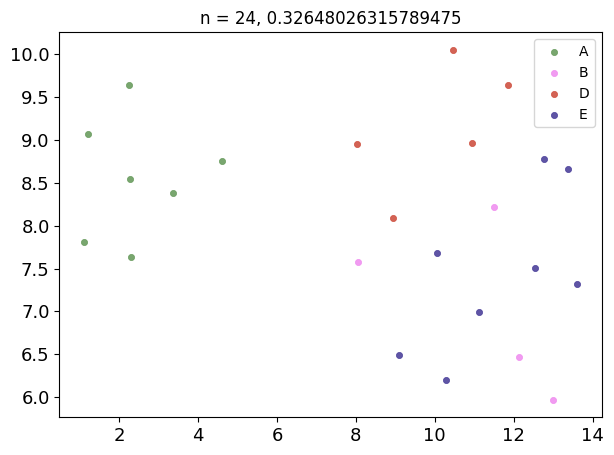

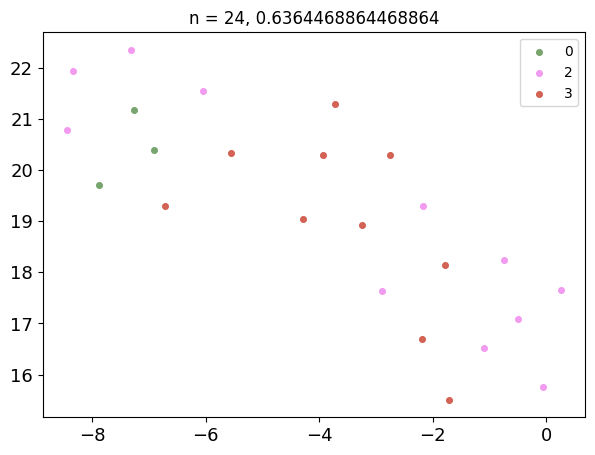

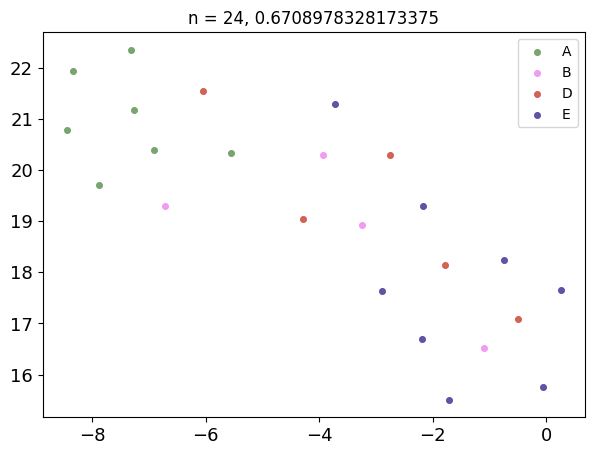

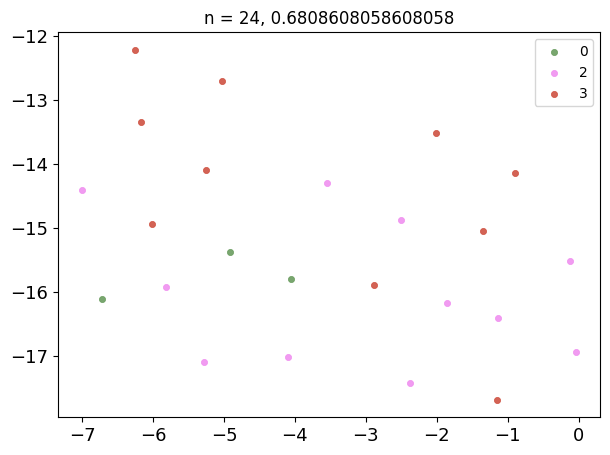

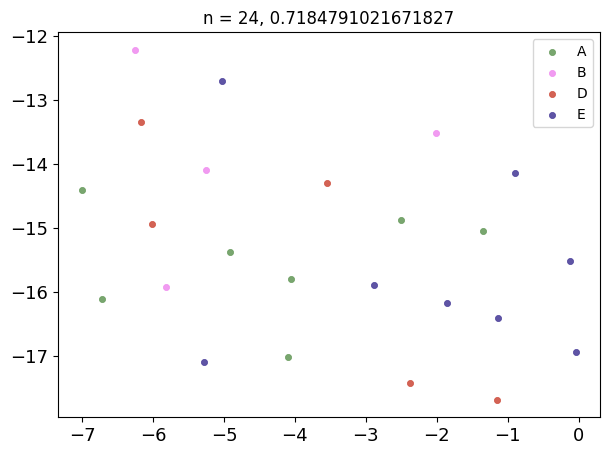

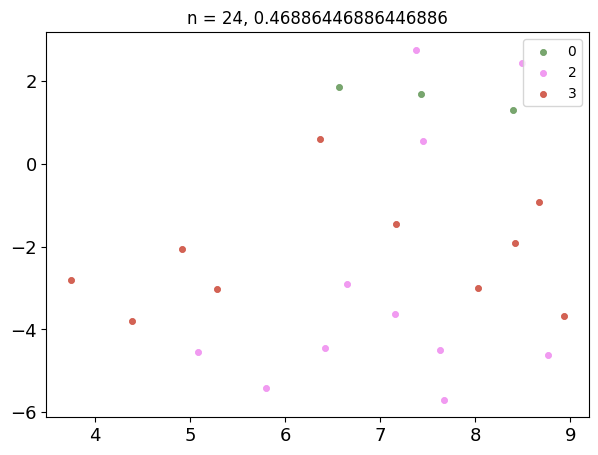

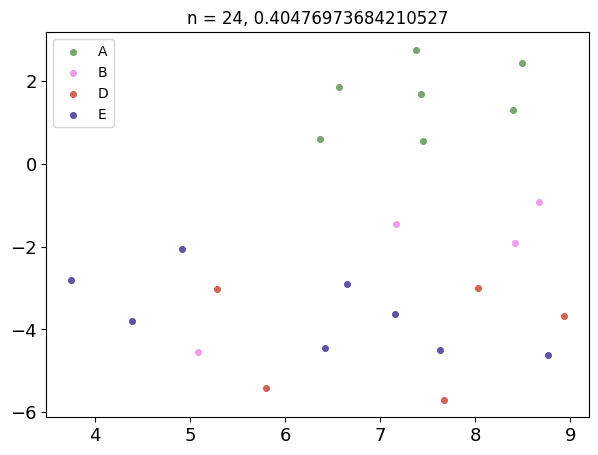

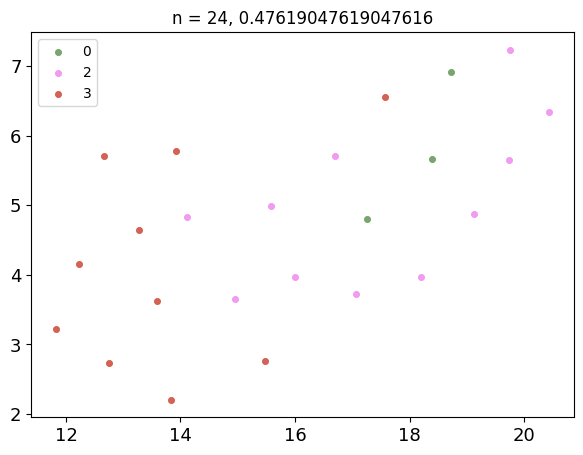

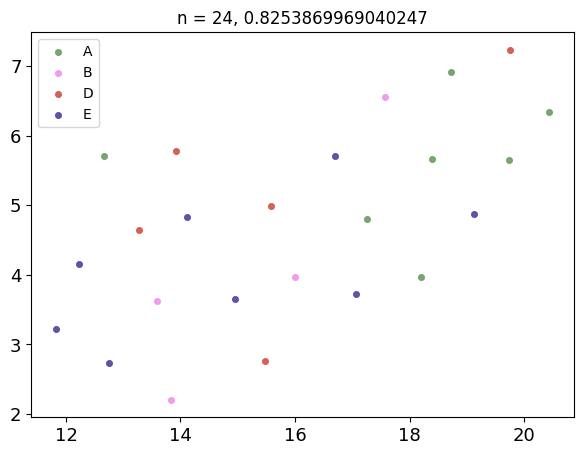

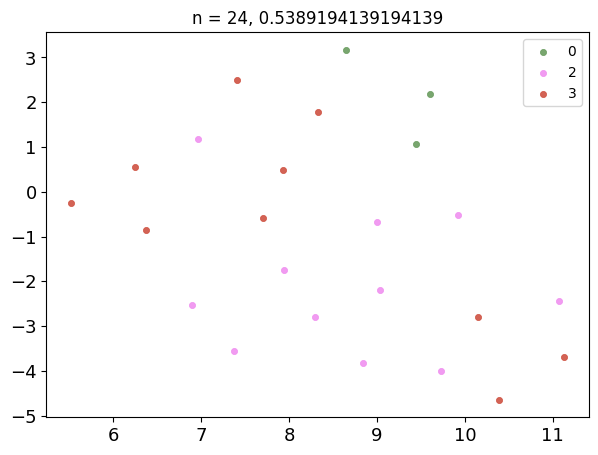

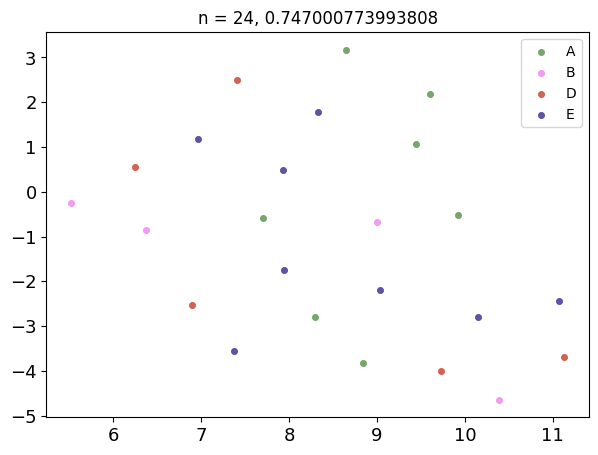

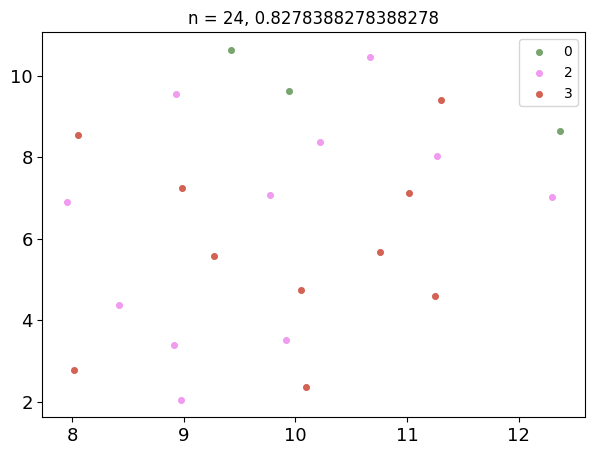

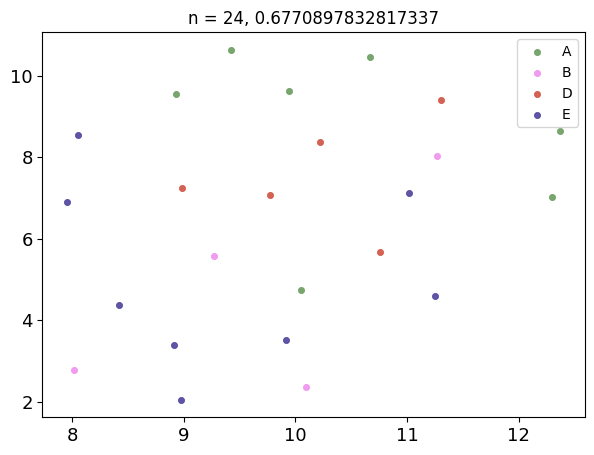

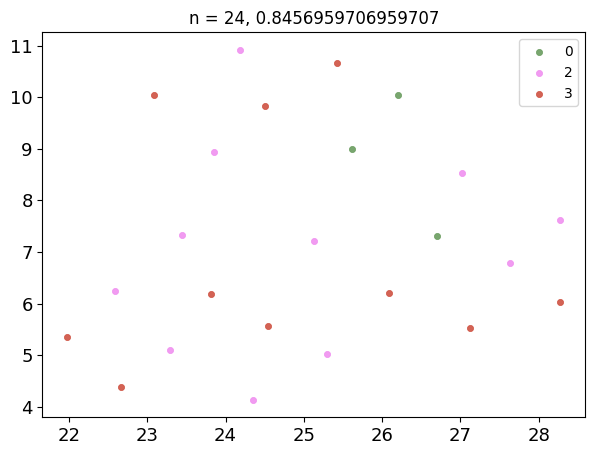

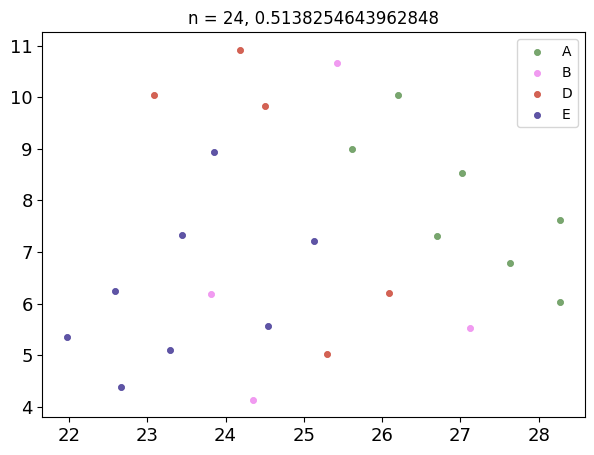

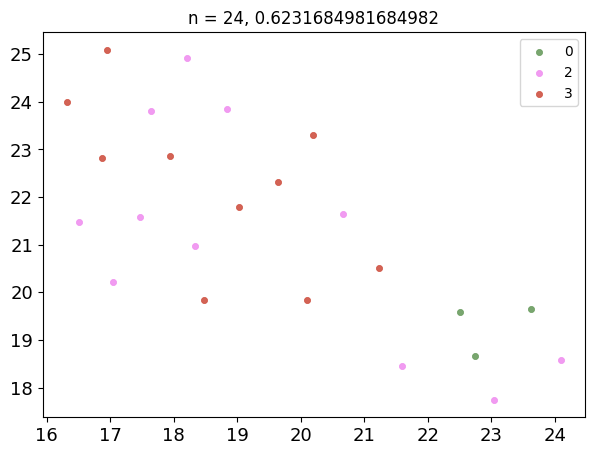

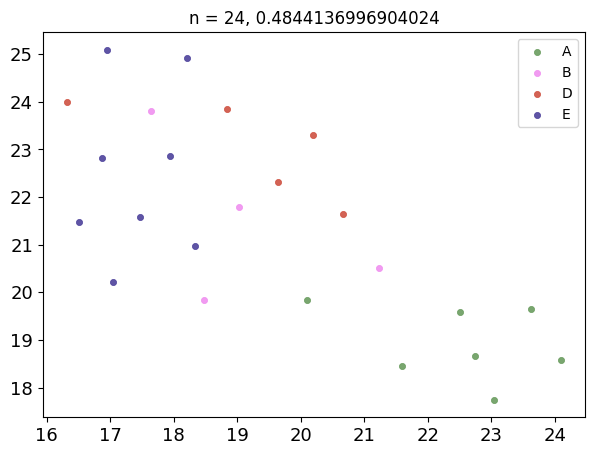

In [11]:
ft_num = net_args.ft_num

out_dir = f"models/finetune_LINCS_Quartet/record_{ft_num}"
os.makedirs(out_dir, exist_ok = True)

data, labels, labels_hot, ids = input_arr, unwanted_labels, unwanted_onehot, np.arange(len(unwanted_onehot))
num_batch = len(label2bat)
avg_aligned_data, test_data, test_wnt_infs, test_unw_infs, test_ids = FTUT.test_finetune(data, labels, labels_hot, donors, ids, label2bat, load_dir, out_dir, net_args, num_batch, finetune_num = ft_num, n_test = 100)

save_path = os.path.join(out_dir, "DA_data.csv")
df = pd.DataFrame(avg_aligned_data, columns = pretrain_genes)
df["ID"] = test_ids
df["wantInfo"] = test_wnt_infs
df["unwantInfo"] = test_unw_infs
df.to_csv(save_path, index = False)
